In [1]:
# Import necessary libraries
import torch
import torchvision
from torchvision.datasets import ImageFolder,KMNIST
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
import numpy as np
import time, math

In [2]:
# Loading dataset
batch_size = 50
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((240,240)), 
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((240,240)), 
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    transforms.Normalize(mean, std)
])

train_data = torchvision.datasets.EMNIST(
    root=".",
    split="letters",
    train=True,
    download=True,
    transform = train_transform)

test_data = torchvision.datasets.EMNIST(
    root=".",
    split="letters",
    train=False,
    download=True,
    transform = test_transform)

# Initialize EMINST train and test data loaders. 
emnist_train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)
emnist_test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)
print(train_data)
print(len(train_data.classes))
print(test_data)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(240, 240), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Lambda()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
27
Dataset EMNIST
    Number of datapoints: 20800
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(240, 240), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Lambda()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

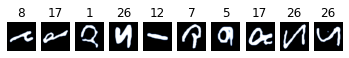

In [3]:
# Visualize an image and its label
for i in range(10):
    image, label = train_data[np.random.randint(len(train_data))]
    plt.subplot(1, 10, i+1)
    # If running this cell gives you error regarding image size please try this:
    # plt.imshow(image.permute(1,2,0).squeeze(2), cmap='gray')
    plt.imshow(image.permute(1,2,0))
    plt.title(label)
    plt.axis("off")
plt.show()

In [4]:
# Checking if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Load MobileNet V3 small
mobilenet_v3_small = torchvision.models.mobilenet_v3_small(pretrained=True)
mobilenet_v3_small.eval()
# Freeze the weights
for param in mobilenet_v3_small.parameters():
    param.requires_grad = False
# Modify the last layer
number_features = mobilenet_v3_small.classifier[3].in_features
features = list(mobilenet_v3_small.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, 27)])
mobilenet_v3_small.classifier = torch.nn.Sequential(*features)

mobilenet_v3_small.to(device)
print(mobilenet_v3_small)


cuda
MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), s

In [5]:
# Load SqueezeNet
squeezenet = torchvision.models.squeezenet1_0(pretrained=True)
squeezenet.eval()
# Freeze the weights
for param in squeezenet.parameters():
    param.requires_grad = False
# Modify the classification layers
squeezenet.classifier[1] = torch.nn.Conv2d(512, 27, kernel_size=(1,1), stride=(1,1))
squeezenet.to(device)
print(squeezenet)
squeezenet.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [6]:
# Load ShuffleNet
shufflenet = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
shufflenet.eval()
# Freeze the weights
for param in shufflenet.parameters():
    param.requires_grad = False
in_features = shufflenet.fc.in_features
shufflenet.fc = torch.nn.Linear(in_features, 27, bias=True)
print(shufflenet)
shufflenet.to(device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [7]:
# Load EfficientNet baseline
efficientnet_b0 = torchvision.models.efficientnet_b0(pretrained=True)
efficientnet_b0.eval()
# Freeze the weights
for param in efficientnet_b0.parameters():
    param.requires_grad = False
in_features = efficientnet_b0.classifier[1].in_features
efficientnet_b0.classifier[1] = torch.nn.Linear(in_features, 27, bias=True)
print(efficientnet_b0) 
efficientnet_b0.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [8]:
# Load ResNet18
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.eval()
for param in resnet18.parameters():
    param.requires_grad = False
in_features = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(in_features, 27, bias=True)
print(resnet18)
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
criterion = torch.nn.CrossEntropyLoss()
def Train(model,optimizer,dataloader,device):
    loss_tracker = []
    accuracy_tracker = []
    for i,(data,label) in enumerate(dataloader):
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        outputs = model.forward(data)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        if i % batch_size:
            print(f'step: {i+1}, loss = {loss.item():.4f}')
            with torch.no_grad():
                loss_tracker.append(loss.item())
                value, predictions = torch.max(outputs,1)
#                 print(f'Predictions: {predictions}')
#                 print(f'Labels: {label}')
                correct_prediction = 0
                correct_prediction += (predictions == label).sum().item()
                accuracy = correct_prediction / label.shape[0] * 100
                accuracy_tracker.append(accuracy)
            
    return loss_tracker, accuracy_tracker

def Test(model,dataloader,device):
    loss_tracker = []
    accuracy_tracker = []
    for i,(data,label) in enumerate(dataloader):
        data = data.to(device)
        label = label.to(device)
        with torch.no_grad():
            outputs = model.forward(data)
            loss = criterion(outputs, label)
            _, predictions = torch.max(outputs,1)
            correct_prediction = 0
            correct_prediction += (predictions == label).sum().item()
            accuracy = correct_prediction / label.shape[0] * 100
            
        loss_tracker.append(loss.item())
        accuracy_tracker.append(accuracy)
        
    return sum(loss_tracker)/len(loss_tracker), sum(accuracy_tracker)/len(accuracy_tracker)

In [10]:
epochs = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(mobilenet_v3_small.parameters(), lr = learning_rate)

# Train and test MobileNet V3 small
model = mobilenet_v3_small

train_loss_tracker_1 = []
train_accuracy_tracker_1 = []
train_time_tracker_1 = []
test_loss_tracker_1 = []
test_accuracy_tracker_1 = []
test_time_tracker_1 = []

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    train_start_time = time.time()
    train_loss,train_accuracy = Train(model,optimizer,emnist_train_loader,device)
    train_end_time = time.time()
    train_time_tracker_1.append(train_end_time-train_start_time)
    test_start_time = time.time()
    test_loss , test_accuracy = Test(model,emnist_test_loader,device)
    test_end_time = time.time()
    test_time_tracker_1.append(test_end_time-test_start_time)
    train_loss_tracker_1.extend(train_loss)
    train_accuracy_tracker_1.extend(train_accuracy)
    test_loss_tracker_1.append(test_loss)
    test_accuracy_tracker_1.append(test_accuracy)
    print('\t training loss/accuracy: {0:.2f}/{1:.2f}'.format(sum(train_loss)/len(train_loss), sum(train_accuracy)/len((train_accuracy))))
    print('\t testing loss/accuracy: {0:.2f}/{1:.2f}'.format(test_loss, test_accuracy))

Epoch: 0
step: 2, loss = 3.3032
step: 3, loss = 3.4370
step: 4, loss = 3.2872
step: 5, loss = 3.2834
step: 6, loss = 3.0130
step: 7, loss = 3.0752
step: 8, loss = 3.2484
step: 9, loss = 3.1281
step: 10, loss = 3.0426
step: 11, loss = 3.0763
step: 12, loss = 2.9525
step: 13, loss = 2.9526
step: 14, loss = 2.8812
step: 15, loss = 2.8066
step: 16, loss = 2.9045
step: 17, loss = 2.7798
step: 18, loss = 2.7149
step: 19, loss = 2.7131
step: 20, loss = 2.7130
step: 21, loss = 2.6409
step: 22, loss = 2.7551
step: 23, loss = 2.6384
step: 24, loss = 2.5335
step: 25, loss = 2.6406
step: 26, loss = 2.4201
step: 27, loss = 2.4973
step: 28, loss = 2.4192
step: 29, loss = 2.4395
step: 30, loss = 2.5021
step: 31, loss = 2.4771
step: 32, loss = 2.3519
step: 33, loss = 2.3827
step: 34, loss = 2.3610
step: 35, loss = 2.3240
step: 36, loss = 2.2824
step: 37, loss = 2.2476
step: 38, loss = 2.4461
step: 39, loss = 2.1746
step: 40, loss = 2.1758
step: 41, loss = 2.3657
step: 42, loss = 2.1502
step: 43, loss 

step: 340, loss = 0.8820
step: 341, loss = 0.9978
step: 342, loss = 1.1777
step: 343, loss = 1.0447
step: 344, loss = 1.0343
step: 345, loss = 1.1839
step: 346, loss = 0.9455
step: 347, loss = 0.9677
step: 348, loss = 0.9423
step: 349, loss = 1.1570
step: 350, loss = 0.9224
step: 352, loss = 1.1555
step: 353, loss = 0.9750
step: 354, loss = 0.9840
step: 355, loss = 1.0035
step: 356, loss = 1.3134
step: 357, loss = 0.7229
step: 358, loss = 0.8928
step: 359, loss = 1.1874
step: 360, loss = 0.8904
step: 361, loss = 0.9722
step: 362, loss = 1.2367
step: 363, loss = 0.9681
step: 364, loss = 1.0668
step: 365, loss = 0.9869
step: 366, loss = 1.1187
step: 367, loss = 0.9392
step: 368, loss = 0.8617
step: 369, loss = 0.9809
step: 370, loss = 1.0307
step: 371, loss = 0.8410
step: 372, loss = 0.8698
step: 373, loss = 0.9092
step: 374, loss = 1.4716
step: 375, loss = 0.9809
step: 376, loss = 0.9008
step: 377, loss = 0.9794
step: 378, loss = 1.2682
step: 379, loss = 1.0072
step: 380, loss = 1.1624


step: 678, loss = 0.5156
step: 679, loss = 0.7586
step: 680, loss = 0.7175
step: 681, loss = 0.8728
step: 682, loss = 0.9818
step: 683, loss = 0.5791
step: 684, loss = 1.0045
step: 685, loss = 0.7559
step: 686, loss = 0.5759
step: 687, loss = 0.6897
step: 688, loss = 0.7305
step: 689, loss = 0.9372
step: 690, loss = 0.8933
step: 691, loss = 0.9968
step: 692, loss = 0.8340
step: 693, loss = 0.8034
step: 694, loss = 0.9555
step: 695, loss = 0.8280
step: 696, loss = 0.9758
step: 697, loss = 0.6576
step: 698, loss = 0.6910
step: 699, loss = 0.7540
step: 700, loss = 0.7311
step: 702, loss = 0.7420
step: 703, loss = 0.9201
step: 704, loss = 0.8759
step: 705, loss = 0.7803
step: 706, loss = 0.6364
step: 707, loss = 0.7539
step: 708, loss = 0.8293
step: 709, loss = 0.9482
step: 710, loss = 0.7453
step: 711, loss = 0.8092
step: 712, loss = 0.8341
step: 713, loss = 0.6651
step: 714, loss = 0.8515
step: 715, loss = 0.9272
step: 716, loss = 0.8348
step: 717, loss = 0.8101
step: 718, loss = 0.8233


step: 1015, loss = 0.7090
step: 1016, loss = 0.5199
step: 1017, loss = 0.7393
step: 1018, loss = 0.7355
step: 1019, loss = 0.6219
step: 1020, loss = 0.7705
step: 1021, loss = 0.6264
step: 1022, loss = 0.8034
step: 1023, loss = 0.7433
step: 1024, loss = 0.6755
step: 1025, loss = 0.6863
step: 1026, loss = 0.7982
step: 1027, loss = 0.8177
step: 1028, loss = 0.9526
step: 1029, loss = 0.6538
step: 1030, loss = 0.5954
step: 1031, loss = 0.6618
step: 1032, loss = 0.4874
step: 1033, loss = 0.6728
step: 1034, loss = 0.7325
step: 1035, loss = 0.5035
step: 1036, loss = 0.5584
step: 1037, loss = 0.6362
step: 1038, loss = 0.6294
step: 1039, loss = 0.4525
step: 1040, loss = 0.6984
step: 1041, loss = 0.7302
step: 1042, loss = 0.4459
step: 1043, loss = 0.6178
step: 1044, loss = 0.7893
step: 1045, loss = 0.6852
step: 1046, loss = 0.6294
step: 1047, loss = 0.6655
step: 1048, loss = 0.6890
step: 1049, loss = 0.7618
step: 1050, loss = 0.4496
step: 1052, loss = 0.7642
step: 1053, loss = 0.6363
step: 1054, 

step: 1338, loss = 0.4166
step: 1339, loss = 0.7164
step: 1340, loss = 0.6320
step: 1341, loss = 0.6593
step: 1342, loss = 0.7357
step: 1343, loss = 0.5102
step: 1344, loss = 0.6802
step: 1345, loss = 0.6425
step: 1346, loss = 0.6055
step: 1347, loss = 0.7190
step: 1348, loss = 0.5799
step: 1349, loss = 0.6175
step: 1350, loss = 0.4946
step: 1352, loss = 0.5681
step: 1353, loss = 0.6999
step: 1354, loss = 0.6765
step: 1355, loss = 0.6275
step: 1356, loss = 0.6359
step: 1357, loss = 0.4678
step: 1358, loss = 0.8367
step: 1359, loss = 0.6028
step: 1360, loss = 0.4722
step: 1361, loss = 0.6072
step: 1362, loss = 0.5371
step: 1363, loss = 0.6741
step: 1364, loss = 0.7199
step: 1365, loss = 0.6639
step: 1366, loss = 0.6052
step: 1367, loss = 0.9409
step: 1368, loss = 0.4909
step: 1369, loss = 0.6265
step: 1370, loss = 0.5472
step: 1371, loss = 0.6677
step: 1372, loss = 0.7537
step: 1373, loss = 0.6253
step: 1374, loss = 0.4730
step: 1375, loss = 0.7190
step: 1376, loss = 0.4285
step: 1377, 

step: 1664, loss = 0.8251
step: 1665, loss = 0.4075
step: 1666, loss = 0.3970
step: 1667, loss = 0.7879
step: 1668, loss = 0.4169
step: 1669, loss = 0.6038
step: 1670, loss = 0.6184
step: 1671, loss = 0.7190
step: 1672, loss = 0.6734
step: 1673, loss = 0.4773
step: 1674, loss = 0.3436
step: 1675, loss = 0.6371
step: 1676, loss = 0.8448
step: 1677, loss = 0.5961
step: 1678, loss = 0.6602
step: 1679, loss = 0.7089
step: 1680, loss = 0.5548
step: 1681, loss = 0.6023
step: 1682, loss = 0.6689
step: 1683, loss = 0.5994
step: 1684, loss = 0.4856
step: 1685, loss = 0.7750
step: 1686, loss = 0.4093
step: 1687, loss = 0.8811
step: 1688, loss = 0.5250
step: 1689, loss = 0.4526
step: 1690, loss = 0.4165
step: 1691, loss = 0.7016
step: 1692, loss = 0.3805
step: 1693, loss = 0.8564
step: 1694, loss = 0.5308
step: 1695, loss = 0.3803
step: 1696, loss = 0.4977
step: 1697, loss = 0.6635
step: 1698, loss = 0.4063
step: 1699, loss = 0.5413
step: 1700, loss = 0.4832
step: 1702, loss = 0.5119
step: 1703, 

step: 1988, loss = 0.4719
step: 1989, loss = 0.6373
step: 1990, loss = 0.4887
step: 1991, loss = 0.4824
step: 1992, loss = 0.6231
step: 1993, loss = 0.4330
step: 1994, loss = 0.5026
step: 1995, loss = 0.4912
step: 1996, loss = 0.9233
step: 1997, loss = 0.5827
step: 1998, loss = 0.5710
step: 1999, loss = 0.5973
step: 2000, loss = 0.5312
step: 2002, loss = 0.7627
step: 2003, loss = 0.5880
step: 2004, loss = 0.6410
step: 2005, loss = 0.5692
step: 2006, loss = 0.6170
step: 2007, loss = 0.4903
step: 2008, loss = 0.4352
step: 2009, loss = 0.6471
step: 2010, loss = 0.4851
step: 2011, loss = 0.5019
step: 2012, loss = 0.5973
step: 2013, loss = 0.7594
step: 2014, loss = 0.6951
step: 2015, loss = 0.4305
step: 2016, loss = 0.5926
step: 2017, loss = 0.3789
step: 2018, loss = 0.6285
step: 2019, loss = 0.7255
step: 2020, loss = 0.4666
step: 2021, loss = 0.3233
step: 2022, loss = 0.5757
step: 2023, loss = 0.6443
step: 2024, loss = 0.3409
step: 2025, loss = 0.5213
step: 2026, loss = 0.5947
step: 2027, 

step: 2311, loss = 0.5533
step: 2312, loss = 0.5129
step: 2313, loss = 0.6530
step: 2314, loss = 0.4664
step: 2315, loss = 0.5450
step: 2316, loss = 0.5880
step: 2317, loss = 0.3688
step: 2318, loss = 0.5795
step: 2319, loss = 0.3195
step: 2320, loss = 0.5132
step: 2321, loss = 0.4425
step: 2322, loss = 0.7825
step: 2323, loss = 0.6468
step: 2324, loss = 0.7718
step: 2325, loss = 0.4430
step: 2326, loss = 0.5476
step: 2327, loss = 0.6106
step: 2328, loss = 0.2772
step: 2329, loss = 0.3379
step: 2330, loss = 0.6832
step: 2331, loss = 0.3860
step: 2332, loss = 0.3482
step: 2333, loss = 0.4856
step: 2334, loss = 0.5908
step: 2335, loss = 0.4135
step: 2336, loss = 0.4142
step: 2337, loss = 0.4710
step: 2338, loss = 0.4388
step: 2339, loss = 0.4645
step: 2340, loss = 0.4894
step: 2341, loss = 0.5478
step: 2342, loss = 0.4001
step: 2343, loss = 0.4711
step: 2344, loss = 0.6655
step: 2345, loss = 0.4320
step: 2346, loss = 0.5306
step: 2347, loss = 0.6501
step: 2348, loss = 0.3149
step: 2349, 

step: 144, loss = 0.3668
step: 145, loss = 0.4132
step: 146, loss = 0.4134
step: 147, loss = 0.6151
step: 148, loss = 0.4725
step: 149, loss = 0.5613
step: 150, loss = 0.4978
step: 152, loss = 0.3247
step: 153, loss = 0.4579
step: 154, loss = 0.6589
step: 155, loss = 0.5469
step: 156, loss = 0.3732
step: 157, loss = 0.4732
step: 158, loss = 0.5104
step: 159, loss = 0.5300
step: 160, loss = 0.4021
step: 161, loss = 0.6900
step: 162, loss = 0.4306
step: 163, loss = 0.6491
step: 164, loss = 0.3008
step: 165, loss = 0.5098
step: 166, loss = 0.4278
step: 167, loss = 0.6608
step: 168, loss = 0.4989
step: 169, loss = 0.4725
step: 170, loss = 0.5017
step: 171, loss = 0.6274
step: 172, loss = 0.5607
step: 173, loss = 0.6575
step: 174, loss = 0.5620
step: 175, loss = 0.4000
step: 176, loss = 0.3644
step: 177, loss = 0.4172
step: 178, loss = 0.4413
step: 179, loss = 0.5266
step: 180, loss = 0.5962
step: 181, loss = 0.4363
step: 182, loss = 0.6328
step: 183, loss = 0.3838
step: 184, loss = 0.4218


step: 481, loss = 0.7082
step: 482, loss = 0.3904
step: 483, loss = 0.4647
step: 484, loss = 0.5696
step: 485, loss = 0.5563
step: 486, loss = 0.5497
step: 487, loss = 0.4998
step: 488, loss = 0.5124
step: 489, loss = 0.4311
step: 490, loss = 0.5888
step: 491, loss = 0.4003
step: 492, loss = 0.5567
step: 493, loss = 0.3867
step: 494, loss = 0.5150
step: 495, loss = 0.4566
step: 496, loss = 0.4776
step: 497, loss = 0.4134
step: 498, loss = 0.5287
step: 499, loss = 0.3572
step: 500, loss = 0.3985
step: 502, loss = 0.4373
step: 503, loss = 0.5404
step: 504, loss = 0.6047
step: 505, loss = 0.4848
step: 506, loss = 0.5349
step: 507, loss = 0.4728
step: 508, loss = 0.5551
step: 509, loss = 0.4813
step: 510, loss = 0.6354
step: 511, loss = 0.6532
step: 512, loss = 0.5622
step: 513, loss = 0.7497
step: 514, loss = 0.5393
step: 515, loss = 0.5272
step: 516, loss = 0.4537
step: 517, loss = 0.4440
step: 518, loss = 0.5607
step: 519, loss = 0.5367
step: 520, loss = 0.4640
step: 521, loss = 0.3659


step: 817, loss = 0.4447
step: 818, loss = 0.3005
step: 819, loss = 0.4660
step: 820, loss = 0.4019
step: 821, loss = 0.6174
step: 822, loss = 0.4588
step: 823, loss = 0.4447
step: 824, loss = 0.3934
step: 825, loss = 0.5117
step: 826, loss = 0.5334
step: 827, loss = 0.6220
step: 828, loss = 0.4051
step: 829, loss = 0.5301
step: 830, loss = 0.6542
step: 831, loss = 0.3684
step: 832, loss = 0.4149
step: 833, loss = 0.3929
step: 834, loss = 0.4041
step: 835, loss = 0.5211
step: 836, loss = 0.3491
step: 837, loss = 0.3186
step: 838, loss = 0.5552
step: 839, loss = 0.3174
step: 840, loss = 0.5148
step: 841, loss = 0.2879
step: 842, loss = 0.6507
step: 843, loss = 0.3693
step: 844, loss = 0.3028
step: 845, loss = 0.4102
step: 846, loss = 0.4156
step: 847, loss = 0.3918
step: 848, loss = 0.3911
step: 849, loss = 0.5925
step: 850, loss = 0.4584
step: 852, loss = 0.4624
step: 853, loss = 0.5571
step: 854, loss = 0.5491
step: 855, loss = 0.6047
step: 856, loss = 0.3272
step: 857, loss = 0.3658


step: 1146, loss = 0.6351
step: 1147, loss = 0.3711
step: 1148, loss = 0.3828
step: 1149, loss = 0.4453
step: 1150, loss = 0.5199
step: 1152, loss = 0.3664
step: 1153, loss = 0.5216
step: 1154, loss = 0.3063
step: 1155, loss = 0.5156
step: 1156, loss = 0.4455
step: 1157, loss = 0.3826
step: 1158, loss = 0.4828
step: 1159, loss = 0.2633
step: 1160, loss = 0.3933
step: 1161, loss = 0.4539
step: 1162, loss = 0.4497
step: 1163, loss = 0.3343
step: 1164, loss = 0.3936
step: 1165, loss = 0.5071
step: 1166, loss = 0.6049
step: 1167, loss = 0.2135
step: 1168, loss = 0.4820
step: 1169, loss = 0.2141
step: 1170, loss = 0.4022
step: 1171, loss = 0.3772
step: 1172, loss = 0.5589
step: 1173, loss = 0.3959
step: 1174, loss = 0.3513
step: 1175, loss = 0.5267
step: 1176, loss = 0.7065
step: 1177, loss = 0.3322
step: 1178, loss = 0.4481
step: 1179, loss = 0.5367
step: 1180, loss = 0.3837
step: 1181, loss = 0.4241
step: 1182, loss = 0.7145
step: 1183, loss = 0.8370
step: 1184, loss = 0.4319
step: 1185, 

step: 1470, loss = 0.4014
step: 1471, loss = 0.2991
step: 1472, loss = 0.3685
step: 1473, loss = 0.2782
step: 1474, loss = 0.4246
step: 1475, loss = 0.2941
step: 1476, loss = 0.3167
step: 1477, loss = 0.4158
step: 1478, loss = 0.4041
step: 1479, loss = 0.5318
step: 1480, loss = 0.4029
step: 1481, loss = 0.2710
step: 1482, loss = 0.3177
step: 1483, loss = 0.3897
step: 1484, loss = 0.4826
step: 1485, loss = 0.5354
step: 1486, loss = 0.2645
step: 1487, loss = 0.4069
step: 1488, loss = 0.3653
step: 1489, loss = 0.6460
step: 1490, loss = 0.4957
step: 1491, loss = 0.4074
step: 1492, loss = 0.4048
step: 1493, loss = 0.4532
step: 1494, loss = 0.6401
step: 1495, loss = 0.5541
step: 1496, loss = 0.3910
step: 1497, loss = 0.4715
step: 1498, loss = 0.4713
step: 1499, loss = 0.4543
step: 1500, loss = 0.4451
step: 1502, loss = 0.3943
step: 1503, loss = 0.3799
step: 1504, loss = 0.3524
step: 1505, loss = 0.4595
step: 1506, loss = 0.1900
step: 1507, loss = 0.4926
step: 1508, loss = 0.7096
step: 1509, 

step: 1792, loss = 0.4168
step: 1793, loss = 0.5863
step: 1794, loss = 0.3092
step: 1795, loss = 0.3148
step: 1796, loss = 0.4352
step: 1797, loss = 0.3293
step: 1798, loss = 0.3688
step: 1799, loss = 0.5942
step: 1800, loss = 0.4485
step: 1802, loss = 0.5222
step: 1803, loss = 0.3337
step: 1804, loss = 0.4973
step: 1805, loss = 0.2741
step: 1806, loss = 0.3854
step: 1807, loss = 0.5787
step: 1808, loss = 0.3308
step: 1809, loss = 0.5407
step: 1810, loss = 0.7525
step: 1811, loss = 0.4491
step: 1812, loss = 0.3772
step: 1813, loss = 0.3713
step: 1814, loss = 0.9371
step: 1815, loss = 0.5675
step: 1816, loss = 0.2299
step: 1817, loss = 0.3998
step: 1818, loss = 0.6645
step: 1819, loss = 0.3186
step: 1820, loss = 0.5785
step: 1821, loss = 0.4065
step: 1822, loss = 0.3797
step: 1823, loss = 0.3283
step: 1824, loss = 0.4378
step: 1825, loss = 0.4249
step: 1826, loss = 0.3668
step: 1827, loss = 0.4050
step: 1828, loss = 0.3470
step: 1829, loss = 0.3382
step: 1830, loss = 0.4556
step: 1831, 

step: 2118, loss = 0.2716
step: 2119, loss = 0.4184
step: 2120, loss = 0.4971
step: 2121, loss = 0.2017
step: 2122, loss = 0.5617
step: 2123, loss = 0.4277
step: 2124, loss = 0.3781
step: 2125, loss = 0.4590
step: 2126, loss = 0.2616
step: 2127, loss = 0.3583
step: 2128, loss = 0.7167
step: 2129, loss = 0.3770
step: 2130, loss = 0.4454
step: 2131, loss = 0.3275
step: 2132, loss = 0.3035
step: 2133, loss = 0.5064
step: 2134, loss = 0.4778
step: 2135, loss = 0.3801
step: 2136, loss = 0.5849
step: 2137, loss = 0.5241
step: 2138, loss = 0.3996
step: 2139, loss = 0.2641
step: 2140, loss = 0.4661
step: 2141, loss = 0.4990
step: 2142, loss = 0.3489
step: 2143, loss = 0.3932
step: 2144, loss = 0.3180
step: 2145, loss = 0.4524
step: 2146, loss = 0.3861
step: 2147, loss = 0.6298
step: 2148, loss = 0.2002
step: 2149, loss = 0.3029
step: 2150, loss = 0.4924
step: 2152, loss = 0.4655
step: 2153, loss = 0.3744
step: 2154, loss = 0.6206
step: 2155, loss = 0.2965
step: 2156, loss = 0.5518
step: 2157, 

step: 2442, loss = 0.4961
step: 2443, loss = 0.4346
step: 2444, loss = 0.5443
step: 2445, loss = 0.2083
step: 2446, loss = 0.3118
step: 2447, loss = 0.3233
step: 2448, loss = 0.3507
step: 2449, loss = 0.4986
step: 2450, loss = 0.2294
step: 2452, loss = 0.2915
step: 2453, loss = 0.4609
step: 2454, loss = 0.6237
step: 2455, loss = 0.4076
step: 2456, loss = 0.3755
step: 2457, loss = 0.2652
step: 2458, loss = 0.2222
step: 2459, loss = 0.5607
step: 2460, loss = 0.3117
step: 2461, loss = 0.4392
step: 2462, loss = 0.2859
step: 2463, loss = 0.5198
step: 2464, loss = 0.3956
step: 2465, loss = 0.3566
step: 2466, loss = 0.3635
step: 2467, loss = 0.2956
step: 2468, loss = 0.5273
step: 2469, loss = 0.5954
step: 2470, loss = 0.4563
step: 2471, loss = 0.2138
step: 2472, loss = 0.4017
step: 2473, loss = 0.5380
step: 2474, loss = 0.4500
step: 2475, loss = 0.4874
step: 2476, loss = 0.4756
step: 2477, loss = 0.3462
step: 2478, loss = 0.4261
step: 2479, loss = 0.4202
step: 2480, loss = 0.4606
step: 2481, 

step: 282, loss = 0.2678
step: 283, loss = 0.5160
step: 284, loss = 0.4200
step: 285, loss = 0.3746
step: 286, loss = 0.4848
step: 287, loss = 0.3565
step: 288, loss = 0.3075
step: 289, loss = 0.4476
step: 290, loss = 0.5548
step: 291, loss = 0.4605
step: 292, loss = 0.5483
step: 293, loss = 0.4416
step: 294, loss = 0.2674
step: 295, loss = 0.3047
step: 296, loss = 0.2899
step: 297, loss = 0.2697
step: 298, loss = 0.5341
step: 299, loss = 0.2898
step: 300, loss = 0.4797
step: 302, loss = 0.3100
step: 303, loss = 0.3208
step: 304, loss = 0.3003
step: 305, loss = 0.3539
step: 306, loss = 0.5053
step: 307, loss = 0.3410
step: 308, loss = 0.2554
step: 309, loss = 0.4435
step: 310, loss = 0.3081
step: 311, loss = 0.2686
step: 312, loss = 0.3612
step: 313, loss = 0.4640
step: 314, loss = 0.3985
step: 315, loss = 0.3807
step: 316, loss = 0.3251
step: 317, loss = 0.2840
step: 318, loss = 0.3244
step: 319, loss = 0.2374
step: 320, loss = 0.2934
step: 321, loss = 0.5156
step: 322, loss = 0.5584


step: 618, loss = 0.6711
step: 619, loss = 0.3176
step: 620, loss = 0.3012
step: 621, loss = 0.4432
step: 622, loss = 0.2530
step: 623, loss = 0.5704
step: 624, loss = 0.2813
step: 625, loss = 0.5635
step: 626, loss = 0.4813
step: 627, loss = 0.2398
step: 628, loss = 0.4024
step: 629, loss = 0.3858
step: 630, loss = 0.3288
step: 631, loss = 0.6089
step: 632, loss = 0.2468
step: 633, loss = 0.2825
step: 634, loss = 0.3047
step: 635, loss = 0.6131
step: 636, loss = 0.2952
step: 637, loss = 0.3776
step: 638, loss = 0.4179
step: 639, loss = 0.3390
step: 640, loss = 0.3362
step: 641, loss = 0.3599
step: 642, loss = 0.4249
step: 643, loss = 0.4845
step: 644, loss = 0.3285
step: 645, loss = 0.5182
step: 646, loss = 0.6831
step: 647, loss = 0.4024
step: 648, loss = 0.3349
step: 649, loss = 0.4732
step: 650, loss = 0.2923
step: 652, loss = 0.3497
step: 653, loss = 0.5185
step: 654, loss = 0.4652
step: 655, loss = 0.3522
step: 656, loss = 0.3416
step: 657, loss = 1.0205
step: 658, loss = 0.3965


step: 953, loss = 0.6359
step: 954, loss = 0.7512
step: 955, loss = 0.4286
step: 956, loss = 0.3375
step: 957, loss = 0.3806
step: 958, loss = 0.3828
step: 959, loss = 0.2882
step: 960, loss = 0.4691
step: 961, loss = 0.4105
step: 962, loss = 0.4752
step: 963, loss = 0.4849
step: 964, loss = 0.3268
step: 965, loss = 0.3924
step: 966, loss = 0.3301
step: 967, loss = 0.2912
step: 968, loss = 0.4167
step: 969, loss = 0.3206
step: 970, loss = 0.4385
step: 971, loss = 0.2603
step: 972, loss = 0.4266
step: 973, loss = 0.3643
step: 974, loss = 0.2884
step: 975, loss = 0.4987
step: 976, loss = 0.4574
step: 977, loss = 0.4155
step: 978, loss = 0.4460
step: 979, loss = 0.4144
step: 980, loss = 0.2617
step: 981, loss = 0.4722
step: 982, loss = 0.4332
step: 983, loss = 0.3639
step: 984, loss = 0.4843
step: 985, loss = 0.6648
step: 986, loss = 0.2292
step: 987, loss = 0.7425
step: 988, loss = 0.3592
step: 989, loss = 0.3343
step: 990, loss = 0.3885
step: 991, loss = 0.2080
step: 992, loss = 0.4733


step: 1277, loss = 0.4639
step: 1278, loss = 0.2959
step: 1279, loss = 0.4877
step: 1280, loss = 0.3207
step: 1281, loss = 0.4564
step: 1282, loss = 0.4699
step: 1283, loss = 0.3209
step: 1284, loss = 0.5126
step: 1285, loss = 0.5718
step: 1286, loss = 0.3775
step: 1287, loss = 0.3655
step: 1288, loss = 0.5020
step: 1289, loss = 0.3737
step: 1290, loss = 0.3496
step: 1291, loss = 0.2447
step: 1292, loss = 0.5174
step: 1293, loss = 0.4132
step: 1294, loss = 0.2706
step: 1295, loss = 0.3615
step: 1296, loss = 0.3198
step: 1297, loss = 0.4866
step: 1298, loss = 0.2165
step: 1299, loss = 0.4250
step: 1300, loss = 0.4178
step: 1302, loss = 0.5160
step: 1303, loss = 0.5230
step: 1304, loss = 0.4634
step: 1305, loss = 0.3378
step: 1306, loss = 0.5531
step: 1307, loss = 0.4072
step: 1308, loss = 0.5498
step: 1309, loss = 0.4764
step: 1310, loss = 0.3510
step: 1311, loss = 0.5928
step: 1312, loss = 0.5243
step: 1313, loss = 0.2893
step: 1314, loss = 0.4381
step: 1315, loss = 0.3144
step: 1316, 

step: 1599, loss = 0.5350
step: 1600, loss = 0.5468
step: 1602, loss = 0.4117
step: 1603, loss = 0.2880
step: 1604, loss = 0.4994
step: 1605, loss = 0.4890
step: 1606, loss = 0.3971
step: 1607, loss = 0.2144
step: 1608, loss = 0.4326
step: 1609, loss = 0.4907
step: 1610, loss = 0.3479
step: 1611, loss = 0.5617
step: 1612, loss = 0.4678
step: 1613, loss = 0.3688
step: 1614, loss = 0.6257
step: 1615, loss = 0.3384
step: 1616, loss = 0.3388
step: 1617, loss = 0.2009
step: 1618, loss = 0.3945
step: 1619, loss = 0.4478
step: 1620, loss = 0.3019
step: 1621, loss = 0.4947
step: 1622, loss = 0.2817
step: 1623, loss = 0.4907
step: 1624, loss = 0.3708
step: 1625, loss = 0.3100
step: 1626, loss = 0.7754
step: 1627, loss = 0.3414
step: 1628, loss = 0.6731
step: 1629, loss = 0.3449
step: 1630, loss = 0.2880
step: 1631, loss = 0.3805
step: 1632, loss = 0.4248
step: 1633, loss = 0.1924
step: 1634, loss = 0.2488
step: 1635, loss = 0.4453
step: 1636, loss = 0.6559
step: 1637, loss = 0.2490
step: 1638, 

step: 1922, loss = 0.3665
step: 1923, loss = 0.4185
step: 1924, loss = 0.8271
step: 1925, loss = 0.3912
step: 1926, loss = 0.2523
step: 1927, loss = 0.4175
step: 1928, loss = 0.3953
step: 1929, loss = 0.4532
step: 1930, loss = 0.3603
step: 1931, loss = 0.7208
step: 1932, loss = 0.2388
step: 1933, loss = 0.3787
step: 1934, loss = 0.4827
step: 1935, loss = 0.4493
step: 1936, loss = 0.2619
step: 1937, loss = 0.2568
step: 1938, loss = 0.2963
step: 1939, loss = 0.3930
step: 1940, loss = 0.4388
step: 1941, loss = 0.2795
step: 1942, loss = 0.2518
step: 1943, loss = 0.5289
step: 1944, loss = 0.4337
step: 1945, loss = 0.2380
step: 1946, loss = 0.3361
step: 1947, loss = 0.2613
step: 1948, loss = 0.3153
step: 1949, loss = 0.4889
step: 1950, loss = 0.5157
step: 1952, loss = 0.2840
step: 1953, loss = 0.3180
step: 1954, loss = 0.2919
step: 1955, loss = 0.4111
step: 1956, loss = 0.2411
step: 1957, loss = 0.3156
step: 1958, loss = 0.2616
step: 1959, loss = 0.3142
step: 1960, loss = 0.2657
step: 1961, 

step: 2246, loss = 0.3189
step: 2247, loss = 0.3851
step: 2248, loss = 0.3235
step: 2249, loss = 0.2459
step: 2250, loss = 0.3781
step: 2252, loss = 0.4060
step: 2253, loss = 0.3881
step: 2254, loss = 0.1980
step: 2255, loss = 0.3823
step: 2256, loss = 0.3633
step: 2257, loss = 0.2697
step: 2258, loss = 0.3500
step: 2259, loss = 0.4532
step: 2260, loss = 0.3581
step: 2261, loss = 0.4247
step: 2262, loss = 0.4718
step: 2263, loss = 0.4082
step: 2264, loss = 0.4351
step: 2265, loss = 0.3492
step: 2266, loss = 0.4061
step: 2267, loss = 0.3507
step: 2268, loss = 0.3422
step: 2269, loss = 0.3211
step: 2270, loss = 0.3142
step: 2271, loss = 0.2597
step: 2272, loss = 0.4521
step: 2273, loss = 0.4463
step: 2274, loss = 0.4189
step: 2275, loss = 0.4239
step: 2276, loss = 0.4076
step: 2277, loss = 0.2792
step: 2278, loss = 0.5375
step: 2279, loss = 0.2314
step: 2280, loss = 0.2662
step: 2281, loss = 0.1800
step: 2282, loss = 0.5610
step: 2283, loss = 0.2414
step: 2284, loss = 0.4179
step: 2285, 

step: 78, loss = 0.2880
step: 79, loss = 0.3644
step: 80, loss = 0.6296
step: 81, loss = 0.4048
step: 82, loss = 0.2793
step: 83, loss = 0.3926
step: 84, loss = 0.4577
step: 85, loss = 0.2359
step: 86, loss = 0.2963
step: 87, loss = 0.2730
step: 88, loss = 0.5996
step: 89, loss = 0.4971
step: 90, loss = 0.6902
step: 91, loss = 0.3941
step: 92, loss = 0.4147
step: 93, loss = 0.2629
step: 94, loss = 0.2892
step: 95, loss = 0.2949
step: 96, loss = 0.4829
step: 97, loss = 0.1855
step: 98, loss = 0.6185
step: 99, loss = 0.4528
step: 100, loss = 0.3154
step: 102, loss = 0.2227
step: 103, loss = 0.4196
step: 104, loss = 0.3600
step: 105, loss = 0.1707
step: 106, loss = 0.3322
step: 107, loss = 0.3450
step: 108, loss = 0.4247
step: 109, loss = 0.6673
step: 110, loss = 0.4013
step: 111, loss = 0.4445
step: 112, loss = 0.3440
step: 113, loss = 0.3534
step: 114, loss = 0.4595
step: 115, loss = 0.2584
step: 116, loss = 0.1688
step: 117, loss = 0.3524
step: 118, loss = 0.4031
step: 119, loss = 0.40

step: 415, loss = 0.3822
step: 416, loss = 0.4679
step: 417, loss = 0.1818
step: 418, loss = 0.3068
step: 419, loss = 0.5347
step: 420, loss = 0.3465
step: 421, loss = 0.3633
step: 422, loss = 0.3549
step: 423, loss = 0.2971
step: 424, loss = 0.4763
step: 425, loss = 0.4121
step: 426, loss = 0.4749
step: 427, loss = 0.4600
step: 428, loss = 0.4322
step: 429, loss = 0.3492
step: 430, loss = 0.3020
step: 431, loss = 0.3716
step: 432, loss = 0.2386
step: 433, loss = 0.2398
step: 434, loss = 0.1826
step: 435, loss = 0.4469
step: 436, loss = 0.4216
step: 437, loss = 0.3637
step: 438, loss = 0.4456
step: 439, loss = 0.6087
step: 440, loss = 0.2644
step: 441, loss = 0.3346
step: 442, loss = 0.2505
step: 443, loss = 0.6019
step: 444, loss = 0.5559
step: 445, loss = 0.4380
step: 446, loss = 0.2363
step: 447, loss = 0.4862
step: 448, loss = 0.4014
step: 449, loss = 0.2421
step: 450, loss = 0.3494
step: 452, loss = 0.2052
step: 453, loss = 0.1592
step: 454, loss = 0.5058
step: 455, loss = 0.3127


step: 750, loss = 0.5281
step: 752, loss = 0.2001
step: 753, loss = 0.2826
step: 754, loss = 0.3776
step: 755, loss = 0.4147
step: 756, loss = 0.4829
step: 757, loss = 0.6639
step: 758, loss = 0.3670
step: 759, loss = 0.3344
step: 760, loss = 0.3078
step: 761, loss = 0.7159
step: 762, loss = 0.2171
step: 763, loss = 0.3031
step: 764, loss = 0.2563
step: 765, loss = 0.3478
step: 766, loss = 0.4347
step: 767, loss = 0.4721
step: 768, loss = 0.2799
step: 769, loss = 0.2926
step: 770, loss = 0.5310
step: 771, loss = 0.3302
step: 772, loss = 0.4458
step: 773, loss = 0.4642
step: 774, loss = 0.4554
step: 775, loss = 0.4440
step: 776, loss = 0.3403
step: 777, loss = 0.3632
step: 778, loss = 0.2107
step: 779, loss = 0.4321
step: 780, loss = 0.2450
step: 781, loss = 0.3762
step: 782, loss = 0.3740
step: 783, loss = 0.5123
step: 784, loss = 0.3417
step: 785, loss = 0.2162
step: 786, loss = 0.2718
step: 787, loss = 0.3093
step: 788, loss = 0.3924
step: 789, loss = 0.7080
step: 790, loss = 0.2652


step: 1082, loss = 0.3148
step: 1083, loss = 0.5854
step: 1084, loss = 0.3394
step: 1085, loss = 0.3271
step: 1086, loss = 0.5216
step: 1087, loss = 0.3379
step: 1088, loss = 0.3644
step: 1089, loss = 0.1627
step: 1090, loss = 0.3180
step: 1091, loss = 0.3051
step: 1092, loss = 0.4278
step: 1093, loss = 0.5106
step: 1094, loss = 0.3451
step: 1095, loss = 0.3172
step: 1096, loss = 0.2737
step: 1097, loss = 0.3215
step: 1098, loss = 0.3734
step: 1099, loss = 0.3685
step: 1100, loss = 0.1987
step: 1102, loss = 0.3566
step: 1103, loss = 0.3233
step: 1104, loss = 0.3304
step: 1105, loss = 0.9859
step: 1106, loss = 0.3076
step: 1107, loss = 0.4385
step: 1108, loss = 0.4160
step: 1109, loss = 0.3536
step: 1110, loss = 0.3378
step: 1111, loss = 0.2090
step: 1112, loss = 0.3003
step: 1113, loss = 0.3716
step: 1114, loss = 0.5424
step: 1115, loss = 0.2667
step: 1116, loss = 0.3310
step: 1117, loss = 0.5493
step: 1118, loss = 0.4272
step: 1119, loss = 0.4408
step: 1120, loss = 0.2965
step: 1121, 

step: 1408, loss = 0.2806
step: 1409, loss = 0.3290
step: 1410, loss = 0.3254
step: 1411, loss = 0.1735
step: 1412, loss = 0.4758
step: 1413, loss = 0.2792
step: 1414, loss = 0.4539
step: 1415, loss = 0.6260
step: 1416, loss = 0.4749
step: 1417, loss = 0.3017
step: 1418, loss = 0.6487
step: 1419, loss = 0.2602
step: 1420, loss = 0.4904
step: 1421, loss = 0.3839
step: 1422, loss = 0.4540
step: 1423, loss = 0.2476
step: 1424, loss = 0.3339
step: 1425, loss = 0.3961
step: 1426, loss = 0.3675
step: 1427, loss = 0.6593
step: 1428, loss = 0.6244
step: 1429, loss = 0.3845
step: 1430, loss = 0.2620
step: 1431, loss = 0.5523
step: 1432, loss = 0.2657
step: 1433, loss = 0.2219
step: 1434, loss = 0.4087
step: 1435, loss = 0.3726
step: 1436, loss = 0.3283
step: 1437, loss = 0.3118
step: 1438, loss = 0.3282
step: 1439, loss = 0.4584
step: 1440, loss = 0.4841
step: 1441, loss = 0.5096
step: 1442, loss = 0.2881
step: 1443, loss = 0.5049
step: 1444, loss = 0.3452
step: 1445, loss = 0.4766
step: 1446, 

step: 1731, loss = 0.3481
step: 1732, loss = 0.3952
step: 1733, loss = 0.3568
step: 1734, loss = 0.4673
step: 1735, loss = 0.3359
step: 1736, loss = 0.3248
step: 1737, loss = 0.1940
step: 1738, loss = 0.4537
step: 1739, loss = 0.3211
step: 1740, loss = 0.1576
step: 1741, loss = 0.3697
step: 1742, loss = 0.2569
step: 1743, loss = 0.4249
step: 1744, loss = 0.4359
step: 1745, loss = 0.5571
step: 1746, loss = 0.3906
step: 1747, loss = 0.4152
step: 1748, loss = 0.3862
step: 1749, loss = 0.3248
step: 1750, loss = 0.2903
step: 1752, loss = 0.4512
step: 1753, loss = 0.3974
step: 1754, loss = 0.3831
step: 1755, loss = 0.4696
step: 1756, loss = 0.3540
step: 1757, loss = 0.4618
step: 1758, loss = 0.2435
step: 1759, loss = 0.4684
step: 1760, loss = 0.4073
step: 1761, loss = 0.2513
step: 1762, loss = 0.2504
step: 1763, loss = 0.2605
step: 1764, loss = 0.3842
step: 1765, loss = 0.2246
step: 1766, loss = 0.2633
step: 1767, loss = 0.4103
step: 1768, loss = 0.3110
step: 1769, loss = 0.3347
step: 1770, 

step: 2054, loss = 0.3406
step: 2055, loss = 0.6034
step: 2056, loss = 0.3293
step: 2057, loss = 0.2819
step: 2058, loss = 0.1314
step: 2059, loss = 0.2720
step: 2060, loss = 0.3725
step: 2061, loss = 0.3319
step: 2062, loss = 0.3659
step: 2063, loss = 0.2433
step: 2064, loss = 0.3033
step: 2065, loss = 0.5019
step: 2066, loss = 0.6094
step: 2067, loss = 0.2118
step: 2068, loss = 0.5299
step: 2069, loss = 0.4583
step: 2070, loss = 0.3972
step: 2071, loss = 0.3597
step: 2072, loss = 0.3406
step: 2073, loss = 0.2904
step: 2074, loss = 0.1694
step: 2075, loss = 0.2732
step: 2076, loss = 0.2603
step: 2077, loss = 0.3011
step: 2078, loss = 0.2588
step: 2079, loss = 0.3087
step: 2080, loss = 0.5434
step: 2081, loss = 0.2304
step: 2082, loss = 0.3991
step: 2083, loss = 0.5416
step: 2084, loss = 0.2910
step: 2085, loss = 0.2515
step: 2086, loss = 0.3298
step: 2087, loss = 0.4338
step: 2088, loss = 0.2929
step: 2089, loss = 0.2850
step: 2090, loss = 0.5156
step: 2091, loss = 0.3810
step: 2092, 

step: 2379, loss = 0.3682
step: 2380, loss = 0.4171
step: 2381, loss = 0.1995
step: 2382, loss = 0.4538
step: 2383, loss = 0.2788
step: 2384, loss = 0.3776
step: 2385, loss = 0.4759
step: 2386, loss = 0.4794
step: 2387, loss = 0.4628
step: 2388, loss = 0.2318
step: 2389, loss = 0.2329
step: 2390, loss = 0.3081
step: 2391, loss = 0.2114
step: 2392, loss = 0.2395
step: 2393, loss = 0.3198
step: 2394, loss = 0.3477
step: 2395, loss = 0.3496
step: 2396, loss = 0.3805
step: 2397, loss = 0.3367
step: 2398, loss = 0.1968
step: 2399, loss = 0.4131
step: 2400, loss = 0.5865
step: 2402, loss = 0.3370
step: 2403, loss = 0.8714
step: 2404, loss = 0.3473
step: 2405, loss = 0.1839
step: 2406, loss = 0.3517
step: 2407, loss = 0.2996
step: 2408, loss = 0.2578
step: 2409, loss = 0.2744
step: 2410, loss = 0.2900
step: 2411, loss = 0.2248
step: 2412, loss = 0.2795
step: 2413, loss = 0.4170
step: 2414, loss = 0.4454
step: 2415, loss = 0.3564
step: 2416, loss = 0.3300
step: 2417, loss = 0.3239
step: 2418, 

step: 215, loss = 0.4233
step: 216, loss = 0.3024
step: 217, loss = 0.2291
step: 218, loss = 0.3738
step: 219, loss = 0.3425
step: 220, loss = 0.2929
step: 221, loss = 0.1740
step: 222, loss = 0.2520
step: 223, loss = 0.4914
step: 224, loss = 0.1998
step: 225, loss = 0.1869
step: 226, loss = 0.2906
step: 227, loss = 0.1957
step: 228, loss = 0.3847
step: 229, loss = 0.3336
step: 230, loss = 0.3472
step: 231, loss = 0.3083
step: 232, loss = 0.2833
step: 233, loss = 0.3736
step: 234, loss = 0.2840
step: 235, loss = 0.4027
step: 236, loss = 0.1975
step: 237, loss = 0.3936
step: 238, loss = 0.2313
step: 239, loss = 0.3985
step: 240, loss = 0.3182
step: 241, loss = 0.2673
step: 242, loss = 0.2674
step: 243, loss = 0.3772
step: 244, loss = 0.3872
step: 245, loss = 0.2021
step: 246, loss = 0.3544
step: 247, loss = 0.2725
step: 248, loss = 0.2184
step: 249, loss = 0.3663
step: 250, loss = 0.3423
step: 252, loss = 0.3139
step: 253, loss = 0.4479
step: 254, loss = 0.3301
step: 255, loss = 0.3530


step: 552, loss = 0.3409
step: 553, loss = 0.4730
step: 554, loss = 0.3518
step: 555, loss = 0.3339
step: 556, loss = 0.2293
step: 557, loss = 0.2836
step: 558, loss = 0.4061
step: 559, loss = 0.5195
step: 560, loss = 0.6304
step: 561, loss = 0.2711
step: 562, loss = 0.3604
step: 563, loss = 0.3606
step: 564, loss = 0.3078
step: 565, loss = 0.4661
step: 566, loss = 0.6334
step: 567, loss = 0.3002
step: 568, loss = 0.3526
step: 569, loss = 0.2683
step: 570, loss = 0.2999
step: 571, loss = 0.3273
step: 572, loss = 0.3105
step: 573, loss = 0.4148
step: 574, loss = 0.2119
step: 575, loss = 0.4494
step: 576, loss = 0.3952
step: 577, loss = 0.2511
step: 578, loss = 0.2149
step: 579, loss = 0.3504
step: 580, loss = 0.3984
step: 581, loss = 0.3476
step: 582, loss = 0.2194
step: 583, loss = 0.1987
step: 584, loss = 0.4006
step: 585, loss = 0.5915
step: 586, loss = 0.1772
step: 587, loss = 0.2612
step: 588, loss = 0.4148
step: 589, loss = 0.2563
step: 590, loss = 0.2301
step: 591, loss = 0.3793


step: 887, loss = 0.3014
step: 888, loss = 0.3430
step: 889, loss = 0.2368
step: 890, loss = 0.2574
step: 891, loss = 0.3195
step: 892, loss = 0.2250
step: 893, loss = 0.3445
step: 894, loss = 0.3599
step: 895, loss = 0.2979
step: 896, loss = 0.9022
step: 897, loss = 0.3141
step: 898, loss = 0.1740
step: 899, loss = 0.5022
step: 900, loss = 0.3774
step: 902, loss = 0.3350
step: 903, loss = 0.3670
step: 904, loss = 0.4091
step: 905, loss = 0.4533
step: 906, loss = 0.3680
step: 907, loss = 0.1327
step: 908, loss = 0.3054
step: 909, loss = 0.1864
step: 910, loss = 0.3933
step: 911, loss = 0.3522
step: 912, loss = 0.3641
step: 913, loss = 0.3071
step: 914, loss = 0.4115
step: 915, loss = 0.4175
step: 916, loss = 0.2095
step: 917, loss = 0.2229
step: 918, loss = 0.2958
step: 919, loss = 0.2323
step: 920, loss = 0.6050
step: 921, loss = 0.2077
step: 922, loss = 0.3230
step: 923, loss = 0.2237
step: 924, loss = 0.2587
step: 925, loss = 0.3776
step: 926, loss = 0.3729
step: 927, loss = 0.2147


step: 1217, loss = 0.3927
step: 1218, loss = 0.2761
step: 1219, loss = 0.2945
step: 1220, loss = 0.2708
step: 1221, loss = 0.3250
step: 1222, loss = 0.3396
step: 1223, loss = 0.3984
step: 1224, loss = 0.3616
step: 1225, loss = 0.3451
step: 1226, loss = 0.4310
step: 1227, loss = 0.5685
step: 1228, loss = 0.2020
step: 1229, loss = 0.5467
step: 1230, loss = 0.2907
step: 1231, loss = 0.2911
step: 1232, loss = 0.2281
step: 1233, loss = 0.3505
step: 1234, loss = 0.3445
step: 1235, loss = 0.3662
step: 1236, loss = 0.4966
step: 1237, loss = 0.4690
step: 1238, loss = 0.2797
step: 1239, loss = 0.3506
step: 1240, loss = 0.2339
step: 1241, loss = 0.3060
step: 1242, loss = 0.5178
step: 1243, loss = 0.4210
step: 1244, loss = 0.2829
step: 1245, loss = 0.3923
step: 1246, loss = 0.2539
step: 1247, loss = 0.3675
step: 1248, loss = 0.2340
step: 1249, loss = 0.4919
step: 1250, loss = 0.2686
step: 1252, loss = 0.3993
step: 1253, loss = 0.3236
step: 1254, loss = 0.3058
step: 1255, loss = 0.3895
step: 1256, 

step: 1539, loss = 0.3727
step: 1540, loss = 0.1765
step: 1541, loss = 0.2334
step: 1542, loss = 0.5499
step: 1543, loss = 0.2641
step: 1544, loss = 0.4259
step: 1545, loss = 0.3563
step: 1546, loss = 0.2584
step: 1547, loss = 0.2442
step: 1548, loss = 0.4460
step: 1549, loss = 0.3883
step: 1550, loss = 0.4345
step: 1552, loss = 0.3252
step: 1553, loss = 0.4183
step: 1554, loss = 0.2461
step: 1555, loss = 0.4210
step: 1556, loss = 0.2782
step: 1557, loss = 0.4240
step: 1558, loss = 0.3227
step: 1559, loss = 0.2565
step: 1560, loss = 0.2479
step: 1561, loss = 0.2736
step: 1562, loss = 0.4429
step: 1563, loss = 0.2814
step: 1564, loss = 0.3700
step: 1565, loss = 0.4355
step: 1566, loss = 0.2986
step: 1567, loss = 0.5201
step: 1568, loss = 0.2743
step: 1569, loss = 0.2748
step: 1570, loss = 0.3424
step: 1571, loss = 0.2832
step: 1572, loss = 0.3952
step: 1573, loss = 0.3614
step: 1574, loss = 0.5870
step: 1575, loss = 0.3640
step: 1576, loss = 0.3843
step: 1577, loss = 0.2938
step: 1578, 

step: 1864, loss = 0.3279
step: 1865, loss = 0.3056
step: 1866, loss = 0.2224
step: 1867, loss = 0.2511
step: 1868, loss = 0.2618
step: 1869, loss = 0.3666
step: 1870, loss = 0.2203
step: 1871, loss = 0.5375
step: 1872, loss = 0.3838
step: 1873, loss = 0.2224
step: 1874, loss = 0.5071
step: 1875, loss = 0.2494
step: 1876, loss = 0.3648
step: 1877, loss = 0.4478
step: 1878, loss = 0.4511
step: 1879, loss = 0.2009
step: 1880, loss = 0.3196
step: 1881, loss = 0.5556
step: 1882, loss = 0.7735
step: 1883, loss = 0.3083
step: 1884, loss = 0.3817
step: 1885, loss = 0.3374
step: 1886, loss = 0.4416
step: 1887, loss = 0.2171
step: 1888, loss = 0.5100
step: 1889, loss = 0.2888
step: 1890, loss = 0.4581
step: 1891, loss = 0.4478
step: 1892, loss = 0.5849
step: 1893, loss = 0.2584
step: 1894, loss = 0.2808
step: 1895, loss = 0.3939
step: 1896, loss = 0.3524
step: 1897, loss = 0.2948
step: 1898, loss = 0.5042
step: 1899, loss = 0.2962
step: 1900, loss = 0.2918
step: 1902, loss = 0.2082
step: 1903, 

step: 2186, loss = 0.2614
step: 2187, loss = 0.6629
step: 2188, loss = 0.1514
step: 2189, loss = 0.3004
step: 2190, loss = 0.1455
step: 2191, loss = 0.4578
step: 2192, loss = 0.3860
step: 2193, loss = 0.3262
step: 2194, loss = 0.2652
step: 2195, loss = 0.2760
step: 2196, loss = 0.4733
step: 2197, loss = 0.2480
step: 2198, loss = 0.3382
step: 2199, loss = 0.5610
step: 2200, loss = 0.2900
step: 2202, loss = 0.2177
step: 2203, loss = 0.5475
step: 2204, loss = 0.3073
step: 2205, loss = 0.2590
step: 2206, loss = 0.6892
step: 2207, loss = 0.3265
step: 2208, loss = 0.3614
step: 2209, loss = 0.6367
step: 2210, loss = 0.3833
step: 2211, loss = 0.2598
step: 2212, loss = 0.2652
step: 2213, loss = 0.3673
step: 2214, loss = 0.3784
step: 2215, loss = 0.2071
step: 2216, loss = 0.2276
step: 2217, loss = 0.1510
step: 2218, loss = 0.4445
step: 2219, loss = 0.2720
step: 2220, loss = 0.1680
step: 2221, loss = 0.5207
step: 2222, loss = 0.2677
step: 2223, loss = 0.3350
step: 2224, loss = 0.1463
step: 2225, 

step: 11, loss = 0.2864
step: 12, loss = 0.2575
step: 13, loss = 0.2668
step: 14, loss = 0.3829
step: 15, loss = 0.3812
step: 16, loss = 0.2336
step: 17, loss = 0.3628
step: 18, loss = 0.3697
step: 19, loss = 0.2391
step: 20, loss = 0.1445
step: 21, loss = 0.2961
step: 22, loss = 0.2318
step: 23, loss = 0.3716
step: 24, loss = 0.2106
step: 25, loss = 0.1542
step: 26, loss = 0.3069
step: 27, loss = 0.2291
step: 28, loss = 0.3201
step: 29, loss = 0.2132
step: 30, loss = 0.5228
step: 31, loss = 0.1635
step: 32, loss = 0.5282
step: 33, loss = 0.4643
step: 34, loss = 0.4615
step: 35, loss = 0.2106
step: 36, loss = 0.3621
step: 37, loss = 0.3860
step: 38, loss = 0.4333
step: 39, loss = 0.2471
step: 40, loss = 0.3280
step: 41, loss = 0.2555
step: 42, loss = 0.2826
step: 43, loss = 0.1673
step: 44, loss = 0.2792
step: 45, loss = 0.4563
step: 46, loss = 0.2471
step: 47, loss = 0.3407
step: 48, loss = 0.4510
step: 49, loss = 0.1747
step: 50, loss = 0.4677
step: 52, loss = 0.3184
step: 53, loss =

step: 352, loss = 0.2694
step: 353, loss = 0.3197
step: 354, loss = 0.3567
step: 355, loss = 0.2623
step: 356, loss = 0.2478
step: 357, loss = 0.1901
step: 358, loss = 0.3865
step: 359, loss = 0.3128
step: 360, loss = 0.1979
step: 361, loss = 0.2420
step: 362, loss = 0.2451
step: 363, loss = 0.2253
step: 364, loss = 0.3602
step: 365, loss = 0.2392
step: 366, loss = 0.2831
step: 367, loss = 0.4221
step: 368, loss = 0.5482
step: 369, loss = 0.1256
step: 370, loss = 0.2199
step: 371, loss = 0.3410
step: 372, loss = 0.3071
step: 373, loss = 0.1922
step: 374, loss = 0.3209
step: 375, loss = 0.3089
step: 376, loss = 0.2884
step: 377, loss = 0.2831
step: 378, loss = 0.2681
step: 379, loss = 0.3691
step: 380, loss = 0.2787
step: 381, loss = 0.3058
step: 382, loss = 0.3188
step: 383, loss = 0.5654
step: 384, loss = 0.2649
step: 385, loss = 0.2440
step: 386, loss = 0.3974
step: 387, loss = 0.2578
step: 388, loss = 0.3404
step: 389, loss = 0.3095
step: 390, loss = 0.4439
step: 391, loss = 0.3371


step: 687, loss = 0.6011
step: 688, loss = 0.3590
step: 689, loss = 0.4190
step: 690, loss = 0.2158
step: 691, loss = 0.2389
step: 692, loss = 0.2511
step: 693, loss = 0.5366
step: 694, loss = 0.3151
step: 695, loss = 0.4703
step: 696, loss = 0.2668
step: 697, loss = 0.2413
step: 698, loss = 0.4587
step: 699, loss = 0.1915
step: 700, loss = 0.3591
step: 702, loss = 0.3149
step: 703, loss = 0.2598
step: 704, loss = 0.2427
step: 705, loss = 0.6132
step: 706, loss = 0.5692
step: 707, loss = 0.2465
step: 708, loss = 0.1988
step: 709, loss = 0.2592
step: 710, loss = 0.2784
step: 711, loss = 0.6515
step: 712, loss = 0.4454
step: 713, loss = 0.3117
step: 714, loss = 0.3093
step: 715, loss = 0.3540
step: 716, loss = 0.2408
step: 717, loss = 0.2883
step: 718, loss = 0.3800
step: 719, loss = 0.4325
step: 720, loss = 0.2388
step: 721, loss = 0.2864
step: 722, loss = 0.1522
step: 723, loss = 0.5068
step: 724, loss = 0.2418
step: 725, loss = 0.2905
step: 726, loss = 0.1516
step: 727, loss = 0.4486


step: 1024, loss = 0.9199
step: 1025, loss = 0.5232
step: 1026, loss = 0.2829
step: 1027, loss = 0.2223
step: 1028, loss = 0.5019
step: 1029, loss = 0.3480
step: 1030, loss = 0.2305
step: 1031, loss = 0.3275
step: 1032, loss = 0.5164
step: 1033, loss = 0.1413
step: 1034, loss = 0.2785
step: 1035, loss = 0.1674
step: 1036, loss = 0.2816
step: 1037, loss = 0.2381
step: 1038, loss = 0.2446
step: 1039, loss = 0.1746
step: 1040, loss = 0.4651
step: 1041, loss = 0.3452
step: 1042, loss = 0.5136
step: 1043, loss = 0.1500
step: 1044, loss = 0.3316
step: 1045, loss = 0.2703
step: 1046, loss = 0.8090
step: 1047, loss = 0.2135
step: 1048, loss = 0.2292
step: 1049, loss = 0.4674
step: 1050, loss = 0.1861
step: 1052, loss = 0.4665
step: 1053, loss = 0.2521
step: 1054, loss = 0.2930
step: 1055, loss = 0.2551
step: 1056, loss = 0.2808
step: 1057, loss = 0.3726
step: 1058, loss = 0.3535
step: 1059, loss = 0.2807
step: 1060, loss = 0.2968
step: 1061, loss = 0.3346
step: 1062, loss = 0.2987
step: 1063, 

step: 1346, loss = 0.3836
step: 1347, loss = 0.1838
step: 1348, loss = 0.3231
step: 1349, loss = 0.2190
step: 1350, loss = 0.3593
step: 1352, loss = 0.2326
step: 1353, loss = 0.1371
step: 1354, loss = 0.1507
step: 1355, loss = 0.1772
step: 1356, loss = 0.1996
step: 1357, loss = 0.4113
step: 1358, loss = 0.1938
step: 1359, loss = 0.1961
step: 1360, loss = 0.5737
step: 1361, loss = 0.2860
step: 1362, loss = 0.5164
step: 1363, loss = 0.3674
step: 1364, loss = 0.3689
step: 1365, loss = 0.2955
step: 1366, loss = 0.1736
step: 1367, loss = 0.2966
step: 1368, loss = 0.4149
step: 1369, loss = 0.2589
step: 1370, loss = 0.4388
step: 1371, loss = 0.4295
step: 1372, loss = 0.3463
step: 1373, loss = 0.1891
step: 1374, loss = 0.2059
step: 1375, loss = 0.2096
step: 1376, loss = 0.2746
step: 1377, loss = 0.2121
step: 1378, loss = 0.2157
step: 1379, loss = 0.3471
step: 1380, loss = 0.3075
step: 1381, loss = 0.3442
step: 1382, loss = 0.2316
step: 1383, loss = 0.2768
step: 1384, loss = 0.3374
step: 1385, 

step: 1669, loss = 0.4383
step: 1670, loss = 0.3583
step: 1671, loss = 0.2466
step: 1672, loss = 0.3380
step: 1673, loss = 0.3771
step: 1674, loss = 0.1948
step: 1675, loss = 0.3790
step: 1676, loss = 0.3523
step: 1677, loss = 0.4171
step: 1678, loss = 0.2276
step: 1679, loss = 0.2489
step: 1680, loss = 0.2929
step: 1681, loss = 0.5725
step: 1682, loss = 0.2597
step: 1683, loss = 0.3441
step: 1684, loss = 0.4031
step: 1685, loss = 0.3271
step: 1686, loss = 0.2614
step: 1687, loss = 0.3206
step: 1688, loss = 0.3673
step: 1689, loss = 0.3085
step: 1690, loss = 0.4303
step: 1691, loss = 0.2716
step: 1692, loss = 0.2199
step: 1693, loss = 0.3024
step: 1694, loss = 0.2075
step: 1695, loss = 0.3475
step: 1696, loss = 0.2146
step: 1697, loss = 0.2737
step: 1698, loss = 0.2972
step: 1699, loss = 0.4514
step: 1700, loss = 0.3212
step: 1702, loss = 0.2960
step: 1703, loss = 0.2372
step: 1704, loss = 0.2712
step: 1705, loss = 0.3773
step: 1706, loss = 0.2208
step: 1707, loss = 0.5420
step: 1708, 

step: 1992, loss = 0.3524
step: 1993, loss = 0.2801
step: 1994, loss = 0.2429
step: 1995, loss = 0.3314
step: 1996, loss = 0.2686
step: 1997, loss = 0.4328
step: 1998, loss = 0.3307
step: 1999, loss = 0.3492
step: 2000, loss = 0.5023
step: 2002, loss = 0.1947
step: 2003, loss = 0.4227
step: 2004, loss = 0.6213
step: 2005, loss = 0.2122
step: 2006, loss = 0.2017
step: 2007, loss = 0.2746
step: 2008, loss = 0.4031
step: 2009, loss = 0.2802
step: 2010, loss = 0.2889
step: 2011, loss = 0.1986
step: 2012, loss = 0.2655
step: 2013, loss = 0.5717
step: 2014, loss = 0.2653
step: 2015, loss = 0.4037
step: 2016, loss = 0.3401
step: 2017, loss = 0.4442
step: 2018, loss = 0.3212
step: 2019, loss = 0.2164
step: 2020, loss = 0.1814
step: 2021, loss = 0.2761
step: 2022, loss = 0.3743
step: 2023, loss = 0.2377
step: 2024, loss = 0.5679
step: 2025, loss = 0.3278
step: 2026, loss = 0.2802
step: 2027, loss = 0.1973
step: 2028, loss = 0.3698
step: 2029, loss = 0.6551
step: 2030, loss = 0.2844
step: 2031, 

step: 2315, loss = 0.3376
step: 2316, loss = 0.3505
step: 2317, loss = 0.3405
step: 2318, loss = 0.5268
step: 2319, loss = 0.3110
step: 2320, loss = 0.2304
step: 2321, loss = 0.4247
step: 2322, loss = 0.4172
step: 2323, loss = 0.3439
step: 2324, loss = 0.2716
step: 2325, loss = 0.3348
step: 2326, loss = 0.3851
step: 2327, loss = 0.3374
step: 2328, loss = 0.4644
step: 2329, loss = 0.2376
step: 2330, loss = 0.2467
step: 2331, loss = 0.2032
step: 2332, loss = 0.2540
step: 2333, loss = 0.2596
step: 2334, loss = 0.3477
step: 2335, loss = 0.3938
step: 2336, loss = 0.4160
step: 2337, loss = 0.3567
step: 2338, loss = 0.4241
step: 2339, loss = 0.3230
step: 2340, loss = 0.4848
step: 2341, loss = 0.2089
step: 2342, loss = 0.2556
step: 2343, loss = 0.2262
step: 2344, loss = 0.2661
step: 2345, loss = 0.1960
step: 2346, loss = 0.2444
step: 2347, loss = 0.2879
step: 2348, loss = 0.1867
step: 2349, loss = 0.1896
step: 2350, loss = 0.2232
step: 2352, loss = 0.3099
step: 2353, loss = 0.2760
step: 2354, 

step: 148, loss = 0.3101
step: 149, loss = 0.4123
step: 150, loss = 0.4359
step: 152, loss = 0.3451
step: 153, loss = 0.2698
step: 154, loss = 0.2495
step: 155, loss = 0.2430
step: 156, loss = 0.2504
step: 157, loss = 0.3297
step: 158, loss = 0.2502
step: 159, loss = 0.2298
step: 160, loss = 0.2450
step: 161, loss = 0.4290
step: 162, loss = 0.2304
step: 163, loss = 0.1634
step: 164, loss = 0.2669
step: 165, loss = 0.4747
step: 166, loss = 0.2499
step: 167, loss = 0.2794
step: 168, loss = 0.3594
step: 169, loss = 0.3173
step: 170, loss = 0.3055
step: 171, loss = 0.2894
step: 172, loss = 0.2155
step: 173, loss = 0.1507
step: 174, loss = 0.4511
step: 175, loss = 0.1515
step: 176, loss = 0.1750
step: 177, loss = 0.3902
step: 178, loss = 0.3839
step: 179, loss = 0.2901
step: 180, loss = 0.4629
step: 181, loss = 0.1290
step: 182, loss = 0.2982
step: 183, loss = 0.5521
step: 184, loss = 0.2174
step: 185, loss = 0.2824
step: 186, loss = 0.6887
step: 187, loss = 0.3124
step: 188, loss = 0.3748


step: 486, loss = 0.3529
step: 487, loss = 0.2986
step: 488, loss = 0.2195
step: 489, loss = 0.2394
step: 490, loss = 0.2502
step: 491, loss = 0.3393
step: 492, loss = 0.3074
step: 493, loss = 0.2749
step: 494, loss = 0.3522
step: 495, loss = 0.1842
step: 496, loss = 0.2204
step: 497, loss = 0.5162
step: 498, loss = 0.2914
step: 499, loss = 0.5877
step: 500, loss = 0.4027
step: 502, loss = 0.2059
step: 503, loss = 0.2478
step: 504, loss = 0.4445
step: 505, loss = 0.3335
step: 506, loss = 0.3571
step: 507, loss = 0.3731
step: 508, loss = 0.2266
step: 509, loss = 0.3634
step: 510, loss = 0.3583
step: 511, loss = 0.2913
step: 512, loss = 0.2601
step: 513, loss = 0.2784
step: 514, loss = 0.3931
step: 515, loss = 0.4234
step: 516, loss = 0.4654
step: 517, loss = 0.1997
step: 518, loss = 0.3557
step: 519, loss = 0.2144
step: 520, loss = 0.3089
step: 521, loss = 0.4202
step: 522, loss = 0.2312
step: 523, loss = 0.4193
step: 524, loss = 0.1851
step: 525, loss = 0.2462
step: 526, loss = 0.2589


step: 821, loss = 0.7275
step: 822, loss = 0.1768
step: 823, loss = 0.4544
step: 824, loss = 0.2377
step: 825, loss = 0.3756
step: 826, loss = 0.2562
step: 827, loss = 0.0970
step: 828, loss = 0.4279
step: 829, loss = 0.4027
step: 830, loss = 0.2695
step: 831, loss = 0.3775
step: 832, loss = 0.1849
step: 833, loss = 0.7512
step: 834, loss = 0.6986
step: 835, loss = 0.2542
step: 836, loss = 0.3075
step: 837, loss = 0.4795
step: 838, loss = 0.6686
step: 839, loss = 0.5220
step: 840, loss = 0.1388
step: 841, loss = 0.2696
step: 842, loss = 0.2341
step: 843, loss = 0.2264
step: 844, loss = 0.3320
step: 845, loss = 0.1575
step: 846, loss = 0.1942
step: 847, loss = 0.2714
step: 848, loss = 0.1375
step: 849, loss = 0.1653
step: 850, loss = 0.2547
step: 852, loss = 0.3609
step: 853, loss = 0.2747
step: 854, loss = 0.4510
step: 855, loss = 0.6867
step: 856, loss = 0.2756
step: 857, loss = 0.1659
step: 858, loss = 0.2366
step: 859, loss = 0.2854
step: 860, loss = 0.2524
step: 861, loss = 0.3744


step: 1149, loss = 0.3421
step: 1150, loss = 0.3299
step: 1152, loss = 0.2969
step: 1153, loss = 0.2801
step: 1154, loss = 0.4086
step: 1155, loss = 0.3098
step: 1156, loss = 0.1720
step: 1157, loss = 0.2552
step: 1158, loss = 0.4304
step: 1159, loss = 0.5327
step: 1160, loss = 0.4797
step: 1161, loss = 0.1989
step: 1162, loss = 0.3215
step: 1163, loss = 0.3629
step: 1164, loss = 0.3101
step: 1165, loss = 0.1610
step: 1166, loss = 0.3231
step: 1167, loss = 0.1775
step: 1168, loss = 0.3404
step: 1169, loss = 0.1788
step: 1170, loss = 0.3554
step: 1171, loss = 0.3262
step: 1172, loss = 0.4097
step: 1173, loss = 0.3876
step: 1174, loss = 0.1486
step: 1175, loss = 0.3284
step: 1176, loss = 0.1984
step: 1177, loss = 0.1260
step: 1178, loss = 0.3765
step: 1179, loss = 0.1585
step: 1180, loss = 0.3102
step: 1181, loss = 0.3052
step: 1182, loss = 0.1904
step: 1183, loss = 0.2730
step: 1184, loss = 0.2551
step: 1185, loss = 0.2986
step: 1186, loss = 0.2198
step: 1187, loss = 0.1438
step: 1188, 

step: 1474, loss = 0.2223
step: 1475, loss = 0.1749
step: 1476, loss = 0.2913
step: 1477, loss = 0.3428
step: 1478, loss = 0.2745
step: 1479, loss = 0.2892
step: 1480, loss = 0.2800
step: 1481, loss = 0.4206
step: 1482, loss = 0.3282
step: 1483, loss = 0.3350
step: 1484, loss = 0.3568
step: 1485, loss = 0.2498
step: 1486, loss = 0.2411
step: 1487, loss = 0.4116
step: 1488, loss = 0.5335
step: 1489, loss = 0.2253
step: 1490, loss = 0.2830
step: 1491, loss = 0.1569
step: 1492, loss = 0.2589
step: 1493, loss = 0.3595
step: 1494, loss = 0.2749
step: 1495, loss = 0.2810
step: 1496, loss = 0.2700
step: 1497, loss = 0.2344
step: 1498, loss = 0.3256
step: 1499, loss = 0.2234
step: 1500, loss = 0.1245
step: 1502, loss = 0.2595
step: 1503, loss = 0.2563
step: 1504, loss = 0.2830
step: 1505, loss = 0.2144
step: 1506, loss = 0.3401
step: 1507, loss = 0.2627
step: 1508, loss = 0.2188
step: 1509, loss = 0.2615
step: 1510, loss = 0.1867
step: 1511, loss = 0.2542
step: 1512, loss = 0.3636
step: 1513, 

step: 1796, loss = 0.3755
step: 1797, loss = 0.2131
step: 1798, loss = 0.3049
step: 1799, loss = 0.1521
step: 1800, loss = 0.2100
step: 1802, loss = 0.2295
step: 1803, loss = 0.2405
step: 1804, loss = 0.2285
step: 1805, loss = 0.1539
step: 1806, loss = 0.3603
step: 1807, loss = 0.3694
step: 1808, loss = 0.4623
step: 1809, loss = 0.3127
step: 1810, loss = 0.4185
step: 1811, loss = 0.2564
step: 1812, loss = 0.2227
step: 1813, loss = 0.3241
step: 1814, loss = 0.2465
step: 1815, loss = 0.4802
step: 1816, loss = 0.3101
step: 1817, loss = 0.3811
step: 1818, loss = 0.2347
step: 1819, loss = 0.3761
step: 1820, loss = 0.2767
step: 1821, loss = 0.1411
step: 1822, loss = 0.2004
step: 1823, loss = 0.5606
step: 1824, loss = 0.1727
step: 1825, loss = 0.2057
step: 1826, loss = 0.2150
step: 1827, loss = 0.4686
step: 1828, loss = 0.3131
step: 1829, loss = 0.3384
step: 1830, loss = 0.2610
step: 1831, loss = 0.3410
step: 1832, loss = 0.2448
step: 1833, loss = 0.1539
step: 1834, loss = 0.3526
step: 1835, 

step: 2119, loss = 0.2247
step: 2120, loss = 0.1470
step: 2121, loss = 0.3183
step: 2122, loss = 0.3341
step: 2123, loss = 0.3005
step: 2124, loss = 0.3614
step: 2125, loss = 0.4394
step: 2126, loss = 0.2385
step: 2127, loss = 0.1819
step: 2128, loss = 0.2387
step: 2129, loss = 0.2113
step: 2130, loss = 0.2430
step: 2131, loss = 0.1819
step: 2132, loss = 0.6063
step: 2133, loss = 0.2681
step: 2134, loss = 0.1976
step: 2135, loss = 0.2302
step: 2136, loss = 0.2718
step: 2137, loss = 0.3583
step: 2138, loss = 0.2005
step: 2139, loss = 0.2570
step: 2140, loss = 0.3008
step: 2141, loss = 0.2953
step: 2142, loss = 0.4015
step: 2143, loss = 0.3046
step: 2144, loss = 0.1232
step: 2145, loss = 0.3674
step: 2146, loss = 0.2687
step: 2147, loss = 0.1855
step: 2148, loss = 0.3417
step: 2149, loss = 0.2692
step: 2150, loss = 0.3592
step: 2152, loss = 0.3436
step: 2153, loss = 0.3382
step: 2154, loss = 0.4241
step: 2155, loss = 0.1454
step: 2156, loss = 0.2126
step: 2157, loss = 0.1395
step: 2158, 

step: 2442, loss = 0.2779
step: 2443, loss = 0.3684
step: 2444, loss = 0.3583
step: 2445, loss = 0.2340
step: 2446, loss = 0.1450
step: 2447, loss = 0.2942
step: 2448, loss = 0.1838
step: 2449, loss = 0.2274
step: 2450, loss = 0.2429
step: 2452, loss = 0.2010
step: 2453, loss = 0.2387
step: 2454, loss = 0.1607
step: 2455, loss = 0.2328
step: 2456, loss = 0.2770
step: 2457, loss = 0.3078
step: 2458, loss = 0.2190
step: 2459, loss = 0.6438
step: 2460, loss = 0.5168
step: 2461, loss = 0.2494
step: 2462, loss = 0.2030
step: 2463, loss = 0.4435
step: 2464, loss = 0.2250
step: 2465, loss = 0.2427
step: 2466, loss = 0.3004
step: 2467, loss = 0.1620
step: 2468, loss = 0.2999
step: 2469, loss = 0.3283
step: 2470, loss = 0.2215
step: 2471, loss = 0.2842
step: 2472, loss = 0.3920
step: 2473, loss = 0.1591
step: 2474, loss = 0.2060
step: 2475, loss = 0.3166
step: 2476, loss = 0.3019
step: 2477, loss = 0.6018
step: 2478, loss = 0.3795
step: 2479, loss = 0.3341
step: 2480, loss = 0.4214
step: 2481, 

step: 283, loss = 0.2596
step: 284, loss = 0.2832
step: 285, loss = 0.3549
step: 286, loss = 0.2291
step: 287, loss = 0.1903
step: 288, loss = 0.2828
step: 289, loss = 0.5740
step: 290, loss = 0.3154
step: 291, loss = 0.3125
step: 292, loss = 0.5659
step: 293, loss = 0.1926
step: 294, loss = 0.2976
step: 295, loss = 0.4527
step: 296, loss = 0.1588
step: 297, loss = 0.6701
step: 298, loss = 0.2568
step: 299, loss = 0.1695
step: 300, loss = 0.3070
step: 302, loss = 0.2734
step: 303, loss = 0.2735
step: 304, loss = 0.1916
step: 305, loss = 0.3288
step: 306, loss = 0.2590
step: 307, loss = 0.2737
step: 308, loss = 0.3692
step: 309, loss = 0.2358
step: 310, loss = 0.2714
step: 311, loss = 0.3515
step: 312, loss = 0.2497
step: 313, loss = 0.2550
step: 314, loss = 0.3724
step: 315, loss = 0.2983
step: 316, loss = 0.3597
step: 317, loss = 0.2623
step: 318, loss = 0.3098
step: 319, loss = 0.3940
step: 320, loss = 0.2184
step: 321, loss = 0.1851
step: 322, loss = 0.4690
step: 323, loss = 0.3746


step: 620, loss = 0.2001
step: 621, loss = 0.2645
step: 622, loss = 0.2896
step: 623, loss = 0.4966
step: 624, loss = 0.1829
step: 625, loss = 0.5084
step: 626, loss = 0.2628
step: 627, loss = 0.4172
step: 628, loss = 0.1772
step: 629, loss = 0.3559
step: 630, loss = 0.1524
step: 631, loss = 0.2091
step: 632, loss = 0.2024
step: 633, loss = 0.2451
step: 634, loss = 0.3738
step: 635, loss = 0.1580
step: 636, loss = 0.2466
step: 637, loss = 0.2341
step: 638, loss = 0.6841
step: 639, loss = 0.3551
step: 640, loss = 0.1928
step: 641, loss = 0.2553
step: 642, loss = 0.2532
step: 643, loss = 0.2760
step: 644, loss = 0.2417
step: 645, loss = 0.1623
step: 646, loss = 0.5667
step: 647, loss = 0.4204
step: 648, loss = 0.2688
step: 649, loss = 0.2864
step: 650, loss = 0.4169
step: 652, loss = 0.3330
step: 653, loss = 0.4841
step: 654, loss = 0.2476
step: 655, loss = 0.1807
step: 656, loss = 0.3290
step: 657, loss = 0.3060
step: 658, loss = 0.1749
step: 659, loss = 0.1421
step: 660, loss = 0.2068


step: 955, loss = 0.4099
step: 956, loss = 0.4113
step: 957, loss = 0.4101
step: 958, loss = 0.2093
step: 959, loss = 0.0632
step: 960, loss = 0.3835
step: 961, loss = 0.3725
step: 962, loss = 0.2544
step: 963, loss = 0.2255
step: 964, loss = 0.3697
step: 965, loss = 0.5073
step: 966, loss = 0.2081
step: 967, loss = 0.4716
step: 968, loss = 0.2355
step: 969, loss = 0.2326
step: 970, loss = 0.2819
step: 971, loss = 0.4886
step: 972, loss = 0.4577
step: 973, loss = 0.2459
step: 974, loss = 0.1192
step: 975, loss = 0.2516
step: 976, loss = 0.4187
step: 977, loss = 0.3769
step: 978, loss = 0.2515
step: 979, loss = 0.2731
step: 980, loss = 0.3769
step: 981, loss = 0.2689
step: 982, loss = 0.3160
step: 983, loss = 0.3286
step: 984, loss = 0.2534
step: 985, loss = 0.4456
step: 986, loss = 0.2745
step: 987, loss = 0.2519
step: 988, loss = 0.2526
step: 989, loss = 0.3729
step: 990, loss = 0.1815
step: 991, loss = 0.2490
step: 992, loss = 0.2265
step: 993, loss = 0.3837
step: 994, loss = 0.4183


step: 1281, loss = 0.1620
step: 1282, loss = 0.1165
step: 1283, loss = 0.3305
step: 1284, loss = 0.2774
step: 1285, loss = 0.3576
step: 1286, loss = 0.2017
step: 1287, loss = 0.3490
step: 1288, loss = 0.3186
step: 1289, loss = 0.3775
step: 1290, loss = 0.2226
step: 1291, loss = 0.2787
step: 1292, loss = 0.3461
step: 1293, loss = 0.2683
step: 1294, loss = 0.4652
step: 1295, loss = 0.5148
step: 1296, loss = 0.2227
step: 1297, loss = 0.2395
step: 1298, loss = 0.6220
step: 1299, loss = 0.3359
step: 1300, loss = 0.3453
step: 1302, loss = 0.2485
step: 1303, loss = 0.2949
step: 1304, loss = 0.4104
step: 1305, loss = 0.1395
step: 1306, loss = 0.2942
step: 1307, loss = 0.2556
step: 1308, loss = 0.2599
step: 1309, loss = 0.2046
step: 1310, loss = 0.2056
step: 1311, loss = 0.3672
step: 1312, loss = 0.4389
step: 1313, loss = 0.3497
step: 1314, loss = 0.1998
step: 1315, loss = 0.1871
step: 1316, loss = 0.5733
step: 1317, loss = 0.1769
step: 1318, loss = 0.1553
step: 1319, loss = 0.1909
step: 1320, 

step: 1607, loss = 0.1623
step: 1608, loss = 0.4656
step: 1609, loss = 0.1924
step: 1610, loss = 0.2880
step: 1611, loss = 0.3953
step: 1612, loss = 0.2744
step: 1613, loss = 0.1391
step: 1614, loss = 0.3110
step: 1615, loss = 0.1525
step: 1616, loss = 0.2325
step: 1617, loss = 0.1352
step: 1618, loss = 0.2769
step: 1619, loss = 0.2890
step: 1620, loss = 0.2497
step: 1621, loss = 0.2093
step: 1622, loss = 0.3279
step: 1623, loss = 0.1521
step: 1624, loss = 0.2723
step: 1625, loss = 0.6140
step: 1626, loss = 0.2188
step: 1627, loss = 0.4365
step: 1628, loss = 0.2672
step: 1629, loss = 0.1680
step: 1630, loss = 0.2425
step: 1631, loss = 0.2759
step: 1632, loss = 0.2253
step: 1633, loss = 0.3115
step: 1634, loss = 0.3449
step: 1635, loss = 0.2569
step: 1636, loss = 0.3596
step: 1637, loss = 0.1786
step: 1638, loss = 0.3988
step: 1639, loss = 0.4232
step: 1640, loss = 0.4036
step: 1641, loss = 0.4814
step: 1642, loss = 0.2201
step: 1643, loss = 0.4298
step: 1644, loss = 0.5344
step: 1645, 

step: 1932, loss = 0.2111
step: 1933, loss = 0.2271
step: 1934, loss = 0.2661
step: 1935, loss = 0.6910
step: 1936, loss = 0.4645
step: 1937, loss = 0.2012
step: 1938, loss = 0.1766
step: 1939, loss = 0.3740
step: 1940, loss = 0.6353
step: 1941, loss = 0.3568
step: 1942, loss = 0.2241
step: 1943, loss = 0.3776
step: 1944, loss = 0.5205
step: 1945, loss = 0.1685
step: 1946, loss = 0.1881
step: 1947, loss = 0.3784
step: 1948, loss = 0.2996
step: 1949, loss = 0.1909
step: 1950, loss = 0.3744
step: 1952, loss = 0.2132
step: 1953, loss = 0.3033
step: 1954, loss = 0.3414
step: 1955, loss = 0.2848
step: 1956, loss = 0.2437
step: 1957, loss = 0.4552
step: 1958, loss = 0.0911
step: 1959, loss = 0.2946
step: 1960, loss = 0.3210
step: 1961, loss = 0.4379
step: 1962, loss = 0.3868
step: 1963, loss = 0.3956
step: 1964, loss = 0.3245
step: 1965, loss = 0.2931
step: 1966, loss = 0.2373
step: 1967, loss = 0.1651
step: 1968, loss = 0.1518
step: 1969, loss = 0.2698
step: 1970, loss = 0.1587
step: 1971, 

step: 2255, loss = 0.3113
step: 2256, loss = 0.2492
step: 2257, loss = 0.1968
step: 2258, loss = 0.2939
step: 2259, loss = 0.3917
step: 2260, loss = 0.2276
step: 2261, loss = 0.2306
step: 2262, loss = 0.2153
step: 2263, loss = 0.2677
step: 2264, loss = 0.1385
step: 2265, loss = 0.2196
step: 2266, loss = 0.5357
step: 2267, loss = 0.3340
step: 2268, loss = 0.2557
step: 2269, loss = 0.2057
step: 2270, loss = 0.2751
step: 2271, loss = 0.4340
step: 2272, loss = 0.3318
step: 2273, loss = 0.3855
step: 2274, loss = 0.2514
step: 2275, loss = 0.2735
step: 2276, loss = 0.2440
step: 2277, loss = 0.4024
step: 2278, loss = 0.2981
step: 2279, loss = 0.3305
step: 2280, loss = 0.2698
step: 2281, loss = 0.3033
step: 2282, loss = 0.4961
step: 2283, loss = 0.3087
step: 2284, loss = 0.2495
step: 2285, loss = 0.3256
step: 2286, loss = 0.3691
step: 2287, loss = 0.1564
step: 2288, loss = 0.2702
step: 2289, loss = 0.4283
step: 2290, loss = 0.2437
step: 2291, loss = 0.2071
step: 2292, loss = 0.2615
step: 2293, 

step: 85, loss = 0.3295
step: 86, loss = 0.2151
step: 87, loss = 0.2601
step: 88, loss = 0.3777
step: 89, loss = 0.2729
step: 90, loss = 0.3673
step: 91, loss = 0.2751
step: 92, loss = 0.1237
step: 93, loss = 0.3100
step: 94, loss = 0.2812
step: 95, loss = 0.4850
step: 96, loss = 0.4034
step: 97, loss = 0.2914
step: 98, loss = 0.2839
step: 99, loss = 0.5722
step: 100, loss = 0.4045
step: 102, loss = 0.2161
step: 103, loss = 0.2831
step: 104, loss = 0.2335
step: 105, loss = 0.3116
step: 106, loss = 0.2567
step: 107, loss = 0.3967
step: 108, loss = 0.2826
step: 109, loss = 0.4583
step: 110, loss = 0.2874
step: 111, loss = 0.2019
step: 112, loss = 0.2703
step: 113, loss = 0.1639
step: 114, loss = 0.2720
step: 115, loss = 0.3610
step: 116, loss = 0.1362
step: 117, loss = 0.3879
step: 118, loss = 0.3141
step: 119, loss = 0.2782
step: 120, loss = 0.4573
step: 121, loss = 0.1102
step: 122, loss = 0.1775
step: 123, loss = 0.5334
step: 124, loss = 0.2605
step: 125, loss = 0.2137
step: 126, loss

step: 421, loss = 0.2468
step: 422, loss = 0.3771
step: 423, loss = 0.2798
step: 424, loss = 0.3599
step: 425, loss = 0.3399
step: 426, loss = 0.3527
step: 427, loss = 0.4481
step: 428, loss = 0.3884
step: 429, loss = 0.2142
step: 430, loss = 0.5333
step: 431, loss = 0.2689
step: 432, loss = 0.3038
step: 433, loss = 0.1784
step: 434, loss = 0.2059
step: 435, loss = 0.2187
step: 436, loss = 0.1920
step: 437, loss = 0.5189
step: 438, loss = 0.2276
step: 439, loss = 0.2102
step: 440, loss = 0.3479
step: 441, loss = 0.2485
step: 442, loss = 0.3455
step: 443, loss = 0.4976
step: 444, loss = 0.2935
step: 445, loss = 0.1950
step: 446, loss = 0.2219
step: 447, loss = 0.2402
step: 448, loss = 0.2331
step: 449, loss = 0.3418
step: 450, loss = 0.2593
step: 452, loss = 0.2677
step: 453, loss = 0.2754
step: 454, loss = 0.2799
step: 455, loss = 0.4511
step: 456, loss = 0.2494
step: 457, loss = 0.2423
step: 458, loss = 0.2765
step: 459, loss = 0.0944
step: 460, loss = 0.3585
step: 461, loss = 0.2286


step: 756, loss = 0.1915
step: 757, loss = 0.2694
step: 758, loss = 0.2052
step: 759, loss = 0.4402
step: 760, loss = 0.2496
step: 761, loss = 0.2150
step: 762, loss = 0.3623
step: 763, loss = 0.2917
step: 764, loss = 0.2972
step: 765, loss = 0.2137
step: 766, loss = 0.3566
step: 767, loss = 0.6265
step: 768, loss = 0.3397
step: 769, loss = 0.3107
step: 770, loss = 0.4834
step: 771, loss = 0.3223
step: 772, loss = 0.2944
step: 773, loss = 0.1940
step: 774, loss = 0.2721
step: 775, loss = 0.6616
step: 776, loss = 0.4545
step: 777, loss = 0.2787
step: 778, loss = 0.5224
step: 779, loss = 0.1391
step: 780, loss = 0.3558
step: 781, loss = 0.1562
step: 782, loss = 0.2571
step: 783, loss = 0.1580
step: 784, loss = 0.2062
step: 785, loss = 0.2085
step: 786, loss = 0.4507
step: 787, loss = 0.3069
step: 788, loss = 0.1578
step: 789, loss = 0.3581
step: 790, loss = 0.2996
step: 791, loss = 0.2965
step: 792, loss = 0.2353
step: 793, loss = 0.3177
step: 794, loss = 0.3090
step: 795, loss = 0.2376


step: 1089, loss = 0.2307
step: 1090, loss = 0.5030
step: 1091, loss = 0.2627
step: 1092, loss = 0.2427
step: 1093, loss = 0.3735
step: 1094, loss = 0.3228
step: 1095, loss = 0.4277
step: 1096, loss = 0.4224
step: 1097, loss = 0.4446
step: 1098, loss = 0.4915
step: 1099, loss = 0.2070
step: 1100, loss = 0.2743
step: 1102, loss = 0.2415
step: 1103, loss = 0.1858
step: 1104, loss = 0.1838
step: 1105, loss = 0.2794
step: 1106, loss = 0.2510
step: 1107, loss = 0.1852
step: 1108, loss = 0.1278
step: 1109, loss = 0.3270
step: 1110, loss = 0.4634
step: 1111, loss = 0.1529
step: 1112, loss = 0.1198
step: 1113, loss = 0.2804
step: 1114, loss = 0.1391
step: 1115, loss = 0.1109
step: 1116, loss = 0.1922
step: 1117, loss = 0.2853
step: 1118, loss = 0.2756
step: 1119, loss = 0.4175
step: 1120, loss = 0.6048
step: 1121, loss = 0.3827
step: 1122, loss = 0.3431
step: 1123, loss = 0.1464
step: 1124, loss = 0.3130
step: 1125, loss = 0.3989
step: 1126, loss = 0.4348
step: 1127, loss = 0.3558
step: 1128, 

step: 1413, loss = 0.1614
step: 1414, loss = 0.3480
step: 1415, loss = 0.2438
step: 1416, loss = 0.3592
step: 1417, loss = 0.2582
step: 1418, loss = 0.1901
step: 1419, loss = 0.3986
step: 1420, loss = 0.5025
step: 1421, loss = 0.3630
step: 1422, loss = 0.2987
step: 1423, loss = 0.4156
step: 1424, loss = 0.3455
step: 1425, loss = 0.3175
step: 1426, loss = 0.3430
step: 1427, loss = 0.2347
step: 1428, loss = 0.3514
step: 1429, loss = 0.1929
step: 1430, loss = 0.1986
step: 1431, loss = 0.3147
step: 1432, loss = 0.1410
step: 1433, loss = 0.2430
step: 1434, loss = 0.3279
step: 1435, loss = 0.2088
step: 1436, loss = 0.1109
step: 1437, loss = 0.2724
step: 1438, loss = 0.2051
step: 1439, loss = 0.4727
step: 1440, loss = 0.3067
step: 1441, loss = 0.1961
step: 1442, loss = 0.6170
step: 1443, loss = 0.3280
step: 1444, loss = 0.3685
step: 1445, loss = 0.2634
step: 1446, loss = 0.3370
step: 1447, loss = 0.4477
step: 1448, loss = 0.2077
step: 1449, loss = 0.1798
step: 1450, loss = 0.2168
step: 1452, 

step: 1736, loss = 0.2337
step: 1737, loss = 0.1840
step: 1738, loss = 0.2736
step: 1739, loss = 0.2240
step: 1740, loss = 0.2269
step: 1741, loss = 0.2002
step: 1742, loss = 0.1984
step: 1743, loss = 0.5599
step: 1744, loss = 0.2843
step: 1745, loss = 0.2791
step: 1746, loss = 0.2986
step: 1747, loss = 0.2624
step: 1748, loss = 0.2696
step: 1749, loss = 0.3182
step: 1750, loss = 0.1247
step: 1752, loss = 0.3238
step: 1753, loss = 0.2284
step: 1754, loss = 0.3062
step: 1755, loss = 0.3767
step: 1756, loss = 0.3190
step: 1757, loss = 0.2307
step: 1758, loss = 0.5332
step: 1759, loss = 0.4654
step: 1760, loss = 0.6600
step: 1761, loss = 0.2395
step: 1762, loss = 0.4101
step: 1763, loss = 0.3129
step: 1764, loss = 0.2618
step: 1765, loss = 0.1525
step: 1766, loss = 0.2388
step: 1767, loss = 0.1717
step: 1768, loss = 0.2047
step: 1769, loss = 0.2517
step: 1770, loss = 0.2746
step: 1771, loss = 0.2727
step: 1772, loss = 0.2177
step: 1773, loss = 0.2419
step: 1774, loss = 0.3974
step: 1775, 

step: 2061, loss = 0.4215
step: 2062, loss = 0.3079
step: 2063, loss = 0.4024
step: 2064, loss = 0.2118
step: 2065, loss = 0.3252
step: 2066, loss = 0.1450
step: 2067, loss = 0.3668
step: 2068, loss = 0.2810
step: 2069, loss = 0.3668
step: 2070, loss = 0.1801
step: 2071, loss = 0.2442
step: 2072, loss = 0.2841
step: 2073, loss = 0.3043
step: 2074, loss = 0.2247
step: 2075, loss = 0.2638
step: 2076, loss = 0.1084
step: 2077, loss = 0.4581
step: 2078, loss = 0.4118
step: 2079, loss = 0.3144
step: 2080, loss = 0.4907
step: 2081, loss = 0.2300
step: 2082, loss = 0.3210
step: 2083, loss = 0.3293
step: 2084, loss = 0.2164
step: 2085, loss = 0.2364
step: 2086, loss = 0.1845
step: 2087, loss = 0.3499
step: 2088, loss = 0.2677
step: 2089, loss = 0.3845
step: 2090, loss = 0.1649
step: 2091, loss = 0.2637
step: 2092, loss = 0.3675
step: 2093, loss = 0.2450
step: 2094, loss = 0.2815
step: 2095, loss = 0.1262
step: 2096, loss = 0.2181
step: 2097, loss = 0.2966
step: 2098, loss = 0.3434
step: 2099, 

step: 2385, loss = 0.2817
step: 2386, loss = 0.3111
step: 2387, loss = 0.2058
step: 2388, loss = 0.1951
step: 2389, loss = 0.2218
step: 2390, loss = 0.3680
step: 2391, loss = 0.1584
step: 2392, loss = 0.2185
step: 2393, loss = 0.6211
step: 2394, loss = 0.2831
step: 2395, loss = 0.2328
step: 2396, loss = 0.2351
step: 2397, loss = 0.3308
step: 2398, loss = 0.3977
step: 2399, loss = 0.3143
step: 2400, loss = 0.3473
step: 2402, loss = 0.3310
step: 2403, loss = 0.1764
step: 2404, loss = 0.2981
step: 2405, loss = 0.2643
step: 2406, loss = 0.3320
step: 2407, loss = 0.3106
step: 2408, loss = 0.1451
step: 2409, loss = 0.3105
step: 2410, loss = 0.2333
step: 2411, loss = 0.2647
step: 2412, loss = 0.4996
step: 2413, loss = 0.3218
step: 2414, loss = 0.2681
step: 2415, loss = 0.2349
step: 2416, loss = 0.3062
step: 2417, loss = 0.4394
step: 2418, loss = 0.4639
step: 2419, loss = 0.3319
step: 2420, loss = 0.3961
step: 2421, loss = 0.4685
step: 2422, loss = 0.1733
step: 2423, loss = 0.4397
step: 2424, 

step: 221, loss = 0.5477
step: 222, loss = 0.2647
step: 223, loss = 0.2324
step: 224, loss = 0.2063
step: 225, loss = 0.2430
step: 226, loss = 0.2346
step: 227, loss = 0.2818
step: 228, loss = 0.1564
step: 229, loss = 0.3338
step: 230, loss = 0.5764
step: 231, loss = 0.4272
step: 232, loss = 0.2039
step: 233, loss = 0.2538
step: 234, loss = 0.2283
step: 235, loss = 0.1943
step: 236, loss = 0.2012
step: 237, loss = 0.3546
step: 238, loss = 0.3141
step: 239, loss = 0.3485
step: 240, loss = 0.3381
step: 241, loss = 0.5932
step: 242, loss = 0.4537
step: 243, loss = 0.3668
step: 244, loss = 0.2752
step: 245, loss = 0.3438
step: 246, loss = 0.1917
step: 247, loss = 0.1808
step: 248, loss = 0.3897
step: 249, loss = 0.2952
step: 250, loss = 0.3558
step: 252, loss = 0.3099
step: 253, loss = 0.6782
step: 254, loss = 0.1736
step: 255, loss = 0.2320
step: 256, loss = 0.3915
step: 257, loss = 0.1860
step: 258, loss = 0.2397
step: 259, loss = 0.2157
step: 260, loss = 0.3418
step: 261, loss = 0.5295


step: 558, loss = 0.2223
step: 559, loss = 0.1889
step: 560, loss = 0.1825
step: 561, loss = 0.2299
step: 562, loss = 0.2072
step: 563, loss = 0.2720
step: 564, loss = 0.3371
step: 565, loss = 0.2616
step: 566, loss = 0.4977
step: 567, loss = 0.3273
step: 568, loss = 0.3880
step: 569, loss = 0.2375
step: 570, loss = 0.4636
step: 571, loss = 0.2141
step: 572, loss = 0.3833
step: 573, loss = 0.1933
step: 574, loss = 0.4829
step: 575, loss = 0.3404
step: 576, loss = 0.2868
step: 577, loss = 0.1689
step: 578, loss = 0.3721
step: 579, loss = 0.2593
step: 580, loss = 0.3802
step: 581, loss = 0.3123
step: 582, loss = 0.2769
step: 583, loss = 0.2659
step: 584, loss = 0.2104
step: 585, loss = 0.3529
step: 586, loss = 0.2140
step: 587, loss = 0.2591
step: 588, loss = 0.2246
step: 589, loss = 0.4396
step: 590, loss = 0.4307
step: 591, loss = 0.3535
step: 592, loss = 0.4724
step: 593, loss = 0.2574
step: 594, loss = 0.2336
step: 595, loss = 0.3855
step: 596, loss = 0.1906
step: 597, loss = 0.2022


step: 893, loss = 0.3021
step: 894, loss = 0.1582
step: 895, loss = 0.3999
step: 896, loss = 0.2377
step: 897, loss = 0.2941
step: 898, loss = 0.2242
step: 899, loss = 0.2299
step: 900, loss = 0.4035
step: 902, loss = 0.4334
step: 903, loss = 0.4402
step: 904, loss = 0.1779
step: 905, loss = 0.2406
step: 906, loss = 0.2283
step: 907, loss = 0.5360
step: 908, loss = 0.2633
step: 909, loss = 0.3302
step: 910, loss = 0.1499
step: 911, loss = 0.4515
step: 912, loss = 0.1353
step: 913, loss = 0.3355
step: 914, loss = 0.2046
step: 915, loss = 0.2088
step: 916, loss = 0.1642
step: 917, loss = 0.2131
step: 918, loss = 0.2357
step: 919, loss = 0.3019
step: 920, loss = 0.3190
step: 921, loss = 0.3061
step: 922, loss = 0.4036
step: 923, loss = 0.2073
step: 924, loss = 0.1430
step: 925, loss = 0.5595
step: 926, loss = 0.2815
step: 927, loss = 0.4283
step: 928, loss = 0.3305
step: 929, loss = 0.1674
step: 930, loss = 0.3490
step: 931, loss = 0.2469
step: 932, loss = 0.2038
step: 933, loss = 0.2698


step: 1222, loss = 0.2560
step: 1223, loss = 0.4853
step: 1224, loss = 0.2581
step: 1225, loss = 0.2836
step: 1226, loss = 0.2343
step: 1227, loss = 0.2472
step: 1228, loss = 0.1421
step: 1229, loss = 0.2902
step: 1230, loss = 0.2884
step: 1231, loss = 0.3509
step: 1232, loss = 0.2593
step: 1233, loss = 0.2312
step: 1234, loss = 0.2596
step: 1235, loss = 0.1345
step: 1236, loss = 0.3969
step: 1237, loss = 0.3038
step: 1238, loss = 0.3563
step: 1239, loss = 0.1652
step: 1240, loss = 0.2299
step: 1241, loss = 0.3568
step: 1242, loss = 0.2550
step: 1243, loss = 0.4539
step: 1244, loss = 0.2750
step: 1245, loss = 0.4556
step: 1246, loss = 0.4694
step: 1247, loss = 0.2406
step: 1248, loss = 0.2988
step: 1249, loss = 0.2502
step: 1250, loss = 0.4048
step: 1252, loss = 0.1381
step: 1253, loss = 0.1954
step: 1254, loss = 0.2860
step: 1255, loss = 0.2374
step: 1256, loss = 0.3330
step: 1257, loss = 0.3411
step: 1258, loss = 0.1695
step: 1259, loss = 0.1628
step: 1260, loss = 0.1408
step: 1261, 

step: 1544, loss = 0.2526
step: 1545, loss = 0.2320
step: 1546, loss = 0.2647
step: 1547, loss = 0.4126
step: 1548, loss = 0.3029
step: 1549, loss = 0.2701
step: 1550, loss = 0.1828
step: 1552, loss = 0.3004
step: 1553, loss = 0.3040
step: 1554, loss = 0.2055
step: 1555, loss = 0.2389
step: 1556, loss = 0.2391
step: 1557, loss = 0.3282
step: 1558, loss = 0.1091
step: 1559, loss = 0.1792
step: 1560, loss = 0.4048
step: 1561, loss = 0.2678
step: 1562, loss = 0.2589
step: 1563, loss = 0.4146
step: 1564, loss = 0.1618
step: 1565, loss = 0.1932
step: 1566, loss = 0.6973
step: 1567, loss = 0.2721
step: 1568, loss = 0.1554
step: 1569, loss = 0.4758
step: 1570, loss = 0.4749
step: 1571, loss = 0.3383
step: 1572, loss = 0.1326
step: 1573, loss = 0.3551
step: 1574, loss = 0.2176
step: 1575, loss = 0.2482
step: 1576, loss = 0.1823
step: 1577, loss = 0.3742
step: 1578, loss = 0.4779
step: 1579, loss = 0.5796
step: 1580, loss = 0.0776
step: 1581, loss = 0.1836
step: 1582, loss = 0.2953
step: 1583, 

step: 1869, loss = 0.2480
step: 1870, loss = 0.1907
step: 1871, loss = 0.1887
step: 1872, loss = 0.2449
step: 1873, loss = 0.5261
step: 1874, loss = 0.3914
step: 1875, loss = 0.2601
step: 1876, loss = 0.2916
step: 1877, loss = 0.1861
step: 1878, loss = 0.2846
step: 1879, loss = 0.2589
step: 1880, loss = 0.2915
step: 1881, loss = 0.5685
step: 1882, loss = 0.4532
step: 1883, loss = 0.2767
step: 1884, loss = 0.3490
step: 1885, loss = 0.2752
step: 1886, loss = 0.1424
step: 1887, loss = 0.1928
step: 1888, loss = 0.0877
step: 1889, loss = 0.3424
step: 1890, loss = 0.2128
step: 1891, loss = 0.2338
step: 1892, loss = 0.1954
step: 1893, loss = 0.1578
step: 1894, loss = 0.2098
step: 1895, loss = 0.4696
step: 1896, loss = 0.2235
step: 1897, loss = 0.2580
step: 1898, loss = 0.3768
step: 1899, loss = 0.3691
step: 1900, loss = 0.4297
step: 1902, loss = 0.3930
step: 1903, loss = 0.3616
step: 1904, loss = 0.1815
step: 1905, loss = 0.6267
step: 1906, loss = 0.2258
step: 1907, loss = 0.3225
step: 1908, 

step: 2191, loss = 0.2305
step: 2192, loss = 0.3010
step: 2193, loss = 0.1717
step: 2194, loss = 0.3334
step: 2195, loss = 0.4245
step: 2196, loss = 0.4989
step: 2197, loss = 0.1165
step: 2198, loss = 0.4276
step: 2199, loss = 0.3736
step: 2200, loss = 0.1908
step: 2202, loss = 0.2698
step: 2203, loss = 0.2101
step: 2204, loss = 0.1418
step: 2205, loss = 0.2906
step: 2206, loss = 0.4846
step: 2207, loss = 0.1744
step: 2208, loss = 0.2881
step: 2209, loss = 0.1958
step: 2210, loss = 0.2587
step: 2211, loss = 0.3002
step: 2212, loss = 0.2521
step: 2213, loss = 0.1933
step: 2214, loss = 0.3807
step: 2215, loss = 0.3309
step: 2216, loss = 0.1753
step: 2217, loss = 0.1464
step: 2218, loss = 0.3282
step: 2219, loss = 0.2150
step: 2220, loss = 0.4932
step: 2221, loss = 0.2813
step: 2222, loss = 0.2037
step: 2223, loss = 0.5525
step: 2224, loss = 0.2726
step: 2225, loss = 0.4624
step: 2226, loss = 0.4227
step: 2227, loss = 0.2189
step: 2228, loss = 0.1926
step: 2229, loss = 0.3680
step: 2230, 

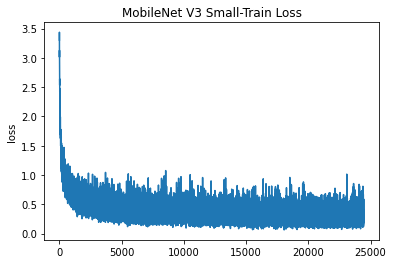

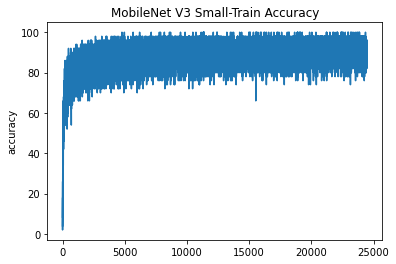

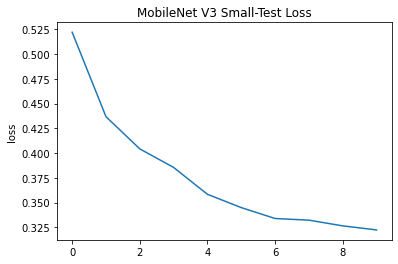

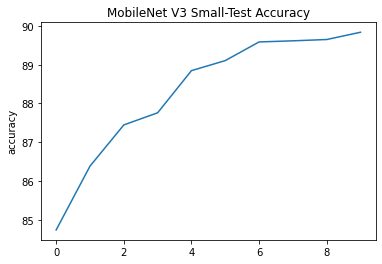

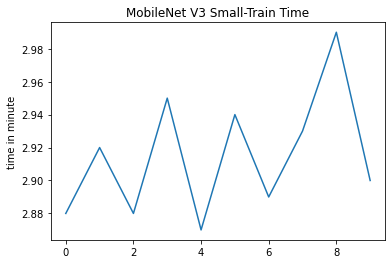

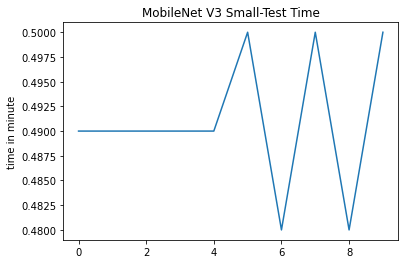

2.915
29.15


In [11]:
# Plot train_loss and train_accuracy
plt.plot(train_loss_tracker_1)
plt.title('MobileNet V3 Small-Train Loss')
plt.ylabel('loss')
plt.show()
plt.plot(train_accuracy_tracker_1)
plt.title('MobileNet V3 Small-Train Accuracy')
plt.ylabel('accuracy')
plt.show()
# Plot test_loss and test_accuracy
plt.plot(test_loss_tracker_1)
plt.title('MobileNet V3 Small-Test Loss')
plt.ylabel('loss')
plt.show()
plt.plot(test_accuracy_tracker_1)
plt.title('MobileNet V3 Small-Test Accuracy')
plt.ylabel('accuracy')
plt.show()
# Plot train time
train_time_tracker_in_minute_1 = []
for num in train_time_tracker_1:
    train_time_tracker_in_minute_1.append(round(num/60, 2))
plt.plot(train_time_tracker_in_minute_1)
plt.title('MobileNet V3 Small-Train Time')
plt.ylabel('time in minute')
plt.show()
# Plot test time
test_time_tracker_in_minute_1 = []
for num in test_time_tracker_1:
    test_time_tracker_in_minute_1.append(round(num/60, 2))
plt.plot(test_time_tracker_in_minute_1)
plt.title('MobileNet V3 Small-Test Time')
plt.ylabel('time in minute')
plt.show()

print(sum(train_time_tracker_in_minute_1)/10)
print(sum(train_time_tracker_in_minute_1))

In [12]:
epochs = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(squeezenet.parameters(), lr = learning_rate)

# Train and test SqueezeNet
model = squeezenet

train_loss_tracker = []
train_accuracy_tracker = []
train_time_tracker = []
test_loss_tracker = []
test_accuracy_tracker = []
test_time_tracker = []

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    train_start_time = time.time()
    train_loss,train_accuracy = Train(model,optimizer,emnist_train_loader,device)
    train_end_time = time.time()
    train_time_tracker.append(train_end_time-train_start_time)
    test_start_time = time.time()
    test_loss , test_accuracy = Test(model,emnist_test_loader,device)
    test_end_time = time.time()
    test_time_tracker.append(test_end_time-test_start_time)
    train_loss_tracker.extend(train_loss)
    train_accuracy_tracker.extend(train_accuracy)
    test_loss_tracker.append(test_loss)
    test_accuracy_tracker.append(test_accuracy)
    print('\t training loss/accuracy: {0:.2f}/{1:.2f}'.format(sum(train_loss)/len(train_loss), sum(train_accuracy)/len((train_accuracy))))
    print('\t testing loss/accuracy: {0:.2f}/{1:.2f}'.format(test_loss, test_accuracy))

Epoch: 0
step: 2, loss = 3.3887
step: 3, loss = 3.2777
step: 4, loss = 3.3292
step: 5, loss = 3.1668
step: 6, loss = 3.2268
step: 7, loss = 3.1366
step: 8, loss = 3.0985
step: 9, loss = 3.1441
step: 10, loss = 3.0630
step: 11, loss = 3.1080
step: 12, loss = 3.1611
step: 13, loss = 3.0366
step: 14, loss = 2.9617
step: 15, loss = 2.9861
step: 16, loss = 2.8777
step: 17, loss = 3.0023
step: 18, loss = 2.9685
step: 19, loss = 2.7521
step: 20, loss = 2.8304
step: 21, loss = 2.8829
step: 22, loss = 2.7874
step: 23, loss = 2.7856
step: 24, loss = 2.8557
step: 25, loss = 2.7268
step: 26, loss = 2.7368
step: 27, loss = 2.6853
step: 28, loss = 2.6635
step: 29, loss = 2.7043
step: 30, loss = 2.7231
step: 31, loss = 2.7133
step: 32, loss = 2.5980
step: 33, loss = 2.5869
step: 34, loss = 2.6575
step: 35, loss = 2.7916
step: 36, loss = 2.6115
step: 37, loss = 2.3505
step: 38, loss = 2.4585
step: 39, loss = 2.4826
step: 40, loss = 2.2399
step: 41, loss = 2.4801
step: 42, loss = 2.4982
step: 43, loss 

step: 342, loss = 1.1951
step: 343, loss = 0.9700
step: 344, loss = 1.1053
step: 345, loss = 0.9666
step: 346, loss = 0.7438
step: 347, loss = 0.8906
step: 348, loss = 0.9967
step: 349, loss = 0.9698
step: 350, loss = 0.8355
step: 352, loss = 0.9872
step: 353, loss = 0.8874
step: 354, loss = 0.8966
step: 355, loss = 0.7610
step: 356, loss = 1.0379
step: 357, loss = 1.1685
step: 358, loss = 1.1772
step: 359, loss = 1.3562
step: 360, loss = 1.1214
step: 361, loss = 0.9777
step: 362, loss = 1.1989
step: 363, loss = 1.1692
step: 364, loss = 1.0576
step: 365, loss = 0.9775
step: 366, loss = 0.9356
step: 367, loss = 0.8810
step: 368, loss = 1.0656
step: 369, loss = 0.8209
step: 370, loss = 0.8622
step: 371, loss = 1.0806
step: 372, loss = 0.9818
step: 373, loss = 1.0658
step: 374, loss = 0.8856
step: 375, loss = 0.8550
step: 376, loss = 0.9234
step: 377, loss = 0.9347
step: 378, loss = 0.9833
step: 379, loss = 1.1327
step: 380, loss = 0.8061
step: 381, loss = 0.9739
step: 382, loss = 1.0900


step: 679, loss = 0.7263
step: 680, loss = 0.7633
step: 681, loss = 0.6498
step: 682, loss = 0.9386
step: 683, loss = 0.7543
step: 684, loss = 0.6834
step: 685, loss = 0.7707
step: 686, loss = 0.9057
step: 687, loss = 0.9056
step: 688, loss = 0.7091
step: 689, loss = 0.5317
step: 690, loss = 0.7095
step: 691, loss = 0.8437
step: 692, loss = 0.7123
step: 693, loss = 0.8684
step: 694, loss = 0.7749
step: 695, loss = 0.6807
step: 696, loss = 0.8165
step: 697, loss = 0.6853
step: 698, loss = 0.5816
step: 699, loss = 0.8360
step: 700, loss = 0.9904
step: 702, loss = 0.7726
step: 703, loss = 0.6011
step: 704, loss = 0.5115
step: 705, loss = 0.6514
step: 706, loss = 0.7243
step: 707, loss = 0.9521
step: 708, loss = 0.6502
step: 709, loss = 0.6865
step: 710, loss = 0.9765
step: 711, loss = 0.8611
step: 712, loss = 0.5676
step: 713, loss = 0.7319
step: 714, loss = 0.8055
step: 715, loss = 0.8647
step: 716, loss = 0.7851
step: 717, loss = 1.0472
step: 718, loss = 0.8825
step: 719, loss = 0.7239


step: 1015, loss = 0.7842
step: 1016, loss = 0.5976
step: 1017, loss = 0.6723
step: 1018, loss = 0.7173
step: 1019, loss = 0.5590
step: 1020, loss = 0.6640
step: 1021, loss = 0.8356
step: 1022, loss = 0.7375
step: 1023, loss = 0.7532
step: 1024, loss = 0.7998
step: 1025, loss = 0.6191
step: 1026, loss = 0.7469
step: 1027, loss = 0.5793
step: 1028, loss = 0.7041
step: 1029, loss = 0.6691
step: 1030, loss = 0.7859
step: 1031, loss = 0.8080
step: 1032, loss = 0.7177
step: 1033, loss = 0.9316
step: 1034, loss = 0.7119
step: 1035, loss = 0.5908
step: 1036, loss = 0.5698
step: 1037, loss = 0.6562
step: 1038, loss = 0.7637
step: 1039, loss = 0.6291
step: 1040, loss = 0.6612
step: 1041, loss = 0.4653
step: 1042, loss = 0.6469
step: 1043, loss = 0.6937
step: 1044, loss = 0.5785
step: 1045, loss = 0.6485
step: 1046, loss = 0.8423
step: 1047, loss = 0.7355
step: 1048, loss = 0.5961
step: 1049, loss = 0.7443
step: 1050, loss = 0.6133
step: 1052, loss = 0.5999
step: 1053, loss = 0.6045
step: 1054, 

step: 1338, loss = 0.7821
step: 1339, loss = 0.6094
step: 1340, loss = 0.9365
step: 1341, loss = 0.6226
step: 1342, loss = 0.6020
step: 1343, loss = 0.8663
step: 1344, loss = 0.7181
step: 1345, loss = 0.3907
step: 1346, loss = 0.7210
step: 1347, loss = 0.5336
step: 1348, loss = 0.8167
step: 1349, loss = 0.5734
step: 1350, loss = 0.6191
step: 1352, loss = 0.7748
step: 1353, loss = 0.8310
step: 1354, loss = 0.6042
step: 1355, loss = 0.3642
step: 1356, loss = 0.6221
step: 1357, loss = 0.5284
step: 1358, loss = 0.5649
step: 1359, loss = 0.6843
step: 1360, loss = 1.0012
step: 1361, loss = 0.5878
step: 1362, loss = 0.5094
step: 1363, loss = 0.6541
step: 1364, loss = 0.7182
step: 1365, loss = 0.6142
step: 1366, loss = 0.7233
step: 1367, loss = 0.4878
step: 1368, loss = 0.7729
step: 1369, loss = 0.7423
step: 1370, loss = 0.7170
step: 1371, loss = 0.4786
step: 1372, loss = 0.5620
step: 1373, loss = 0.5753
step: 1374, loss = 0.4088
step: 1375, loss = 0.5640
step: 1376, loss = 0.7016
step: 1377, 

step: 1662, loss = 0.6078
step: 1663, loss = 0.7551
step: 1664, loss = 0.5046
step: 1665, loss = 0.4988
step: 1666, loss = 0.5279
step: 1667, loss = 0.5411
step: 1668, loss = 0.6195
step: 1669, loss = 0.6913
step: 1670, loss = 0.6287
step: 1671, loss = 0.5410
step: 1672, loss = 0.5463
step: 1673, loss = 0.7518
step: 1674, loss = 0.5652
step: 1675, loss = 0.6173
step: 1676, loss = 0.3747
step: 1677, loss = 0.5537
step: 1678, loss = 0.4399
step: 1679, loss = 0.5976
step: 1680, loss = 0.7602
step: 1681, loss = 0.5126
step: 1682, loss = 0.6118
step: 1683, loss = 0.6506
step: 1684, loss = 0.6761
step: 1685, loss = 0.7742
step: 1686, loss = 0.9123
step: 1687, loss = 0.5346
step: 1688, loss = 0.5823
step: 1689, loss = 0.6563
step: 1690, loss = 0.6080
step: 1691, loss = 0.5686
step: 1692, loss = 0.5226
step: 1693, loss = 0.3284
step: 1694, loss = 0.6699
step: 1695, loss = 0.6484
step: 1696, loss = 0.6073
step: 1697, loss = 0.6404
step: 1698, loss = 0.4951
step: 1699, loss = 0.5059
step: 1700, 

step: 1986, loss = 0.7004
step: 1987, loss = 0.4843
step: 1988, loss = 0.4819
step: 1989, loss = 0.5579
step: 1990, loss = 0.9443
step: 1991, loss = 0.5916
step: 1992, loss = 0.6315
step: 1993, loss = 0.4143
step: 1994, loss = 0.5229
step: 1995, loss = 0.4366
step: 1996, loss = 0.6776
step: 1997, loss = 0.4419
step: 1998, loss = 0.5261
step: 1999, loss = 0.4254
step: 2000, loss = 0.4497
step: 2002, loss = 0.5003
step: 2003, loss = 0.2547
step: 2004, loss = 0.4666
step: 2005, loss = 0.4450
step: 2006, loss = 0.5916
step: 2007, loss = 0.5947
step: 2008, loss = 0.5649
step: 2009, loss = 0.5239
step: 2010, loss = 0.3367
step: 2011, loss = 0.4300
step: 2012, loss = 0.4807
step: 2013, loss = 0.5331
step: 2014, loss = 0.5971
step: 2015, loss = 0.3233
step: 2016, loss = 0.6097
step: 2017, loss = 0.4190
step: 2018, loss = 0.6357
step: 2019, loss = 0.5212
step: 2020, loss = 0.4700
step: 2021, loss = 0.5768
step: 2022, loss = 0.8060
step: 2023, loss = 0.5185
step: 2024, loss = 0.4631
step: 2025, 

step: 2309, loss = 0.4158
step: 2310, loss = 0.4841
step: 2311, loss = 0.5477
step: 2312, loss = 0.3871
step: 2313, loss = 0.4527
step: 2314, loss = 0.7848
step: 2315, loss = 0.4397
step: 2316, loss = 0.3568
step: 2317, loss = 0.6170
step: 2318, loss = 0.4278
step: 2319, loss = 0.4694
step: 2320, loss = 0.6346
step: 2321, loss = 0.4788
step: 2322, loss = 0.4205
step: 2323, loss = 0.5536
step: 2324, loss = 0.6035
step: 2325, loss = 0.5369
step: 2326, loss = 0.4638
step: 2327, loss = 0.4170
step: 2328, loss = 0.4660
step: 2329, loss = 0.5349
step: 2330, loss = 0.4188
step: 2331, loss = 0.3870
step: 2332, loss = 0.5152
step: 2333, loss = 0.6123
step: 2334, loss = 0.4837
step: 2335, loss = 0.5907
step: 2336, loss = 0.5229
step: 2337, loss = 0.6264
step: 2338, loss = 0.5915
step: 2339, loss = 0.4476
step: 2340, loss = 0.4336
step: 2341, loss = 0.3886
step: 2342, loss = 0.5598
step: 2343, loss = 0.5137
step: 2344, loss = 0.3690
step: 2345, loss = 0.6013
step: 2346, loss = 0.5559
step: 2347, 

step: 142, loss = 0.3390
step: 143, loss = 0.6527
step: 144, loss = 0.6377
step: 145, loss = 0.7302
step: 146, loss = 0.6846
step: 147, loss = 0.5195
step: 148, loss = 0.4245
step: 149, loss = 0.5867
step: 150, loss = 0.3157
step: 152, loss = 0.3842
step: 153, loss = 0.3624
step: 154, loss = 0.6364
step: 155, loss = 0.4691
step: 156, loss = 0.5187
step: 157, loss = 0.3414
step: 158, loss = 0.5996
step: 159, loss = 0.3756
step: 160, loss = 0.3854
step: 161, loss = 0.5398
step: 162, loss = 0.5301
step: 163, loss = 0.3299
step: 164, loss = 0.5810
step: 165, loss = 0.3281
step: 166, loss = 0.3814
step: 167, loss = 0.5279
step: 168, loss = 0.4586
step: 169, loss = 0.5182
step: 170, loss = 0.5692
step: 171, loss = 0.4446
step: 172, loss = 0.3977
step: 173, loss = 0.7280
step: 174, loss = 0.4466
step: 175, loss = 0.4391
step: 176, loss = 0.3293
step: 177, loss = 0.6766
step: 178, loss = 0.2440
step: 179, loss = 0.4776
step: 180, loss = 0.3851
step: 181, loss = 0.5959
step: 182, loss = 0.4488


step: 479, loss = 0.3542
step: 480, loss = 0.4611
step: 481, loss = 0.4315
step: 482, loss = 0.6647
step: 483, loss = 0.5202
step: 484, loss = 0.3347
step: 485, loss = 0.4229
step: 486, loss = 0.5516
step: 487, loss = 0.7706
step: 488, loss = 0.3850
step: 489, loss = 0.5237
step: 490, loss = 0.3986
step: 491, loss = 0.3972
step: 492, loss = 0.3273
step: 493, loss = 0.5836
step: 494, loss = 0.3514
step: 495, loss = 0.5480
step: 496, loss = 0.4789
step: 497, loss = 0.4051
step: 498, loss = 0.3378
step: 499, loss = 0.3730
step: 500, loss = 0.2854
step: 502, loss = 0.4406
step: 503, loss = 0.3714
step: 504, loss = 0.4693
step: 505, loss = 0.5054
step: 506, loss = 0.5530
step: 507, loss = 0.5936
step: 508, loss = 0.6176
step: 509, loss = 0.4525
step: 510, loss = 0.4855
step: 511, loss = 0.6456
step: 512, loss = 0.4210
step: 513, loss = 0.5879
step: 514, loss = 0.3778
step: 515, loss = 0.5243
step: 516, loss = 0.3928
step: 517, loss = 0.6592
step: 518, loss = 0.4321
step: 519, loss = 0.6054


step: 815, loss = 0.2606
step: 816, loss = 0.5748
step: 817, loss = 0.4173
step: 818, loss = 0.4740
step: 819, loss = 0.7184
step: 820, loss = 0.4232
step: 821, loss = 0.4539
step: 822, loss = 0.4622
step: 823, loss = 0.4083
step: 824, loss = 0.3939
step: 825, loss = 0.4664
step: 826, loss = 0.2620
step: 827, loss = 0.5795
step: 828, loss = 0.3821
step: 829, loss = 0.4416
step: 830, loss = 0.5538
step: 831, loss = 0.4684
step: 832, loss = 0.6230
step: 833, loss = 0.3856
step: 834, loss = 0.7644
step: 835, loss = 0.5618
step: 836, loss = 0.4694
step: 837, loss = 0.3310
step: 838, loss = 0.5874
step: 839, loss = 0.4492
step: 840, loss = 0.4150
step: 841, loss = 0.5189
step: 842, loss = 0.5355
step: 843, loss = 0.3803
step: 844, loss = 0.4089
step: 845, loss = 0.9290
step: 846, loss = 0.7571
step: 847, loss = 0.4802
step: 848, loss = 0.5510
step: 849, loss = 0.4154
step: 850, loss = 0.5520
step: 852, loss = 0.8177
step: 853, loss = 0.4273
step: 854, loss = 0.3365
step: 855, loss = 0.3435


step: 1145, loss = 0.3529
step: 1146, loss = 0.3494
step: 1147, loss = 0.3241
step: 1148, loss = 0.5442
step: 1149, loss = 0.5269
step: 1150, loss = 0.4626
step: 1152, loss = 0.5237
step: 1153, loss = 0.5836
step: 1154, loss = 0.4724
step: 1155, loss = 0.2811
step: 1156, loss = 0.5513
step: 1157, loss = 0.3353
step: 1158, loss = 0.5070
step: 1159, loss = 0.5532
step: 1160, loss = 0.3960
step: 1161, loss = 0.4198
step: 1162, loss = 0.3401
step: 1163, loss = 0.4271
step: 1164, loss = 0.7415
step: 1165, loss = 0.3424
step: 1166, loss = 0.3257
step: 1167, loss = 0.5730
step: 1168, loss = 0.5090
step: 1169, loss = 0.3968
step: 1170, loss = 0.4252
step: 1171, loss = 0.5477
step: 1172, loss = 0.3523
step: 1173, loss = 0.4774
step: 1174, loss = 0.6089
step: 1175, loss = 0.3391
step: 1176, loss = 0.4073
step: 1177, loss = 0.6003
step: 1178, loss = 0.4343
step: 1179, loss = 0.5151
step: 1180, loss = 0.6533
step: 1181, loss = 0.5074
step: 1182, loss = 0.4443
step: 1183, loss = 0.4073
step: 1184, 

step: 1470, loss = 0.2884
step: 1471, loss = 0.2920
step: 1472, loss = 0.5005
step: 1473, loss = 0.3514
step: 1474, loss = 0.4739
step: 1475, loss = 0.3702
step: 1476, loss = 0.3419
step: 1477, loss = 0.3743
step: 1478, loss = 0.4621
step: 1479, loss = 0.3763
step: 1480, loss = 0.6008
step: 1481, loss = 0.2797
step: 1482, loss = 0.5894
step: 1483, loss = 0.3085
step: 1484, loss = 0.3969
step: 1485, loss = 0.4538
step: 1486, loss = 0.4804
step: 1487, loss = 0.4509
step: 1488, loss = 0.5678
step: 1489, loss = 0.4487
step: 1490, loss = 0.6512
step: 1491, loss = 0.4259
step: 1492, loss = 0.4890
step: 1493, loss = 0.6662
step: 1494, loss = 0.4648
step: 1495, loss = 0.3596
step: 1496, loss = 0.3609
step: 1497, loss = 0.4649
step: 1498, loss = 0.5991
step: 1499, loss = 0.4701
step: 1500, loss = 0.3685
step: 1502, loss = 0.4025
step: 1503, loss = 0.6425
step: 1504, loss = 0.5508
step: 1505, loss = 0.3870
step: 1506, loss = 0.4273
step: 1507, loss = 0.3356
step: 1508, loss = 0.7069
step: 1509, 

step: 1794, loss = 0.2666
step: 1795, loss = 0.4184
step: 1796, loss = 0.3860
step: 1797, loss = 0.4773
step: 1798, loss = 0.4841
step: 1799, loss = 0.4991
step: 1800, loss = 0.5868
step: 1802, loss = 0.3414
step: 1803, loss = 0.4050
step: 1804, loss = 0.4903
step: 1805, loss = 0.4350
step: 1806, loss = 0.3544
step: 1807, loss = 0.5890
step: 1808, loss = 0.2907
step: 1809, loss = 0.5493
step: 1810, loss = 0.5833
step: 1811, loss = 0.5507
step: 1812, loss = 0.5916
step: 1813, loss = 0.3561
step: 1814, loss = 0.4184
step: 1815, loss = 0.2951
step: 1816, loss = 0.4406
step: 1817, loss = 0.2664
step: 1818, loss = 0.2507
step: 1819, loss = 0.3782
step: 1820, loss = 0.4855
step: 1821, loss = 0.5936
step: 1822, loss = 0.4121
step: 1823, loss = 0.6299
step: 1824, loss = 0.3695
step: 1825, loss = 0.4410
step: 1826, loss = 0.2664
step: 1827, loss = 0.2282
step: 1828, loss = 0.4061
step: 1829, loss = 0.4194
step: 1830, loss = 0.2024
step: 1831, loss = 0.5423
step: 1832, loss = 0.5860
step: 1833, 

step: 2117, loss = 0.4457
step: 2118, loss = 0.5038
step: 2119, loss = 0.4201
step: 2120, loss = 0.7313
step: 2121, loss = 0.3217
step: 2122, loss = 0.6101
step: 2123, loss = 0.4860
step: 2124, loss = 0.5312
step: 2125, loss = 0.4818
step: 2126, loss = 0.2753
step: 2127, loss = 0.4571
step: 2128, loss = 0.2937
step: 2129, loss = 0.4401
step: 2130, loss = 0.3502
step: 2131, loss = 0.5198
step: 2132, loss = 1.0580
step: 2133, loss = 0.4215
step: 2134, loss = 0.2828
step: 2135, loss = 0.4793
step: 2136, loss = 0.4048
step: 2137, loss = 0.3164
step: 2138, loss = 0.5012
step: 2139, loss = 0.4344
step: 2140, loss = 0.4430
step: 2141, loss = 0.2691
step: 2142, loss = 0.6056
step: 2143, loss = 0.7873
step: 2144, loss = 0.4919
step: 2145, loss = 0.3138
step: 2146, loss = 0.3138
step: 2147, loss = 0.4663
step: 2148, loss = 0.3776
step: 2149, loss = 0.3795
step: 2150, loss = 0.4937
step: 2152, loss = 0.5835
step: 2153, loss = 0.5573
step: 2154, loss = 0.4131
step: 2155, loss = 0.5374
step: 2156, 

step: 2441, loss = 0.3863
step: 2442, loss = 0.3113
step: 2443, loss = 0.3331
step: 2444, loss = 0.4331
step: 2445, loss = 0.5419
step: 2446, loss = 0.4436
step: 2447, loss = 0.4765
step: 2448, loss = 0.5471
step: 2449, loss = 0.2729
step: 2450, loss = 0.7746
step: 2452, loss = 0.3480
step: 2453, loss = 0.5499
step: 2454, loss = 0.6095
step: 2455, loss = 0.5715
step: 2456, loss = 0.5456
step: 2457, loss = 0.4419
step: 2458, loss = 0.3825
step: 2459, loss = 0.3387
step: 2460, loss = 0.3412
step: 2461, loss = 0.2925
step: 2462, loss = 0.4604
step: 2463, loss = 0.3382
step: 2464, loss = 0.3432
step: 2465, loss = 0.5658
step: 2466, loss = 0.4056
step: 2467, loss = 0.3328
step: 2468, loss = 0.2214
step: 2469, loss = 0.4067
step: 2470, loss = 0.4443
step: 2471, loss = 0.3485
step: 2472, loss = 0.3847
step: 2473, loss = 0.3142
step: 2474, loss = 0.3664
step: 2475, loss = 0.3033
step: 2476, loss = 0.3812
step: 2477, loss = 0.2833
step: 2478, loss = 0.4017
step: 2479, loss = 0.6710
step: 2480, 

step: 279, loss = 0.3795
step: 280, loss = 0.5098
step: 281, loss = 0.4032
step: 282, loss = 0.3279
step: 283, loss = 0.6202
step: 284, loss = 0.4106
step: 285, loss = 0.3729
step: 286, loss = 0.2770
step: 287, loss = 0.4330
step: 288, loss = 0.3432
step: 289, loss = 0.5672
step: 290, loss = 0.2958
step: 291, loss = 0.4026
step: 292, loss = 0.7858
step: 293, loss = 0.5272
step: 294, loss = 0.4156
step: 295, loss = 0.4238
step: 296, loss = 0.5981
step: 297, loss = 0.4162
step: 298, loss = 0.4431
step: 299, loss = 0.5071
step: 300, loss = 0.5397
step: 302, loss = 0.3098
step: 303, loss = 0.2831
step: 304, loss = 0.3039
step: 305, loss = 0.5492
step: 306, loss = 0.3369
step: 307, loss = 0.4441
step: 308, loss = 0.2316
step: 309, loss = 0.4382
step: 310, loss = 0.2255
step: 311, loss = 0.1939
step: 312, loss = 0.4455
step: 313, loss = 0.1971
step: 314, loss = 0.3373
step: 315, loss = 0.2050
step: 316, loss = 0.3815
step: 317, loss = 0.3185
step: 318, loss = 0.5000
step: 319, loss = 0.3838


step: 615, loss = 0.6611
step: 616, loss = 0.3120
step: 617, loss = 0.6052
step: 618, loss = 0.4850
step: 619, loss = 0.4634
step: 620, loss = 0.3165
step: 621, loss = 0.2679
step: 622, loss = 0.2877
step: 623, loss = 0.3566
step: 624, loss = 0.3644
step: 625, loss = 0.7773
step: 626, loss = 0.2822
step: 627, loss = 0.5378
step: 628, loss = 0.4835
step: 629, loss = 0.4013
step: 630, loss = 0.4558
step: 631, loss = 0.4536
step: 632, loss = 0.2669
step: 633, loss = 0.1688
step: 634, loss = 0.3421
step: 635, loss = 0.5289
step: 636, loss = 0.5129
step: 637, loss = 0.3707
step: 638, loss = 0.4575
step: 639, loss = 0.4060
step: 640, loss = 0.5308
step: 641, loss = 0.6167
step: 642, loss = 0.3062
step: 643, loss = 0.6006
step: 644, loss = 0.4873
step: 645, loss = 0.4543
step: 646, loss = 0.3662
step: 647, loss = 0.4853
step: 648, loss = 0.4468
step: 649, loss = 0.4277
step: 650, loss = 0.4012
step: 652, loss = 0.3944
step: 653, loss = 0.2829
step: 654, loss = 0.3956
step: 655, loss = 0.1840


step: 952, loss = 0.5811
step: 953, loss = 0.7651
step: 954, loss = 0.4754
step: 955, loss = 0.5028
step: 956, loss = 0.4672
step: 957, loss = 0.6983
step: 958, loss = 0.5204
step: 959, loss = 0.3633
step: 960, loss = 0.4086
step: 961, loss = 0.2723
step: 962, loss = 0.3115
step: 963, loss = 0.1453
step: 964, loss = 0.4344
step: 965, loss = 0.3745
step: 966, loss = 0.4001
step: 967, loss = 0.2879
step: 968, loss = 0.4643
step: 969, loss = 0.4680
step: 970, loss = 0.2430
step: 971, loss = 0.5544
step: 972, loss = 0.3791
step: 973, loss = 0.3219
step: 974, loss = 0.2625
step: 975, loss = 0.5437
step: 976, loss = 0.4577
step: 977, loss = 0.8861
step: 978, loss = 0.2711
step: 979, loss = 0.1655
step: 980, loss = 0.3236
step: 981, loss = 0.4090
step: 982, loss = 0.3413
step: 983, loss = 0.2833
step: 984, loss = 0.5109
step: 985, loss = 0.3588
step: 986, loss = 0.4709
step: 987, loss = 0.4020
step: 988, loss = 0.5645
step: 989, loss = 0.4466
step: 990, loss = 0.2505
step: 991, loss = 0.3430


step: 1276, loss = 0.2521
step: 1277, loss = 0.3260
step: 1278, loss = 0.4360
step: 1279, loss = 0.4205
step: 1280, loss = 0.3112
step: 1281, loss = 0.2981
step: 1282, loss = 0.2866
step: 1283, loss = 0.5239
step: 1284, loss = 0.3426
step: 1285, loss = 0.4988
step: 1286, loss = 0.5478
step: 1287, loss = 0.4750
step: 1288, loss = 0.2634
step: 1289, loss = 0.3440
step: 1290, loss = 0.3527
step: 1291, loss = 0.4489
step: 1292, loss = 0.5971
step: 1293, loss = 0.3341
step: 1294, loss = 0.5174
step: 1295, loss = 0.3552
step: 1296, loss = 0.4844
step: 1297, loss = 0.5789
step: 1298, loss = 0.4741
step: 1299, loss = 0.2370
step: 1300, loss = 0.4730
step: 1302, loss = 0.7137
step: 1303, loss = 0.4377
step: 1304, loss = 0.1734
step: 1305, loss = 0.3655
step: 1306, loss = 0.3290
step: 1307, loss = 0.4324
step: 1308, loss = 0.4394
step: 1309, loss = 0.6918
step: 1310, loss = 0.5495
step: 1311, loss = 0.2848
step: 1312, loss = 0.4217
step: 1313, loss = 0.3584
step: 1314, loss = 0.3028
step: 1315, 

step: 1600, loss = 0.4121
step: 1602, loss = 0.3282
step: 1603, loss = 0.2772
step: 1604, loss = 0.4248
step: 1605, loss = 0.4164
step: 1606, loss = 0.7129
step: 1607, loss = 0.3443
step: 1608, loss = 0.3909
step: 1609, loss = 0.3273
step: 1610, loss = 0.5927
step: 1611, loss = 0.5130
step: 1612, loss = 0.3875
step: 1613, loss = 0.3632
step: 1614, loss = 0.4925
step: 1615, loss = 0.3024
step: 1616, loss = 0.4448
step: 1617, loss = 0.4204
step: 1618, loss = 0.5064
step: 1619, loss = 0.3731
step: 1620, loss = 0.3650
step: 1621, loss = 0.3849
step: 1622, loss = 0.3326
step: 1623, loss = 0.2959
step: 1624, loss = 0.5977
step: 1625, loss = 0.4415
step: 1626, loss = 0.3766
step: 1627, loss = 0.4812
step: 1628, loss = 0.2438
step: 1629, loss = 0.3119
step: 1630, loss = 0.2643
step: 1631, loss = 0.2873
step: 1632, loss = 0.2348
step: 1633, loss = 0.2581
step: 1634, loss = 0.5672
step: 1635, loss = 0.2075
step: 1636, loss = 0.3884
step: 1637, loss = 0.3441
step: 1638, loss = 0.5478
step: 1639, 

step: 1923, loss = 0.2358
step: 1924, loss = 0.3464
step: 1925, loss = 0.3092
step: 1926, loss = 0.5809
step: 1927, loss = 0.6789
step: 1928, loss = 0.2962
step: 1929, loss = 0.3144
step: 1930, loss = 0.3680
step: 1931, loss = 0.4359
step: 1932, loss = 0.3076
step: 1933, loss = 0.5130
step: 1934, loss = 0.2135
step: 1935, loss = 0.3358
step: 1936, loss = 0.3584
step: 1937, loss = 0.1640
step: 1938, loss = 0.5980
step: 1939, loss = 0.3619
step: 1940, loss = 0.4266
step: 1941, loss = 0.3673
step: 1942, loss = 0.2624
step: 1943, loss = 0.7118
step: 1944, loss = 0.5803
step: 1945, loss = 0.2944
step: 1946, loss = 0.3298
step: 1947, loss = 0.3154
step: 1948, loss = 0.4091
step: 1949, loss = 0.3593
step: 1950, loss = 0.4907
step: 1952, loss = 0.4166
step: 1953, loss = 0.3804
step: 1954, loss = 0.2323
step: 1955, loss = 0.3806
step: 1956, loss = 0.3371
step: 1957, loss = 0.3764
step: 1958, loss = 0.3629
step: 1959, loss = 0.3267
step: 1960, loss = 0.3509
step: 1961, loss = 0.2902
step: 1962, 

step: 2247, loss = 0.4800
step: 2248, loss = 0.3917
step: 2249, loss = 0.5159
step: 2250, loss = 0.4700
step: 2252, loss = 0.4423
step: 2253, loss = 0.4950
step: 2254, loss = 0.6996
step: 2255, loss = 0.4687
step: 2256, loss = 0.4094
step: 2257, loss = 0.4497
step: 2258, loss = 0.4358
step: 2259, loss = 0.4209
step: 2260, loss = 0.2603
step: 2261, loss = 0.2239
step: 2262, loss = 0.3628
step: 2263, loss = 0.2156
step: 2264, loss = 0.3218
step: 2265, loss = 0.4130
step: 2266, loss = 0.4603
step: 2267, loss = 0.4333
step: 2268, loss = 0.3763
step: 2269, loss = 0.2325
step: 2270, loss = 0.6689
step: 2271, loss = 0.2391
step: 2272, loss = 0.3383
step: 2273, loss = 0.7108
step: 2274, loss = 0.4375
step: 2275, loss = 0.4608
step: 2276, loss = 0.3445
step: 2277, loss = 0.2583
step: 2278, loss = 0.6080
step: 2279, loss = 0.3168
step: 2280, loss = 0.4700
step: 2281, loss = 0.4901
step: 2282, loss = 0.2871
step: 2283, loss = 0.3462
step: 2284, loss = 0.3913
step: 2285, loss = 0.1984
step: 2286, 

step: 76, loss = 0.4319
step: 77, loss = 0.3084
step: 78, loss = 0.6231
step: 79, loss = 0.2790
step: 80, loss = 0.5647
step: 81, loss = 0.2175
step: 82, loss = 0.4475
step: 83, loss = 0.6267
step: 84, loss = 0.2198
step: 85, loss = 0.2748
step: 86, loss = 0.3690
step: 87, loss = 0.2512
step: 88, loss = 0.3142
step: 89, loss = 0.4347
step: 90, loss = 0.5524
step: 91, loss = 0.4352
step: 92, loss = 0.3208
step: 93, loss = 0.4125
step: 94, loss = 0.2561
step: 95, loss = 0.3477
step: 96, loss = 0.4348
step: 97, loss = 0.3412
step: 98, loss = 0.4365
step: 99, loss = 0.2351
step: 100, loss = 0.3602
step: 102, loss = 0.3844
step: 103, loss = 0.3574
step: 104, loss = 0.2278
step: 105, loss = 0.1697
step: 106, loss = 0.5133
step: 107, loss = 0.3485
step: 108, loss = 0.3326
step: 109, loss = 0.2964
step: 110, loss = 0.6430
step: 111, loss = 0.3937
step: 112, loss = 0.4347
step: 113, loss = 0.3116
step: 114, loss = 0.3393
step: 115, loss = 0.6535
step: 116, loss = 0.4713
step: 117, loss = 0.3361

step: 414, loss = 0.6439
step: 415, loss = 0.2404
step: 416, loss = 0.3082
step: 417, loss = 0.3218
step: 418, loss = 0.2756
step: 419, loss = 0.1556
step: 420, loss = 0.5105
step: 421, loss = 0.3181
step: 422, loss = 0.2687
step: 423, loss = 0.8216
step: 424, loss = 0.2122
step: 425, loss = 0.3839
step: 426, loss = 0.3830
step: 427, loss = 0.3182
step: 428, loss = 0.4707
step: 429, loss = 0.3644
step: 430, loss = 0.4615
step: 431, loss = 0.3794
step: 432, loss = 0.3874
step: 433, loss = 0.6373
step: 434, loss = 0.7591
step: 435, loss = 0.5149
step: 436, loss = 0.3466
step: 437, loss = 0.2316
step: 438, loss = 0.4037
step: 439, loss = 0.3831
step: 440, loss = 0.3275
step: 441, loss = 0.4910
step: 442, loss = 0.2756
step: 443, loss = 0.3491
step: 444, loss = 0.4270
step: 445, loss = 0.3275
step: 446, loss = 0.4636
step: 447, loss = 0.4687
step: 448, loss = 0.2895
step: 449, loss = 0.3144
step: 450, loss = 0.3367
step: 452, loss = 0.4783
step: 453, loss = 0.3857
step: 454, loss = 0.2906


step: 749, loss = 0.4776
step: 750, loss = 0.3823
step: 752, loss = 0.4789
step: 753, loss = 0.4168
step: 754, loss = 0.3354
step: 755, loss = 0.3830
step: 756, loss = 0.2522
step: 757, loss = 0.2167
step: 758, loss = 0.2467
step: 759, loss = 0.3034
step: 760, loss = 0.4118
step: 761, loss = 0.2749
step: 762, loss = 0.3633
step: 763, loss = 0.4405
step: 764, loss = 0.2342
step: 765, loss = 0.3442
step: 766, loss = 0.4696
step: 767, loss = 0.3979
step: 768, loss = 0.4548
step: 769, loss = 0.2535
step: 770, loss = 0.1756
step: 771, loss = 0.2013
step: 772, loss = 0.4437
step: 773, loss = 0.4176
step: 774, loss = 0.3872
step: 775, loss = 0.7984
step: 776, loss = 0.5859
step: 777, loss = 0.1961
step: 778, loss = 0.3282
step: 779, loss = 0.5359
step: 780, loss = 0.3709
step: 781, loss = 0.5161
step: 782, loss = 0.4609
step: 783, loss = 0.4155
step: 784, loss = 0.3178
step: 785, loss = 0.2598
step: 786, loss = 0.3512
step: 787, loss = 0.1552
step: 788, loss = 0.5324
step: 789, loss = 0.4580


step: 1082, loss = 0.3311
step: 1083, loss = 0.3695
step: 1084, loss = 0.3257
step: 1085, loss = 0.3083
step: 1086, loss = 0.3996
step: 1087, loss = 0.3263
step: 1088, loss = 0.3070
step: 1089, loss = 0.3200
step: 1090, loss = 0.3924
step: 1091, loss = 0.4104
step: 1092, loss = 0.3750
step: 1093, loss = 0.2825
step: 1094, loss = 0.2565
step: 1095, loss = 0.5988
step: 1096, loss = 0.3155
step: 1097, loss = 0.2635
step: 1098, loss = 0.2054
step: 1099, loss = 0.3981
step: 1100, loss = 0.3466
step: 1102, loss = 0.2646
step: 1103, loss = 0.4803
step: 1104, loss = 0.2440
step: 1105, loss = 0.4246
step: 1106, loss = 0.4077
step: 1107, loss = 0.1801
step: 1108, loss = 0.5715
step: 1109, loss = 0.1392
step: 1110, loss = 0.3095
step: 1111, loss = 0.3437
step: 1112, loss = 0.2977
step: 1113, loss = 0.3485
step: 1114, loss = 0.2107
step: 1115, loss = 0.4230
step: 1116, loss = 0.3936
step: 1117, loss = 0.5125
step: 1118, loss = 0.3148
step: 1119, loss = 0.2906
step: 1120, loss = 0.4415
step: 1121, 

step: 1406, loss = 0.3779
step: 1407, loss = 0.3823
step: 1408, loss = 0.6580
step: 1409, loss = 0.6842
step: 1410, loss = 0.3423
step: 1411, loss = 0.1872
step: 1412, loss = 0.3467
step: 1413, loss = 0.2163
step: 1414, loss = 0.2897
step: 1415, loss = 0.3178
step: 1416, loss = 0.4040
step: 1417, loss = 0.4227
step: 1418, loss = 0.4032
step: 1419, loss = 0.1451
step: 1420, loss = 0.2276
step: 1421, loss = 0.4830
step: 1422, loss = 0.4182
step: 1423, loss = 0.3237
step: 1424, loss = 0.2837
step: 1425, loss = 0.5178
step: 1426, loss = 0.4749
step: 1427, loss = 0.3262
step: 1428, loss = 0.2263
step: 1429, loss = 0.4329
step: 1430, loss = 0.8425
step: 1431, loss = 0.2120
step: 1432, loss = 0.3818
step: 1433, loss = 0.3762
step: 1434, loss = 0.5574
step: 1435, loss = 0.2649
step: 1436, loss = 0.4500
step: 1437, loss = 0.3625
step: 1438, loss = 0.5438
step: 1439, loss = 0.5232
step: 1440, loss = 0.4054
step: 1441, loss = 0.2832
step: 1442, loss = 0.2640
step: 1443, loss = 0.4742
step: 1444, 

step: 1730, loss = 0.5037
step: 1731, loss = 0.2374
step: 1732, loss = 0.2206
step: 1733, loss = 0.1890
step: 1734, loss = 0.3429
step: 1735, loss = 0.3722
step: 1736, loss = 0.4260
step: 1737, loss = 0.3958
step: 1738, loss = 0.1122
step: 1739, loss = 0.4648
step: 1740, loss = 0.3180
step: 1741, loss = 0.3568
step: 1742, loss = 0.3633
step: 1743, loss = 0.3102
step: 1744, loss = 0.6201
step: 1745, loss = 0.4420
step: 1746, loss = 0.2516
step: 1747, loss = 0.8376
step: 1748, loss = 0.2451
step: 1749, loss = 0.4592
step: 1750, loss = 0.2908
step: 1752, loss = 0.3665
step: 1753, loss = 0.2473
step: 1754, loss = 0.5616
step: 1755, loss = 0.2742
step: 1756, loss = 0.2907
step: 1757, loss = 0.4067
step: 1758, loss = 0.3179
step: 1759, loss = 0.4571
step: 1760, loss = 0.3530
step: 1761, loss = 0.3883
step: 1762, loss = 0.4931
step: 1763, loss = 0.3012
step: 1764, loss = 0.1881
step: 1765, loss = 0.5659
step: 1766, loss = 0.3875
step: 1767, loss = 0.2857
step: 1768, loss = 0.3358
step: 1769, 

step: 2055, loss = 0.2214
step: 2056, loss = 0.4415
step: 2057, loss = 0.4235
step: 2058, loss = 0.4913
step: 2059, loss = 0.2388
step: 2060, loss = 0.2986
step: 2061, loss = 0.3964
step: 2062, loss = 0.2408
step: 2063, loss = 0.4057
step: 2064, loss = 0.3519
step: 2065, loss = 0.3754
step: 2066, loss = 0.8714
step: 2067, loss = 0.1861
step: 2068, loss = 0.7364
step: 2069, loss = 0.2471
step: 2070, loss = 0.4999
step: 2071, loss = 0.3064
step: 2072, loss = 0.1649
step: 2073, loss = 0.3585
step: 2074, loss = 0.2680
step: 2075, loss = 0.3119
step: 2076, loss = 0.3986
step: 2077, loss = 0.3420
step: 2078, loss = 0.4569
step: 2079, loss = 0.3072
step: 2080, loss = 0.4109
step: 2081, loss = 0.4332
step: 2082, loss = 0.3353
step: 2083, loss = 0.3025
step: 2084, loss = 0.4201
step: 2085, loss = 0.3069
step: 2086, loss = 0.4938
step: 2087, loss = 0.5325
step: 2088, loss = 0.5106
step: 2089, loss = 0.3679
step: 2090, loss = 0.5013
step: 2091, loss = 0.4269
step: 2092, loss = 0.1992
step: 2093, 

step: 2379, loss = 0.2327
step: 2380, loss = 0.2078
step: 2381, loss = 0.3647
step: 2382, loss = 0.3323
step: 2383, loss = 0.3901
step: 2384, loss = 0.3036
step: 2385, loss = 0.2306
step: 2386, loss = 0.2949
step: 2387, loss = 0.4437
step: 2388, loss = 0.3533
step: 2389, loss = 0.8934
step: 2390, loss = 0.5027
step: 2391, loss = 0.3613
step: 2392, loss = 0.1765
step: 2393, loss = 0.4792
step: 2394, loss = 0.5595
step: 2395, loss = 0.3083
step: 2396, loss = 0.3665
step: 2397, loss = 0.2333
step: 2398, loss = 0.4059
step: 2399, loss = 0.2825
step: 2400, loss = 0.2385
step: 2402, loss = 0.2767
step: 2403, loss = 0.1682
step: 2404, loss = 0.3521
step: 2405, loss = 0.3038
step: 2406, loss = 0.2617
step: 2407, loss = 0.4782
step: 2408, loss = 0.4195
step: 2409, loss = 0.4173
step: 2410, loss = 0.4246
step: 2411, loss = 0.1779
step: 2412, loss = 0.2990
step: 2413, loss = 0.3191
step: 2414, loss = 0.4237
step: 2415, loss = 0.2846
step: 2416, loss = 0.3607
step: 2417, loss = 0.2739
step: 2418, 

step: 215, loss = 0.4568
step: 216, loss = 0.3634
step: 217, loss = 0.2662
step: 218, loss = 0.3751
step: 219, loss = 0.3049
step: 220, loss = 0.3602
step: 221, loss = 0.4110
step: 222, loss = 0.1748
step: 223, loss = 0.2112
step: 224, loss = 0.3384
step: 225, loss = 0.3668
step: 226, loss = 0.4225
step: 227, loss = 0.2914
step: 228, loss = 0.3585
step: 229, loss = 0.3088
step: 230, loss = 0.3301
step: 231, loss = 0.4107
step: 232, loss = 0.1806
step: 233, loss = 0.4681
step: 234, loss = 0.3427
step: 235, loss = 0.3541
step: 236, loss = 0.2656
step: 237, loss = 0.3530
step: 238, loss = 0.3908
step: 239, loss = 0.2454
step: 240, loss = 0.5592
step: 241, loss = 0.3210
step: 242, loss = 0.4588
step: 243, loss = 0.2524
step: 244, loss = 0.2811
step: 245, loss = 0.3528
step: 246, loss = 0.2742
step: 247, loss = 0.3604
step: 248, loss = 0.3231
step: 249, loss = 0.2999
step: 250, loss = 0.4140
step: 252, loss = 0.3362
step: 253, loss = 0.5257
step: 254, loss = 0.2139
step: 255, loss = 0.4181


step: 550, loss = 0.2533
step: 552, loss = 0.5527
step: 553, loss = 0.5468
step: 554, loss = 0.2470
step: 555, loss = 0.5391
step: 556, loss = 0.3214
step: 557, loss = 0.5764
step: 558, loss = 0.5394
step: 559, loss = 0.2683
step: 560, loss = 0.4484
step: 561, loss = 0.4828
step: 562, loss = 0.3903
step: 563, loss = 0.3448
step: 564, loss = 0.3672
step: 565, loss = 0.3798
step: 566, loss = 0.4385
step: 567, loss = 0.3587
step: 568, loss = 0.3450
step: 569, loss = 0.6639
step: 570, loss = 0.5226
step: 571, loss = 0.2003
step: 572, loss = 0.5931
step: 573, loss = 0.3692
step: 574, loss = 0.2791
step: 575, loss = 0.2542
step: 576, loss = 0.4844
step: 577, loss = 0.3682
step: 578, loss = 0.4809
step: 579, loss = 0.4129
step: 580, loss = 0.2275
step: 581, loss = 0.5825
step: 582, loss = 0.5651
step: 583, loss = 0.5753
step: 584, loss = 0.4145
step: 585, loss = 0.5353
step: 586, loss = 0.2743
step: 587, loss = 0.3779
step: 588, loss = 0.4574
step: 589, loss = 0.4410
step: 590, loss = 0.1987


step: 886, loss = 0.2186
step: 887, loss = 0.4581
step: 888, loss = 0.4390
step: 889, loss = 0.2308
step: 890, loss = 0.5934
step: 891, loss = 0.3777
step: 892, loss = 0.2677
step: 893, loss = 0.3990
step: 894, loss = 0.4290
step: 895, loss = 0.3829
step: 896, loss = 0.2954
step: 897, loss = 0.4016
step: 898, loss = 0.2589
step: 899, loss = 0.4473
step: 900, loss = 0.5229
step: 902, loss = 0.3502
step: 903, loss = 0.3664
step: 904, loss = 0.4378
step: 905, loss = 0.4456
step: 906, loss = 0.3734
step: 907, loss = 0.3285
step: 908, loss = 0.4008
step: 909, loss = 0.2626
step: 910, loss = 0.6862
step: 911, loss = 0.4550
step: 912, loss = 0.2493
step: 913, loss = 0.3932
step: 914, loss = 0.3469
step: 915, loss = 0.3258
step: 916, loss = 0.2543
step: 917, loss = 0.3474
step: 918, loss = 0.3585
step: 919, loss = 0.3235
step: 920, loss = 0.3049
step: 921, loss = 0.3803
step: 922, loss = 0.2338
step: 923, loss = 0.4397
step: 924, loss = 0.4289
step: 925, loss = 0.3511
step: 926, loss = 0.4434


step: 1214, loss = 0.3175
step: 1215, loss = 0.2172
step: 1216, loss = 0.4905
step: 1217, loss = 0.3606
step: 1218, loss = 0.2373
step: 1219, loss = 0.3165
step: 1220, loss = 0.2502
step: 1221, loss = 0.2592
step: 1222, loss = 0.1847
step: 1223, loss = 0.3793
step: 1224, loss = 0.2217
step: 1225, loss = 0.2875
step: 1226, loss = 0.2628
step: 1227, loss = 0.3219
step: 1228, loss = 0.2676
step: 1229, loss = 0.4923
step: 1230, loss = 0.3067
step: 1231, loss = 0.2873
step: 1232, loss = 0.7879
step: 1233, loss = 0.4369
step: 1234, loss = 0.3357
step: 1235, loss = 0.2196
step: 1236, loss = 0.3073
step: 1237, loss = 0.2825
step: 1238, loss = 0.2834
step: 1239, loss = 0.2940
step: 1240, loss = 0.5057
step: 1241, loss = 0.3362
step: 1242, loss = 0.2101
step: 1243, loss = 0.4004
step: 1244, loss = 0.3760
step: 1245, loss = 0.2334
step: 1246, loss = 0.4533
step: 1247, loss = 0.4430
step: 1248, loss = 0.3856
step: 1249, loss = 0.5165
step: 1250, loss = 0.2155
step: 1252, loss = 0.2265
step: 1253, 

step: 1538, loss = 0.2014
step: 1539, loss = 0.4088
step: 1540, loss = 0.6074
step: 1541, loss = 0.3069
step: 1542, loss = 0.3142
step: 1543, loss = 0.3937
step: 1544, loss = 0.3135
step: 1545, loss = 0.2560
step: 1546, loss = 0.2065
step: 1547, loss = 0.1547
step: 1548, loss = 0.3972
step: 1549, loss = 0.4195
step: 1550, loss = 0.5861
step: 1552, loss = 0.2476
step: 1553, loss = 0.4701
step: 1554, loss = 0.3571
step: 1555, loss = 0.5788
step: 1556, loss = 0.3126
step: 1557, loss = 0.3388
step: 1558, loss = 0.2360
step: 1559, loss = 0.4632
step: 1560, loss = 0.3623
step: 1561, loss = 0.3071
step: 1562, loss = 0.3110
step: 1563, loss = 0.3660
step: 1564, loss = 0.1259
step: 1565, loss = 0.2261
step: 1566, loss = 0.1978
step: 1567, loss = 0.5815
step: 1568, loss = 0.2454
step: 1569, loss = 0.4937
step: 1570, loss = 0.3651
step: 1571, loss = 0.2825
step: 1572, loss = 0.5655
step: 1573, loss = 0.4379
step: 1574, loss = 0.1786
step: 1575, loss = 0.4545
step: 1576, loss = 0.4902
step: 1577, 

step: 1862, loss = 0.3003
step: 1863, loss = 0.2902
step: 1864, loss = 0.3728
step: 1865, loss = 0.3341
step: 1866, loss = 0.3573
step: 1867, loss = 0.3184
step: 1868, loss = 0.2864
step: 1869, loss = 0.3373
step: 1870, loss = 0.4618
step: 1871, loss = 0.5277
step: 1872, loss = 0.2272
step: 1873, loss = 0.3331
step: 1874, loss = 0.3817
step: 1875, loss = 0.2866
step: 1876, loss = 0.2165
step: 1877, loss = 0.2915
step: 1878, loss = 0.1842
step: 1879, loss = 0.2453
step: 1880, loss = 0.2543
step: 1881, loss = 0.3205
step: 1882, loss = 0.3750
step: 1883, loss = 0.2082
step: 1884, loss = 0.3990
step: 1885, loss = 0.4406
step: 1886, loss = 0.6310
step: 1887, loss = 0.3556
step: 1888, loss = 0.1833
step: 1889, loss = 0.3019
step: 1890, loss = 0.3143
step: 1891, loss = 0.5266
step: 1892, loss = 0.5058
step: 1893, loss = 0.4860
step: 1894, loss = 0.2434
step: 1895, loss = 0.2404
step: 1896, loss = 0.4674
step: 1897, loss = 0.4999
step: 1898, loss = 0.2965
step: 1899, loss = 0.4403
step: 1900, 

step: 2186, loss = 0.1460
step: 2187, loss = 0.2031
step: 2188, loss = 0.5736
step: 2189, loss = 0.4394
step: 2190, loss = 0.5161
step: 2191, loss = 0.2258
step: 2192, loss = 0.5676
step: 2193, loss = 0.3361
step: 2194, loss = 0.7264
step: 2195, loss = 0.2283
step: 2196, loss = 0.3108
step: 2197, loss = 0.2822
step: 2198, loss = 0.2521
step: 2199, loss = 0.3633
step: 2200, loss = 0.2934
step: 2202, loss = 0.5709
step: 2203, loss = 0.4490
step: 2204, loss = 0.2145
step: 2205, loss = 0.3434
step: 2206, loss = 0.3844
step: 2207, loss = 0.5757
step: 2208, loss = 0.3229
step: 2209, loss = 0.2806
step: 2210, loss = 0.4536
step: 2211, loss = 0.3228
step: 2212, loss = 0.3475
step: 2213, loss = 0.2213
step: 2214, loss = 0.3626
step: 2215, loss = 0.2295
step: 2216, loss = 0.3431
step: 2217, loss = 0.5336
step: 2218, loss = 0.4542
step: 2219, loss = 0.4761
step: 2220, loss = 0.6185
step: 2221, loss = 0.2465
step: 2222, loss = 0.5184
step: 2223, loss = 0.2770
step: 2224, loss = 0.5618
step: 2225, 

step: 12, loss = 0.2808
step: 13, loss = 0.2328
step: 14, loss = 0.2977
step: 15, loss = 0.2583
step: 16, loss = 0.4731
step: 17, loss = 0.2628
step: 18, loss = 0.4209
step: 19, loss = 0.3282
step: 20, loss = 0.2809
step: 21, loss = 0.4854
step: 22, loss = 0.2512
step: 23, loss = 0.3190
step: 24, loss = 0.4748
step: 25, loss = 0.5243
step: 26, loss = 0.3388
step: 27, loss = 0.2641
step: 28, loss = 0.2648
step: 29, loss = 0.3302
step: 30, loss = 0.2715
step: 31, loss = 0.2005
step: 32, loss = 0.4393
step: 33, loss = 0.2193
step: 34, loss = 0.1818
step: 35, loss = 0.3844
step: 36, loss = 0.2397
step: 37, loss = 0.1377
step: 38, loss = 0.3284
step: 39, loss = 0.2043
step: 40, loss = 0.5321
step: 41, loss = 0.5954
step: 42, loss = 0.3457
step: 43, loss = 0.3950
step: 44, loss = 0.5503
step: 45, loss = 0.1959
step: 46, loss = 0.2881
step: 47, loss = 0.4345
step: 48, loss = 0.4985
step: 49, loss = 0.2850
step: 50, loss = 0.2247
step: 52, loss = 0.3994
step: 53, loss = 0.3046
step: 54, loss =

step: 352, loss = 0.3160
step: 353, loss = 0.4828
step: 354, loss = 0.2281
step: 355, loss = 0.3691
step: 356, loss = 0.3220
step: 357, loss = 0.2572
step: 358, loss = 0.2593
step: 359, loss = 0.3031
step: 360, loss = 0.2917
step: 361, loss = 0.2140
step: 362, loss = 0.3931
step: 363, loss = 0.3184
step: 364, loss = 0.3780
step: 365, loss = 0.3646
step: 366, loss = 0.3734
step: 367, loss = 0.3438
step: 368, loss = 0.1853
step: 369, loss = 0.4160
step: 370, loss = 0.3665
step: 371, loss = 0.3287
step: 372, loss = 0.4197
step: 373, loss = 0.4648
step: 374, loss = 0.3849
step: 375, loss = 0.4043
step: 376, loss = 0.3650
step: 377, loss = 0.4405
step: 378, loss = 0.3453
step: 379, loss = 0.2962
step: 380, loss = 0.3183
step: 381, loss = 0.4237
step: 382, loss = 0.5310
step: 383, loss = 0.4019
step: 384, loss = 0.3643
step: 385, loss = 0.5871
step: 386, loss = 0.3664
step: 387, loss = 0.3702
step: 388, loss = 0.4441
step: 389, loss = 0.3085
step: 390, loss = 0.1584
step: 391, loss = 0.4487


step: 686, loss = 0.7371
step: 687, loss = 0.3528
step: 688, loss = 0.4377
step: 689, loss = 0.1804
step: 690, loss = 0.1896
step: 691, loss = 0.3198
step: 692, loss = 0.4389
step: 693, loss = 0.4160
step: 694, loss = 0.3797
step: 695, loss = 0.1910
step: 696, loss = 0.3239
step: 697, loss = 0.3373
step: 698, loss = 0.7869
step: 699, loss = 0.2393
step: 700, loss = 0.3906
step: 702, loss = 0.2580
step: 703, loss = 0.2753
step: 704, loss = 0.4193
step: 705, loss = 0.2688
step: 706, loss = 0.4726
step: 707, loss = 0.3573
step: 708, loss = 0.3769
step: 709, loss = 0.3221
step: 710, loss = 0.2652
step: 711, loss = 0.7090
step: 712, loss = 0.3215
step: 713, loss = 0.3959
step: 714, loss = 0.4831
step: 715, loss = 0.2170
step: 716, loss = 0.3415
step: 717, loss = 0.3493
step: 718, loss = 0.2346
step: 719, loss = 0.2465
step: 720, loss = 0.1726
step: 721, loss = 0.2898
step: 722, loss = 0.4097
step: 723, loss = 0.2778
step: 724, loss = 0.4060
step: 725, loss = 0.2917
step: 726, loss = 0.1756


step: 1020, loss = 0.1469
step: 1021, loss = 0.4478
step: 1022, loss = 0.4075
step: 1023, loss = 0.3536
step: 1024, loss = 0.2805
step: 1025, loss = 0.2021
step: 1026, loss = 0.3297
step: 1027, loss = 0.1289
step: 1028, loss = 0.2112
step: 1029, loss = 0.3562
step: 1030, loss = 0.3266
step: 1031, loss = 0.3992
step: 1032, loss = 0.4768
step: 1033, loss = 0.2697
step: 1034, loss = 0.4352
step: 1035, loss = 0.6938
step: 1036, loss = 0.6094
step: 1037, loss = 0.2572
step: 1038, loss = 0.3147
step: 1039, loss = 0.2251
step: 1040, loss = 0.3914
step: 1041, loss = 0.4278
step: 1042, loss = 0.2344
step: 1043, loss = 0.3793
step: 1044, loss = 0.3569
step: 1045, loss = 0.4082
step: 1046, loss = 0.3894
step: 1047, loss = 0.1514
step: 1048, loss = 0.3130
step: 1049, loss = 0.3277
step: 1050, loss = 0.2982
step: 1052, loss = 0.3602
step: 1053, loss = 0.3605
step: 1054, loss = 0.2038
step: 1055, loss = 0.4861
step: 1056, loss = 0.3844
step: 1057, loss = 0.2407
step: 1058, loss = 0.2857
step: 1059, 

step: 1344, loss = 0.4122
step: 1345, loss = 0.4495
step: 1346, loss = 0.4187
step: 1347, loss = 0.2099
step: 1348, loss = 0.2187
step: 1349, loss = 0.3666
step: 1350, loss = 0.3861
step: 1352, loss = 0.2237
step: 1353, loss = 0.2410
step: 1354, loss = 0.3847
step: 1355, loss = 0.4535
step: 1356, loss = 0.5012
step: 1357, loss = 0.4412
step: 1358, loss = 0.5359
step: 1359, loss = 0.2370
step: 1360, loss = 0.2706
step: 1361, loss = 0.3674
step: 1362, loss = 0.5277
step: 1363, loss = 0.2031
step: 1364, loss = 0.2517
step: 1365, loss = 0.4488
step: 1366, loss = 0.2049
step: 1367, loss = 0.1537
step: 1368, loss = 0.3640
step: 1369, loss = 0.3059
step: 1370, loss = 0.4259
step: 1371, loss = 0.4377
step: 1372, loss = 0.2788
step: 1373, loss = 0.4974
step: 1374, loss = 0.3257
step: 1375, loss = 0.4330
step: 1376, loss = 0.4279
step: 1377, loss = 0.4887
step: 1378, loss = 0.3606
step: 1379, loss = 0.4673
step: 1380, loss = 0.2511
step: 1381, loss = 0.5227
step: 1382, loss = 0.3298
step: 1383, 

step: 1667, loss = 0.2577
step: 1668, loss = 0.2629
step: 1669, loss = 0.3426
step: 1670, loss = 0.3829
step: 1671, loss = 0.2486
step: 1672, loss = 0.4953
step: 1673, loss = 0.1121
step: 1674, loss = 0.2604
step: 1675, loss = 0.2367
step: 1676, loss = 0.1829
step: 1677, loss = 0.3609
step: 1678, loss = 0.1901
step: 1679, loss = 0.3203
step: 1680, loss = 0.3752
step: 1681, loss = 0.3376
step: 1682, loss = 0.2260
step: 1683, loss = 0.5538
step: 1684, loss = 0.5611
step: 1685, loss = 0.3770
step: 1686, loss = 0.3944
step: 1687, loss = 0.2218
step: 1688, loss = 0.1990
step: 1689, loss = 0.4027
step: 1690, loss = 0.2692
step: 1691, loss = 0.6342
step: 1692, loss = 0.5102
step: 1693, loss = 0.1562
step: 1694, loss = 0.3521
step: 1695, loss = 0.3488
step: 1696, loss = 0.4904
step: 1697, loss = 0.3825
step: 1698, loss = 0.3632
step: 1699, loss = 0.3796
step: 1700, loss = 0.4600
step: 1702, loss = 0.2891
step: 1703, loss = 0.3887
step: 1704, loss = 0.4637
step: 1705, loss = 0.5347
step: 1706, 

step: 1991, loss = 0.4584
step: 1992, loss = 0.2566
step: 1993, loss = 0.3928
step: 1994, loss = 0.2088
step: 1995, loss = 0.6426
step: 1996, loss = 0.2264
step: 1997, loss = 0.2842
step: 1998, loss = 0.4998
step: 1999, loss = 0.2250
step: 2000, loss = 0.3489
step: 2002, loss = 0.2747
step: 2003, loss = 0.2876
step: 2004, loss = 0.2125
step: 2005, loss = 0.5163
step: 2006, loss = 0.3157
step: 2007, loss = 0.3765
step: 2008, loss = 0.1953
step: 2009, loss = 0.5699
step: 2010, loss = 0.3373
step: 2011, loss = 0.4620
step: 2012, loss = 0.3618
step: 2013, loss = 0.3680
step: 2014, loss = 0.3360
step: 2015, loss = 0.1633
step: 2016, loss = 0.2828
step: 2017, loss = 0.3883
step: 2018, loss = 0.6005
step: 2019, loss = 0.3341
step: 2020, loss = 0.3457
step: 2021, loss = 0.3960
step: 2022, loss = 0.2714
step: 2023, loss = 0.1916
step: 2024, loss = 0.3521
step: 2025, loss = 0.1352
step: 2026, loss = 0.2953
step: 2027, loss = 0.2036
step: 2028, loss = 0.4337
step: 2029, loss = 0.2671
step: 2030, 

step: 2315, loss = 0.2140
step: 2316, loss = 0.2653
step: 2317, loss = 0.1923
step: 2318, loss = 0.3927
step: 2319, loss = 0.5562
step: 2320, loss = 0.3878
step: 2321, loss = 0.3981
step: 2322, loss = 0.2990
step: 2323, loss = 0.2659
step: 2324, loss = 0.2031
step: 2325, loss = 0.2088
step: 2326, loss = 0.6074
step: 2327, loss = 0.3112
step: 2328, loss = 0.3335
step: 2329, loss = 0.2827
step: 2330, loss = 0.3637
step: 2331, loss = 0.2227
step: 2332, loss = 0.5868
step: 2333, loss = 0.3320
step: 2334, loss = 0.3074
step: 2335, loss = 0.4399
step: 2336, loss = 0.4342
step: 2337, loss = 0.3934
step: 2338, loss = 0.2475
step: 2339, loss = 0.4329
step: 2340, loss = 0.4292
step: 2341, loss = 0.5760
step: 2342, loss = 0.5011
step: 2343, loss = 0.1773
step: 2344, loss = 0.3299
step: 2345, loss = 0.3462
step: 2346, loss = 0.3240
step: 2347, loss = 0.3783
step: 2348, loss = 0.1811
step: 2349, loss = 0.2456
step: 2350, loss = 0.4406
step: 2352, loss = 0.5648
step: 2353, loss = 0.3925
step: 2354, 

step: 149, loss = 0.3765
step: 150, loss = 0.4991
step: 152, loss = 0.3526
step: 153, loss = 0.2479
step: 154, loss = 0.2903
step: 155, loss = 0.5660
step: 156, loss = 0.2521
step: 157, loss = 0.4473
step: 158, loss = 0.2974
step: 159, loss = 0.2356
step: 160, loss = 0.2599
step: 161, loss = 0.5069
step: 162, loss = 0.3401
step: 163, loss = 0.2949
step: 164, loss = 0.2978
step: 165, loss = 0.2451
step: 166, loss = 0.2972
step: 167, loss = 0.6090
step: 168, loss = 0.5708
step: 169, loss = 0.5601
step: 170, loss = 0.3605
step: 171, loss = 0.4111
step: 172, loss = 0.4266
step: 173, loss = 0.2496
step: 174, loss = 0.3641
step: 175, loss = 0.3772
step: 176, loss = 0.1688
step: 177, loss = 0.4711
step: 178, loss = 0.3804
step: 179, loss = 0.2148
step: 180, loss = 0.3148
step: 181, loss = 0.3650
step: 182, loss = 0.2273
step: 183, loss = 0.6251
step: 184, loss = 0.3909
step: 185, loss = 0.3356
step: 186, loss = 0.4371
step: 187, loss = 0.1923
step: 188, loss = 0.5481
step: 189, loss = 0.3971


step: 485, loss = 0.2215
step: 486, loss = 0.3662
step: 487, loss = 0.2764
step: 488, loss = 0.2730
step: 489, loss = 0.3247
step: 490, loss = 0.2580
step: 491, loss = 0.4336
step: 492, loss = 0.4296
step: 493, loss = 0.1444
step: 494, loss = 0.2102
step: 495, loss = 0.5132
step: 496, loss = 0.3156
step: 497, loss = 0.3342
step: 498, loss = 0.4608
step: 499, loss = 0.4053
step: 500, loss = 0.3119
step: 502, loss = 0.5373
step: 503, loss = 0.3427
step: 504, loss = 0.3672
step: 505, loss = 0.4500
step: 506, loss = 0.4567
step: 507, loss = 0.3364
step: 508, loss = 0.3395
step: 509, loss = 0.3110
step: 510, loss = 0.3190
step: 511, loss = 0.6152
step: 512, loss = 0.4917
step: 513, loss = 0.1642
step: 514, loss = 0.2602
step: 515, loss = 0.2833
step: 516, loss = 0.2801
step: 517, loss = 0.1338
step: 518, loss = 0.2791
step: 519, loss = 0.2294
step: 520, loss = 0.3991
step: 521, loss = 0.4447
step: 522, loss = 0.1845
step: 523, loss = 0.5079
step: 524, loss = 0.3001
step: 525, loss = 0.3453


step: 821, loss = 0.4334
step: 822, loss = 0.3133
step: 823, loss = 0.5700
step: 824, loss = 0.3040
step: 825, loss = 0.2642
step: 826, loss = 0.2007
step: 827, loss = 0.3879
step: 828, loss = 0.3320
step: 829, loss = 0.3239
step: 830, loss = 0.3114
step: 831, loss = 0.2762
step: 832, loss = 0.3515
step: 833, loss = 0.3036
step: 834, loss = 0.3403
step: 835, loss = 0.3346
step: 836, loss = 0.4215
step: 837, loss = 0.5901
step: 838, loss = 0.4418
step: 839, loss = 0.3581
step: 840, loss = 0.4020
step: 841, loss = 0.4767
step: 842, loss = 0.3308
step: 843, loss = 0.3271
step: 844, loss = 0.4435
step: 845, loss = 0.1717
step: 846, loss = 0.3118
step: 847, loss = 0.3283
step: 848, loss = 0.1822
step: 849, loss = 0.3133
step: 850, loss = 0.3573
step: 852, loss = 0.3983
step: 853, loss = 0.2860
step: 854, loss = 0.2591
step: 855, loss = 0.2024
step: 856, loss = 0.5215
step: 857, loss = 0.5108
step: 858, loss = 0.4550
step: 859, loss = 0.2994
step: 860, loss = 0.4630
step: 861, loss = 0.3996


step: 1152, loss = 0.3563
step: 1153, loss = 0.4234
step: 1154, loss = 0.2991
step: 1155, loss = 0.4256
step: 1156, loss = 0.5757
step: 1157, loss = 0.2832
step: 1158, loss = 0.3212
step: 1159, loss = 0.3293
step: 1160, loss = 0.4984
step: 1161, loss = 0.2187
step: 1162, loss = 0.4034
step: 1163, loss = 0.2270
step: 1164, loss = 0.3001
step: 1165, loss = 0.1678
step: 1166, loss = 0.3265
step: 1167, loss = 0.1979
step: 1168, loss = 0.2253
step: 1169, loss = 0.2300
step: 1170, loss = 0.3761
step: 1171, loss = 0.5175
step: 1172, loss = 0.1642
step: 1173, loss = 0.2516
step: 1174, loss = 0.1944
step: 1175, loss = 0.2862
step: 1176, loss = 0.3391
step: 1177, loss = 0.4647
step: 1178, loss = 0.3624
step: 1179, loss = 0.4346
step: 1180, loss = 0.3349
step: 1181, loss = 0.1301
step: 1182, loss = 0.1622
step: 1183, loss = 0.1914
step: 1184, loss = 0.3559
step: 1185, loss = 0.6521
step: 1186, loss = 0.2965
step: 1187, loss = 0.2331
step: 1188, loss = 0.2663
step: 1189, loss = 0.5477
step: 1190, 

step: 1476, loss = 0.3670
step: 1477, loss = 0.2957
step: 1478, loss = 0.2732
step: 1479, loss = 0.3259
step: 1480, loss = 0.3248
step: 1481, loss = 0.1936
step: 1482, loss = 0.4257
step: 1483, loss = 0.3647
step: 1484, loss = 0.2584
step: 1485, loss = 0.4425
step: 1486, loss = 0.2193
step: 1487, loss = 0.2807
step: 1488, loss = 0.6107
step: 1489, loss = 0.1878
step: 1490, loss = 0.2719
step: 1491, loss = 0.2038
step: 1492, loss = 0.3628
step: 1493, loss = 0.5502
step: 1494, loss = 0.3237
step: 1495, loss = 0.4608
step: 1496, loss = 0.3168
step: 1497, loss = 0.1453
step: 1498, loss = 0.3712
step: 1499, loss = 0.3630
step: 1500, loss = 0.3126
step: 1502, loss = 0.3280
step: 1503, loss = 0.2188
step: 1504, loss = 0.4431
step: 1505, loss = 0.2506
step: 1506, loss = 0.4808
step: 1507, loss = 0.2626
step: 1508, loss = 0.2646
step: 1509, loss = 0.4747
step: 1510, loss = 0.4148
step: 1511, loss = 0.3527
step: 1512, loss = 0.5080
step: 1513, loss = 0.5301
step: 1514, loss = 0.4581
step: 1515, 

step: 1800, loss = 0.2160
step: 1802, loss = 0.2665
step: 1803, loss = 0.2966
step: 1804, loss = 0.4226
step: 1805, loss = 0.4766
step: 1806, loss = 0.2658
step: 1807, loss = 0.5269
step: 1808, loss = 0.2261
step: 1809, loss = 0.3141
step: 1810, loss = 0.3204
step: 1811, loss = 0.2685
step: 1812, loss = 0.4340
step: 1813, loss = 0.3425
step: 1814, loss = 0.2617
step: 1815, loss = 0.2480
step: 1816, loss = 0.5029
step: 1817, loss = 0.2253
step: 1818, loss = 0.3523
step: 1819, loss = 0.2425
step: 1820, loss = 0.3514
step: 1821, loss = 0.2238
step: 1822, loss = 0.3402
step: 1823, loss = 0.5628
step: 1824, loss = 0.1607
step: 1825, loss = 0.4364
step: 1826, loss = 0.1804
step: 1827, loss = 0.3143
step: 1828, loss = 0.5255
step: 1829, loss = 0.2685
step: 1830, loss = 0.4750
step: 1831, loss = 0.4347
step: 1832, loss = 0.4307
step: 1833, loss = 0.3963
step: 1834, loss = 0.3318
step: 1835, loss = 0.2410
step: 1836, loss = 0.4008
step: 1837, loss = 0.1643
step: 1838, loss = 0.2524
step: 1839, 

step: 2123, loss = 0.3762
step: 2124, loss = 0.5146
step: 2125, loss = 0.2258
step: 2126, loss = 0.3705
step: 2127, loss = 0.1661
step: 2128, loss = 0.7929
step: 2129, loss = 0.4048
step: 2130, loss = 0.2890
step: 2131, loss = 0.2209
step: 2132, loss = 0.3407
step: 2133, loss = 0.1796
step: 2134, loss = 0.1873
step: 2135, loss = 0.3329
step: 2136, loss = 0.5443
step: 2137, loss = 0.3310
step: 2138, loss = 0.3805
step: 2139, loss = 0.2903
step: 2140, loss = 0.2739
step: 2141, loss = 0.3302
step: 2142, loss = 0.2771
step: 2143, loss = 0.1961
step: 2144, loss = 0.3726
step: 2145, loss = 0.2689
step: 2146, loss = 0.2391
step: 2147, loss = 0.2492
step: 2148, loss = 0.5089
step: 2149, loss = 0.3849
step: 2150, loss = 0.3624
step: 2152, loss = 0.3275
step: 2153, loss = 0.4192
step: 2154, loss = 0.2318
step: 2155, loss = 0.4238
step: 2156, loss = 0.2117
step: 2157, loss = 0.5221
step: 2158, loss = 0.4320
step: 2159, loss = 0.6067
step: 2160, loss = 0.2733
step: 2161, loss = 0.3491
step: 2162, 

step: 2447, loss = 0.3588
step: 2448, loss = 0.1951
step: 2449, loss = 0.4972
step: 2450, loss = 0.4526
step: 2452, loss = 0.2425
step: 2453, loss = 0.3204
step: 2454, loss = 0.2307
step: 2455, loss = 0.5860
step: 2456, loss = 0.1772
step: 2457, loss = 0.5259
step: 2458, loss = 0.1520
step: 2459, loss = 0.1093
step: 2460, loss = 0.5940
step: 2461, loss = 0.4633
step: 2462, loss = 0.4624
step: 2463, loss = 0.3418
step: 2464, loss = 0.3607
step: 2465, loss = 0.3395
step: 2466, loss = 0.3419
step: 2467, loss = 0.3001
step: 2468, loss = 0.3749
step: 2469, loss = 0.1501
step: 2470, loss = 0.2916
step: 2471, loss = 0.3464
step: 2472, loss = 0.3270
step: 2473, loss = 0.3833
step: 2474, loss = 0.2614
step: 2475, loss = 0.2620
step: 2476, loss = 0.7356
step: 2477, loss = 0.2726
step: 2478, loss = 0.2570
step: 2479, loss = 0.2388
step: 2480, loss = 0.2243
step: 2481, loss = 0.3489
step: 2482, loss = 0.2224
step: 2483, loss = 0.2410
step: 2484, loss = 0.3177
step: 2485, loss = 0.3676
step: 2486, 

step: 285, loss = 0.1841
step: 286, loss = 0.2397
step: 287, loss = 0.3195
step: 288, loss = 0.3305
step: 289, loss = 0.3710
step: 290, loss = 0.3255
step: 291, loss = 0.5917
step: 292, loss = 0.3863
step: 293, loss = 0.2814
step: 294, loss = 0.3493
step: 295, loss = 0.3944
step: 296, loss = 0.3063
step: 297, loss = 0.3258
step: 298, loss = 0.2954
step: 299, loss = 0.3570
step: 300, loss = 0.3135
step: 302, loss = 0.2640
step: 303, loss = 0.1981
step: 304, loss = 0.2450
step: 305, loss = 0.2790
step: 306, loss = 0.2604
step: 307, loss = 0.3146
step: 308, loss = 0.2984
step: 309, loss = 0.2534
step: 310, loss = 0.1634
step: 311, loss = 0.5037
step: 312, loss = 0.6128
step: 313, loss = 0.4301
step: 314, loss = 0.2370
step: 315, loss = 0.2245
step: 316, loss = 0.1792
step: 317, loss = 0.2573
step: 318, loss = 0.1476
step: 319, loss = 0.5424
step: 320, loss = 0.4197
step: 321, loss = 0.3058
step: 322, loss = 0.2606
step: 323, loss = 0.2700
step: 324, loss = 0.3827
step: 325, loss = 0.2354


step: 621, loss = 0.7228
step: 622, loss = 0.4974
step: 623, loss = 0.2809
step: 624, loss = 0.2269
step: 625, loss = 0.4089
step: 626, loss = 0.3305
step: 627, loss = 0.6132
step: 628, loss = 0.3924
step: 629, loss = 0.3699
step: 630, loss = 0.3285
step: 631, loss = 0.5915
step: 632, loss = 0.2279
step: 633, loss = 0.3400
step: 634, loss = 0.2898
step: 635, loss = 0.4727
step: 636, loss = 0.1832
step: 637, loss = 0.3365
step: 638, loss = 0.4556
step: 639, loss = 0.2287
step: 640, loss = 0.4858
step: 641, loss = 0.2998
step: 642, loss = 0.2639
step: 643, loss = 0.3285
step: 644, loss = 0.2165
step: 645, loss = 0.1334
step: 646, loss = 0.3844
step: 647, loss = 0.1451
step: 648, loss = 0.3569
step: 649, loss = 0.2506
step: 650, loss = 0.4254
step: 652, loss = 0.5591
step: 653, loss = 0.2179
step: 654, loss = 0.4574
step: 655, loss = 0.4845
step: 656, loss = 0.3391
step: 657, loss = 0.2870
step: 658, loss = 0.7885
step: 659, loss = 0.1573
step: 660, loss = 0.2636
step: 661, loss = 0.3394


step: 958, loss = 0.2639
step: 959, loss = 0.2194
step: 960, loss = 0.5033
step: 961, loss = 0.1724
step: 962, loss = 0.4469
step: 963, loss = 0.3192
step: 964, loss = 0.2557
step: 965, loss = 0.2529
step: 966, loss = 0.4733
step: 967, loss = 0.2581
step: 968, loss = 0.4344
step: 969, loss = 0.2354
step: 970, loss = 0.3848
step: 971, loss = 0.2423
step: 972, loss = 0.1846
step: 973, loss = 0.3659
step: 974, loss = 0.4450
step: 975, loss = 0.2968
step: 976, loss = 0.2627
step: 977, loss = 0.2295
step: 978, loss = 0.2135
step: 979, loss = 0.4133
step: 980, loss = 0.4385
step: 981, loss = 0.3537
step: 982, loss = 0.3766
step: 983, loss = 0.4113
step: 984, loss = 0.3093
step: 985, loss = 0.2526
step: 986, loss = 0.2475
step: 987, loss = 0.2084
step: 988, loss = 0.2417
step: 989, loss = 0.5146
step: 990, loss = 0.4137
step: 991, loss = 0.3009
step: 992, loss = 0.3526
step: 993, loss = 0.2371
step: 994, loss = 0.3033
step: 995, loss = 0.2143
step: 996, loss = 0.1106
step: 997, loss = 0.3575


step: 1283, loss = 0.2320
step: 1284, loss = 0.2156
step: 1285, loss = 0.4262
step: 1286, loss = 0.3134
step: 1287, loss = 0.2675
step: 1288, loss = 0.2817
step: 1289, loss = 0.2567
step: 1290, loss = 0.5615
step: 1291, loss = 0.2614
step: 1292, loss = 0.2493
step: 1293, loss = 0.5248
step: 1294, loss = 0.4104
step: 1295, loss = 0.2910
step: 1296, loss = 0.3143
step: 1297, loss = 0.1922
step: 1298, loss = 0.2647
step: 1299, loss = 0.2014
step: 1300, loss = 0.2474
step: 1302, loss = 0.2908
step: 1303, loss = 0.2926
step: 1304, loss = 0.3107
step: 1305, loss = 0.1885
step: 1306, loss = 0.4264
step: 1307, loss = 0.3940
step: 1308, loss = 0.3795
step: 1309, loss = 0.2211
step: 1310, loss = 0.1343
step: 1311, loss = 0.2729
step: 1312, loss = 0.2559
step: 1313, loss = 0.1825
step: 1314, loss = 0.3952
step: 1315, loss = 0.2902
step: 1316, loss = 0.3195
step: 1317, loss = 0.2114
step: 1318, loss = 0.2425
step: 1319, loss = 0.2829
step: 1320, loss = 0.3877
step: 1321, loss = 0.4820
step: 1322, 

step: 1608, loss = 0.2339
step: 1609, loss = 0.2767
step: 1610, loss = 0.0828
step: 1611, loss = 0.2193
step: 1612, loss = 0.5169
step: 1613, loss = 0.2727
step: 1614, loss = 0.3297
step: 1615, loss = 0.3760
step: 1616, loss = 0.6265
step: 1617, loss = 0.4168
step: 1618, loss = 0.4481
step: 1619, loss = 0.2377
step: 1620, loss = 0.1650
step: 1621, loss = 0.2491
step: 1622, loss = 0.5938
step: 1623, loss = 0.3358
step: 1624, loss = 0.3061
step: 1625, loss = 0.2535
step: 1626, loss = 0.2509
step: 1627, loss = 0.3960
step: 1628, loss = 0.4084
step: 1629, loss = 0.2509
step: 1630, loss = 0.2525
step: 1631, loss = 0.2484
step: 1632, loss = 0.2907
step: 1633, loss = 0.2969
step: 1634, loss = 0.3992
step: 1635, loss = 0.5064
step: 1636, loss = 0.4019
step: 1637, loss = 0.3498
step: 1638, loss = 0.3419
step: 1639, loss = 0.3585
step: 1640, loss = 0.8802
step: 1641, loss = 0.1872
step: 1642, loss = 0.2837
step: 1643, loss = 0.3437
step: 1644, loss = 0.2901
step: 1645, loss = 0.2191
step: 1646, 

step: 1931, loss = 0.1612
step: 1932, loss = 0.2172
step: 1933, loss = 0.4178
step: 1934, loss = 0.3373
step: 1935, loss = 0.2493
step: 1936, loss = 0.3301
step: 1937, loss = 0.3307
step: 1938, loss = 0.6622
step: 1939, loss = 0.3383
step: 1940, loss = 0.4264
step: 1941, loss = 0.3451
step: 1942, loss = 0.3631
step: 1943, loss = 0.4214
step: 1944, loss = 0.2726
step: 1945, loss = 0.3839
step: 1946, loss = 0.5061
step: 1947, loss = 0.5597
step: 1948, loss = 0.4279
step: 1949, loss = 0.2694
step: 1950, loss = 0.3053
step: 1952, loss = 0.2709
step: 1953, loss = 0.1987
step: 1954, loss = 0.3368
step: 1955, loss = 0.4375
step: 1956, loss = 0.3912
step: 1957, loss = 0.2568
step: 1958, loss = 0.1901
step: 1959, loss = 0.4441
step: 1960, loss = 0.1603
step: 1961, loss = 0.2499
step: 1962, loss = 0.2531
step: 1963, loss = 0.1165
step: 1964, loss = 0.3523
step: 1965, loss = 0.2360
step: 1966, loss = 0.2658
step: 1967, loss = 0.2056
step: 1968, loss = 0.2968
step: 1969, loss = 0.3201
step: 1970, 

step: 2255, loss = 0.2793
step: 2256, loss = 0.3316
step: 2257, loss = 0.2420
step: 2258, loss = 0.4971
step: 2259, loss = 0.2160
step: 2260, loss = 0.2778
step: 2261, loss = 0.2182
step: 2262, loss = 0.3449
step: 2263, loss = 0.2407
step: 2264, loss = 0.3587
step: 2265, loss = 0.5134
step: 2266, loss = 0.3567
step: 2267, loss = 0.2707
step: 2268, loss = 0.2685
step: 2269, loss = 0.3549
step: 2270, loss = 0.3447
step: 2271, loss = 0.2295
step: 2272, loss = 0.2464
step: 2273, loss = 0.4129
step: 2274, loss = 0.2184
step: 2275, loss = 0.5414
step: 2276, loss = 0.4293
step: 2277, loss = 0.7139
step: 2278, loss = 0.2259
step: 2279, loss = 0.5752
step: 2280, loss = 0.2553
step: 2281, loss = 0.1651
step: 2282, loss = 0.4946
step: 2283, loss = 0.2841
step: 2284, loss = 0.2720
step: 2285, loss = 0.2534
step: 2286, loss = 0.2801
step: 2287, loss = 0.4923
step: 2288, loss = 0.3037
step: 2289, loss = 0.3068
step: 2290, loss = 0.3011
step: 2291, loss = 0.2431
step: 2292, loss = 0.1972
step: 2293, 

step: 85, loss = 0.3548
step: 86, loss = 0.4553
step: 87, loss = 0.3353
step: 88, loss = 0.1819
step: 89, loss = 0.3699
step: 90, loss = 0.5340
step: 91, loss = 0.2611
step: 92, loss = 0.1998
step: 93, loss = 0.2560
step: 94, loss = 0.4070
step: 95, loss = 0.2771
step: 96, loss = 0.4284
step: 97, loss = 0.2071
step: 98, loss = 0.3331
step: 99, loss = 0.2104
step: 100, loss = 0.0927
step: 102, loss = 0.2734
step: 103, loss = 0.3621
step: 104, loss = 0.1956
step: 105, loss = 0.5161
step: 106, loss = 0.3418
step: 107, loss = 0.6283
step: 108, loss = 0.1596
step: 109, loss = 0.2480
step: 110, loss = 0.2215
step: 111, loss = 0.2751
step: 112, loss = 0.2541
step: 113, loss = 0.4026
step: 114, loss = 0.1226
step: 115, loss = 0.1353
step: 116, loss = 0.2756
step: 117, loss = 0.2700
step: 118, loss = 0.3068
step: 119, loss = 0.2786
step: 120, loss = 0.2822
step: 121, loss = 0.4040
step: 122, loss = 0.2874
step: 123, loss = 0.2809
step: 124, loss = 0.6664
step: 125, loss = 0.1351
step: 126, loss

step: 423, loss = 0.2358
step: 424, loss = 0.3195
step: 425, loss = 0.4221
step: 426, loss = 0.4389
step: 427, loss = 0.4830
step: 428, loss = 0.3723
step: 429, loss = 0.3746
step: 430, loss = 0.3121
step: 431, loss = 0.3168
step: 432, loss = 0.1011
step: 433, loss = 0.4162
step: 434, loss = 0.5064
step: 435, loss = 0.6044
step: 436, loss = 0.2739
step: 437, loss = 0.2199
step: 438, loss = 0.2201
step: 439, loss = 0.2909
step: 440, loss = 0.4250
step: 441, loss = 0.1484
step: 442, loss = 0.6234
step: 443, loss = 0.2679
step: 444, loss = 0.2978
step: 445, loss = 0.3010
step: 446, loss = 0.3227
step: 447, loss = 0.3456
step: 448, loss = 0.4142
step: 449, loss = 0.2398
step: 450, loss = 0.3723
step: 452, loss = 0.3974
step: 453, loss = 0.2208
step: 454, loss = 0.4011
step: 455, loss = 0.4274
step: 456, loss = 0.2864
step: 457, loss = 0.3378
step: 458, loss = 0.2789
step: 459, loss = 0.3109
step: 460, loss = 0.2571
step: 461, loss = 0.1666
step: 462, loss = 0.3462
step: 463, loss = 0.1539


step: 758, loss = 0.2267
step: 759, loss = 0.2178
step: 760, loss = 0.4109
step: 761, loss = 0.2364
step: 762, loss = 0.3439
step: 763, loss = 0.4415
step: 764, loss = 0.5571
step: 765, loss = 0.1929
step: 766, loss = 0.4211
step: 767, loss = 0.1060
step: 768, loss = 0.2704
step: 769, loss = 0.2456
step: 770, loss = 0.4245
step: 771, loss = 0.2819
step: 772, loss = 0.4999
step: 773, loss = 0.4792
step: 774, loss = 0.1900
step: 775, loss = 0.2105
step: 776, loss = 0.2156
step: 777, loss = 0.3548
step: 778, loss = 0.2573
step: 779, loss = 0.4143
step: 780, loss = 0.2901
step: 781, loss = 0.2657
step: 782, loss = 0.3816
step: 783, loss = 0.3059
step: 784, loss = 0.1734
step: 785, loss = 0.2810
step: 786, loss = 0.2112
step: 787, loss = 0.3302
step: 788, loss = 0.4020
step: 789, loss = 0.2604
step: 790, loss = 0.4665
step: 791, loss = 0.1737
step: 792, loss = 0.2579
step: 793, loss = 0.4697
step: 794, loss = 0.2515
step: 795, loss = 0.2288
step: 796, loss = 0.3170
step: 797, loss = 0.3976


step: 1091, loss = 0.3260
step: 1092, loss = 0.2297
step: 1093, loss = 0.5428
step: 1094, loss = 0.2582
step: 1095, loss = 0.2125
step: 1096, loss = 0.5207
step: 1097, loss = 0.2093
step: 1098, loss = 0.2172
step: 1099, loss = 0.3171
step: 1100, loss = 0.3270
step: 1102, loss = 0.3187
step: 1103, loss = 0.3933
step: 1104, loss = 0.3797
step: 1105, loss = 0.4194
step: 1106, loss = 0.4229
step: 1107, loss = 0.2996
step: 1108, loss = 0.1422
step: 1109, loss = 0.2470
step: 1110, loss = 0.4134
step: 1111, loss = 0.2489
step: 1112, loss = 0.2370
step: 1113, loss = 0.1809
step: 1114, loss = 0.2398
step: 1115, loss = 0.2288
step: 1116, loss = 0.2629
step: 1117, loss = 0.3615
step: 1118, loss = 0.3858
step: 1119, loss = 0.2103
step: 1120, loss = 0.2529
step: 1121, loss = 0.4867
step: 1122, loss = 0.3556
step: 1123, loss = 0.3162
step: 1124, loss = 0.3633
step: 1125, loss = 0.3270
step: 1126, loss = 0.2920
step: 1127, loss = 0.3277
step: 1128, loss = 0.5741
step: 1129, loss = 0.3721
step: 1130, 

step: 1415, loss = 0.1874
step: 1416, loss = 0.1880
step: 1417, loss = 0.1988
step: 1418, loss = 0.3022
step: 1419, loss = 0.1820
step: 1420, loss = 0.4196
step: 1421, loss = 0.4018
step: 1422, loss = 0.5565
step: 1423, loss = 0.2330
step: 1424, loss = 0.4916
step: 1425, loss = 0.2347
step: 1426, loss = 0.2559
step: 1427, loss = 0.2596
step: 1428, loss = 0.3769
step: 1429, loss = 0.3308
step: 1430, loss = 0.1325
step: 1431, loss = 0.5964
step: 1432, loss = 0.2339
step: 1433, loss = 0.4522
step: 1434, loss = 0.4500
step: 1435, loss = 0.3417
step: 1436, loss = 0.2931
step: 1437, loss = 0.2038
step: 1438, loss = 0.7241
step: 1439, loss = 0.6701
step: 1440, loss = 0.3736
step: 1441, loss = 0.2261
step: 1442, loss = 0.1335
step: 1443, loss = 0.2249
step: 1444, loss = 0.3016
step: 1445, loss = 0.5444
step: 1446, loss = 0.1087
step: 1447, loss = 0.2188
step: 1448, loss = 0.1841
step: 1449, loss = 0.2627
step: 1450, loss = 0.3707
step: 1452, loss = 0.4732
step: 1453, loss = 0.5235
step: 1454, 

step: 1738, loss = 0.3231
step: 1739, loss = 0.5684
step: 1740, loss = 0.4096
step: 1741, loss = 0.2843
step: 1742, loss = 0.1680
step: 1743, loss = 0.3522
step: 1744, loss = 0.1649
step: 1745, loss = 0.4522
step: 1746, loss = 0.1793
step: 1747, loss = 0.2552
step: 1748, loss = 0.2084
step: 1749, loss = 0.4891
step: 1750, loss = 0.4290
step: 1752, loss = 0.2563
step: 1753, loss = 0.7635
step: 1754, loss = 0.2293
step: 1755, loss = 0.2142
step: 1756, loss = 0.2558
step: 1757, loss = 0.5804
step: 1758, loss = 0.4931
step: 1759, loss = 0.2259
step: 1760, loss = 0.2550
step: 1761, loss = 0.2392
step: 1762, loss = 0.2745
step: 1763, loss = 0.3340
step: 1764, loss = 0.3418
step: 1765, loss = 0.3614
step: 1766, loss = 0.6385
step: 1767, loss = 0.2990
step: 1768, loss = 0.3078
step: 1769, loss = 0.6056
step: 1770, loss = 0.1425
step: 1771, loss = 0.2152
step: 1772, loss = 0.3186
step: 1773, loss = 0.5046
step: 1774, loss = 0.5035
step: 1775, loss = 0.3248
step: 1776, loss = 0.3478
step: 1777, 

step: 2061, loss = 0.2967
step: 2062, loss = 0.3154
step: 2063, loss = 0.2554
step: 2064, loss = 0.5049
step: 2065, loss = 0.1929
step: 2066, loss = 0.4790
step: 2067, loss = 0.4563
step: 2068, loss = 0.3326
step: 2069, loss = 0.2790
step: 2070, loss = 0.2985
step: 2071, loss = 0.5004
step: 2072, loss = 0.3341
step: 2073, loss = 0.2730
step: 2074, loss = 0.4181
step: 2075, loss = 0.1791
step: 2076, loss = 0.1773
step: 2077, loss = 0.3183
step: 2078, loss = 0.4762
step: 2079, loss = 0.4377
step: 2080, loss = 0.3121
step: 2081, loss = 0.4204
step: 2082, loss = 0.5240
step: 2083, loss = 0.3496
step: 2084, loss = 0.4621
step: 2085, loss = 0.4191
step: 2086, loss = 0.4050
step: 2087, loss = 0.2079
step: 2088, loss = 0.3542
step: 2089, loss = 0.2496
step: 2090, loss = 0.1571
step: 2091, loss = 0.3819
step: 2092, loss = 0.1934
step: 2093, loss = 0.2883
step: 2094, loss = 0.2632
step: 2095, loss = 0.4902
step: 2096, loss = 0.4533
step: 2097, loss = 0.5504
step: 2098, loss = 0.4068
step: 2099, 

step: 2383, loss = 0.5601
step: 2384, loss = 0.2875
step: 2385, loss = 0.3345
step: 2386, loss = 0.4864
step: 2387, loss = 0.3581
step: 2388, loss = 0.1948
step: 2389, loss = 0.3527
step: 2390, loss = 0.3850
step: 2391, loss = 0.2226
step: 2392, loss = 0.3321
step: 2393, loss = 0.2409
step: 2394, loss = 0.1913
step: 2395, loss = 0.2736
step: 2396, loss = 0.3410
step: 2397, loss = 0.1778
step: 2398, loss = 0.3435
step: 2399, loss = 0.2297
step: 2400, loss = 0.2612
step: 2402, loss = 0.2683
step: 2403, loss = 0.3862
step: 2404, loss = 0.3061
step: 2405, loss = 0.3285
step: 2406, loss = 0.5643
step: 2407, loss = 0.1891
step: 2408, loss = 0.2016
step: 2409, loss = 0.4677
step: 2410, loss = 0.2356
step: 2411, loss = 0.3774
step: 2412, loss = 0.3001
step: 2413, loss = 0.2725
step: 2414, loss = 0.6431
step: 2415, loss = 0.1889
step: 2416, loss = 0.3871
step: 2417, loss = 0.1475
step: 2418, loss = 0.2291
step: 2419, loss = 0.4939
step: 2420, loss = 0.4062
step: 2421, loss = 0.2342
step: 2422, 

step: 221, loss = 0.3936
step: 222, loss = 0.2980
step: 223, loss = 0.3995
step: 224, loss = 0.4566
step: 225, loss = 0.2583
step: 226, loss = 0.4396
step: 227, loss = 0.4368
step: 228, loss = 0.2271
step: 229, loss = 0.6829
step: 230, loss = 0.5663
step: 231, loss = 0.4910
step: 232, loss = 0.4778
step: 233, loss = 0.2366
step: 234, loss = 0.1888
step: 235, loss = 0.1776
step: 236, loss = 0.4623
step: 237, loss = 0.3978
step: 238, loss = 0.3587
step: 239, loss = 0.2682
step: 240, loss = 0.3150
step: 241, loss = 0.1616
step: 242, loss = 0.2449
step: 243, loss = 0.2648
step: 244, loss = 0.1723
step: 245, loss = 0.3320
step: 246, loss = 0.5803
step: 247, loss = 0.1753
step: 248, loss = 0.2533
step: 249, loss = 0.1810
step: 250, loss = 0.1924
step: 252, loss = 0.3631
step: 253, loss = 0.3170
step: 254, loss = 0.1716
step: 255, loss = 0.4268
step: 256, loss = 0.4239
step: 257, loss = 0.3655
step: 258, loss = 0.4044
step: 259, loss = 0.2307
step: 260, loss = 0.2212
step: 261, loss = 0.3470


step: 558, loss = 0.1747
step: 559, loss = 0.3080
step: 560, loss = 0.1514
step: 561, loss = 0.1390
step: 562, loss = 0.3409
step: 563, loss = 1.1233
step: 564, loss = 0.3081
step: 565, loss = 0.1670
step: 566, loss = 0.3082
step: 567, loss = 0.2882
step: 568, loss = 0.2105
step: 569, loss = 0.1590
step: 570, loss = 0.2341
step: 571, loss = 0.4967
step: 572, loss = 0.8261
step: 573, loss = 0.3963
step: 574, loss = 0.6755
step: 575, loss = 0.3863
step: 576, loss = 0.3518
step: 577, loss = 0.2159
step: 578, loss = 0.1997
step: 579, loss = 0.2380
step: 580, loss = 0.1035
step: 581, loss = 0.2571
step: 582, loss = 0.1806
step: 583, loss = 0.1565
step: 584, loss = 0.1959
step: 585, loss = 0.2284
step: 586, loss = 0.2224
step: 587, loss = 0.1729
step: 588, loss = 0.2688
step: 589, loss = 0.3582
step: 590, loss = 0.2786
step: 591, loss = 0.2066
step: 592, loss = 0.3842
step: 593, loss = 0.2084
step: 594, loss = 0.1052
step: 595, loss = 0.3686
step: 596, loss = 0.3821
step: 597, loss = 0.2281


step: 894, loss = 0.2808
step: 895, loss = 0.1929
step: 896, loss = 0.1563
step: 897, loss = 0.4107
step: 898, loss = 0.4584
step: 899, loss = 0.3770
step: 900, loss = 0.3210
step: 902, loss = 0.2092
step: 903, loss = 0.2458
step: 904, loss = 0.2743
step: 905, loss = 0.3532
step: 906, loss = 0.1895
step: 907, loss = 0.7546
step: 908, loss = 0.3545
step: 909, loss = 0.2837
step: 910, loss = 0.1709
step: 911, loss = 0.3432
step: 912, loss = 0.3705
step: 913, loss = 0.3384
step: 914, loss = 0.3126
step: 915, loss = 0.2883
step: 916, loss = 0.5098
step: 917, loss = 0.1686
step: 918, loss = 0.3230
step: 919, loss = 0.4425
step: 920, loss = 0.3401
step: 921, loss = 0.2561
step: 922, loss = 0.2615
step: 923, loss = 0.3271
step: 924, loss = 0.3322
step: 925, loss = 0.6471
step: 926, loss = 0.2865
step: 927, loss = 0.2314
step: 928, loss = 0.2695
step: 929, loss = 0.2079
step: 930, loss = 0.3344
step: 931, loss = 0.1487
step: 932, loss = 0.3696
step: 933, loss = 0.3700
step: 934, loss = 0.1350


step: 1221, loss = 0.3617
step: 1222, loss = 0.2177
step: 1223, loss = 0.1990
step: 1224, loss = 0.2822
step: 1225, loss = 0.2135
step: 1226, loss = 0.6003
step: 1227, loss = 0.2523
step: 1228, loss = 0.1640
step: 1229, loss = 0.2172
step: 1230, loss = 0.3442
step: 1231, loss = 0.2102
step: 1232, loss = 0.3809
step: 1233, loss = 0.2299
step: 1234, loss = 0.3346
step: 1235, loss = 0.3858
step: 1236, loss = 0.4318
step: 1237, loss = 0.4376
step: 1238, loss = 0.1891
step: 1239, loss = 0.3752
step: 1240, loss = 0.3537
step: 1241, loss = 0.3352
step: 1242, loss = 0.3734
step: 1243, loss = 0.4073
step: 1244, loss = 0.2824
step: 1245, loss = 0.3633
step: 1246, loss = 0.2710
step: 1247, loss = 0.3509
step: 1248, loss = 0.2788
step: 1249, loss = 0.3542
step: 1250, loss = 0.5632
step: 1252, loss = 0.4251
step: 1253, loss = 0.2038
step: 1254, loss = 0.4777
step: 1255, loss = 0.3608
step: 1256, loss = 0.3453
step: 1257, loss = 0.3637
step: 1258, loss = 0.3360
step: 1259, loss = 0.2351
step: 1260, 

step: 1545, loss = 0.2461
step: 1546, loss = 0.3388
step: 1547, loss = 0.1519
step: 1548, loss = 0.2505
step: 1549, loss = 0.2645
step: 1550, loss = 0.5156
step: 1552, loss = 0.2983
step: 1553, loss = 0.2726
step: 1554, loss = 0.1740
step: 1555, loss = 0.3560
step: 1556, loss = 0.5874
step: 1557, loss = 0.3412
step: 1558, loss = 0.3185
step: 1559, loss = 0.2736
step: 1560, loss = 0.3387
step: 1561, loss = 0.2902
step: 1562, loss = 0.3066
step: 1563, loss = 0.2358
step: 1564, loss = 0.1712
step: 1565, loss = 0.4077
step: 1566, loss = 0.9688
step: 1567, loss = 0.1188
step: 1568, loss = 0.2897
step: 1569, loss = 0.2295
step: 1570, loss = 0.3183
step: 1571, loss = 0.3109
step: 1572, loss = 0.3385
step: 1573, loss = 0.3122
step: 1574, loss = 0.2719
step: 1575, loss = 0.3752
step: 1576, loss = 0.2951
step: 1577, loss = 0.3564
step: 1578, loss = 0.4434
step: 1579, loss = 0.1960
step: 1580, loss = 0.4334
step: 1581, loss = 0.4484
step: 1582, loss = 0.2873
step: 1583, loss = 0.3289
step: 1584, 

step: 1870, loss = 0.1780
step: 1871, loss = 0.4474
step: 1872, loss = 0.5668
step: 1873, loss = 0.2253
step: 1874, loss = 0.4277
step: 1875, loss = 0.2749
step: 1876, loss = 0.4758
step: 1877, loss = 0.7325
step: 1878, loss = 0.1167
step: 1879, loss = 0.1636
step: 1880, loss = 0.2525
step: 1881, loss = 0.2636
step: 1882, loss = 0.4442
step: 1883, loss = 0.4212
step: 1884, loss = 0.2645
step: 1885, loss = 0.3300
step: 1886, loss = 0.3216
step: 1887, loss = 0.4596
step: 1888, loss = 0.7475
step: 1889, loss = 0.4183
step: 1890, loss = 0.2364
step: 1891, loss = 0.3606
step: 1892, loss = 0.3586
step: 1893, loss = 0.2981
step: 1894, loss = 0.1841
step: 1895, loss = 0.1980
step: 1896, loss = 0.3466
step: 1897, loss = 0.2008
step: 1898, loss = 0.5659
step: 1899, loss = 0.2883
step: 1900, loss = 0.2968
step: 1902, loss = 0.2967
step: 1903, loss = 0.1913
step: 1904, loss = 0.4108
step: 1905, loss = 0.3511
step: 1906, loss = 0.3594
step: 1907, loss = 0.1597
step: 1908, loss = 0.2765
step: 1909, 

step: 2194, loss = 0.2430
step: 2195, loss = 0.7255
step: 2196, loss = 0.5092
step: 2197, loss = 0.1720
step: 2198, loss = 0.2142
step: 2199, loss = 0.2635
step: 2200, loss = 0.1974
step: 2202, loss = 0.2832
step: 2203, loss = 0.6467
step: 2204, loss = 0.3499
step: 2205, loss = 0.4097
step: 2206, loss = 0.2113
step: 2207, loss = 0.5017
step: 2208, loss = 0.1627
step: 2209, loss = 0.1275
step: 2210, loss = 0.1559
step: 2211, loss = 0.2545
step: 2212, loss = 0.1497
step: 2213, loss = 0.3400
step: 2214, loss = 0.3433
step: 2215, loss = 0.3521
step: 2216, loss = 0.2494
step: 2217, loss = 0.2838
step: 2218, loss = 0.2140
step: 2219, loss = 0.2581
step: 2220, loss = 0.1893
step: 2221, loss = 0.2209
step: 2222, loss = 0.2987
step: 2223, loss = 0.1695
step: 2224, loss = 0.2546
step: 2225, loss = 0.2892
step: 2226, loss = 0.4779
step: 2227, loss = 0.2913
step: 2228, loss = 0.3550
step: 2229, loss = 0.3554
step: 2230, loss = 0.3447
step: 2231, loss = 0.4783
step: 2232, loss = 0.2856
step: 2233, 

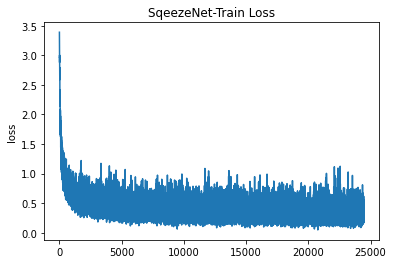

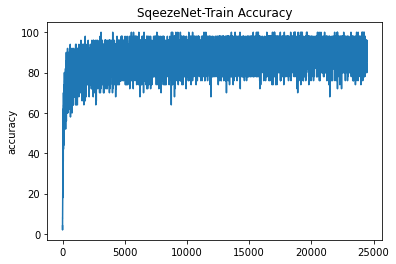

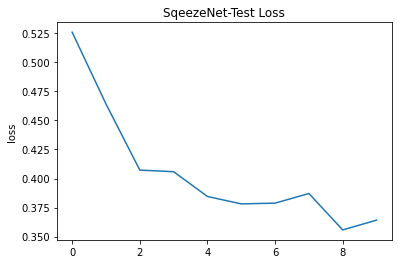

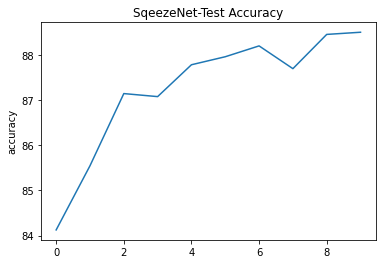

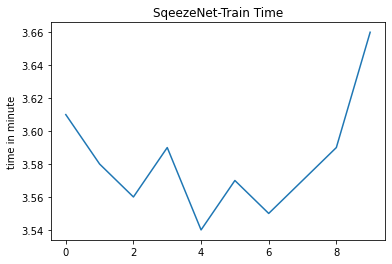

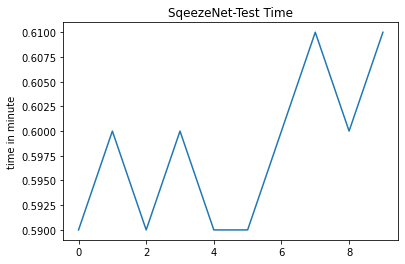

3.5819999999999994
35.81999999999999


In [13]:
# Plot train_loss and train_accuracy
plt.plot(train_loss_tracker)
plt.title('SqeezeNet-Train Loss')
plt.ylabel('loss')
plt.show()
plt.plot(train_accuracy_tracker)
plt.title('SqeezeNet-Train Accuracy')
plt.ylabel('accuracy')
plt.show()
# Plot test_loss and test_accuracy
plt.plot(test_loss_tracker)
plt.title('SqeezeNet-Test Loss')
plt.ylabel('loss')
plt.show()
plt.plot(test_accuracy_tracker)
plt.title('SqeezeNet-Test Accuracy')
plt.ylabel('accuracy')
plt.show()
# Plot train time
train_time_tracker_in_minute = []
for num in train_time_tracker:
    train_time_tracker_in_minute.append(round(num/60, 2))
plt.plot(train_time_tracker_in_minute)
plt.title('SqeezeNet-Train Time')
plt.ylabel('time in minute')
plt.show()
# Plot test time
test_time_tracker_in_minute = []
for num in test_time_tracker:
    test_time_tracker_in_minute.append(round(num/60, 2))
plt.plot(test_time_tracker_in_minute)
plt.title('SqeezeNet-Test Time')
plt.ylabel('time in minute')
plt.show()

print(sum(train_time_tracker_in_minute)/10)
print(sum(train_time_tracker_in_minute))

In [10]:
epochs = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(shufflenet.parameters(), lr = learning_rate)

# Train and test ShuffleNet
model = shufflenet

train_loss_tracker = []
train_accuracy_tracker = []
train_time_tracker = []
test_loss_tracker = []
test_accuracy_tracker = []
test_time_tracker = []

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    train_start_time = time.time()
    train_loss,train_accuracy = Train(model,optimizer,emnist_train_loader,device)
    train_end_time = time.time()
    train_time_tracker.append(train_end_time-train_start_time)
    test_start_time = time.time()
    test_loss , test_accuracy = Test(model,emnist_test_loader,device)
    test_end_time = time.time()
    test_time_tracker.append(test_end_time-test_start_time)
    train_loss_tracker.extend(train_loss)
    train_accuracy_tracker.extend(train_accuracy)
    test_loss_tracker.append(test_loss)
    test_accuracy_tracker.append(test_accuracy)
    print('\t training loss/accuracy: {0:.2f}/{1:.2f}'.format(sum(train_loss)/len(train_loss), sum(train_accuracy)/len((train_accuracy))))
    print('\t testing loss/accuracy: {0:.2f}/{1:.2f}'.format(test_loss, test_accuracy))

Epoch: 0
step: 2, loss = 3.2945
step: 3, loss = 3.2918
step: 4, loss = 3.2935
step: 5, loss = 3.2925
step: 6, loss = 3.2949
step: 7, loss = 3.2824
step: 8, loss = 3.2884
step: 9, loss = 3.2891
step: 10, loss = 3.2825
step: 11, loss = 3.2827
step: 12, loss = 3.2777
step: 13, loss = 3.2717
step: 14, loss = 3.2775
step: 15, loss = 3.2678
step: 16, loss = 3.2783
step: 17, loss = 3.2779
step: 18, loss = 3.2652
step: 19, loss = 3.2667
step: 20, loss = 3.2625
step: 21, loss = 3.2601
step: 22, loss = 3.2694
step: 23, loss = 3.2596
step: 24, loss = 3.2760
step: 25, loss = 3.2620
step: 26, loss = 3.2526
step: 27, loss = 3.2683
step: 28, loss = 3.2540
step: 29, loss = 3.2506
step: 30, loss = 3.2431
step: 31, loss = 3.2581
step: 32, loss = 3.2440
step: 33, loss = 3.2393
step: 34, loss = 3.2340
step: 35, loss = 3.2371
step: 36, loss = 3.2398
step: 37, loss = 3.2324
step: 38, loss = 3.2492
step: 39, loss = 3.2284
step: 40, loss = 3.2410
step: 41, loss = 3.2459
step: 42, loss = 3.2371
step: 43, loss 

step: 342, loss = 2.7965
step: 343, loss = 2.8949
step: 344, loss = 2.8449
step: 345, loss = 2.8249
step: 346, loss = 2.8484
step: 347, loss = 2.8475
step: 348, loss = 2.8288
step: 349, loss = 2.8443
step: 350, loss = 2.8100
step: 352, loss = 2.8194
step: 353, loss = 2.8089
step: 354, loss = 2.8044
step: 355, loss = 2.8011
step: 356, loss = 2.8684
step: 357, loss = 2.8453
step: 358, loss = 2.8142
step: 359, loss = 2.8723
step: 360, loss = 2.7881
step: 361, loss = 2.8316
step: 362, loss = 2.8114
step: 363, loss = 2.7619
step: 364, loss = 2.8660
step: 365, loss = 2.7891
step: 366, loss = 2.7923
step: 367, loss = 2.8459
step: 368, loss = 2.8398
step: 369, loss = 2.7990
step: 370, loss = 2.7527
step: 371, loss = 2.8205
step: 372, loss = 2.8349
step: 373, loss = 2.8051
step: 374, loss = 2.7851
step: 375, loss = 2.8350
step: 376, loss = 2.8663
step: 377, loss = 2.8277
step: 378, loss = 2.7422
step: 379, loss = 2.8002
step: 380, loss = 2.8135
step: 381, loss = 2.7721
step: 382, loss = 2.7725


step: 679, loss = 2.4345
step: 680, loss = 2.4773
step: 681, loss = 2.5363
step: 682, loss = 2.4664
step: 683, loss = 2.4864
step: 684, loss = 2.6010
step: 685, loss = 2.5655
step: 686, loss = 2.4965
step: 687, loss = 2.5221
step: 688, loss = 2.4943
step: 689, loss = 2.4664
step: 690, loss = 2.5855
step: 691, loss = 2.4201
step: 692, loss = 2.5509
step: 693, loss = 2.4516
step: 694, loss = 2.4493
step: 695, loss = 2.5320
step: 696, loss = 2.4961
step: 697, loss = 2.4549
step: 698, loss = 2.4730
step: 699, loss = 2.5054
step: 700, loss = 2.4697
step: 702, loss = 2.5910
step: 703, loss = 2.4781
step: 704, loss = 2.4963
step: 705, loss = 2.4479
step: 706, loss = 2.3999
step: 707, loss = 2.4849
step: 708, loss = 2.5874
step: 709, loss = 2.4025
step: 710, loss = 2.5814
step: 711, loss = 2.4748
step: 712, loss = 2.4344
step: 713, loss = 2.4151
step: 714, loss = 2.4378
step: 715, loss = 2.5120
step: 716, loss = 2.5069
step: 717, loss = 2.3664
step: 718, loss = 2.4746
step: 719, loss = 2.4748


step: 1016, loss = 2.2114
step: 1017, loss = 2.2650
step: 1018, loss = 2.2118
step: 1019, loss = 2.1767
step: 1020, loss = 2.3009
step: 1021, loss = 2.2722
step: 1022, loss = 2.2913
step: 1023, loss = 2.2826
step: 1024, loss = 2.3794
step: 1025, loss = 2.2993
step: 1026, loss = 2.2042
step: 1027, loss = 2.0864
step: 1028, loss = 2.3344
step: 1029, loss = 2.2764
step: 1030, loss = 2.2735
step: 1031, loss = 2.3437
step: 1032, loss = 2.2529
step: 1033, loss = 2.4616
step: 1034, loss = 2.2097
step: 1035, loss = 2.2942
step: 1036, loss = 2.2818
step: 1037, loss = 2.1552
step: 1038, loss = 2.2970
step: 1039, loss = 2.3865
step: 1040, loss = 2.2487
step: 1041, loss = 2.2137
step: 1042, loss = 2.3280
step: 1043, loss = 2.3194
step: 1044, loss = 2.2471
step: 1045, loss = 2.2394
step: 1046, loss = 2.3101
step: 1047, loss = 2.2429
step: 1048, loss = 2.1959
step: 1049, loss = 2.2226
step: 1050, loss = 2.2428
step: 1052, loss = 2.1579
step: 1053, loss = 2.2791
step: 1054, loss = 2.1204
step: 1055, 

step: 1340, loss = 2.1241
step: 1341, loss = 2.0152
step: 1342, loss = 1.8940
step: 1343, loss = 2.1162
step: 1344, loss = 2.1825
step: 1345, loss = 2.1315
step: 1346, loss = 1.9379
step: 1347, loss = 2.0792
step: 1348, loss = 1.9748
step: 1349, loss = 2.2098
step: 1350, loss = 2.1015
step: 1352, loss = 2.1203
step: 1353, loss = 2.1871
step: 1354, loss = 2.0519
step: 1355, loss = 2.0710
step: 1356, loss = 2.1105
step: 1357, loss = 2.0135
step: 1358, loss = 1.9550
step: 1359, loss = 1.9661
step: 1360, loss = 2.1184
step: 1361, loss = 2.0316
step: 1362, loss = 1.9498
step: 1363, loss = 2.1070
step: 1364, loss = 2.0219
step: 1365, loss = 1.9832
step: 1366, loss = 1.9579
step: 1367, loss = 2.0696
step: 1368, loss = 2.0228
step: 1369, loss = 1.9548
step: 1370, loss = 2.1110
step: 1371, loss = 2.0322
step: 1372, loss = 2.0643
step: 1373, loss = 1.8734
step: 1374, loss = 1.9612
step: 1375, loss = 2.0877
step: 1376, loss = 2.0094
step: 1377, loss = 1.9899
step: 1378, loss = 2.2704
step: 1379, 

step: 1665, loss = 1.7491
step: 1666, loss = 1.8645
step: 1667, loss = 1.7981
step: 1668, loss = 1.8070
step: 1669, loss = 1.8413
step: 1670, loss = 1.9223
step: 1671, loss = 1.8671
step: 1672, loss = 1.8953
step: 1673, loss = 1.8753
step: 1674, loss = 1.8107
step: 1675, loss = 1.9317
step: 1676, loss = 1.7409
step: 1677, loss = 1.8719
step: 1678, loss = 1.6637
step: 1679, loss = 1.9592
step: 1680, loss = 1.9317
step: 1681, loss = 1.8800
step: 1682, loss = 1.8045
step: 1683, loss = 1.8865
step: 1684, loss = 1.8396
step: 1685, loss = 2.0165
step: 1686, loss = 1.8998
step: 1687, loss = 1.9781
step: 1688, loss = 1.8899
step: 1689, loss = 1.8209
step: 1690, loss = 1.9258
step: 1691, loss = 1.7763
step: 1692, loss = 1.7678
step: 1693, loss = 1.8481
step: 1694, loss = 1.9203
step: 1695, loss = 1.9732
step: 1696, loss = 2.0602
step: 1697, loss = 1.7235
step: 1698, loss = 1.8858
step: 1699, loss = 1.8579
step: 1700, loss = 1.8957
step: 1702, loss = 1.8661
step: 1703, loss = 1.7506
step: 1704, 

step: 1989, loss = 1.8650
step: 1990, loss = 1.7357
step: 1991, loss = 1.5255
step: 1992, loss = 1.8829
step: 1993, loss = 1.6779
step: 1994, loss = 1.9087
step: 1995, loss = 1.7216
step: 1996, loss = 1.6808
step: 1997, loss = 1.7168
step: 1998, loss = 1.7944
step: 1999, loss = 1.9205
step: 2000, loss = 1.6154
step: 2002, loss = 1.7365
step: 2003, loss = 1.7080
step: 2004, loss = 1.7972
step: 2005, loss = 1.8418
step: 2006, loss = 1.7331
step: 2007, loss = 1.8445
step: 2008, loss = 1.6996
step: 2009, loss = 1.7840
step: 2010, loss = 1.7604
step: 2011, loss = 1.8919
step: 2012, loss = 1.6732
step: 2013, loss = 1.8077
step: 2014, loss = 1.8185
step: 2015, loss = 1.7704
step: 2016, loss = 1.7906
step: 2017, loss = 1.6827
step: 2018, loss = 1.9127
step: 2019, loss = 1.6828
step: 2020, loss = 1.6214
step: 2021, loss = 1.9098
step: 2022, loss = 1.7352
step: 2023, loss = 1.7019
step: 2024, loss = 1.7828
step: 2025, loss = 1.7095
step: 2026, loss = 1.6964
step: 2027, loss = 1.6918
step: 2028, 

step: 2315, loss = 1.8401
step: 2316, loss = 1.5473
step: 2317, loss = 1.4998
step: 2318, loss = 1.6806
step: 2319, loss = 1.5166
step: 2320, loss = 1.7825
step: 2321, loss = 1.4908
step: 2322, loss = 1.7588
step: 2323, loss = 1.7325
step: 2324, loss = 1.7183
step: 2325, loss = 1.5461
step: 2326, loss = 1.6268
step: 2327, loss = 1.5945
step: 2328, loss = 1.5034
step: 2329, loss = 1.7106
step: 2330, loss = 1.6414
step: 2331, loss = 1.5550
step: 2332, loss = 1.6320
step: 2333, loss = 1.5039
step: 2334, loss = 1.5666
step: 2335, loss = 1.7288
step: 2336, loss = 1.6317
step: 2337, loss = 1.8366
step: 2338, loss = 1.7067
step: 2339, loss = 1.7029
step: 2340, loss = 1.6584
step: 2341, loss = 1.4730
step: 2342, loss = 1.4084
step: 2343, loss = 1.7116
step: 2344, loss = 1.6650
step: 2345, loss = 1.4843
step: 2346, loss = 1.5655
step: 2347, loss = 1.6316
step: 2348, loss = 1.5305
step: 2349, loss = 1.5573
step: 2350, loss = 1.6109
step: 2352, loss = 1.5794
step: 2353, loss = 1.3348
step: 2354, 

step: 149, loss = 1.4793
step: 150, loss = 1.6113
step: 152, loss = 1.5095
step: 153, loss = 1.4846
step: 154, loss = 1.5987
step: 155, loss = 1.3214
step: 156, loss = 1.5741
step: 157, loss = 1.4020
step: 158, loss = 1.4432
step: 159, loss = 1.5999
step: 160, loss = 1.5280
step: 161, loss = 1.5465
step: 162, loss = 1.4756
step: 163, loss = 1.4508
step: 164, loss = 1.5631
step: 165, loss = 1.4505
step: 166, loss = 1.4938
step: 167, loss = 1.5640
step: 168, loss = 1.5304
step: 169, loss = 1.5774
step: 170, loss = 1.4008
step: 171, loss = 1.5670
step: 172, loss = 1.6513
step: 173, loss = 1.3439
step: 174, loss = 1.4514
step: 175, loss = 1.4988
step: 176, loss = 1.6426
step: 177, loss = 1.3768
step: 178, loss = 1.3682
step: 179, loss = 1.5566
step: 180, loss = 1.5895
step: 181, loss = 1.5044
step: 182, loss = 1.4908
step: 183, loss = 1.6411
step: 184, loss = 1.7098
step: 185, loss = 1.4752
step: 186, loss = 1.6751
step: 187, loss = 1.5769
step: 188, loss = 1.5709
step: 189, loss = 1.5400


step: 484, loss = 1.2523
step: 485, loss = 1.3154
step: 486, loss = 1.4743
step: 487, loss = 1.5614
step: 488, loss = 1.3160
step: 489, loss = 1.5896
step: 490, loss = 1.4837
step: 491, loss = 1.5426
step: 492, loss = 1.4439
step: 493, loss = 1.4254
step: 494, loss = 1.5278
step: 495, loss = 1.4224
step: 496, loss = 1.2467
step: 497, loss = 1.6469
step: 498, loss = 1.3961
step: 499, loss = 1.4999
step: 500, loss = 1.7117
step: 502, loss = 1.4906
step: 503, loss = 1.5211
step: 504, loss = 1.3517
step: 505, loss = 1.3972
step: 506, loss = 1.4494
step: 507, loss = 1.4432
step: 508, loss = 1.4917
step: 509, loss = 1.4788
step: 510, loss = 1.3900
step: 511, loss = 1.6482
step: 512, loss = 1.4816
step: 513, loss = 1.6115
step: 514, loss = 1.3741
step: 515, loss = 1.4615
step: 516, loss = 1.3997
step: 517, loss = 1.8307
step: 518, loss = 1.5024
step: 519, loss = 1.3268
step: 520, loss = 1.3427
step: 521, loss = 1.4525
step: 522, loss = 1.4286
step: 523, loss = 1.5646
step: 524, loss = 1.4517


step: 819, loss = 1.4718
step: 820, loss = 1.3334
step: 821, loss = 1.4063
step: 822, loss = 1.3106
step: 823, loss = 1.5193
step: 824, loss = 1.7369
step: 825, loss = 1.4952
step: 826, loss = 1.0882
step: 827, loss = 1.2874
step: 828, loss = 1.3989
step: 829, loss = 1.5823
step: 830, loss = 1.3432
step: 831, loss = 1.4377
step: 832, loss = 1.4697
step: 833, loss = 1.2272
step: 834, loss = 1.2315
step: 835, loss = 1.4943
step: 836, loss = 1.4646
step: 837, loss = 1.4509
step: 838, loss = 1.2862
step: 839, loss = 1.2822
step: 840, loss = 1.4029
step: 841, loss = 1.2522
step: 842, loss = 1.6224
step: 843, loss = 1.4902
step: 844, loss = 1.5149
step: 845, loss = 1.3803
step: 846, loss = 1.4469
step: 847, loss = 1.4346
step: 848, loss = 1.2350
step: 849, loss = 1.3759
step: 850, loss = 1.3066
step: 852, loss = 1.2569
step: 853, loss = 1.2813
step: 854, loss = 1.5510
step: 855, loss = 1.4379
step: 856, loss = 1.4096
step: 857, loss = 1.5789
step: 858, loss = 1.5389
step: 859, loss = 1.3201


step: 1148, loss = 1.2277
step: 1149, loss = 1.2111
step: 1150, loss = 1.3045
step: 1152, loss = 1.3750
step: 1153, loss = 1.2334
step: 1154, loss = 1.4045
step: 1155, loss = 1.3254
step: 1156, loss = 1.5753
step: 1157, loss = 1.3008
step: 1158, loss = 1.4310
step: 1159, loss = 1.3878
step: 1160, loss = 1.3234
step: 1161, loss = 1.3202
step: 1162, loss = 1.3206
step: 1163, loss = 1.3623
step: 1164, loss = 1.3960
step: 1165, loss = 1.3806
step: 1166, loss = 1.4029
step: 1167, loss = 1.1999
step: 1168, loss = 1.3651
step: 1169, loss = 1.5181
step: 1170, loss = 1.2705
step: 1171, loss = 1.2903
step: 1172, loss = 1.2259
step: 1173, loss = 1.3477
step: 1174, loss = 1.2569
step: 1175, loss = 1.2683
step: 1176, loss = 1.3644
step: 1177, loss = 1.3328
step: 1178, loss = 1.3241
step: 1179, loss = 1.1747
step: 1180, loss = 1.0961
step: 1181, loss = 1.3102
step: 1182, loss = 1.3114
step: 1183, loss = 1.1526
step: 1184, loss = 1.2828
step: 1185, loss = 1.4032
step: 1186, loss = 1.2854
step: 1187, 

step: 1473, loss = 1.5164
step: 1474, loss = 1.2231
step: 1475, loss = 1.0981
step: 1476, loss = 1.3918
step: 1477, loss = 1.3707
step: 1478, loss = 1.4651
step: 1479, loss = 1.3467
step: 1480, loss = 1.3005
step: 1481, loss = 1.2756
step: 1482, loss = 1.1960
step: 1483, loss = 1.2654
step: 1484, loss = 1.1987
step: 1485, loss = 1.3304
step: 1486, loss = 1.1707
step: 1487, loss = 1.2456
step: 1488, loss = 1.3466
step: 1489, loss = 1.1449
step: 1490, loss = 1.4041
step: 1491, loss = 1.2169
step: 1492, loss = 1.3080
step: 1493, loss = 1.1386
step: 1494, loss = 1.0570
step: 1495, loss = 1.1547
step: 1496, loss = 1.2371
step: 1497, loss = 1.3861
step: 1498, loss = 1.1697
step: 1499, loss = 1.2434
step: 1500, loss = 1.1511
step: 1502, loss = 1.1822
step: 1503, loss = 1.2660
step: 1504, loss = 1.2393
step: 1505, loss = 1.2692
step: 1506, loss = 1.3838
step: 1507, loss = 1.4370
step: 1508, loss = 1.3092
step: 1509, loss = 1.1689
step: 1510, loss = 1.1890
step: 1511, loss = 1.3867
step: 1512, 

step: 1796, loss = 1.4591
step: 1797, loss = 1.3624
step: 1798, loss = 1.3092
step: 1799, loss = 1.1383
step: 1800, loss = 1.3995
step: 1802, loss = 1.2620
step: 1803, loss = 1.2409
step: 1804, loss = 1.3217
step: 1805, loss = 1.2136
step: 1806, loss = 1.1715
step: 1807, loss = 1.3398
step: 1808, loss = 1.3503
step: 1809, loss = 1.2688
step: 1810, loss = 1.3710
step: 1811, loss = 1.2515
step: 1812, loss = 1.3068
step: 1813, loss = 1.1705
step: 1814, loss = 1.4491
step: 1815, loss = 1.3930
step: 1816, loss = 1.1782
step: 1817, loss = 1.1633
step: 1818, loss = 1.3025
step: 1819, loss = 1.0473
step: 1820, loss = 1.1847
step: 1821, loss = 1.1692
step: 1822, loss = 1.1423
step: 1823, loss = 1.1400
step: 1824, loss = 1.2148
step: 1825, loss = 1.1857
step: 1826, loss = 1.3816
step: 1827, loss = 1.1832
step: 1828, loss = 1.2621
step: 1829, loss = 1.1759
step: 1830, loss = 1.2391
step: 1831, loss = 1.2958
step: 1832, loss = 1.3260
step: 1833, loss = 1.3495
step: 1834, loss = 1.0747
step: 1835, 

step: 2119, loss = 1.2274
step: 2120, loss = 1.1292
step: 2121, loss = 1.2344
step: 2122, loss = 1.1484
step: 2123, loss = 1.3204
step: 2124, loss = 1.1266
step: 2125, loss = 1.1183
step: 2126, loss = 1.2304
step: 2127, loss = 1.1461
step: 2128, loss = 0.9777
step: 2129, loss = 1.0984
step: 2130, loss = 0.9239
step: 2131, loss = 1.0371
step: 2132, loss = 1.1812
step: 2133, loss = 1.2302
step: 2134, loss = 1.1671
step: 2135, loss = 1.1402
step: 2136, loss = 1.2584
step: 2137, loss = 1.1775
step: 2138, loss = 1.1467
step: 2139, loss = 1.2267
step: 2140, loss = 1.2651
step: 2141, loss = 1.0888
step: 2142, loss = 1.1687
step: 2143, loss = 1.3700
step: 2144, loss = 1.2115
step: 2145, loss = 1.1055
step: 2146, loss = 1.2423
step: 2147, loss = 1.2667
step: 2148, loss = 1.2501
step: 2149, loss = 1.1603
step: 2150, loss = 1.2719
step: 2152, loss = 1.0995
step: 2153, loss = 1.2063
step: 2154, loss = 1.2620
step: 2155, loss = 1.0365
step: 2156, loss = 0.9222
step: 2157, loss = 1.3287
step: 2158, 

step: 2444, loss = 1.1233
step: 2445, loss = 1.1101
step: 2446, loss = 1.2408
step: 2447, loss = 1.0636
step: 2448, loss = 0.9908
step: 2449, loss = 1.0015
step: 2450, loss = 1.0235
step: 2452, loss = 1.1965
step: 2453, loss = 1.0446
step: 2454, loss = 1.1149
step: 2455, loss = 1.2987
step: 2456, loss = 1.1229
step: 2457, loss = 1.2777
step: 2458, loss = 1.1696
step: 2459, loss = 1.3837
step: 2460, loss = 1.2620
step: 2461, loss = 1.1808
step: 2462, loss = 1.0742
step: 2463, loss = 1.1885
step: 2464, loss = 1.1464
step: 2465, loss = 1.3194
step: 2466, loss = 1.0759
step: 2467, loss = 1.2168
step: 2468, loss = 1.1405
step: 2469, loss = 1.0191
step: 2470, loss = 1.2539
step: 2471, loss = 0.9547
step: 2472, loss = 1.1769
step: 2473, loss = 1.2952
step: 2474, loss = 1.1028
step: 2475, loss = 1.0809
step: 2476, loss = 1.0666
step: 2477, loss = 1.2995
step: 2478, loss = 1.0867
step: 2479, loss = 1.0080
step: 2480, loss = 1.3044
step: 2481, loss = 1.2330
step: 2482, loss = 0.9356
step: 2483, 

step: 284, loss = 1.0485
step: 285, loss = 1.0987
step: 286, loss = 1.1744
step: 287, loss = 1.0531
step: 288, loss = 1.2110
step: 289, loss = 1.0852
step: 290, loss = 1.0236
step: 291, loss = 1.1805
step: 292, loss = 0.9215
step: 293, loss = 1.1361
step: 294, loss = 1.1531
step: 295, loss = 0.9158
step: 296, loss = 1.1078
step: 297, loss = 1.1012
step: 298, loss = 1.2218
step: 299, loss = 1.1619
step: 300, loss = 1.3200
step: 302, loss = 1.1074
step: 303, loss = 1.1643
step: 304, loss = 1.0665
step: 305, loss = 1.1097
step: 306, loss = 1.0022
step: 307, loss = 1.0751
step: 308, loss = 1.0994
step: 309, loss = 1.1988
step: 310, loss = 0.9902
step: 311, loss = 1.2064
step: 312, loss = 1.1544
step: 313, loss = 1.0743
step: 314, loss = 1.2447
step: 315, loss = 1.2069
step: 316, loss = 1.0993
step: 317, loss = 1.3195
step: 318, loss = 1.1091
step: 319, loss = 1.2309
step: 320, loss = 0.9588
step: 321, loss = 1.2293
step: 322, loss = 0.8867
step: 323, loss = 1.3031
step: 324, loss = 1.3977


step: 620, loss = 0.9463
step: 621, loss = 1.0200
step: 622, loss = 1.2076
step: 623, loss = 1.1105
step: 624, loss = 1.0670
step: 625, loss = 1.0639
step: 626, loss = 1.0621
step: 627, loss = 1.0097
step: 628, loss = 0.9333
step: 629, loss = 0.9826
step: 630, loss = 0.9592
step: 631, loss = 1.0121
step: 632, loss = 1.2144
step: 633, loss = 1.0395
step: 634, loss = 1.2031
step: 635, loss = 1.0541
step: 636, loss = 1.2463
step: 637, loss = 1.1308
step: 638, loss = 1.0254
step: 639, loss = 1.1637
step: 640, loss = 1.0942
step: 641, loss = 0.9853
step: 642, loss = 1.2337
step: 643, loss = 0.9943
step: 644, loss = 0.9828
step: 645, loss = 1.2810
step: 646, loss = 1.0409
step: 647, loss = 1.0587
step: 648, loss = 0.9399
step: 649, loss = 1.0098
step: 650, loss = 0.9030
step: 652, loss = 1.0798
step: 653, loss = 1.0882
step: 654, loss = 1.1667
step: 655, loss = 0.9963
step: 656, loss = 1.1186
step: 657, loss = 0.9294
step: 658, loss = 0.8738
step: 659, loss = 1.0375
step: 660, loss = 0.9579


step: 956, loss = 1.1289
step: 957, loss = 0.9981
step: 958, loss = 1.0271
step: 959, loss = 1.0226
step: 960, loss = 0.9693
step: 961, loss = 0.8865
step: 962, loss = 0.9267
step: 963, loss = 1.1575
step: 964, loss = 1.1313
step: 965, loss = 1.1255
step: 966, loss = 1.1595
step: 967, loss = 1.0719
step: 968, loss = 1.0803
step: 969, loss = 0.9284
step: 970, loss = 0.8565
step: 971, loss = 1.1271
step: 972, loss = 0.9083
step: 973, loss = 1.0574
step: 974, loss = 0.9588
step: 975, loss = 0.9829
step: 976, loss = 1.0125
step: 977, loss = 0.9975
step: 978, loss = 1.0161
step: 979, loss = 1.2369
step: 980, loss = 1.1215
step: 981, loss = 0.9561
step: 982, loss = 1.1221
step: 983, loss = 1.0690
step: 984, loss = 0.8810
step: 985, loss = 1.0545
step: 986, loss = 1.0437
step: 987, loss = 1.0451
step: 988, loss = 1.1675
step: 989, loss = 1.0521
step: 990, loss = 1.1105
step: 991, loss = 0.9612
step: 992, loss = 0.7890
step: 993, loss = 0.9080
step: 994, loss = 1.1106
step: 995, loss = 1.1079


step: 1279, loss = 0.9918
step: 1280, loss = 0.9494
step: 1281, loss = 1.1146
step: 1282, loss = 1.0020
step: 1283, loss = 1.0069
step: 1284, loss = 1.0225
step: 1285, loss = 1.1543
step: 1286, loss = 0.9944
step: 1287, loss = 1.0017
step: 1288, loss = 1.1155
step: 1289, loss = 1.0941
step: 1290, loss = 0.8742
step: 1291, loss = 1.0273
step: 1292, loss = 0.9692
step: 1293, loss = 0.9557
step: 1294, loss = 1.1926
step: 1295, loss = 1.0562
step: 1296, loss = 0.9211
step: 1297, loss = 1.0911
step: 1298, loss = 1.2100
step: 1299, loss = 1.1772
step: 1300, loss = 0.9156
step: 1302, loss = 0.9521
step: 1303, loss = 1.0524
step: 1304, loss = 1.0618
step: 1305, loss = 1.0932
step: 1306, loss = 1.1751
step: 1307, loss = 1.2074
step: 1308, loss = 0.9486
step: 1309, loss = 1.1761
step: 1310, loss = 0.8533
step: 1311, loss = 0.9560
step: 1312, loss = 0.9209
step: 1313, loss = 0.8715
step: 1314, loss = 0.9218
step: 1315, loss = 0.9102
step: 1316, loss = 0.9905
step: 1317, loss = 1.1155
step: 1318, 

step: 1604, loss = 1.1248
step: 1605, loss = 0.9315
step: 1606, loss = 0.7980
step: 1607, loss = 1.0516
step: 1608, loss = 0.9026
step: 1609, loss = 0.9848
step: 1610, loss = 0.8584
step: 1611, loss = 1.0526
step: 1612, loss = 1.0487
step: 1613, loss = 0.8865
step: 1614, loss = 1.0694
step: 1615, loss = 0.7731
step: 1616, loss = 0.9134
step: 1617, loss = 0.9445
step: 1618, loss = 1.0213
step: 1619, loss = 0.8689
step: 1620, loss = 1.3726
step: 1621, loss = 1.0037
step: 1622, loss = 1.0604
step: 1623, loss = 0.8883
step: 1624, loss = 1.0665
step: 1625, loss = 1.2047
step: 1626, loss = 0.9778
step: 1627, loss = 1.1621
step: 1628, loss = 1.0008
step: 1629, loss = 0.9341
step: 1630, loss = 0.9464
step: 1631, loss = 1.0761
step: 1632, loss = 1.0338
step: 1633, loss = 1.0224
step: 1634, loss = 1.0770
step: 1635, loss = 0.9381
step: 1636, loss = 1.0199
step: 1637, loss = 0.9957
step: 1638, loss = 1.1071
step: 1639, loss = 0.8943
step: 1640, loss = 1.0584
step: 1641, loss = 1.0927
step: 1642, 

step: 1926, loss = 0.8643
step: 1927, loss = 0.9412
step: 1928, loss = 0.9074
step: 1929, loss = 0.9872
step: 1930, loss = 0.9776
step: 1931, loss = 0.7816
step: 1932, loss = 0.8768
step: 1933, loss = 0.8977
step: 1934, loss = 0.7788
step: 1935, loss = 1.0004
step: 1936, loss = 1.0139
step: 1937, loss = 0.7855
step: 1938, loss = 0.9618
step: 1939, loss = 0.8958
step: 1940, loss = 0.9640
step: 1941, loss = 0.9537
step: 1942, loss = 0.8500
step: 1943, loss = 1.1508
step: 1944, loss = 0.7298
step: 1945, loss = 0.9893
step: 1946, loss = 0.8232
step: 1947, loss = 1.2126
step: 1948, loss = 0.8630
step: 1949, loss = 0.8926
step: 1950, loss = 1.1799
step: 1952, loss = 1.2260
step: 1953, loss = 1.0573
step: 1954, loss = 1.0742
step: 1955, loss = 0.8711
step: 1956, loss = 1.0075
step: 1957, loss = 1.0145
step: 1958, loss = 0.9506
step: 1959, loss = 0.9329
step: 1960, loss = 0.9727
step: 1961, loss = 0.9360
step: 1962, loss = 0.9468
step: 1963, loss = 0.7744
step: 1964, loss = 1.0140
step: 1965, 

step: 2248, loss = 1.1225
step: 2249, loss = 1.0543
step: 2250, loss = 0.9734
step: 2252, loss = 0.7982
step: 2253, loss = 0.6616
step: 2254, loss = 1.0663
step: 2255, loss = 0.9243
step: 2256, loss = 0.8546
step: 2257, loss = 0.9237
step: 2258, loss = 0.9089
step: 2259, loss = 0.9304
step: 2260, loss = 0.7583
step: 2261, loss = 0.8566
step: 2262, loss = 1.0006
step: 2263, loss = 1.0976
step: 2264, loss = 0.9443
step: 2265, loss = 0.8933
step: 2266, loss = 0.9408
step: 2267, loss = 1.1082
step: 2268, loss = 0.9384
step: 2269, loss = 0.9314
step: 2270, loss = 0.9924
step: 2271, loss = 1.0775
step: 2272, loss = 0.9778
step: 2273, loss = 1.0673
step: 2274, loss = 0.8997
step: 2275, loss = 0.9854
step: 2276, loss = 1.0368
step: 2277, loss = 0.9522
step: 2278, loss = 0.9293
step: 2279, loss = 0.8801
step: 2280, loss = 0.8298
step: 2281, loss = 0.8536
step: 2282, loss = 0.9198
step: 2283, loss = 0.8142
step: 2284, loss = 0.9462
step: 2285, loss = 1.1084
step: 2286, loss = 1.1285
step: 2287, 

step: 78, loss = 0.8184
step: 79, loss = 0.9621
step: 80, loss = 0.9557
step: 81, loss = 0.8198
step: 82, loss = 0.8848
step: 83, loss = 1.0180
step: 84, loss = 0.7848
step: 85, loss = 0.8566
step: 86, loss = 0.9078
step: 87, loss = 0.9027
step: 88, loss = 1.0667
step: 89, loss = 0.9891
step: 90, loss = 1.1438
step: 91, loss = 0.9350
step: 92, loss = 1.1698
step: 93, loss = 1.0368
step: 94, loss = 0.8856
step: 95, loss = 0.9604
step: 96, loss = 1.0244
step: 97, loss = 0.8817
step: 98, loss = 1.1561
step: 99, loss = 0.9612
step: 100, loss = 0.8108
step: 102, loss = 1.0725
step: 103, loss = 0.8842
step: 104, loss = 1.0460
step: 105, loss = 0.8495
step: 106, loss = 0.8786
step: 107, loss = 0.8155
step: 108, loss = 1.0075
step: 109, loss = 1.0403
step: 110, loss = 0.9797
step: 111, loss = 0.7981
step: 112, loss = 1.0340
step: 113, loss = 1.0984
step: 114, loss = 0.9140
step: 115, loss = 1.0380
step: 116, loss = 0.9665
step: 117, loss = 0.7986
step: 118, loss = 0.8683
step: 119, loss = 0.72

step: 416, loss = 0.9227
step: 417, loss = 0.8361
step: 418, loss = 0.9747
step: 419, loss = 0.9608
step: 420, loss = 0.9569
step: 421, loss = 0.8649
step: 422, loss = 0.9961
step: 423, loss = 0.8913
step: 424, loss = 0.9210
step: 425, loss = 0.7575
step: 426, loss = 1.0683
step: 427, loss = 0.9413
step: 428, loss = 1.0451
step: 429, loss = 0.8118
step: 430, loss = 0.7147
step: 431, loss = 0.9605
step: 432, loss = 0.9688
step: 433, loss = 0.8824
step: 434, loss = 0.9464
step: 435, loss = 0.6926
step: 436, loss = 0.9078
step: 437, loss = 0.9752
step: 438, loss = 0.9464
step: 439, loss = 0.8593
step: 440, loss = 0.7810
step: 441, loss = 0.8727
step: 442, loss = 0.9124
step: 443, loss = 0.9680
step: 444, loss = 1.0385
step: 445, loss = 0.8802
step: 446, loss = 0.7529
step: 447, loss = 0.9410
step: 448, loss = 0.9905
step: 449, loss = 0.9566
step: 450, loss = 1.0626
step: 452, loss = 1.0531
step: 453, loss = 0.8825
step: 454, loss = 0.7829
step: 455, loss = 0.8564
step: 456, loss = 0.9233


step: 752, loss = 0.8133
step: 753, loss = 0.7927
step: 754, loss = 0.8893
step: 755, loss = 0.7724
step: 756, loss = 0.7261
step: 757, loss = 0.8443
step: 758, loss = 0.8686
step: 759, loss = 1.1701
step: 760, loss = 1.0657
step: 761, loss = 0.8838
step: 762, loss = 0.9525
step: 763, loss = 1.1473
step: 764, loss = 1.0394
step: 765, loss = 0.7409
step: 766, loss = 0.8222
step: 767, loss = 0.9406
step: 768, loss = 0.8472
step: 769, loss = 0.9593
step: 770, loss = 0.9209
step: 771, loss = 0.9387
step: 772, loss = 0.8096
step: 773, loss = 0.9617
step: 774, loss = 0.8002
step: 775, loss = 0.9314
step: 776, loss = 0.9896
step: 777, loss = 0.9606
step: 778, loss = 0.7152
step: 779, loss = 0.9582
step: 780, loss = 0.8908
step: 781, loss = 0.9469
step: 782, loss = 0.8518
step: 783, loss = 1.0344
step: 784, loss = 0.9266
step: 785, loss = 0.9440
step: 786, loss = 0.8229
step: 787, loss = 1.0193
step: 788, loss = 0.6920
step: 789, loss = 1.0270
step: 790, loss = 0.9951
step: 791, loss = 0.8115


step: 1085, loss = 0.6802
step: 1086, loss = 1.0474
step: 1087, loss = 0.8665
step: 1088, loss = 0.7702
step: 1089, loss = 0.9292
step: 1090, loss = 0.7249
step: 1091, loss = 0.8339
step: 1092, loss = 0.7276
step: 1093, loss = 0.8653
step: 1094, loss = 1.0129
step: 1095, loss = 1.0344
step: 1096, loss = 0.9325
step: 1097, loss = 0.8115
step: 1098, loss = 1.0568
step: 1099, loss = 0.6965
step: 1100, loss = 0.9139
step: 1102, loss = 0.9179
step: 1103, loss = 0.8631
step: 1104, loss = 0.8582
step: 1105, loss = 0.9412
step: 1106, loss = 0.8047
step: 1107, loss = 0.8198
step: 1108, loss = 0.7432
step: 1109, loss = 0.9252
step: 1110, loss = 0.7989
step: 1111, loss = 0.8390
step: 1112, loss = 0.7877
step: 1113, loss = 0.7894
step: 1114, loss = 0.8539
step: 1115, loss = 0.7091
step: 1116, loss = 0.7500
step: 1117, loss = 0.8742
step: 1118, loss = 0.8993
step: 1119, loss = 0.8339
step: 1120, loss = 0.9211
step: 1121, loss = 0.9418
step: 1122, loss = 1.1453
step: 1123, loss = 1.1010
step: 1124, 

step: 1408, loss = 0.6309
step: 1409, loss = 0.8298
step: 1410, loss = 0.7441
step: 1411, loss = 0.8634
step: 1412, loss = 0.9352
step: 1413, loss = 0.7681
step: 1414, loss = 0.7173
step: 1415, loss = 0.9743
step: 1416, loss = 0.7069
step: 1417, loss = 0.9614
step: 1418, loss = 0.7891
step: 1419, loss = 0.8205
step: 1420, loss = 0.7638
step: 1421, loss = 0.9133
step: 1422, loss = 0.8530
step: 1423, loss = 0.9078
step: 1424, loss = 0.9023
step: 1425, loss = 0.7744
step: 1426, loss = 0.9354
step: 1427, loss = 0.7877
step: 1428, loss = 0.8852
step: 1429, loss = 0.9273
step: 1430, loss = 0.7273
step: 1431, loss = 0.9111
step: 1432, loss = 0.7633
step: 1433, loss = 0.9068
step: 1434, loss = 0.8254
step: 1435, loss = 0.7946
step: 1436, loss = 0.8217
step: 1437, loss = 0.6895
step: 1438, loss = 0.8259
step: 1439, loss = 0.9541
step: 1440, loss = 0.5672
step: 1441, loss = 0.7388
step: 1442, loss = 0.8227
step: 1443, loss = 0.8056
step: 1444, loss = 0.7535
step: 1445, loss = 0.7253
step: 1446, 

step: 1732, loss = 0.8538
step: 1733, loss = 0.9195
step: 1734, loss = 0.6572
step: 1735, loss = 0.6952
step: 1736, loss = 0.7500
step: 1737, loss = 0.8934
step: 1738, loss = 0.8017
step: 1739, loss = 1.0333
step: 1740, loss = 1.1960
step: 1741, loss = 0.8630
step: 1742, loss = 0.8571
step: 1743, loss = 0.7922
step: 1744, loss = 0.9032
step: 1745, loss = 0.8436
step: 1746, loss = 0.9583
step: 1747, loss = 0.9081
step: 1748, loss = 0.9046
step: 1749, loss = 0.9143
step: 1750, loss = 0.7765
step: 1752, loss = 0.8783
step: 1753, loss = 0.6984
step: 1754, loss = 0.9455
step: 1755, loss = 0.7457
step: 1756, loss = 0.7271
step: 1757, loss = 0.7920
step: 1758, loss = 0.9286
step: 1759, loss = 0.8236
step: 1760, loss = 0.9759
step: 1761, loss = 0.7563
step: 1762, loss = 0.7669
step: 1763, loss = 0.8426
step: 1764, loss = 0.7377
step: 1765, loss = 0.9756
step: 1766, loss = 0.8038
step: 1767, loss = 0.8204
step: 1768, loss = 0.8352
step: 1769, loss = 0.9088
step: 1770, loss = 1.0345
step: 1771, 

step: 2055, loss = 0.7185
step: 2056, loss = 0.8519
step: 2057, loss = 0.7271
step: 2058, loss = 0.7591
step: 2059, loss = 0.9866
step: 2060, loss = 0.8449
step: 2061, loss = 1.1077
step: 2062, loss = 0.9359
step: 2063, loss = 0.9623
step: 2064, loss = 0.8503
step: 2065, loss = 0.9653
step: 2066, loss = 0.9660
step: 2067, loss = 0.8526
step: 2068, loss = 0.8309
step: 2069, loss = 0.8656
step: 2070, loss = 0.8325
step: 2071, loss = 0.7418
step: 2072, loss = 0.7923
step: 2073, loss = 0.5677
step: 2074, loss = 0.8207
step: 2075, loss = 0.7725
step: 2076, loss = 1.0335
step: 2077, loss = 0.7425
step: 2078, loss = 0.7259
step: 2079, loss = 0.9710
step: 2080, loss = 0.5877
step: 2081, loss = 0.8252
step: 2082, loss = 0.8960
step: 2083, loss = 0.8489
step: 2084, loss = 0.7019
step: 2085, loss = 0.5761
step: 2086, loss = 0.7723
step: 2087, loss = 0.8912
step: 2088, loss = 0.8936
step: 2089, loss = 0.9946
step: 2090, loss = 0.7898
step: 2091, loss = 1.0659
step: 2092, loss = 0.9761
step: 2093, 

step: 2377, loss = 0.7589
step: 2378, loss = 0.8160
step: 2379, loss = 1.0008
step: 2380, loss = 0.7958
step: 2381, loss = 0.8157
step: 2382, loss = 0.7726
step: 2383, loss = 1.0358
step: 2384, loss = 0.9089
step: 2385, loss = 0.8797
step: 2386, loss = 0.6581
step: 2387, loss = 1.0499
step: 2388, loss = 0.9351
step: 2389, loss = 1.0497
step: 2390, loss = 0.8454
step: 2391, loss = 0.6952
step: 2392, loss = 0.8996
step: 2393, loss = 0.7146
step: 2394, loss = 0.8570
step: 2395, loss = 0.7448
step: 2396, loss = 1.1368
step: 2397, loss = 0.7479
step: 2398, loss = 0.7745
step: 2399, loss = 0.7019
step: 2400, loss = 0.9249
step: 2402, loss = 0.7572
step: 2403, loss = 0.7657
step: 2404, loss = 0.7363
step: 2405, loss = 0.7506
step: 2406, loss = 0.8936
step: 2407, loss = 0.6503
step: 2408, loss = 0.7342
step: 2409, loss = 0.7425
step: 2410, loss = 1.0238
step: 2411, loss = 0.7744
step: 2412, loss = 0.7136
step: 2413, loss = 0.7505
step: 2414, loss = 0.7989
step: 2415, loss = 0.8623
step: 2416, 

step: 214, loss = 0.9441
step: 215, loss = 1.0121
step: 216, loss = 0.7746
step: 217, loss = 0.9513
step: 218, loss = 0.8021
step: 219, loss = 0.8962
step: 220, loss = 0.8052
step: 221, loss = 0.7675
step: 222, loss = 0.8615
step: 223, loss = 0.7587
step: 224, loss = 0.7133
step: 225, loss = 0.9282
step: 226, loss = 0.8240
step: 227, loss = 0.9892
step: 228, loss = 0.8663
step: 229, loss = 0.9131
step: 230, loss = 1.0245
step: 231, loss = 0.8221
step: 232, loss = 0.9842
step: 233, loss = 0.7553
step: 234, loss = 0.9081
step: 235, loss = 1.0395
step: 236, loss = 0.7863
step: 237, loss = 0.9767
step: 238, loss = 0.7872
step: 239, loss = 0.8805
step: 240, loss = 0.8582
step: 241, loss = 0.9269
step: 242, loss = 0.8361
step: 243, loss = 1.0581
step: 244, loss = 0.8289
step: 245, loss = 0.9179
step: 246, loss = 1.0928
step: 247, loss = 0.8743
step: 248, loss = 0.7631
step: 249, loss = 0.9675
step: 250, loss = 1.0004
step: 252, loss = 0.9552
step: 253, loss = 0.8502
step: 254, loss = 0.8367


step: 549, loss = 0.8716
step: 550, loss = 0.8067
step: 552, loss = 0.7186
step: 553, loss = 0.8165
step: 554, loss = 0.7963
step: 555, loss = 0.7397
step: 556, loss = 0.7177
step: 557, loss = 0.9475
step: 558, loss = 0.7951
step: 559, loss = 0.8255
step: 560, loss = 0.9020
step: 561, loss = 0.7593
step: 562, loss = 0.8286
step: 563, loss = 0.9140
step: 564, loss = 0.6676
step: 565, loss = 0.7187
step: 566, loss = 0.7910
step: 567, loss = 0.8402
step: 568, loss = 0.8279
step: 569, loss = 0.9213
step: 570, loss = 0.7858
step: 571, loss = 0.7413
step: 572, loss = 0.9501
step: 573, loss = 0.7977
step: 574, loss = 0.7335
step: 575, loss = 0.8386
step: 576, loss = 0.7592
step: 577, loss = 0.8268
step: 578, loss = 0.8202
step: 579, loss = 0.8475
step: 580, loss = 0.8747
step: 581, loss = 0.7864
step: 582, loss = 0.8129
step: 583, loss = 0.8038
step: 584, loss = 0.7219
step: 585, loss = 0.6034
step: 586, loss = 0.7874
step: 587, loss = 0.8404
step: 588, loss = 0.7861
step: 589, loss = 0.9722


step: 884, loss = 0.8249
step: 885, loss = 0.7802
step: 886, loss = 0.6426
step: 887, loss = 0.7870
step: 888, loss = 0.7784
step: 889, loss = 0.5157
step: 890, loss = 0.7187
step: 891, loss = 0.8063
step: 892, loss = 0.9317
step: 893, loss = 0.8799
step: 894, loss = 0.8469
step: 895, loss = 0.6181
step: 896, loss = 0.9443
step: 897, loss = 0.8143
step: 898, loss = 0.9935
step: 899, loss = 0.8420
step: 900, loss = 0.8818
step: 902, loss = 0.7546
step: 903, loss = 0.8174
step: 904, loss = 0.9387
step: 905, loss = 0.7100
step: 906, loss = 0.7428
step: 907, loss = 0.5203
step: 908, loss = 0.6481
step: 909, loss = 0.8882
step: 910, loss = 0.8371
step: 911, loss = 0.9010
step: 912, loss = 0.7599
step: 913, loss = 0.9308
step: 914, loss = 1.1573
step: 915, loss = 0.8040
step: 916, loss = 0.6901
step: 917, loss = 0.8214
step: 918, loss = 0.6849
step: 919, loss = 0.7253
step: 920, loss = 0.8032
step: 921, loss = 0.7862
step: 922, loss = 0.9096
step: 923, loss = 0.7975
step: 924, loss = 0.7499


step: 1212, loss = 0.8325
step: 1213, loss = 0.7078
step: 1214, loss = 0.7955
step: 1215, loss = 0.6340
step: 1216, loss = 0.6322
step: 1217, loss = 0.6581
step: 1218, loss = 0.9508
step: 1219, loss = 0.8819
step: 1220, loss = 1.0937
step: 1221, loss = 0.7156
step: 1222, loss = 0.7556
step: 1223, loss = 0.9270
step: 1224, loss = 0.7173
step: 1225, loss = 0.8103
step: 1226, loss = 0.8528
step: 1227, loss = 1.0026
step: 1228, loss = 0.6675
step: 1229, loss = 0.8832
step: 1230, loss = 0.8176
step: 1231, loss = 0.7776
step: 1232, loss = 0.6788
step: 1233, loss = 0.6916
step: 1234, loss = 0.6827
step: 1235, loss = 0.8043
step: 1236, loss = 0.7449
step: 1237, loss = 0.9889
step: 1238, loss = 0.7716
step: 1239, loss = 0.7352
step: 1240, loss = 0.8606
step: 1241, loss = 0.7070
step: 1242, loss = 1.0061
step: 1243, loss = 0.7732
step: 1244, loss = 0.6734
step: 1245, loss = 0.5276
step: 1246, loss = 0.7834
step: 1247, loss = 0.6764
step: 1248, loss = 0.6428
step: 1249, loss = 0.6060
step: 1250, 

step: 1534, loss = 0.7374
step: 1535, loss = 0.7555
step: 1536, loss = 0.7565
step: 1537, loss = 1.0065
step: 1538, loss = 0.7635
step: 1539, loss = 0.7162
step: 1540, loss = 0.7221
step: 1541, loss = 0.8279
step: 1542, loss = 0.7509
step: 1543, loss = 0.7041
step: 1544, loss = 0.6799
step: 1545, loss = 0.7329
step: 1546, loss = 0.6586
step: 1547, loss = 0.7214
step: 1548, loss = 0.7130
step: 1549, loss = 0.8764
step: 1550, loss = 0.7488
step: 1552, loss = 0.8835
step: 1553, loss = 0.7519
step: 1554, loss = 0.9593
step: 1555, loss = 0.6221
step: 1556, loss = 0.7969
step: 1557, loss = 0.6970
step: 1558, loss = 0.7131
step: 1559, loss = 0.8022
step: 1560, loss = 0.8336
step: 1561, loss = 0.8118
step: 1562, loss = 0.7507
step: 1563, loss = 0.6092
step: 1564, loss = 0.6215
step: 1565, loss = 0.6830
step: 1566, loss = 0.8798
step: 1567, loss = 0.7678
step: 1568, loss = 0.8919
step: 1569, loss = 0.9159
step: 1570, loss = 0.7639
step: 1571, loss = 0.8789
step: 1572, loss = 0.6636
step: 1573, 

step: 1858, loss = 0.7979
step: 1859, loss = 0.6898
step: 1860, loss = 0.8443
step: 1861, loss = 0.9475
step: 1862, loss = 0.6979
step: 1863, loss = 0.8315
step: 1864, loss = 0.6593
step: 1865, loss = 0.8267
step: 1866, loss = 0.7234
step: 1867, loss = 0.6300
step: 1868, loss = 0.7526
step: 1869, loss = 0.8526
step: 1870, loss = 0.9142
step: 1871, loss = 0.6076
step: 1872, loss = 0.6134
step: 1873, loss = 0.8020
step: 1874, loss = 0.7247
step: 1875, loss = 0.7800
step: 1876, loss = 0.8960
step: 1877, loss = 0.7821
step: 1878, loss = 0.8285
step: 1879, loss = 0.8715
step: 1880, loss = 0.7470
step: 1881, loss = 0.8150
step: 1882, loss = 0.8791
step: 1883, loss = 0.7844
step: 1884, loss = 0.5985
step: 1885, loss = 0.7310
step: 1886, loss = 0.6234
step: 1887, loss = 0.7838
step: 1888, loss = 0.7227
step: 1889, loss = 0.8682
step: 1890, loss = 0.7366
step: 1891, loss = 0.9907
step: 1892, loss = 0.8686
step: 1893, loss = 0.8540
step: 1894, loss = 0.8467
step: 1895, loss = 0.8908
step: 1896, 

step: 2181, loss = 0.7404
step: 2182, loss = 0.6946
step: 2183, loss = 0.8570
step: 2184, loss = 0.7180
step: 2185, loss = 1.1497
step: 2186, loss = 0.9112
step: 2187, loss = 0.7521
step: 2188, loss = 0.6665
step: 2189, loss = 0.6583
step: 2190, loss = 0.6984
step: 2191, loss = 0.7605
step: 2192, loss = 0.8205
step: 2193, loss = 0.6681
step: 2194, loss = 0.8530
step: 2195, loss = 0.6039
step: 2196, loss = 0.6901
step: 2197, loss = 0.6022
step: 2198, loss = 0.6358
step: 2199, loss = 0.6888
step: 2200, loss = 0.8247
step: 2202, loss = 0.6019
step: 2203, loss = 0.8170
step: 2204, loss = 0.6603
step: 2205, loss = 0.6641
step: 2206, loss = 0.8281
step: 2207, loss = 0.6952
step: 2208, loss = 0.9747
step: 2209, loss = 0.7619
step: 2210, loss = 0.5448
step: 2211, loss = 0.6719
step: 2212, loss = 1.0204
step: 2213, loss = 0.8553
step: 2214, loss = 0.7348
step: 2215, loss = 0.7903
step: 2216, loss = 0.6829
step: 2217, loss = 1.0592
step: 2218, loss = 0.7223
step: 2219, loss = 0.9202
step: 2220, 

step: 8, loss = 0.7645
step: 9, loss = 0.5034
step: 10, loss = 0.8799
step: 11, loss = 0.8843
step: 12, loss = 0.8663
step: 13, loss = 0.7129
step: 14, loss = 0.7124
step: 15, loss = 0.7360
step: 16, loss = 0.8023
step: 17, loss = 0.6201
step: 18, loss = 0.8333
step: 19, loss = 0.5974
step: 20, loss = 0.8342
step: 21, loss = 0.6950
step: 22, loss = 0.8420
step: 23, loss = 0.5807
step: 24, loss = 0.8440
step: 25, loss = 0.7609
step: 26, loss = 0.8626
step: 27, loss = 0.6924
step: 28, loss = 0.6698
step: 29, loss = 0.6506
step: 30, loss = 0.6783
step: 31, loss = 0.6440
step: 32, loss = 0.8340
step: 33, loss = 0.7862
step: 34, loss = 0.7025
step: 35, loss = 0.6073
step: 36, loss = 0.7939
step: 37, loss = 0.9693
step: 38, loss = 1.0843
step: 39, loss = 0.8223
step: 40, loss = 0.7535
step: 41, loss = 0.8685
step: 42, loss = 0.7839
step: 43, loss = 0.8471
step: 44, loss = 0.5533
step: 45, loss = 0.8132
step: 46, loss = 0.8283
step: 47, loss = 0.8412
step: 48, loss = 0.8039
step: 49, loss = 0

step: 348, loss = 0.9008
step: 349, loss = 0.6126
step: 350, loss = 0.7857
step: 352, loss = 0.9318
step: 353, loss = 0.6482
step: 354, loss = 0.7222
step: 355, loss = 0.7164
step: 356, loss = 1.0003
step: 357, loss = 0.5344
step: 358, loss = 0.5914
step: 359, loss = 0.8338
step: 360, loss = 0.7288
step: 361, loss = 0.8633
step: 362, loss = 0.7535
step: 363, loss = 0.9883
step: 364, loss = 0.7737
step: 365, loss = 0.6956
step: 366, loss = 0.6736
step: 367, loss = 0.7234
step: 368, loss = 0.7711
step: 369, loss = 0.8170
step: 370, loss = 0.7104
step: 371, loss = 0.6220
step: 372, loss = 0.6891
step: 373, loss = 0.8098
step: 374, loss = 0.7140
step: 375, loss = 0.8337
step: 376, loss = 0.6946
step: 377, loss = 0.7213
step: 378, loss = 0.7226
step: 379, loss = 0.6851
step: 380, loss = 0.8944
step: 381, loss = 0.5653
step: 382, loss = 0.7872
step: 383, loss = 0.5507
step: 384, loss = 0.6617
step: 385, loss = 0.5389
step: 386, loss = 0.8186
step: 387, loss = 0.8487
step: 388, loss = 0.8897


step: 685, loss = 0.4924
step: 686, loss = 1.0559
step: 687, loss = 0.8448
step: 688, loss = 0.9022
step: 689, loss = 0.8561
step: 690, loss = 0.6195
step: 691, loss = 0.7803
step: 692, loss = 0.8372
step: 693, loss = 0.8757
step: 694, loss = 0.6379
step: 695, loss = 0.7863
step: 696, loss = 0.8216
step: 697, loss = 0.6627
step: 698, loss = 0.5841
step: 699, loss = 0.4958
step: 700, loss = 0.6773
step: 702, loss = 0.8159
step: 703, loss = 0.6415
step: 704, loss = 0.7320
step: 705, loss = 0.4906
step: 706, loss = 0.9237
step: 707, loss = 0.6734
step: 708, loss = 0.6083
step: 709, loss = 0.6832
step: 710, loss = 1.0773
step: 711, loss = 0.9703
step: 712, loss = 0.4865
step: 713, loss = 1.1037
step: 714, loss = 0.6763
step: 715, loss = 0.9092
step: 716, loss = 0.7452
step: 717, loss = 0.7152
step: 718, loss = 0.6405
step: 719, loss = 0.8165
step: 720, loss = 0.7795
step: 721, loss = 0.7307
step: 722, loss = 0.7508
step: 723, loss = 0.4622
step: 724, loss = 0.6135
step: 725, loss = 0.8107


step: 1021, loss = 0.6009
step: 1022, loss = 0.6412
step: 1023, loss = 0.8217
step: 1024, loss = 0.6520
step: 1025, loss = 0.8434
step: 1026, loss = 0.7684
step: 1027, loss = 0.5832
step: 1028, loss = 0.5699
step: 1029, loss = 0.7890
step: 1030, loss = 0.7625
step: 1031, loss = 0.9062
step: 1032, loss = 0.7931
step: 1033, loss = 0.8644
step: 1034, loss = 0.8130
step: 1035, loss = 0.5214
step: 1036, loss = 0.8186
step: 1037, loss = 0.6526
step: 1038, loss = 0.6807
step: 1039, loss = 0.6845
step: 1040, loss = 0.6632
step: 1041, loss = 0.5548
step: 1042, loss = 0.7425
step: 1043, loss = 0.9954
step: 1044, loss = 0.5809
step: 1045, loss = 0.8416
step: 1046, loss = 0.8081
step: 1047, loss = 0.7534
step: 1048, loss = 0.7091
step: 1049, loss = 0.9168
step: 1050, loss = 0.9733
step: 1052, loss = 0.7371
step: 1053, loss = 0.6363
step: 1054, loss = 0.6849
step: 1055, loss = 0.7856
step: 1056, loss = 0.8479
step: 1057, loss = 0.6522
step: 1058, loss = 0.8193
step: 1059, loss = 0.6637
step: 1060, 

step: 1345, loss = 0.6422
step: 1346, loss = 0.8196
step: 1347, loss = 0.5779
step: 1348, loss = 0.6044
step: 1349, loss = 0.8272
step: 1350, loss = 0.7298
step: 1352, loss = 0.6926
step: 1353, loss = 0.7814
step: 1354, loss = 0.7334
step: 1355, loss = 0.7009
step: 1356, loss = 0.6327
step: 1357, loss = 0.6761
step: 1358, loss = 0.6202
step: 1359, loss = 0.5936
step: 1360, loss = 0.5832
step: 1361, loss = 0.5943
step: 1362, loss = 0.7466
step: 1363, loss = 0.7965
step: 1364, loss = 0.7748
step: 1365, loss = 0.8814
step: 1366, loss = 0.7054
step: 1367, loss = 0.5755
step: 1368, loss = 0.5961
step: 1369, loss = 0.7141
step: 1370, loss = 0.5762
step: 1371, loss = 0.6297
step: 1372, loss = 0.6051
step: 1373, loss = 0.5905
step: 1374, loss = 0.9414
step: 1375, loss = 0.7803
step: 1376, loss = 0.7082
step: 1377, loss = 0.6948
step: 1378, loss = 0.7553
step: 1379, loss = 0.4890
step: 1380, loss = 0.6852
step: 1381, loss = 1.0059
step: 1382, loss = 0.7207
step: 1383, loss = 0.8761
step: 1384, 

step: 1669, loss = 0.8049
step: 1670, loss = 0.6682
step: 1671, loss = 0.8740
step: 1672, loss = 0.8537
step: 1673, loss = 0.6623
step: 1674, loss = 0.7917
step: 1675, loss = 0.8243
step: 1676, loss = 0.7305
step: 1677, loss = 0.5086
step: 1678, loss = 0.7948
step: 1679, loss = 0.7592
step: 1680, loss = 0.7205
step: 1681, loss = 0.8769
step: 1682, loss = 0.6340
step: 1683, loss = 0.5659
step: 1684, loss = 0.8261
step: 1685, loss = 0.7575
step: 1686, loss = 0.6045
step: 1687, loss = 0.5246
step: 1688, loss = 0.8806
step: 1689, loss = 0.7042
step: 1690, loss = 0.6262
step: 1691, loss = 0.6071
step: 1692, loss = 0.7646
step: 1693, loss = 0.7922
step: 1694, loss = 0.6001
step: 1695, loss = 0.5328
step: 1696, loss = 0.7290
step: 1697, loss = 0.5762
step: 1698, loss = 0.5795
step: 1699, loss = 0.7049
step: 1700, loss = 0.7936
step: 1702, loss = 0.7536
step: 1703, loss = 0.4544
step: 1704, loss = 0.8271
step: 1705, loss = 0.7506
step: 1706, loss = 0.8033
step: 1707, loss = 0.9340
step: 1708, 

step: 1992, loss = 0.5615
step: 1993, loss = 1.0531
step: 1994, loss = 0.6579
step: 1995, loss = 0.6964
step: 1996, loss = 0.7475
step: 1997, loss = 0.6547
step: 1998, loss = 0.7593
step: 1999, loss = 0.5383
step: 2000, loss = 0.8435
step: 2002, loss = 0.7765
step: 2003, loss = 0.7480
step: 2004, loss = 0.7048
step: 2005, loss = 0.8062
step: 2006, loss = 0.6462
step: 2007, loss = 0.6293
step: 2008, loss = 0.8410
step: 2009, loss = 0.6646
step: 2010, loss = 0.6080
step: 2011, loss = 0.6191
step: 2012, loss = 0.7579
step: 2013, loss = 0.8480
step: 2014, loss = 0.8593
step: 2015, loss = 0.7797
step: 2016, loss = 0.8078
step: 2017, loss = 0.6930
step: 2018, loss = 0.7319
step: 2019, loss = 0.8950
step: 2020, loss = 0.5870
step: 2021, loss = 0.6277
step: 2022, loss = 1.0040
step: 2023, loss = 0.5854
step: 2024, loss = 0.6639
step: 2025, loss = 0.7694
step: 2026, loss = 0.7397
step: 2027, loss = 0.5301
step: 2028, loss = 0.6549
step: 2029, loss = 0.7787
step: 2030, loss = 0.6801
step: 2031, 

step: 2317, loss = 0.6335
step: 2318, loss = 0.5533
step: 2319, loss = 0.6832
step: 2320, loss = 0.7176
step: 2321, loss = 0.6599
step: 2322, loss = 0.7565
step: 2323, loss = 0.8018
step: 2324, loss = 0.6756
step: 2325, loss = 0.6057
step: 2326, loss = 0.5632
step: 2327, loss = 0.6541
step: 2328, loss = 0.8294
step: 2329, loss = 0.6826
step: 2330, loss = 0.7665
step: 2331, loss = 0.5932
step: 2332, loss = 0.5840
step: 2333, loss = 0.9431
step: 2334, loss = 0.6950
step: 2335, loss = 0.8219
step: 2336, loss = 0.7199
step: 2337, loss = 0.8157
step: 2338, loss = 0.7334
step: 2339, loss = 0.6846
step: 2340, loss = 0.5072
step: 2341, loss = 0.9343
step: 2342, loss = 0.6647
step: 2343, loss = 0.6114
step: 2344, loss = 0.8412
step: 2345, loss = 0.6729
step: 2346, loss = 0.6650
step: 2347, loss = 0.7028
step: 2348, loss = 0.5860
step: 2349, loss = 0.6305
step: 2350, loss = 0.6806
step: 2352, loss = 0.4841
step: 2353, loss = 0.8246
step: 2354, loss = 0.6316
step: 2355, loss = 0.8301
step: 2356, 

step: 152, loss = 0.4734
step: 153, loss = 0.6574
step: 154, loss = 0.6737
step: 155, loss = 1.0030
step: 156, loss = 0.8611
step: 157, loss = 0.6500
step: 158, loss = 0.7659
step: 159, loss = 0.7911
step: 160, loss = 0.7078
step: 161, loss = 0.9426
step: 162, loss = 0.6292
step: 163, loss = 0.7359
step: 164, loss = 0.8417
step: 165, loss = 0.7834
step: 166, loss = 0.7961
step: 167, loss = 0.8450
step: 168, loss = 0.7214
step: 169, loss = 0.7267
step: 170, loss = 0.6308
step: 171, loss = 0.5140
step: 172, loss = 0.8612
step: 173, loss = 0.7513
step: 174, loss = 0.5673
step: 175, loss = 0.6630
step: 176, loss = 0.6279
step: 177, loss = 0.7132
step: 178, loss = 0.8657
step: 179, loss = 0.5767
step: 180, loss = 0.5413
step: 181, loss = 0.8239
step: 182, loss = 0.6189
step: 183, loss = 0.8125
step: 184, loss = 0.7244
step: 185, loss = 0.7244
step: 186, loss = 0.7848
step: 187, loss = 0.7310
step: 188, loss = 0.5913
step: 189, loss = 0.9945
step: 190, loss = 0.5762
step: 191, loss = 0.8187


step: 486, loss = 0.7399
step: 487, loss = 0.6128
step: 488, loss = 0.6180
step: 489, loss = 0.7247
step: 490, loss = 0.7362
step: 491, loss = 0.7412
step: 492, loss = 0.7230
step: 493, loss = 0.5020
step: 494, loss = 0.7760
step: 495, loss = 0.5271
step: 496, loss = 0.7360
step: 497, loss = 0.8115
step: 498, loss = 0.5583
step: 499, loss = 0.7898
step: 500, loss = 0.8450
step: 502, loss = 0.6762
step: 503, loss = 0.5324
step: 504, loss = 0.6491
step: 505, loss = 0.8801
step: 506, loss = 0.6840
step: 507, loss = 0.8559
step: 508, loss = 0.7027
step: 509, loss = 0.6074
step: 510, loss = 0.5016
step: 511, loss = 0.5269
step: 512, loss = 0.6168
step: 513, loss = 0.6443
step: 514, loss = 0.8402
step: 515, loss = 0.4985
step: 516, loss = 0.7617
step: 517, loss = 0.8226
step: 518, loss = 0.6473
step: 519, loss = 0.6551
step: 520, loss = 0.7020
step: 521, loss = 0.6773
step: 522, loss = 0.8116
step: 523, loss = 0.7308
step: 524, loss = 0.6818
step: 525, loss = 0.7044
step: 526, loss = 0.9769


step: 823, loss = 0.6779
step: 824, loss = 0.7776
step: 825, loss = 0.6513
step: 826, loss = 0.6475
step: 827, loss = 0.7145
step: 828, loss = 0.6538
step: 829, loss = 0.6951
step: 830, loss = 0.6933
step: 831, loss = 0.6530
step: 832, loss = 0.7707
step: 833, loss = 0.6489
step: 834, loss = 0.5649
step: 835, loss = 0.7070
step: 836, loss = 0.5933
step: 837, loss = 0.7416
step: 838, loss = 0.8710
step: 839, loss = 0.5004
step: 840, loss = 0.6990
step: 841, loss = 0.6662
step: 842, loss = 0.4518
step: 843, loss = 0.5711
step: 844, loss = 0.6362
step: 845, loss = 0.5315
step: 846, loss = 0.7314
step: 847, loss = 0.7420
step: 848, loss = 0.9141
step: 849, loss = 0.5439
step: 850, loss = 0.5342
step: 852, loss = 0.5107
step: 853, loss = 0.4955
step: 854, loss = 0.5303
step: 855, loss = 0.5353
step: 856, loss = 0.6381
step: 857, loss = 0.5416
step: 858, loss = 0.8878
step: 859, loss = 0.5576
step: 860, loss = 0.7106
step: 861, loss = 0.8246
step: 862, loss = 0.6215
step: 863, loss = 0.6810


step: 1152, loss = 0.5408
step: 1153, loss = 0.7185
step: 1154, loss = 0.6977
step: 1155, loss = 0.5370
step: 1156, loss = 0.7155
step: 1157, loss = 0.6691
step: 1158, loss = 0.6269
step: 1159, loss = 0.6653
step: 1160, loss = 0.6241
step: 1161, loss = 0.6016
step: 1162, loss = 0.7422
step: 1163, loss = 0.5901
step: 1164, loss = 0.6243
step: 1165, loss = 0.7511
step: 1166, loss = 0.7303
step: 1167, loss = 0.5556
step: 1168, loss = 0.6300
step: 1169, loss = 0.6267
step: 1170, loss = 0.9268
step: 1171, loss = 0.7506
step: 1172, loss = 0.6495
step: 1173, loss = 0.6081
step: 1174, loss = 0.7305
step: 1175, loss = 0.8199
step: 1176, loss = 0.6415
step: 1177, loss = 0.6744
step: 1178, loss = 0.5549
step: 1179, loss = 0.6104
step: 1180, loss = 0.6848
step: 1181, loss = 0.5944
step: 1182, loss = 0.5642
step: 1183, loss = 0.7445
step: 1184, loss = 0.7646
step: 1185, loss = 0.6482
step: 1186, loss = 0.6822
step: 1187, loss = 0.7581
step: 1188, loss = 0.7238
step: 1189, loss = 0.7063
step: 1190, 

step: 1475, loss = 0.6777
step: 1476, loss = 0.6756
step: 1477, loss = 0.7080
step: 1478, loss = 0.7118
step: 1479, loss = 0.6712
step: 1480, loss = 0.8171
step: 1481, loss = 0.7361
step: 1482, loss = 0.5307
step: 1483, loss = 0.5536
step: 1484, loss = 0.7767
step: 1485, loss = 0.5550
step: 1486, loss = 0.7660
step: 1487, loss = 0.6525
step: 1488, loss = 0.5466
step: 1489, loss = 0.7018
step: 1490, loss = 0.7013
step: 1491, loss = 0.7099
step: 1492, loss = 0.6836
step: 1493, loss = 0.8345
step: 1494, loss = 0.5844
step: 1495, loss = 0.7463
step: 1496, loss = 0.5840
step: 1497, loss = 0.6237
step: 1498, loss = 0.4128
step: 1499, loss = 0.5315
step: 1500, loss = 0.6354
step: 1502, loss = 0.7393
step: 1503, loss = 0.8786
step: 1504, loss = 0.5434
step: 1505, loss = 0.8649
step: 1506, loss = 0.8642
step: 1507, loss = 0.7418
step: 1508, loss = 0.5293
step: 1509, loss = 0.5525
step: 1510, loss = 0.7279
step: 1511, loss = 0.5961
step: 1512, loss = 0.4940
step: 1513, loss = 0.7612
step: 1514, 

step: 1799, loss = 0.6752
step: 1800, loss = 0.7030
step: 1802, loss = 0.9189
step: 1803, loss = 0.6596
step: 1804, loss = 0.7089
step: 1805, loss = 0.6022
step: 1806, loss = 0.6633
step: 1807, loss = 0.5789
step: 1808, loss = 0.6646
step: 1809, loss = 0.5578
step: 1810, loss = 0.5259
step: 1811, loss = 0.5436
step: 1812, loss = 0.7519
step: 1813, loss = 0.6718
step: 1814, loss = 0.6834
step: 1815, loss = 0.6844
step: 1816, loss = 0.7904
step: 1817, loss = 0.7622
step: 1818, loss = 0.6669
step: 1819, loss = 0.6624
step: 1820, loss = 0.6922
step: 1821, loss = 0.6557
step: 1822, loss = 0.5300
step: 1823, loss = 0.4928
step: 1824, loss = 0.6217
step: 1825, loss = 0.5734
step: 1826, loss = 0.5316
step: 1827, loss = 0.5080
step: 1828, loss = 0.5323
step: 1829, loss = 0.6376
step: 1830, loss = 0.9164
step: 1831, loss = 0.7852
step: 1832, loss = 0.6449
step: 1833, loss = 0.6980
step: 1834, loss = 0.6075
step: 1835, loss = 0.7893
step: 1836, loss = 0.4589
step: 1837, loss = 0.6150
step: 1838, 

step: 2124, loss = 0.7092
step: 2125, loss = 0.7170
step: 2126, loss = 0.5932
step: 2127, loss = 0.7029
step: 2128, loss = 0.8151
step: 2129, loss = 0.7000
step: 2130, loss = 0.7688
step: 2131, loss = 0.5908
step: 2132, loss = 0.5231
step: 2133, loss = 0.5871
step: 2134, loss = 0.6561
step: 2135, loss = 0.6319
step: 2136, loss = 0.5885
step: 2137, loss = 0.6692
step: 2138, loss = 0.5113
step: 2139, loss = 0.8514
step: 2140, loss = 0.6200
step: 2141, loss = 0.8535
step: 2142, loss = 0.6267
step: 2143, loss = 0.6416
step: 2144, loss = 0.5265
step: 2145, loss = 0.7363
step: 2146, loss = 0.5763
step: 2147, loss = 0.6991
step: 2148, loss = 0.7414
step: 2149, loss = 0.6130
step: 2150, loss = 0.7556
step: 2152, loss = 0.6895
step: 2153, loss = 0.6191
step: 2154, loss = 0.8788
step: 2155, loss = 0.7260
step: 2156, loss = 0.5716
step: 2157, loss = 0.8881
step: 2158, loss = 0.6306
step: 2159, loss = 0.5710
step: 2160, loss = 0.6297
step: 2161, loss = 0.5503
step: 2162, loss = 0.6895
step: 2163, 

step: 2448, loss = 0.5920
step: 2449, loss = 0.7814
step: 2450, loss = 0.6761
step: 2452, loss = 0.8077
step: 2453, loss = 0.6996
step: 2454, loss = 0.6426
step: 2455, loss = 0.6876
step: 2456, loss = 0.6065
step: 2457, loss = 0.5736
step: 2458, loss = 0.6835
step: 2459, loss = 0.5620
step: 2460, loss = 0.4507
step: 2461, loss = 0.6360
step: 2462, loss = 0.6178
step: 2463, loss = 0.4939
step: 2464, loss = 0.6242
step: 2465, loss = 0.7500
step: 2466, loss = 0.6112
step: 2467, loss = 0.5047
step: 2468, loss = 0.9124
step: 2469, loss = 0.7974
step: 2470, loss = 0.5649
step: 2471, loss = 0.7508
step: 2472, loss = 0.7415
step: 2473, loss = 0.6513
step: 2474, loss = 0.5942
step: 2475, loss = 0.6014
step: 2476, loss = 0.5251
step: 2477, loss = 0.7137
step: 2478, loss = 0.6830
step: 2479, loss = 0.7858
step: 2480, loss = 0.5772
step: 2481, loss = 0.8216
step: 2482, loss = 0.5996
step: 2483, loss = 0.7746
step: 2484, loss = 0.5684
step: 2485, loss = 0.8799
step: 2486, loss = 0.7608
step: 2487, 

step: 287, loss = 0.7420
step: 288, loss = 0.6125
step: 289, loss = 0.8215
step: 290, loss = 0.7081
step: 291, loss = 0.5189
step: 292, loss = 0.6621
step: 293, loss = 0.5507
step: 294, loss = 0.4959
step: 295, loss = 0.8329
step: 296, loss = 0.8703
step: 297, loss = 0.7044
step: 298, loss = 0.6836
step: 299, loss = 0.5364
step: 300, loss = 0.6382
step: 302, loss = 0.5552
step: 303, loss = 0.6183
step: 304, loss = 0.4452
step: 305, loss = 0.7475
step: 306, loss = 0.6649
step: 307, loss = 0.4773
step: 308, loss = 0.8143
step: 309, loss = 0.7269
step: 310, loss = 0.5936
step: 311, loss = 0.8113
step: 312, loss = 0.7688
step: 313, loss = 0.7056
step: 314, loss = 0.6268
step: 315, loss = 0.5390
step: 316, loss = 0.8811
step: 317, loss = 0.5365
step: 318, loss = 0.7527
step: 319, loss = 0.5094
step: 320, loss = 0.6765
step: 321, loss = 0.7646
step: 322, loss = 0.5787
step: 323, loss = 0.6265
step: 324, loss = 0.9411
step: 325, loss = 0.4548
step: 326, loss = 0.6415
step: 327, loss = 0.5551


step: 622, loss = 0.5016
step: 623, loss = 0.5775
step: 624, loss = 1.1092
step: 625, loss = 0.6747
step: 626, loss = 0.6426
step: 627, loss = 0.6339
step: 628, loss = 0.6106
step: 629, loss = 0.6283
step: 630, loss = 0.7160
step: 631, loss = 0.7015
step: 632, loss = 0.6177
step: 633, loss = 0.7750
step: 634, loss = 0.7703
step: 635, loss = 0.5547
step: 636, loss = 0.6969
step: 637, loss = 0.8204
step: 638, loss = 0.6195
step: 639, loss = 0.6065
step: 640, loss = 0.4680
step: 641, loss = 0.8065
step: 642, loss = 0.7773
step: 643, loss = 0.5920
step: 644, loss = 0.5383
step: 645, loss = 0.6956
step: 646, loss = 0.5324
step: 647, loss = 0.7356
step: 648, loss = 0.7688
step: 649, loss = 0.5298
step: 650, loss = 0.7132
step: 652, loss = 0.6118
step: 653, loss = 0.7111
step: 654, loss = 0.7862
step: 655, loss = 0.6439
step: 656, loss = 0.7557
step: 657, loss = 0.9039
step: 658, loss = 0.6985
step: 659, loss = 0.6661
step: 660, loss = 0.6420
step: 661, loss = 0.7778
step: 662, loss = 0.5011


step: 957, loss = 0.7121
step: 958, loss = 0.6015
step: 959, loss = 0.6255
step: 960, loss = 0.7292
step: 961, loss = 0.7006
step: 962, loss = 0.8508
step: 963, loss = 0.5839
step: 964, loss = 0.6138
step: 965, loss = 0.5372
step: 966, loss = 0.7084
step: 967, loss = 0.7471
step: 968, loss = 0.5726
step: 969, loss = 0.5808
step: 970, loss = 0.6248
step: 971, loss = 0.8894
step: 972, loss = 0.6638
step: 973, loss = 0.7042
step: 974, loss = 0.6683
step: 975, loss = 0.7986
step: 976, loss = 0.8956
step: 977, loss = 0.6744
step: 978, loss = 0.6782
step: 979, loss = 0.9406
step: 980, loss = 0.5624
step: 981, loss = 0.5674
step: 982, loss = 0.6482
step: 983, loss = 0.5411
step: 984, loss = 0.7824
step: 985, loss = 0.5552
step: 986, loss = 0.9768
step: 987, loss = 0.8690
step: 988, loss = 0.6145
step: 989, loss = 0.6451
step: 990, loss = 0.6954
step: 991, loss = 0.9403
step: 992, loss = 0.5367
step: 993, loss = 0.6076
step: 994, loss = 0.5625
step: 995, loss = 0.6562
step: 996, loss = 0.6154


step: 1282, loss = 0.4410
step: 1283, loss = 0.8871
step: 1284, loss = 0.5806
step: 1285, loss = 0.5249
step: 1286, loss = 0.6514
step: 1287, loss = 0.8233
step: 1288, loss = 0.5150
step: 1289, loss = 0.6880
step: 1290, loss = 0.5569
step: 1291, loss = 0.7320
step: 1292, loss = 0.4786
step: 1293, loss = 0.5006
step: 1294, loss = 0.6538
step: 1295, loss = 0.4594
step: 1296, loss = 0.6850
step: 1297, loss = 0.6918
step: 1298, loss = 0.4553
step: 1299, loss = 0.6554
step: 1300, loss = 0.6580
step: 1302, loss = 0.5483
step: 1303, loss = 0.4872
step: 1304, loss = 0.7347
step: 1305, loss = 0.6240
step: 1306, loss = 0.5522
step: 1307, loss = 0.5672
step: 1308, loss = 0.8149
step: 1309, loss = 0.6638
step: 1310, loss = 0.8620
step: 1311, loss = 0.5928
step: 1312, loss = 0.6194
step: 1313, loss = 0.5612
step: 1314, loss = 0.5493
step: 1315, loss = 0.6104
step: 1316, loss = 0.8103
step: 1317, loss = 0.6219
step: 1318, loss = 0.8112
step: 1319, loss = 0.8178
step: 1320, loss = 0.7084
step: 1321, 

step: 1606, loss = 0.6100
step: 1607, loss = 0.8180
step: 1608, loss = 0.5776
step: 1609, loss = 0.4937
step: 1610, loss = 0.6225
step: 1611, loss = 0.7858
step: 1612, loss = 0.6251
step: 1613, loss = 0.4469
step: 1614, loss = 0.6612
step: 1615, loss = 0.6755
step: 1616, loss = 0.5322
step: 1617, loss = 0.5758
step: 1618, loss = 0.7092
step: 1619, loss = 0.5604
step: 1620, loss = 0.5442
step: 1621, loss = 0.5775
step: 1622, loss = 0.6090
step: 1623, loss = 0.4891
step: 1624, loss = 0.7004
step: 1625, loss = 0.6400
step: 1626, loss = 0.5566
step: 1627, loss = 0.7092
step: 1628, loss = 0.6295
step: 1629, loss = 0.6241
step: 1630, loss = 0.4132
step: 1631, loss = 0.7555
step: 1632, loss = 0.6905
step: 1633, loss = 0.5853
step: 1634, loss = 0.4469
step: 1635, loss = 0.6567
step: 1636, loss = 0.7627
step: 1637, loss = 0.7213
step: 1638, loss = 0.5288
step: 1639, loss = 0.4666
step: 1640, loss = 0.7414
step: 1641, loss = 0.6701
step: 1642, loss = 0.6610
step: 1643, loss = 0.6074
step: 1644, 

step: 1931, loss = 0.6095
step: 1932, loss = 0.5409
step: 1933, loss = 0.6438
step: 1934, loss = 0.5883
step: 1935, loss = 0.6958
step: 1936, loss = 0.5363
step: 1937, loss = 0.7427
step: 1938, loss = 0.5909
step: 1939, loss = 0.9939
step: 1940, loss = 0.7214
step: 1941, loss = 0.6383
step: 1942, loss = 0.7658
step: 1943, loss = 0.7506
step: 1944, loss = 0.7942
step: 1945, loss = 0.5454
step: 1946, loss = 0.7659
step: 1947, loss = 0.6466
step: 1948, loss = 0.6601
step: 1949, loss = 0.6494
step: 1950, loss = 0.5361
step: 1952, loss = 0.6435
step: 1953, loss = 0.5852
step: 1954, loss = 0.5262
step: 1955, loss = 0.6226
step: 1956, loss = 0.5223
step: 1957, loss = 0.4861
step: 1958, loss = 0.7160
step: 1959, loss = 0.6092
step: 1960, loss = 0.5524
step: 1961, loss = 0.6174
step: 1962, loss = 0.6928
step: 1963, loss = 0.4895
step: 1964, loss = 0.5388
step: 1965, loss = 0.4339
step: 1966, loss = 0.5892
step: 1967, loss = 0.4526
step: 1968, loss = 0.6665
step: 1969, loss = 0.7791
step: 1970, 

step: 2255, loss = 0.5936
step: 2256, loss = 0.7274
step: 2257, loss = 0.3893
step: 2258, loss = 0.7194
step: 2259, loss = 0.6903
step: 2260, loss = 0.5411
step: 2261, loss = 0.7759
step: 2262, loss = 0.8202
step: 2263, loss = 0.5056
step: 2264, loss = 0.5859
step: 2265, loss = 0.5983
step: 2266, loss = 0.6565
step: 2267, loss = 0.6874
step: 2268, loss = 0.6511
step: 2269, loss = 0.5006
step: 2270, loss = 0.5670
step: 2271, loss = 0.4870
step: 2272, loss = 0.5777
step: 2273, loss = 0.5434
step: 2274, loss = 0.7617
step: 2275, loss = 0.6309
step: 2276, loss = 0.5835
step: 2277, loss = 0.4774
step: 2278, loss = 0.7387
step: 2279, loss = 0.8616
step: 2280, loss = 0.6213
step: 2281, loss = 0.6309
step: 2282, loss = 0.5614
step: 2283, loss = 0.4608
step: 2284, loss = 0.4881
step: 2285, loss = 0.4676
step: 2286, loss = 0.5946
step: 2287, loss = 0.6762
step: 2288, loss = 0.7672
step: 2289, loss = 0.5758
step: 2290, loss = 0.4859
step: 2291, loss = 0.7590
step: 2292, loss = 0.7097
step: 2293, 

step: 85, loss = 0.6564
step: 86, loss = 0.5724
step: 87, loss = 0.5506
step: 88, loss = 0.6896
step: 89, loss = 0.5145
step: 90, loss = 0.5970
step: 91, loss = 0.8046
step: 92, loss = 0.5237
step: 93, loss = 0.4387
step: 94, loss = 0.8077
step: 95, loss = 0.5256
step: 96, loss = 0.8623
step: 97, loss = 0.5790
step: 98, loss = 0.5870
step: 99, loss = 0.6908
step: 100, loss = 0.5833
step: 102, loss = 0.4385
step: 103, loss = 0.5914
step: 104, loss = 0.7675
step: 105, loss = 0.9799
step: 106, loss = 0.6677
step: 107, loss = 0.5903
step: 108, loss = 0.6094
step: 109, loss = 0.7179
step: 110, loss = 0.5163
step: 111, loss = 0.6802
step: 112, loss = 0.6211
step: 113, loss = 0.5321
step: 114, loss = 0.6521
step: 115, loss = 0.6062
step: 116, loss = 0.5665
step: 117, loss = 0.5624
step: 118, loss = 0.5427
step: 119, loss = 0.6454
step: 120, loss = 0.6054
step: 121, loss = 0.6242
step: 122, loss = 0.6250
step: 123, loss = 0.5384
step: 124, loss = 0.8185
step: 125, loss = 0.6092
step: 126, loss

step: 423, loss = 0.6965
step: 424, loss = 0.6759
step: 425, loss = 0.5389
step: 426, loss = 0.8204
step: 427, loss = 0.3970
step: 428, loss = 0.5454
step: 429, loss = 0.8193
step: 430, loss = 0.6169
step: 431, loss = 0.4860
step: 432, loss = 0.5174
step: 433, loss = 0.5704
step: 434, loss = 0.6623
step: 435, loss = 0.6278
step: 436, loss = 0.6965
step: 437, loss = 0.5023
step: 438, loss = 0.4906
step: 439, loss = 0.5587
step: 440, loss = 0.6225
step: 441, loss = 0.4087
step: 442, loss = 0.6236
step: 443, loss = 0.7288
step: 444, loss = 0.6531
step: 445, loss = 0.7321
step: 446, loss = 0.6582
step: 447, loss = 0.6805
step: 448, loss = 0.4932
step: 449, loss = 0.4968
step: 450, loss = 0.6969
step: 452, loss = 0.7407
step: 453, loss = 0.7306
step: 454, loss = 0.6805
step: 455, loss = 0.4751
step: 456, loss = 0.7059
step: 457, loss = 0.7954
step: 458, loss = 0.6676
step: 459, loss = 0.7031
step: 460, loss = 0.6486
step: 461, loss = 0.5941
step: 462, loss = 0.4781
step: 463, loss = 0.6775


step: 758, loss = 0.4804
step: 759, loss = 0.5320
step: 760, loss = 0.7260
step: 761, loss = 0.5397
step: 762, loss = 0.5194
step: 763, loss = 0.6596
step: 764, loss = 0.6777
step: 765, loss = 0.8724
step: 766, loss = 0.6130
step: 767, loss = 0.7258
step: 768, loss = 0.7953
step: 769, loss = 0.6224
step: 770, loss = 0.7188
step: 771, loss = 0.7608
step: 772, loss = 0.5565
step: 773, loss = 0.7613
step: 774, loss = 0.7398
step: 775, loss = 0.4778
step: 776, loss = 0.5489
step: 777, loss = 0.6128
step: 778, loss = 0.4994
step: 779, loss = 0.5517
step: 780, loss = 0.4979
step: 781, loss = 0.6770
step: 782, loss = 0.5633
step: 783, loss = 0.6259
step: 784, loss = 0.6185
step: 785, loss = 0.5361
step: 786, loss = 0.4138
step: 787, loss = 0.8013
step: 788, loss = 0.6000
step: 789, loss = 0.7069
step: 790, loss = 0.5687
step: 791, loss = 0.4650
step: 792, loss = 0.5989
step: 793, loss = 0.5174
step: 794, loss = 0.6642
step: 795, loss = 0.6228
step: 796, loss = 0.7256
step: 797, loss = 0.5865


step: 1090, loss = 0.5076
step: 1091, loss = 0.5013
step: 1092, loss = 0.5632
step: 1093, loss = 0.6989
step: 1094, loss = 0.6057
step: 1095, loss = 0.5928
step: 1096, loss = 0.5138
step: 1097, loss = 0.7011
step: 1098, loss = 0.9891
step: 1099, loss = 0.6287
step: 1100, loss = 0.5679
step: 1102, loss = 0.4415
step: 1103, loss = 0.5478
step: 1104, loss = 0.6021
step: 1105, loss = 0.6370
step: 1106, loss = 0.5938
step: 1107, loss = 0.4571
step: 1108, loss = 0.5476
step: 1109, loss = 0.7144
step: 1110, loss = 0.4792
step: 1111, loss = 0.5785
step: 1112, loss = 0.7323
step: 1113, loss = 0.4045
step: 1114, loss = 0.7165
step: 1115, loss = 0.6199
step: 1116, loss = 0.6741
step: 1117, loss = 0.4573
step: 1118, loss = 0.6881
step: 1119, loss = 0.5744
step: 1120, loss = 0.5284
step: 1121, loss = 0.6022
step: 1122, loss = 0.6037
step: 1123, loss = 0.4585
step: 1124, loss = 0.8482
step: 1125, loss = 0.4483
step: 1126, loss = 0.4508
step: 1127, loss = 0.6513
step: 1128, loss = 0.6258
step: 1129, 

step: 1415, loss = 0.8401
step: 1416, loss = 0.5933
step: 1417, loss = 0.5775
step: 1418, loss = 0.4189
step: 1419, loss = 0.6062
step: 1420, loss = 0.7056
step: 1421, loss = 0.7295
step: 1422, loss = 0.4399
step: 1423, loss = 0.6041
step: 1424, loss = 0.4497
step: 1425, loss = 0.6870
step: 1426, loss = 0.3982
step: 1427, loss = 0.5961
step: 1428, loss = 0.5651
step: 1429, loss = 0.4176
step: 1430, loss = 0.6080
step: 1431, loss = 0.8679
step: 1432, loss = 0.5422
step: 1433, loss = 0.5715
step: 1434, loss = 0.4975
step: 1435, loss = 0.5282
step: 1436, loss = 0.5451
step: 1437, loss = 0.7199
step: 1438, loss = 0.5258
step: 1439, loss = 0.7192
step: 1440, loss = 0.6903
step: 1441, loss = 0.8569
step: 1442, loss = 0.4483
step: 1443, loss = 0.7121
step: 1444, loss = 0.6444
step: 1445, loss = 0.5931
step: 1446, loss = 0.4604
step: 1447, loss = 0.7228
step: 1448, loss = 0.7052
step: 1449, loss = 0.5986
step: 1450, loss = 0.6991
step: 1452, loss = 0.5814
step: 1453, loss = 0.6288
step: 1454, 

step: 1737, loss = 0.5471
step: 1738, loss = 0.5855
step: 1739, loss = 0.5714
step: 1740, loss = 0.4176
step: 1741, loss = 0.6819
step: 1742, loss = 0.6084
step: 1743, loss = 0.5184
step: 1744, loss = 0.5878
step: 1745, loss = 0.5914
step: 1746, loss = 0.6108
step: 1747, loss = 0.5820
step: 1748, loss = 0.4344
step: 1749, loss = 0.4472
step: 1750, loss = 0.8521
step: 1752, loss = 0.7681
step: 1753, loss = 0.5940
step: 1754, loss = 0.6991
step: 1755, loss = 0.6320
step: 1756, loss = 0.4544
step: 1757, loss = 0.5675
step: 1758, loss = 0.6004
step: 1759, loss = 0.7395
step: 1760, loss = 0.5524
step: 1761, loss = 0.6123
step: 1762, loss = 0.6150
step: 1763, loss = 0.5962
step: 1764, loss = 0.5325
step: 1765, loss = 0.6561
step: 1766, loss = 0.7202
step: 1767, loss = 0.3544
step: 1768, loss = 0.6616
step: 1769, loss = 0.6293
step: 1770, loss = 0.4696
step: 1771, loss = 0.6031
step: 1772, loss = 0.6067
step: 1773, loss = 0.6670
step: 1774, loss = 0.4721
step: 1775, loss = 0.5742
step: 1776, 

step: 2062, loss = 0.4868
step: 2063, loss = 0.6461
step: 2064, loss = 0.7836
step: 2065, loss = 0.5192
step: 2066, loss = 0.5877
step: 2067, loss = 0.5394
step: 2068, loss = 0.5973
step: 2069, loss = 0.7403
step: 2070, loss = 0.6586
step: 2071, loss = 0.5934
step: 2072, loss = 0.5156
step: 2073, loss = 0.6117
step: 2074, loss = 0.5377
step: 2075, loss = 0.4811
step: 2076, loss = 0.5663
step: 2077, loss = 0.6281
step: 2078, loss = 0.4284
step: 2079, loss = 0.4240
step: 2080, loss = 0.6903
step: 2081, loss = 0.6118
step: 2082, loss = 0.6839
step: 2083, loss = 0.4691
step: 2084, loss = 0.6052
step: 2085, loss = 0.4455
step: 2086, loss = 0.4233
step: 2087, loss = 0.5408
step: 2088, loss = 0.5908
step: 2089, loss = 0.4972
step: 2090, loss = 0.7494
step: 2091, loss = 0.4993
step: 2092, loss = 0.5595
step: 2093, loss = 0.5287
step: 2094, loss = 0.5504
step: 2095, loss = 0.6932
step: 2096, loss = 0.6118
step: 2097, loss = 0.5117
step: 2098, loss = 0.5153
step: 2099, loss = 0.6409
step: 2100, 

step: 2386, loss = 0.5585
step: 2387, loss = 0.7746
step: 2388, loss = 0.5537
step: 2389, loss = 0.4598
step: 2390, loss = 0.6157
step: 2391, loss = 0.5737
step: 2392, loss = 0.5502
step: 2393, loss = 0.5180
step: 2394, loss = 0.4897
step: 2395, loss = 0.7533
step: 2396, loss = 0.5984
step: 2397, loss = 0.8048
step: 2398, loss = 0.5005
step: 2399, loss = 0.5429
step: 2400, loss = 0.5767
step: 2402, loss = 0.4190
step: 2403, loss = 0.6119
step: 2404, loss = 0.7300
step: 2405, loss = 0.5713
step: 2406, loss = 0.5711
step: 2407, loss = 0.8111
step: 2408, loss = 0.7955
step: 2409, loss = 0.5183
step: 2410, loss = 0.5986
step: 2411, loss = 0.3655
step: 2412, loss = 0.5814
step: 2413, loss = 0.7394
step: 2414, loss = 0.5839
step: 2415, loss = 0.5398
step: 2416, loss = 0.7241
step: 2417, loss = 0.4285
step: 2418, loss = 0.6642
step: 2419, loss = 0.3932
step: 2420, loss = 0.4628
step: 2421, loss = 0.3374
step: 2422, loss = 0.6554
step: 2423, loss = 0.4518
step: 2424, loss = 0.5915
step: 2425, 

step: 223, loss = 0.7412
step: 224, loss = 0.5542
step: 225, loss = 0.9040
step: 226, loss = 0.6537
step: 227, loss = 0.5481
step: 228, loss = 0.6816
step: 229, loss = 0.5289
step: 230, loss = 0.5526
step: 231, loss = 0.6801
step: 232, loss = 0.5729
step: 233, loss = 0.6713
step: 234, loss = 0.5933
step: 235, loss = 0.5767
step: 236, loss = 0.5057
step: 237, loss = 0.6894
step: 238, loss = 0.7312
step: 239, loss = 0.4555
step: 240, loss = 0.4659
step: 241, loss = 0.5607
step: 242, loss = 0.4762
step: 243, loss = 0.3778
step: 244, loss = 0.7349
step: 245, loss = 0.5700
step: 246, loss = 0.7812
step: 247, loss = 0.7271
step: 248, loss = 0.4392
step: 249, loss = 0.5886
step: 250, loss = 0.7465
step: 252, loss = 0.3993
step: 253, loss = 0.5326
step: 254, loss = 0.6889
step: 255, loss = 0.4019
step: 256, loss = 0.4739
step: 257, loss = 0.4906
step: 258, loss = 0.6945
step: 259, loss = 0.8664
step: 260, loss = 0.4491
step: 261, loss = 0.6425
step: 262, loss = 0.5476
step: 263, loss = 0.7002


step: 558, loss = 0.5297
step: 559, loss = 0.4406
step: 560, loss = 0.7148
step: 561, loss = 0.4833
step: 562, loss = 0.5633
step: 563, loss = 0.8282
step: 564, loss = 0.7248
step: 565, loss = 0.6392
step: 566, loss = 0.6703
step: 567, loss = 0.6055
step: 568, loss = 0.5912
step: 569, loss = 0.4881
step: 570, loss = 0.4273
step: 571, loss = 0.5942
step: 572, loss = 0.5551
step: 573, loss = 0.4316
step: 574, loss = 0.6142
step: 575, loss = 0.7653
step: 576, loss = 0.4913
step: 577, loss = 0.7010
step: 578, loss = 0.5455
step: 579, loss = 0.5252
step: 580, loss = 0.6448
step: 581, loss = 0.5073
step: 582, loss = 0.6590
step: 583, loss = 0.6069
step: 584, loss = 0.7036
step: 585, loss = 0.4649
step: 586, loss = 0.5435
step: 587, loss = 0.5820
step: 588, loss = 0.5521
step: 589, loss = 0.4048
step: 590, loss = 0.4068
step: 591, loss = 0.6375
step: 592, loss = 0.5942
step: 593, loss = 0.4525
step: 594, loss = 0.5448
step: 595, loss = 0.5100
step: 596, loss = 0.5411
step: 597, loss = 0.4685


step: 893, loss = 0.5203
step: 894, loss = 0.7885
step: 895, loss = 0.5089
step: 896, loss = 0.4873
step: 897, loss = 0.6007
step: 898, loss = 0.7112
step: 899, loss = 0.6121
step: 900, loss = 0.6534
step: 902, loss = 0.5334
step: 903, loss = 0.5020
step: 904, loss = 0.6043
step: 905, loss = 0.6075
step: 906, loss = 0.5340
step: 907, loss = 0.4194
step: 908, loss = 0.5168
step: 909, loss = 0.5864
step: 910, loss = 0.6071
step: 911, loss = 0.6129
step: 912, loss = 0.4483
step: 913, loss = 0.5647
step: 914, loss = 0.4968
step: 915, loss = 0.4854
step: 916, loss = 0.6273
step: 917, loss = 0.6599
step: 918, loss = 0.6569
step: 919, loss = 0.3633
step: 920, loss = 0.5060
step: 921, loss = 0.5671
step: 922, loss = 0.5982
step: 923, loss = 0.7925
step: 924, loss = 0.4992
step: 925, loss = 0.9046
step: 926, loss = 0.5423
step: 927, loss = 0.5523
step: 928, loss = 0.6930
step: 929, loss = 0.5780
step: 930, loss = 0.6609
step: 931, loss = 0.6698
step: 932, loss = 0.4434
step: 933, loss = 0.5744


step: 1220, loss = 0.4298
step: 1221, loss = 0.5931
step: 1222, loss = 0.7393
step: 1223, loss = 0.5628
step: 1224, loss = 0.8100
step: 1225, loss = 0.5266
step: 1226, loss = 0.6206
step: 1227, loss = 0.4775
step: 1228, loss = 0.6599
step: 1229, loss = 0.6068
step: 1230, loss = 0.3967
step: 1231, loss = 0.5101
step: 1232, loss = 0.5001
step: 1233, loss = 0.5666
step: 1234, loss = 0.6543
step: 1235, loss = 0.6562
step: 1236, loss = 0.4847
step: 1237, loss = 0.5922
step: 1238, loss = 0.6684
step: 1239, loss = 0.5286
step: 1240, loss = 0.5545
step: 1241, loss = 0.4457
step: 1242, loss = 0.6471
step: 1243, loss = 0.6936
step: 1244, loss = 0.4595
step: 1245, loss = 0.7814
step: 1246, loss = 0.4246
step: 1247, loss = 0.5582
step: 1248, loss = 0.5029
step: 1249, loss = 0.4952
step: 1250, loss = 0.5897
step: 1252, loss = 0.6917
step: 1253, loss = 0.5219
step: 1254, loss = 0.7984
step: 1255, loss = 0.6237
step: 1256, loss = 0.6323
step: 1257, loss = 0.6860
step: 1258, loss = 0.6111
step: 1259, 

step: 1543, loss = 0.7884
step: 1544, loss = 0.4963
step: 1545, loss = 0.5157
step: 1546, loss = 0.5566
step: 1547, loss = 0.4336
step: 1548, loss = 0.8406
step: 1549, loss = 0.6308
step: 1550, loss = 0.6945
step: 1552, loss = 0.7661
step: 1553, loss = 0.5157
step: 1554, loss = 0.4884
step: 1555, loss = 0.8563
step: 1556, loss = 0.5966
step: 1557, loss = 0.7409
step: 1558, loss = 0.7023
step: 1559, loss = 0.5477
step: 1560, loss = 0.5070
step: 1561, loss = 0.7004
step: 1562, loss = 0.2912
step: 1563, loss = 0.5300
step: 1564, loss = 0.5670
step: 1565, loss = 0.5851
step: 1566, loss = 0.4571
step: 1567, loss = 0.5713
step: 1568, loss = 0.5743
step: 1569, loss = 0.3720
step: 1570, loss = 0.7152
step: 1571, loss = 0.4799
step: 1572, loss = 0.6009
step: 1573, loss = 0.7325
step: 1574, loss = 0.6129
step: 1575, loss = 0.5163
step: 1576, loss = 0.6309
step: 1577, loss = 0.4963
step: 1578, loss = 0.4966
step: 1579, loss = 0.6303
step: 1580, loss = 0.5655
step: 1581, loss = 0.5357
step: 1582, 

step: 1867, loss = 0.4737
step: 1868, loss = 0.6883
step: 1869, loss = 0.4518
step: 1870, loss = 0.5605
step: 1871, loss = 0.8998
step: 1872, loss = 0.5317
step: 1873, loss = 0.7930
step: 1874, loss = 0.7030
step: 1875, loss = 0.4996
step: 1876, loss = 0.6921
step: 1877, loss = 0.3823
step: 1878, loss = 0.5907
step: 1879, loss = 0.4865
step: 1880, loss = 0.6942
step: 1881, loss = 0.5913
step: 1882, loss = 0.5405
step: 1883, loss = 0.4871
step: 1884, loss = 0.4693
step: 1885, loss = 0.5246
step: 1886, loss = 0.7926
step: 1887, loss = 0.7825
step: 1888, loss = 0.7447
step: 1889, loss = 0.6395
step: 1890, loss = 0.5757
step: 1891, loss = 0.4841
step: 1892, loss = 0.4460
step: 1893, loss = 0.6678
step: 1894, loss = 0.6327
step: 1895, loss = 0.5171
step: 1896, loss = 0.6595
step: 1897, loss = 0.4368
step: 1898, loss = 0.5239
step: 1899, loss = 0.4858
step: 1900, loss = 0.6041
step: 1902, loss = 0.7094
step: 1903, loss = 0.5785
step: 1904, loss = 0.5785
step: 1905, loss = 0.6931
step: 1906, 

step: 2190, loss = 0.6754
step: 2191, loss = 0.6061
step: 2192, loss = 0.6898
step: 2193, loss = 0.4593
step: 2194, loss = 0.6577
step: 2195, loss = 0.5073
step: 2196, loss = 0.4766
step: 2197, loss = 0.5805
step: 2198, loss = 0.6257
step: 2199, loss = 0.5357
step: 2200, loss = 0.5272
step: 2202, loss = 0.7137
step: 2203, loss = 0.5618
step: 2204, loss = 0.7073
step: 2205, loss = 0.5038
step: 2206, loss = 0.5524
step: 2207, loss = 0.6088
step: 2208, loss = 0.4682
step: 2209, loss = 0.5788
step: 2210, loss = 0.4550
step: 2211, loss = 0.6095
step: 2212, loss = 0.6324
step: 2213, loss = 0.5088
step: 2214, loss = 0.5250
step: 2215, loss = 0.5795
step: 2216, loss = 0.7253
step: 2217, loss = 0.5621
step: 2218, loss = 0.7259
step: 2219, loss = 0.5414
step: 2220, loss = 0.5576
step: 2221, loss = 0.3981
step: 2222, loss = 0.5974
step: 2223, loss = 0.5844
step: 2224, loss = 0.5501
step: 2225, loss = 0.6412
step: 2226, loss = 0.4421
step: 2227, loss = 0.8082
step: 2228, loss = 0.5330
step: 2229, 

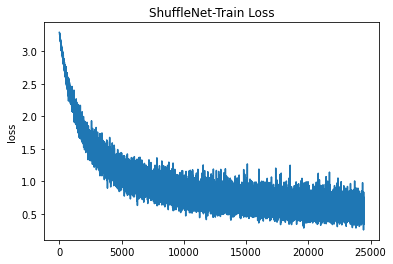

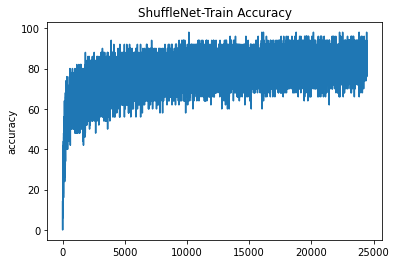

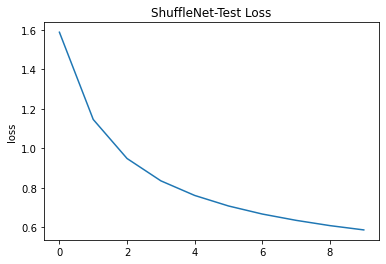

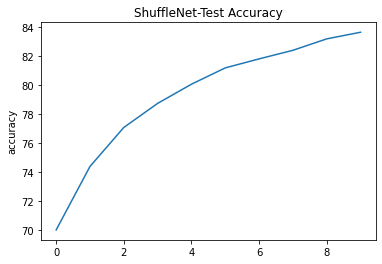

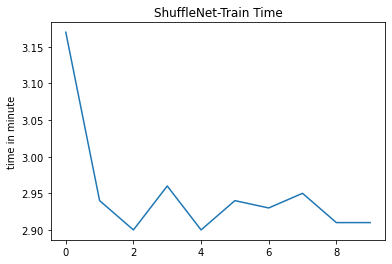

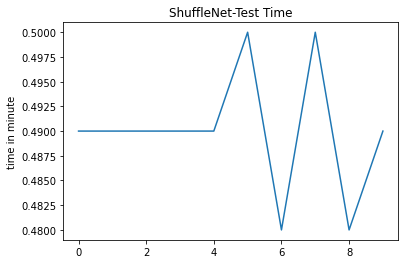

2.9509999999999996
29.509999999999998


In [11]:
# Plot train_loss and train_accuracy
plt.plot(train_loss_tracker)
plt.title('ShuffleNet-Train Loss')
plt.ylabel('loss')
plt.show()
plt.plot(train_accuracy_tracker)
plt.title('ShuffleNet-Train Accuracy')
plt.ylabel('accuracy')
plt.show()
# Plot test_loss and test_accuracy
plt.plot(test_loss_tracker)
plt.title('ShuffleNet-Test Loss')
plt.ylabel('loss')
plt.show()
plt.plot(test_accuracy_tracker)
plt.title('ShuffleNet-Test Accuracy')
plt.ylabel('accuracy')
plt.show()
# Plot train time
train_time_tracker_in_minute = []
for num in train_time_tracker:
    train_time_tracker_in_minute.append(round(num/60, 2))
plt.plot(train_time_tracker_in_minute)
plt.title('ShuffleNet-Train Time')
plt.ylabel('time in minute')
plt.show()
# Plot test time
test_time_tracker_in_minute = []
for num in test_time_tracker:
    test_time_tracker_in_minute.append(round(num/60, 2))
plt.plot(test_time_tracker_in_minute)
plt.title('ShuffleNet-Test Time')
plt.ylabel('time in minute')
plt.show()

print(sum(train_time_tracker_in_minute)/10)
print(sum(train_time_tracker_in_minute))

In [12]:
epochs = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(efficientnet_b0.parameters(), lr = learning_rate)

# Train and test EfficientNet baseline
model = efficientnet_b0

train_loss_tracker = []
train_accuracy_tracker = []
train_time_tracker = []
test_loss_tracker = []
test_accuracy_tracker = []
test_time_tracker = []

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    train_start_time = time.time()
    train_loss,train_accuracy = Train(model,optimizer,emnist_train_loader,device)
    train_end_time = time.time()
    train_time_tracker.append(train_end_time-train_start_time)
    test_start_time = time.time()
    test_loss , test_accuracy = Test(model,emnist_test_loader,device)
    test_end_time = time.time()
    test_time_tracker.append(test_end_time-test_start_time)
    train_loss_tracker.extend(train_loss)
    train_accuracy_tracker.extend(train_accuracy)
    test_loss_tracker.append(test_loss)
    test_accuracy_tracker.append(test_accuracy)
    print('\t training loss/accuracy: {0:.2f}/{1:.2f}'.format(sum(train_loss)/len(train_loss), sum(train_accuracy)/len((train_accuracy))))
    print('\t testing loss/accuracy: {0:.2f}/{1:.2f}'.format(test_loss, test_accuracy))

Epoch: 0
step: 2, loss = 3.3195
step: 3, loss = 3.2412
step: 4, loss = 3.2089
step: 5, loss = 3.1288
step: 6, loss = 3.1562
step: 7, loss = 3.0673
step: 8, loss = 3.1603
step: 9, loss = 3.0256
step: 10, loss = 2.9930
step: 11, loss = 3.0251
step: 12, loss = 3.0912
step: 13, loss = 2.8562
step: 14, loss = 2.8578
step: 15, loss = 2.9893
step: 16, loss = 2.9306
step: 17, loss = 2.8269
step: 18, loss = 2.7686
step: 19, loss = 2.7390
step: 20, loss = 2.7119
step: 21, loss = 2.6493
step: 22, loss = 2.6658
step: 23, loss = 2.5546
step: 24, loss = 2.5199
step: 25, loss = 2.5176
step: 26, loss = 2.4738
step: 27, loss = 2.5477
step: 28, loss = 2.5096
step: 29, loss = 2.4279
step: 30, loss = 2.6065
step: 31, loss = 2.4675
step: 32, loss = 2.5732
step: 33, loss = 2.2653
step: 34, loss = 2.3641
step: 35, loss = 2.3499
step: 36, loss = 2.2861
step: 37, loss = 2.4262
step: 38, loss = 2.3526
step: 39, loss = 2.4581
step: 40, loss = 2.4158
step: 41, loss = 2.3163
step: 42, loss = 2.2409
step: 43, loss 

step: 340, loss = 1.1000
step: 341, loss = 1.2742
step: 342, loss = 0.9013
step: 343, loss = 1.1005
step: 344, loss = 1.2754
step: 345, loss = 0.9208
step: 346, loss = 1.0495
step: 347, loss = 0.9279
step: 348, loss = 1.2925
step: 349, loss = 0.9482
step: 350, loss = 1.1408
step: 352, loss = 0.9984
step: 353, loss = 0.9855
step: 354, loss = 0.9208
step: 355, loss = 0.9879
step: 356, loss = 0.8202
step: 357, loss = 1.1064
step: 358, loss = 0.9246
step: 359, loss = 0.9229
step: 360, loss = 1.2556
step: 361, loss = 1.3795
step: 362, loss = 1.0236
step: 363, loss = 1.0991
step: 364, loss = 1.0993
step: 365, loss = 1.0524
step: 366, loss = 0.9009
step: 367, loss = 1.2713
step: 368, loss = 1.0284
step: 369, loss = 1.2972
step: 370, loss = 0.9142
step: 371, loss = 0.8648
step: 372, loss = 1.1438
step: 373, loss = 0.8360
step: 374, loss = 1.1440
step: 375, loss = 0.8808
step: 376, loss = 0.9819
step: 377, loss = 1.1507
step: 378, loss = 1.0015
step: 379, loss = 0.9122
step: 380, loss = 1.1335


step: 677, loss = 0.9583
step: 678, loss = 0.5462
step: 679, loss = 0.9582
step: 680, loss = 0.7287
step: 681, loss = 0.8087
step: 682, loss = 0.9306
step: 683, loss = 0.7261
step: 684, loss = 0.8350
step: 685, loss = 0.7477
step: 686, loss = 0.6852
step: 687, loss = 0.8612
step: 688, loss = 0.5105
step: 689, loss = 0.9417
step: 690, loss = 0.8086
step: 691, loss = 0.8015
step: 692, loss = 0.8226
step: 693, loss = 0.9873
step: 694, loss = 0.8655
step: 695, loss = 0.8678
step: 696, loss = 0.7540
step: 697, loss = 0.7706
step: 698, loss = 1.1162
step: 699, loss = 0.7969
step: 700, loss = 0.8586
step: 702, loss = 0.6422
step: 703, loss = 0.8852
step: 704, loss = 0.9397
step: 705, loss = 0.7772
step: 706, loss = 0.7820
step: 707, loss = 0.7385
step: 708, loss = 0.6175
step: 709, loss = 0.6382
step: 710, loss = 0.7612
step: 711, loss = 0.7942
step: 712, loss = 0.8002
step: 713, loss = 0.8118
step: 714, loss = 0.7022
step: 715, loss = 0.8731
step: 716, loss = 0.7949
step: 717, loss = 0.7614


step: 1013, loss = 0.9247
step: 1014, loss = 0.7031
step: 1015, loss = 0.7155
step: 1016, loss = 0.5717
step: 1017, loss = 0.6718
step: 1018, loss = 0.6882
step: 1019, loss = 0.6354
step: 1020, loss = 0.6921
step: 1021, loss = 0.5560
step: 1022, loss = 0.7241
step: 1023, loss = 0.8480
step: 1024, loss = 0.6514
step: 1025, loss = 0.6240
step: 1026, loss = 0.7198
step: 1027, loss = 0.7807
step: 1028, loss = 0.7357
step: 1029, loss = 0.8646
step: 1030, loss = 0.8634
step: 1031, loss = 0.6515
step: 1032, loss = 0.5056
step: 1033, loss = 0.6203
step: 1034, loss = 0.6907
step: 1035, loss = 0.9475
step: 1036, loss = 0.6581
step: 1037, loss = 0.6699
step: 1038, loss = 0.7179
step: 1039, loss = 0.7634
step: 1040, loss = 0.5990
step: 1041, loss = 0.5313
step: 1042, loss = 0.9136
step: 1043, loss = 0.6273
step: 1044, loss = 0.5652
step: 1045, loss = 0.4780
step: 1046, loss = 0.5854
step: 1047, loss = 0.7184
step: 1048, loss = 0.5457
step: 1049, loss = 0.6001
step: 1050, loss = 0.5629
step: 1052, 

step: 1337, loss = 0.8627
step: 1338, loss = 0.5660
step: 1339, loss = 0.9197
step: 1340, loss = 0.6821
step: 1341, loss = 0.6461
step: 1342, loss = 0.6237
step: 1343, loss = 0.6319
step: 1344, loss = 0.9255
step: 1345, loss = 0.4198
step: 1346, loss = 0.6161
step: 1347, loss = 0.5034
step: 1348, loss = 0.5041
step: 1349, loss = 0.6108
step: 1350, loss = 0.7418
step: 1352, loss = 0.6550
step: 1353, loss = 0.7593
step: 1354, loss = 0.6047
step: 1355, loss = 0.4675
step: 1356, loss = 0.4174
step: 1357, loss = 0.5681
step: 1358, loss = 0.6031
step: 1359, loss = 1.0310
step: 1360, loss = 0.7645
step: 1361, loss = 0.5776
step: 1362, loss = 0.7133
step: 1363, loss = 0.5471
step: 1364, loss = 0.6379
step: 1365, loss = 0.6354
step: 1366, loss = 0.5667
step: 1367, loss = 0.6708
step: 1368, loss = 0.6118
step: 1369, loss = 0.5675
step: 1370, loss = 0.8505
step: 1371, loss = 0.5402
step: 1372, loss = 0.6108
step: 1373, loss = 0.6757
step: 1374, loss = 0.6928
step: 1375, loss = 0.6171
step: 1376, 

step: 1662, loss = 0.5240
step: 1663, loss = 0.4159
step: 1664, loss = 0.6122
step: 1665, loss = 0.3862
step: 1666, loss = 0.7500
step: 1667, loss = 0.4268
step: 1668, loss = 0.4231
step: 1669, loss = 0.5242
step: 1670, loss = 0.4726
step: 1671, loss = 0.5312
step: 1672, loss = 0.7778
step: 1673, loss = 0.5917
step: 1674, loss = 0.8750
step: 1675, loss = 0.7768
step: 1676, loss = 0.5777
step: 1677, loss = 0.6063
step: 1678, loss = 0.5654
step: 1679, loss = 0.6912
step: 1680, loss = 0.7830
step: 1681, loss = 0.6002
step: 1682, loss = 0.5452
step: 1683, loss = 0.4835
step: 1684, loss = 0.5182
step: 1685, loss = 0.5336
step: 1686, loss = 0.5938
step: 1687, loss = 0.3372
step: 1688, loss = 0.3754
step: 1689, loss = 0.3709
step: 1690, loss = 0.4538
step: 1691, loss = 0.5357
step: 1692, loss = 0.4787
step: 1693, loss = 0.6121
step: 1694, loss = 0.7379
step: 1695, loss = 0.5128
step: 1696, loss = 0.6294
step: 1697, loss = 0.8239
step: 1698, loss = 0.5236
step: 1699, loss = 0.9011
step: 1700, 

step: 1985, loss = 0.4967
step: 1986, loss = 0.6258
step: 1987, loss = 0.4019
step: 1988, loss = 0.5814
step: 1989, loss = 0.6596
step: 1990, loss = 0.4600
step: 1991, loss = 0.7091
step: 1992, loss = 0.4847
step: 1993, loss = 0.7639
step: 1994, loss = 0.5804
step: 1995, loss = 0.3954
step: 1996, loss = 0.4622
step: 1997, loss = 0.5496
step: 1998, loss = 0.4733
step: 1999, loss = 0.3653
step: 2000, loss = 0.5423
step: 2002, loss = 0.4615
step: 2003, loss = 0.5344
step: 2004, loss = 0.7047
step: 2005, loss = 0.6760
step: 2006, loss = 0.6054
step: 2007, loss = 0.7068
step: 2008, loss = 0.3906
step: 2009, loss = 0.3932
step: 2010, loss = 0.5274
step: 2011, loss = 0.5743
step: 2012, loss = 0.5063
step: 2013, loss = 0.7115
step: 2014, loss = 0.4784
step: 2015, loss = 0.5283
step: 2016, loss = 0.6350
step: 2017, loss = 0.4492
step: 2018, loss = 0.4731
step: 2019, loss = 0.4907
step: 2020, loss = 0.7366
step: 2021, loss = 0.3081
step: 2022, loss = 0.7408
step: 2023, loss = 0.5313
step: 2024, 

step: 2308, loss = 0.7919
step: 2309, loss = 0.3306
step: 2310, loss = 0.4361
step: 2311, loss = 0.7116
step: 2312, loss = 0.4754
step: 2313, loss = 0.5852
step: 2314, loss = 0.3961
step: 2315, loss = 0.3659
step: 2316, loss = 0.3082
step: 2317, loss = 0.5303
step: 2318, loss = 0.4464
step: 2319, loss = 0.5093
step: 2320, loss = 0.3458
step: 2321, loss = 0.4675
step: 2322, loss = 0.5300
step: 2323, loss = 0.4427
step: 2324, loss = 0.7396
step: 2325, loss = 0.4503
step: 2326, loss = 0.7061
step: 2327, loss = 0.3558
step: 2328, loss = 0.4302
step: 2329, loss = 0.3157
step: 2330, loss = 0.5519
step: 2331, loss = 0.4305
step: 2332, loss = 0.4528
step: 2333, loss = 0.4887
step: 2334, loss = 0.5875
step: 2335, loss = 0.5001
step: 2336, loss = 0.3493
step: 2337, loss = 0.4246
step: 2338, loss = 0.5268
step: 2339, loss = 0.5530
step: 2340, loss = 0.4514
step: 2341, loss = 0.4925
step: 2342, loss = 0.3357
step: 2343, loss = 0.4461
step: 2344, loss = 0.5398
step: 2345, loss = 0.3718
step: 2346, 

step: 140, loss = 0.3839
step: 141, loss = 0.6442
step: 142, loss = 0.3279
step: 143, loss = 0.5532
step: 144, loss = 0.5240
step: 145, loss = 0.3601
step: 146, loss = 0.4145
step: 147, loss = 0.8069
step: 148, loss = 0.4875
step: 149, loss = 0.5258
step: 150, loss = 0.6222
step: 152, loss = 0.4808
step: 153, loss = 0.2843
step: 154, loss = 0.5078
step: 155, loss = 0.4969
step: 156, loss = 0.3913
step: 157, loss = 0.5652
step: 158, loss = 0.5307
step: 159, loss = 0.3891
step: 160, loss = 0.4598
step: 161, loss = 0.3072
step: 162, loss = 0.7300
step: 163, loss = 0.6060
step: 164, loss = 0.7535
step: 165, loss = 0.3930
step: 166, loss = 0.7232
step: 167, loss = 0.4597
step: 168, loss = 0.3520
step: 169, loss = 0.3323
step: 170, loss = 0.4247
step: 171, loss = 0.4486
step: 172, loss = 0.6378
step: 173, loss = 0.3928
step: 174, loss = 0.4766
step: 175, loss = 0.4361
step: 176, loss = 0.4674
step: 177, loss = 0.4921
step: 178, loss = 0.4480
step: 179, loss = 0.3242
step: 180, loss = 0.5833


step: 475, loss = 0.5086
step: 476, loss = 0.3633
step: 477, loss = 0.3308
step: 478, loss = 0.4654
step: 479, loss = 0.7221
step: 480, loss = 0.3008
step: 481, loss = 0.3460
step: 482, loss = 0.3064
step: 483, loss = 0.3840
step: 484, loss = 0.7364
step: 485, loss = 0.4466
step: 486, loss = 0.4701
step: 487, loss = 0.5215
step: 488, loss = 0.2961
step: 489, loss = 0.3434
step: 490, loss = 0.4101
step: 491, loss = 0.4658
step: 492, loss = 0.5245
step: 493, loss = 0.5685
step: 494, loss = 0.5306
step: 495, loss = 0.4086
step: 496, loss = 0.4104
step: 497, loss = 0.4824
step: 498, loss = 0.3473
step: 499, loss = 0.4552
step: 500, loss = 0.4264
step: 502, loss = 0.3541
step: 503, loss = 0.5610
step: 504, loss = 0.4561
step: 505, loss = 0.4881
step: 506, loss = 0.5113
step: 507, loss = 0.4686
step: 508, loss = 0.5993
step: 509, loss = 0.4238
step: 510, loss = 0.4373
step: 511, loss = 0.4099
step: 512, loss = 0.4998
step: 513, loss = 0.4373
step: 514, loss = 0.3131
step: 515, loss = 0.3741


step: 812, loss = 0.3043
step: 813, loss = 0.3772
step: 814, loss = 0.3286
step: 815, loss = 0.4321
step: 816, loss = 0.7156
step: 817, loss = 0.6326
step: 818, loss = 0.6025
step: 819, loss = 0.4851
step: 820, loss = 0.4832
step: 821, loss = 0.4210
step: 822, loss = 0.2403
step: 823, loss = 0.4688
step: 824, loss = 0.5537
step: 825, loss = 0.5138
step: 826, loss = 0.3339
step: 827, loss = 0.5083
step: 828, loss = 0.5218
step: 829, loss = 0.6029
step: 830, loss = 0.3681
step: 831, loss = 0.3722
step: 832, loss = 0.3451
step: 833, loss = 0.4857
step: 834, loss = 0.4365
step: 835, loss = 0.5337
step: 836, loss = 0.3649
step: 837, loss = 0.3970
step: 838, loss = 0.6987
step: 839, loss = 0.4257
step: 840, loss = 0.4994
step: 841, loss = 0.3881
step: 842, loss = 0.4179
step: 843, loss = 0.3761
step: 844, loss = 0.3995
step: 845, loss = 0.2785
step: 846, loss = 0.6534
step: 847, loss = 0.3768
step: 848, loss = 0.5002
step: 849, loss = 0.4228
step: 850, loss = 0.5326
step: 852, loss = 0.3839


step: 1141, loss = 0.3983
step: 1142, loss = 0.5110
step: 1143, loss = 0.4007
step: 1144, loss = 0.5475
step: 1145, loss = 0.6391
step: 1146, loss = 0.6217
step: 1147, loss = 0.6234
step: 1148, loss = 0.4209
step: 1149, loss = 0.4131
step: 1150, loss = 0.6029
step: 1152, loss = 0.5160
step: 1153, loss = 0.2713
step: 1154, loss = 0.4654
step: 1155, loss = 0.5048
step: 1156, loss = 0.6076
step: 1157, loss = 0.5476
step: 1158, loss = 0.3775
step: 1159, loss = 0.3695
step: 1160, loss = 0.2282
step: 1161, loss = 0.5626
step: 1162, loss = 0.5668
step: 1163, loss = 0.3760
step: 1164, loss = 0.3869
step: 1165, loss = 0.3208
step: 1166, loss = 0.3531
step: 1167, loss = 0.3957
step: 1168, loss = 0.4659
step: 1169, loss = 0.2401
step: 1170, loss = 0.5026
step: 1171, loss = 0.6587
step: 1172, loss = 0.3916
step: 1173, loss = 0.4337
step: 1174, loss = 0.2927
step: 1175, loss = 0.3490
step: 1176, loss = 0.5579
step: 1177, loss = 0.3737
step: 1178, loss = 0.4218
step: 1179, loss = 0.4748
step: 1180, 

step: 1465, loss = 0.2861
step: 1466, loss = 0.5039
step: 1467, loss = 0.4746
step: 1468, loss = 0.3248
step: 1469, loss = 0.5660
step: 1470, loss = 0.2586
step: 1471, loss = 0.3603
step: 1472, loss = 0.5496
step: 1473, loss = 0.4798
step: 1474, loss = 0.4726
step: 1475, loss = 0.4100
step: 1476, loss = 0.3755
step: 1477, loss = 0.2908
step: 1478, loss = 0.5633
step: 1479, loss = 0.3448
step: 1480, loss = 0.2941
step: 1481, loss = 0.6365
step: 1482, loss = 0.4058
step: 1483, loss = 0.3034
step: 1484, loss = 0.3644
step: 1485, loss = 0.3124
step: 1486, loss = 0.4356
step: 1487, loss = 0.6323
step: 1488, loss = 0.6002
step: 1489, loss = 0.3128
step: 1490, loss = 0.3245
step: 1491, loss = 0.4715
step: 1492, loss = 0.3357
step: 1493, loss = 0.6263
step: 1494, loss = 0.5437
step: 1495, loss = 0.4489
step: 1496, loss = 0.3521
step: 1497, loss = 0.4041
step: 1498, loss = 0.6226
step: 1499, loss = 0.3608
step: 1500, loss = 0.5895
step: 1502, loss = 0.4615
step: 1503, loss = 0.2699
step: 1504, 

step: 1788, loss = 0.3636
step: 1789, loss = 0.3638
step: 1790, loss = 0.2630
step: 1791, loss = 0.3383
step: 1792, loss = 0.4387
step: 1793, loss = 0.3095
step: 1794, loss = 0.3935
step: 1795, loss = 0.4921
step: 1796, loss = 0.3897
step: 1797, loss = 0.3187
step: 1798, loss = 0.2735
step: 1799, loss = 0.2373
step: 1800, loss = 0.3856
step: 1802, loss = 0.3870
step: 1803, loss = 0.3422
step: 1804, loss = 0.3382
step: 1805, loss = 0.4213
step: 1806, loss = 0.4714
step: 1807, loss = 0.5994
step: 1808, loss = 0.4084
step: 1809, loss = 0.3722
step: 1810, loss = 0.5232
step: 1811, loss = 0.2380
step: 1812, loss = 0.5115
step: 1813, loss = 0.5889
step: 1814, loss = 0.4258
step: 1815, loss = 0.3938
step: 1816, loss = 0.6275
step: 1817, loss = 0.4707
step: 1818, loss = 0.4627
step: 1819, loss = 0.4041
step: 1820, loss = 0.4904
step: 1821, loss = 0.5355
step: 1822, loss = 0.3466
step: 1823, loss = 0.5114
step: 1824, loss = 0.2942
step: 1825, loss = 0.5283
step: 1826, loss = 0.4096
step: 1827, 

step: 2111, loss = 0.2498
step: 2112, loss = 0.5346
step: 2113, loss = 0.3010
step: 2114, loss = 0.1445
step: 2115, loss = 0.4073
step: 2116, loss = 0.4317
step: 2117, loss = 0.3156
step: 2118, loss = 0.3468
step: 2119, loss = 0.5235
step: 2120, loss = 0.4450
step: 2121, loss = 0.4071
step: 2122, loss = 0.3625
step: 2123, loss = 0.3840
step: 2124, loss = 0.2082
step: 2125, loss = 0.5365
step: 2126, loss = 0.3826
step: 2127, loss = 0.3582
step: 2128, loss = 0.2975
step: 2129, loss = 0.1967
step: 2130, loss = 0.3720
step: 2131, loss = 0.5519
step: 2132, loss = 0.5025
step: 2133, loss = 0.5029
step: 2134, loss = 0.4329
step: 2135, loss = 0.4706
step: 2136, loss = 0.2495
step: 2137, loss = 0.3465
step: 2138, loss = 0.7637
step: 2139, loss = 0.3303
step: 2140, loss = 0.5394
step: 2141, loss = 0.3108
step: 2142, loss = 0.5377
step: 2143, loss = 0.4065
step: 2144, loss = 0.4649
step: 2145, loss = 0.5533
step: 2146, loss = 0.4389
step: 2147, loss = 0.4582
step: 2148, loss = 0.3445
step: 2149, 

step: 2433, loss = 0.3904
step: 2434, loss = 0.3531
step: 2435, loss = 0.5620
step: 2436, loss = 0.4575
step: 2437, loss = 0.4310
step: 2438, loss = 0.3225
step: 2439, loss = 0.3941
step: 2440, loss = 0.3803
step: 2441, loss = 0.3381
step: 2442, loss = 0.4471
step: 2443, loss = 0.4954
step: 2444, loss = 0.2488
step: 2445, loss = 0.5104
step: 2446, loss = 0.3268
step: 2447, loss = 0.5022
step: 2448, loss = 0.3539
step: 2449, loss = 0.4490
step: 2450, loss = 0.7006
step: 2452, loss = 0.2305
step: 2453, loss = 0.4268
step: 2454, loss = 0.6038
step: 2455, loss = 0.4201
step: 2456, loss = 0.3979
step: 2457, loss = 0.6245
step: 2458, loss = 0.3360
step: 2459, loss = 0.2887
step: 2460, loss = 0.4134
step: 2461, loss = 0.4383
step: 2462, loss = 0.3893
step: 2463, loss = 0.3584
step: 2464, loss = 0.3585
step: 2465, loss = 0.3205
step: 2466, loss = 0.4938
step: 2467, loss = 0.3201
step: 2468, loss = 0.3111
step: 2469, loss = 0.4800
step: 2470, loss = 0.3771
step: 2471, loss = 0.4536
step: 2472, 

step: 271, loss = 0.2856
step: 272, loss = 0.2578
step: 273, loss = 0.5451
step: 274, loss = 0.3214
step: 275, loss = 0.5558
step: 276, loss = 0.3986
step: 277, loss = 0.4111
step: 278, loss = 0.2972
step: 279, loss = 0.3024
step: 280, loss = 0.2716
step: 281, loss = 0.4901
step: 282, loss = 0.3705
step: 283, loss = 0.4238
step: 284, loss = 0.2548
step: 285, loss = 0.4907
step: 286, loss = 0.4078
step: 287, loss = 0.2406
step: 288, loss = 0.3721
step: 289, loss = 0.5168
step: 290, loss = 0.2979
step: 291, loss = 0.4411
step: 292, loss = 0.2241
step: 293, loss = 0.2855
step: 294, loss = 0.6020
step: 295, loss = 0.3355
step: 296, loss = 0.3846
step: 297, loss = 0.4781
step: 298, loss = 0.4600
step: 299, loss = 0.4231
step: 300, loss = 0.4973
step: 302, loss = 0.3919
step: 303, loss = 0.4071
step: 304, loss = 0.4132
step: 305, loss = 0.3330
step: 306, loss = 0.4989
step: 307, loss = 0.2434
step: 308, loss = 0.3097
step: 309, loss = 0.2926
step: 310, loss = 0.4098
step: 311, loss = 0.3219


step: 608, loss = 0.5958
step: 609, loss = 0.3075
step: 610, loss = 0.3162
step: 611, loss = 0.3413
step: 612, loss = 0.3815
step: 613, loss = 0.3621
step: 614, loss = 0.4354
step: 615, loss = 0.2528
step: 616, loss = 0.2992
step: 617, loss = 0.3287
step: 618, loss = 0.3006
step: 619, loss = 0.3315
step: 620, loss = 0.5289
step: 621, loss = 0.2064
step: 622, loss = 0.4573
step: 623, loss = 0.3086
step: 624, loss = 0.3955
step: 625, loss = 0.7179
step: 626, loss = 0.4102
step: 627, loss = 0.2904
step: 628, loss = 0.3224
step: 629, loss = 0.5559
step: 630, loss = 0.4724
step: 631, loss = 0.2821
step: 632, loss = 0.2705
step: 633, loss = 0.4053
step: 634, loss = 0.3301
step: 635, loss = 0.3819
step: 636, loss = 0.4965
step: 637, loss = 0.4748
step: 638, loss = 0.3603
step: 639, loss = 0.1927
step: 640, loss = 0.3392
step: 641, loss = 0.2968
step: 642, loss = 0.2374
step: 643, loss = 0.5192
step: 644, loss = 0.5446
step: 645, loss = 0.3969
step: 646, loss = 0.2659
step: 647, loss = 0.3268


step: 942, loss = 0.4314
step: 943, loss = 0.5653
step: 944, loss = 0.3769
step: 945, loss = 0.3643
step: 946, loss = 0.3860
step: 947, loss = 0.4462
step: 948, loss = 0.6015
step: 949, loss = 0.3219
step: 950, loss = 0.4142
step: 952, loss = 0.3352
step: 953, loss = 0.3005
step: 954, loss = 0.2516
step: 955, loss = 0.2486
step: 956, loss = 0.4951
step: 957, loss = 0.2457
step: 958, loss = 0.4718
step: 959, loss = 0.5343
step: 960, loss = 0.4575
step: 961, loss = 0.4190
step: 962, loss = 0.3503
step: 963, loss = 0.6631
step: 964, loss = 0.3609
step: 965, loss = 0.5663
step: 966, loss = 0.2859
step: 967, loss = 0.4585
step: 968, loss = 0.3631
step: 969, loss = 0.8224
step: 970, loss = 0.3537
step: 971, loss = 0.3094
step: 972, loss = 0.4040
step: 973, loss = 0.2932
step: 974, loss = 0.2219
step: 975, loss = 0.2849
step: 976, loss = 0.3592
step: 977, loss = 0.4140
step: 978, loss = 0.2948
step: 979, loss = 0.2167
step: 980, loss = 0.2981
step: 981, loss = 0.5207
step: 982, loss = 0.2541


step: 1268, loss = 0.3046
step: 1269, loss = 0.2514
step: 1270, loss = 0.4781
step: 1271, loss = 0.6204
step: 1272, loss = 0.4226
step: 1273, loss = 0.4704
step: 1274, loss = 0.3112
step: 1275, loss = 0.3699
step: 1276, loss = 0.4653
step: 1277, loss = 0.4651
step: 1278, loss = 0.2587
step: 1279, loss = 0.3933
step: 1280, loss = 0.4398
step: 1281, loss = 0.2649
step: 1282, loss = 0.3565
step: 1283, loss = 0.4798
step: 1284, loss = 0.5002
step: 1285, loss = 0.4567
step: 1286, loss = 0.2957
step: 1287, loss = 0.3783
step: 1288, loss = 0.1961
step: 1289, loss = 0.3128
step: 1290, loss = 0.2370
step: 1291, loss = 0.4894
step: 1292, loss = 0.3143
step: 1293, loss = 0.3893
step: 1294, loss = 0.2027
step: 1295, loss = 0.3492
step: 1296, loss = 0.4275
step: 1297, loss = 0.4384
step: 1298, loss = 0.6866
step: 1299, loss = 0.4659
step: 1300, loss = 0.3260
step: 1302, loss = 0.3568
step: 1303, loss = 0.4066
step: 1304, loss = 0.6401
step: 1305, loss = 0.4018
step: 1306, loss = 0.3923
step: 1307, 

step: 1590, loss = 0.3289
step: 1591, loss = 0.3649
step: 1592, loss = 0.2124
step: 1593, loss = 0.3328
step: 1594, loss = 0.3093
step: 1595, loss = 0.3517
step: 1596, loss = 0.4267
step: 1597, loss = 0.3129
step: 1598, loss = 0.2808
step: 1599, loss = 0.4242
step: 1600, loss = 0.2949
step: 1602, loss = 0.6503
step: 1603, loss = 0.3231
step: 1604, loss = 0.2329
step: 1605, loss = 0.2770
step: 1606, loss = 0.2365
step: 1607, loss = 0.4365
step: 1608, loss = 0.3490
step: 1609, loss = 0.4049
step: 1610, loss = 0.3367
step: 1611, loss = 0.4474
step: 1612, loss = 0.3908
step: 1613, loss = 0.4586
step: 1614, loss = 0.4588
step: 1615, loss = 0.2083
step: 1616, loss = 0.2453
step: 1617, loss = 0.3433
step: 1618, loss = 0.3106
step: 1619, loss = 0.3250
step: 1620, loss = 0.4598
step: 1621, loss = 0.2506
step: 1622, loss = 0.2816
step: 1623, loss = 0.3128
step: 1624, loss = 0.4932
step: 1625, loss = 0.2220
step: 1626, loss = 0.1882
step: 1627, loss = 0.2992
step: 1628, loss = 0.3062
step: 1629, 

step: 1913, loss = 0.3863
step: 1914, loss = 0.3090
step: 1915, loss = 0.4413
step: 1916, loss = 0.3073
step: 1917, loss = 0.4843
step: 1918, loss = 0.5055
step: 1919, loss = 0.5357
step: 1920, loss = 0.3201
step: 1921, loss = 0.3546
step: 1922, loss = 0.3335
step: 1923, loss = 0.4911
step: 1924, loss = 0.1953
step: 1925, loss = 0.3782
step: 1926, loss = 0.2248
step: 1927, loss = 0.2599
step: 1928, loss = 0.2047
step: 1929, loss = 0.3052
step: 1930, loss = 0.4393
step: 1931, loss = 0.4704
step: 1932, loss = 0.2987
step: 1933, loss = 0.3445
step: 1934, loss = 0.8443
step: 1935, loss = 0.3959
step: 1936, loss = 0.3706
step: 1937, loss = 0.3652
step: 1938, loss = 0.3000
step: 1939, loss = 0.2793
step: 1940, loss = 0.2989
step: 1941, loss = 0.2003
step: 1942, loss = 0.2376
step: 1943, loss = 0.4986
step: 1944, loss = 0.3000
step: 1945, loss = 0.3028
step: 1946, loss = 0.3039
step: 1947, loss = 0.4196
step: 1948, loss = 0.2199
step: 1949, loss = 0.2604
step: 1950, loss = 0.2676
step: 1952, 

step: 2237, loss = 0.2165
step: 2238, loss = 0.4050
step: 2239, loss = 0.3136
step: 2240, loss = 0.4595
step: 2241, loss = 0.4478
step: 2242, loss = 0.3771
step: 2243, loss = 0.3656
step: 2244, loss = 0.3487
step: 2245, loss = 0.2536
step: 2246, loss = 0.2474
step: 2247, loss = 0.4271
step: 2248, loss = 0.2598
step: 2249, loss = 0.2271
step: 2250, loss = 0.4561
step: 2252, loss = 0.3390
step: 2253, loss = 0.3093
step: 2254, loss = 0.1754
step: 2255, loss = 0.2149
step: 2256, loss = 0.3980
step: 2257, loss = 0.1989
step: 2258, loss = 0.3305
step: 2259, loss = 0.4523
step: 2260, loss = 0.2733
step: 2261, loss = 0.6001
step: 2262, loss = 0.2643
step: 2263, loss = 0.2835
step: 2264, loss = 0.2220
step: 2265, loss = 0.2672
step: 2266, loss = 0.2770
step: 2267, loss = 0.4770
step: 2268, loss = 0.2898
step: 2269, loss = 0.4287
step: 2270, loss = 0.4394
step: 2271, loss = 0.3343
step: 2272, loss = 0.4186
step: 2273, loss = 0.2768
step: 2274, loss = 0.2749
step: 2275, loss = 0.4840
step: 2276, 

step: 68, loss = 0.2040
step: 69, loss = 0.2874
step: 70, loss = 0.2294
step: 71, loss = 0.2330
step: 72, loss = 0.3461
step: 73, loss = 0.3535
step: 74, loss = 0.2139
step: 75, loss = 0.3344
step: 76, loss = 0.4352
step: 77, loss = 0.4155
step: 78, loss = 0.7128
step: 79, loss = 0.4358
step: 80, loss = 0.3130
step: 81, loss = 0.3508
step: 82, loss = 0.2642
step: 83, loss = 0.3371
step: 84, loss = 0.2692
step: 85, loss = 0.3115
step: 86, loss = 0.3430
step: 87, loss = 0.2046
step: 88, loss = 0.2840
step: 89, loss = 0.2522
step: 90, loss = 0.5109
step: 91, loss = 0.3242
step: 92, loss = 0.3109
step: 93, loss = 0.2372
step: 94, loss = 0.3311
step: 95, loss = 0.2541
step: 96, loss = 0.4781
step: 97, loss = 0.5018
step: 98, loss = 0.2001
step: 99, loss = 0.5343
step: 100, loss = 0.4398
step: 102, loss = 0.3980
step: 103, loss = 0.6313
step: 104, loss = 0.2737
step: 105, loss = 0.2345
step: 106, loss = 0.2944
step: 107, loss = 0.3698
step: 108, loss = 0.2785
step: 109, loss = 0.2665
step: 1

step: 405, loss = 0.4795
step: 406, loss = 0.3009
step: 407, loss = 0.2542
step: 408, loss = 0.2121
step: 409, loss = 0.2267
step: 410, loss = 0.5281
step: 411, loss = 0.5308
step: 412, loss = 0.4194
step: 413, loss = 0.2110
step: 414, loss = 0.3360
step: 415, loss = 0.5016
step: 416, loss = 0.2076
step: 417, loss = 0.4702
step: 418, loss = 0.4756
step: 419, loss = 0.3069
step: 420, loss = 0.2670
step: 421, loss = 0.3615
step: 422, loss = 0.1977
step: 423, loss = 0.2988
step: 424, loss = 0.2625
step: 425, loss = 0.3443
step: 426, loss = 0.4521
step: 427, loss = 0.3746
step: 428, loss = 0.3818
step: 429, loss = 0.3226
step: 430, loss = 0.5494
step: 431, loss = 0.4921
step: 432, loss = 0.5960
step: 433, loss = 0.2545
step: 434, loss = 0.3125
step: 435, loss = 0.3777
step: 436, loss = 0.3295
step: 437, loss = 0.3645
step: 438, loss = 0.2462
step: 439, loss = 0.3459
step: 440, loss = 0.2867
step: 441, loss = 0.2707
step: 442, loss = 0.2962
step: 443, loss = 0.3540
step: 444, loss = 0.4692


step: 740, loss = 0.2183
step: 741, loss = 0.3885
step: 742, loss = 0.2316
step: 743, loss = 0.2969
step: 744, loss = 0.1516
step: 745, loss = 0.5092
step: 746, loss = 0.2635
step: 747, loss = 0.2654
step: 748, loss = 0.4206
step: 749, loss = 0.4958
step: 750, loss = 0.1414
step: 752, loss = 0.2406
step: 753, loss = 0.2497
step: 754, loss = 0.5806
step: 755, loss = 0.1856
step: 756, loss = 0.3473
step: 757, loss = 0.2568
step: 758, loss = 0.3094
step: 759, loss = 0.2742
step: 760, loss = 0.3842
step: 761, loss = 0.4865
step: 762, loss = 0.2811
step: 763, loss = 0.2447
step: 764, loss = 0.3523
step: 765, loss = 0.2317
step: 766, loss = 0.2306
step: 767, loss = 0.4777
step: 768, loss = 0.4135
step: 769, loss = 0.2249
step: 770, loss = 0.2007
step: 771, loss = 0.5314
step: 772, loss = 0.4860
step: 773, loss = 0.2761
step: 774, loss = 0.5176
step: 775, loss = 0.4536
step: 776, loss = 0.2768
step: 777, loss = 0.2538
step: 778, loss = 0.2415
step: 779, loss = 0.4160
step: 780, loss = 0.1986


step: 1074, loss = 0.3565
step: 1075, loss = 0.2842
step: 1076, loss = 0.2373
step: 1077, loss = 0.2756
step: 1078, loss = 0.3206
step: 1079, loss = 0.2013
step: 1080, loss = 0.4513
step: 1081, loss = 0.2485
step: 1082, loss = 0.3153
step: 1083, loss = 0.4304
step: 1084, loss = 0.2413
step: 1085, loss = 0.3404
step: 1086, loss = 0.2113
step: 1087, loss = 0.2803
step: 1088, loss = 0.3470
step: 1089, loss = 0.4107
step: 1090, loss = 0.4190
step: 1091, loss = 0.1629
step: 1092, loss = 0.3992
step: 1093, loss = 0.3057
step: 1094, loss = 0.2564
step: 1095, loss = 0.3811
step: 1096, loss = 0.2411
step: 1097, loss = 0.2767
step: 1098, loss = 0.2305
step: 1099, loss = 0.3465
step: 1100, loss = 0.3620
step: 1102, loss = 0.2217
step: 1103, loss = 0.3012
step: 1104, loss = 0.1445
step: 1105, loss = 0.2815
step: 1106, loss = 0.3466
step: 1107, loss = 0.2795
step: 1108, loss = 0.4069
step: 1109, loss = 0.2914
step: 1110, loss = 0.5353
step: 1111, loss = 0.1692
step: 1112, loss = 0.3595
step: 1113, 

step: 1396, loss = 0.2689
step: 1397, loss = 0.3362
step: 1398, loss = 0.3488
step: 1399, loss = 0.3966
step: 1400, loss = 0.2780
step: 1402, loss = 0.3327
step: 1403, loss = 0.3935
step: 1404, loss = 0.2994
step: 1405, loss = 0.2208
step: 1406, loss = 0.5230
step: 1407, loss = 0.3497
step: 1408, loss = 0.5797
step: 1409, loss = 0.3643
step: 1410, loss = 0.2511
step: 1411, loss = 0.1039
step: 1412, loss = 0.4609
step: 1413, loss = 0.1995
step: 1414, loss = 0.2528
step: 1415, loss = 0.2517
step: 1416, loss = 0.3265
step: 1417, loss = 0.3235
step: 1418, loss = 0.2563
step: 1419, loss = 0.1649
step: 1420, loss = 0.1489
step: 1421, loss = 0.3166
step: 1422, loss = 0.3701
step: 1423, loss = 0.5300
step: 1424, loss = 0.4701
step: 1425, loss = 0.1936
step: 1426, loss = 0.2168
step: 1427, loss = 0.5742
step: 1428, loss = 0.1975
step: 1429, loss = 0.1948
step: 1430, loss = 0.2420
step: 1431, loss = 0.4622
step: 1432, loss = 0.2055
step: 1433, loss = 0.2996
step: 1434, loss = 0.4536
step: 1435, 

step: 1720, loss = 0.2700
step: 1721, loss = 0.3743
step: 1722, loss = 0.2238
step: 1723, loss = 0.3697
step: 1724, loss = 0.2805
step: 1725, loss = 0.1506
step: 1726, loss = 0.4249
step: 1727, loss = 0.2819
step: 1728, loss = 0.1472
step: 1729, loss = 0.2833
step: 1730, loss = 0.2219
step: 1731, loss = 0.3743
step: 1732, loss = 0.2396
step: 1733, loss = 0.2583
step: 1734, loss = 0.1139
step: 1735, loss = 0.4512
step: 1736, loss = 0.3052
step: 1737, loss = 0.2629
step: 1738, loss = 0.3170
step: 1739, loss = 0.4430
step: 1740, loss = 0.2097
step: 1741, loss = 0.4061
step: 1742, loss = 0.2810
step: 1743, loss = 0.2755
step: 1744, loss = 0.2368
step: 1745, loss = 0.2556
step: 1746, loss = 0.4379
step: 1747, loss = 0.2843
step: 1748, loss = 0.2401
step: 1749, loss = 0.2724
step: 1750, loss = 0.1499
step: 1752, loss = 0.1818
step: 1753, loss = 0.3123
step: 1754, loss = 0.3566
step: 1755, loss = 0.4969
step: 1756, loss = 0.4239
step: 1757, loss = 0.3443
step: 1758, loss = 0.4240
step: 1759, 

step: 2043, loss = 0.4756
step: 2044, loss = 0.3794
step: 2045, loss = 0.5240
step: 2046, loss = 0.1137
step: 2047, loss = 0.3841
step: 2048, loss = 0.3670
step: 2049, loss = 0.2637
step: 2050, loss = 0.2496
step: 2052, loss = 0.3189
step: 2053, loss = 0.4213
step: 2054, loss = 0.1701
step: 2055, loss = 0.2484
step: 2056, loss = 0.2316
step: 2057, loss = 0.5139
step: 2058, loss = 0.3423
step: 2059, loss = 0.4189
step: 2060, loss = 0.2852
step: 2061, loss = 0.3380
step: 2062, loss = 0.3490
step: 2063, loss = 0.4787
step: 2064, loss = 0.3581
step: 2065, loss = 0.3183
step: 2066, loss = 0.2584
step: 2067, loss = 0.3045
step: 2068, loss = 0.2290
step: 2069, loss = 0.4768
step: 2070, loss = 0.2887
step: 2071, loss = 0.2520
step: 2072, loss = 0.4426
step: 2073, loss = 0.1911
step: 2074, loss = 0.3131
step: 2075, loss = 0.2687
step: 2076, loss = 0.3153
step: 2077, loss = 0.4231
step: 2078, loss = 0.2235
step: 2079, loss = 0.2129
step: 2080, loss = 0.3612
step: 2081, loss = 0.2152
step: 2082, 

step: 2368, loss = 0.5087
step: 2369, loss = 0.1988
step: 2370, loss = 0.4961
step: 2371, loss = 0.1745
step: 2372, loss = 0.2053
step: 2373, loss = 0.5185
step: 2374, loss = 0.1428
step: 2375, loss = 0.3756
step: 2376, loss = 0.1785
step: 2377, loss = 0.2114
step: 2378, loss = 0.3596
step: 2379, loss = 0.1974
step: 2380, loss = 0.3088
step: 2381, loss = 0.3866
step: 2382, loss = 0.4602
step: 2383, loss = 0.2090
step: 2384, loss = 0.3914
step: 2385, loss = 0.3272
step: 2386, loss = 0.3639
step: 2387, loss = 0.5765
step: 2388, loss = 0.3541
step: 2389, loss = 0.2492
step: 2390, loss = 0.2893
step: 2391, loss = 0.2899
step: 2392, loss = 0.3573
step: 2393, loss = 0.1461
step: 2394, loss = 0.2045
step: 2395, loss = 0.2458
step: 2396, loss = 0.2366
step: 2397, loss = 0.3065
step: 2398, loss = 0.4306
step: 2399, loss = 0.3071
step: 2400, loss = 0.3385
step: 2402, loss = 0.3290
step: 2403, loss = 0.2113
step: 2404, loss = 0.2180
step: 2405, loss = 0.2975
step: 2406, loss = 0.2405
step: 2407, 

step: 203, loss = 0.1141
step: 204, loss = 0.2517
step: 205, loss = 0.2503
step: 206, loss = 0.3027
step: 207, loss = 0.3240
step: 208, loss = 0.2209
step: 209, loss = 0.2239
step: 210, loss = 0.2802
step: 211, loss = 0.2061
step: 212, loss = 0.4336
step: 213, loss = 0.2345
step: 214, loss = 0.1905
step: 215, loss = 0.3285
step: 216, loss = 0.1885
step: 217, loss = 0.2243
step: 218, loss = 0.1605
step: 219, loss = 0.2508
step: 220, loss = 0.2090
step: 221, loss = 0.3943
step: 222, loss = 0.2064
step: 223, loss = 0.2871
step: 224, loss = 0.2915
step: 225, loss = 0.2675
step: 226, loss = 0.3757
step: 227, loss = 0.2467
step: 228, loss = 0.2645
step: 229, loss = 0.3575
step: 230, loss = 0.3780
step: 231, loss = 0.3867
step: 232, loss = 0.3150
step: 233, loss = 0.3389
step: 234, loss = 0.1531
step: 235, loss = 0.4843
step: 236, loss = 0.1787
step: 237, loss = 0.3315
step: 238, loss = 0.2651
step: 239, loss = 0.4606
step: 240, loss = 0.1907
step: 241, loss = 0.1038
step: 242, loss = 0.2826


step: 539, loss = 0.2435
step: 540, loss = 0.4387
step: 541, loss = 0.2520
step: 542, loss = 0.2412
step: 543, loss = 0.2463
step: 544, loss = 0.3090
step: 545, loss = 0.3511
step: 546, loss = 0.2695
step: 547, loss = 0.1903
step: 548, loss = 0.3342
step: 549, loss = 0.1807
step: 550, loss = 0.1955
step: 552, loss = 0.1420
step: 553, loss = 0.2652
step: 554, loss = 0.3149
step: 555, loss = 0.3206
step: 556, loss = 0.5357
step: 557, loss = 0.2198
step: 558, loss = 0.2859
step: 559, loss = 0.2316
step: 560, loss = 0.3489
step: 561, loss = 0.3446
step: 562, loss = 0.3291
step: 563, loss = 0.3394
step: 564, loss = 0.3261
step: 565, loss = 0.2072
step: 566, loss = 0.3033
step: 567, loss = 0.2523
step: 568, loss = 0.3236
step: 569, loss = 0.3629
step: 570, loss = 0.2453
step: 571, loss = 0.3388
step: 572, loss = 0.1528
step: 573, loss = 0.3417
step: 574, loss = 0.3662
step: 575, loss = 0.2157
step: 576, loss = 0.3185
step: 577, loss = 0.4520
step: 578, loss = 0.3202
step: 579, loss = 0.1908


step: 875, loss = 0.1998
step: 876, loss = 0.2939
step: 877, loss = 0.5369
step: 878, loss = 0.4394
step: 879, loss = 0.4210
step: 880, loss = 0.2997
step: 881, loss = 0.3833
step: 882, loss = 0.3083
step: 883, loss = 0.2313
step: 884, loss = 0.2915
step: 885, loss = 0.3947
step: 886, loss = 0.1943
step: 887, loss = 0.4133
step: 888, loss = 0.3374
step: 889, loss = 0.2502
step: 890, loss = 0.2421
step: 891, loss = 0.2344
step: 892, loss = 0.4454
step: 893, loss = 0.3083
step: 894, loss = 0.2764
step: 895, loss = 0.2244
step: 896, loss = 0.1407
step: 897, loss = 0.1988
step: 898, loss = 0.3501
step: 899, loss = 0.1984
step: 900, loss = 0.1928
step: 902, loss = 0.2740
step: 903, loss = 0.4554
step: 904, loss = 0.1504
step: 905, loss = 0.3532
step: 906, loss = 0.4979
step: 907, loss = 0.4911
step: 908, loss = 0.1304
step: 909, loss = 0.2863
step: 910, loss = 0.1437
step: 911, loss = 0.4242
step: 912, loss = 0.2645
step: 913, loss = 0.1460
step: 914, loss = 0.2925
step: 915, loss = 0.2636


step: 1202, loss = 0.2829
step: 1203, loss = 0.2620
step: 1204, loss = 0.3692
step: 1205, loss = 0.3139
step: 1206, loss = 0.4152
step: 1207, loss = 0.2156
step: 1208, loss = 0.2202
step: 1209, loss = 0.2703
step: 1210, loss = 0.4915
step: 1211, loss = 0.3673
step: 1212, loss = 0.4256
step: 1213, loss = 0.2288
step: 1214, loss = 0.1921
step: 1215, loss = 0.2943
step: 1216, loss = 0.1940
step: 1217, loss = 0.5305
step: 1218, loss = 0.2726
step: 1219, loss = 0.1426
step: 1220, loss = 0.3295
step: 1221, loss = 0.3225
step: 1222, loss = 0.4604
step: 1223, loss = 0.2592
step: 1224, loss = 0.3354
step: 1225, loss = 0.1436
step: 1226, loss = 0.3334
step: 1227, loss = 0.3654
step: 1228, loss = 0.3377
step: 1229, loss = 0.6262
step: 1230, loss = 0.3771
step: 1231, loss = 0.3483
step: 1232, loss = 0.2085
step: 1233, loss = 0.4451
step: 1234, loss = 0.1788
step: 1235, loss = 0.2856
step: 1236, loss = 0.2249
step: 1237, loss = 0.3391
step: 1238, loss = 0.4131
step: 1239, loss = 0.2511
step: 1240, 

step: 1524, loss = 0.2274
step: 1525, loss = 0.6680
step: 1526, loss = 0.2599
step: 1527, loss = 0.2132
step: 1528, loss = 0.1942
step: 1529, loss = 0.1711
step: 1530, loss = 0.2218
step: 1531, loss = 0.3972
step: 1532, loss = 0.2645
step: 1533, loss = 0.2693
step: 1534, loss = 0.4762
step: 1535, loss = 0.1485
step: 1536, loss = 0.4306
step: 1537, loss = 0.1685
step: 1538, loss = 0.3047
step: 1539, loss = 0.2365
step: 1540, loss = 0.3589
step: 1541, loss = 0.2680
step: 1542, loss = 0.2970
step: 1543, loss = 0.3277
step: 1544, loss = 0.3830
step: 1545, loss = 0.2661
step: 1546, loss = 0.3030
step: 1547, loss = 0.2376
step: 1548, loss = 0.2290
step: 1549, loss = 0.2198
step: 1550, loss = 0.2687
step: 1552, loss = 0.3285
step: 1553, loss = 0.2027
step: 1554, loss = 0.1973
step: 1555, loss = 0.3212
step: 1556, loss = 0.2500
step: 1557, loss = 0.4621
step: 1558, loss = 0.3005
step: 1559, loss = 0.2227
step: 1560, loss = 0.3365
step: 1561, loss = 0.1965
step: 1562, loss = 0.2849
step: 1563, 

step: 1848, loss = 0.4859
step: 1849, loss = 0.3007
step: 1850, loss = 0.2887
step: 1852, loss = 0.4027
step: 1853, loss = 0.3362
step: 1854, loss = 0.3855
step: 1855, loss = 0.2823
step: 1856, loss = 0.3244
step: 1857, loss = 0.2102
step: 1858, loss = 0.4329
step: 1859, loss = 0.2244
step: 1860, loss = 0.5784
step: 1861, loss = 0.3162
step: 1862, loss = 0.3123
step: 1863, loss = 0.2468
step: 1864, loss = 0.4714
step: 1865, loss = 0.2779
step: 1866, loss = 0.2034
step: 1867, loss = 0.3544
step: 1868, loss = 0.2910
step: 1869, loss = 0.3238
step: 1870, loss = 0.3845
step: 1871, loss = 0.5126
step: 1872, loss = 0.3333
step: 1873, loss = 0.3932
step: 1874, loss = 0.2716
step: 1875, loss = 0.3332
step: 1876, loss = 0.1693
step: 1877, loss = 0.3019
step: 1878, loss = 0.2189
step: 1879, loss = 0.1440
step: 1880, loss = 0.4805
step: 1881, loss = 0.2447
step: 1882, loss = 0.2170
step: 1883, loss = 0.3175
step: 1884, loss = 0.2504
step: 1885, loss = 0.2036
step: 1886, loss = 0.2626
step: 1887, 

step: 2171, loss = 0.1544
step: 2172, loss = 0.2450
step: 2173, loss = 0.5095
step: 2174, loss = 0.1996
step: 2175, loss = 0.3022
step: 2176, loss = 0.4226
step: 2177, loss = 0.3094
step: 2178, loss = 0.2678
step: 2179, loss = 0.2109
step: 2180, loss = 0.3783
step: 2181, loss = 0.2264
step: 2182, loss = 0.2972
step: 2183, loss = 0.4377
step: 2184, loss = 0.4050
step: 2185, loss = 0.2271
step: 2186, loss = 0.3873
step: 2187, loss = 0.4405
step: 2188, loss = 0.2306
step: 2189, loss = 0.4178
step: 2190, loss = 0.3235
step: 2191, loss = 0.2948
step: 2192, loss = 0.3074
step: 2193, loss = 0.2792
step: 2194, loss = 0.3545
step: 2195, loss = 0.3871
step: 2196, loss = 0.2637
step: 2197, loss = 0.2328
step: 2198, loss = 0.2214
step: 2199, loss = 0.4040
step: 2200, loss = 0.2180
step: 2202, loss = 0.3556
step: 2203, loss = 0.2219
step: 2204, loss = 0.3913
step: 2205, loss = 0.1545
step: 2206, loss = 0.1915
step: 2207, loss = 0.2145
step: 2208, loss = 0.2504
step: 2209, loss = 0.4635
step: 2210, 

step: 2495, loss = 0.3426
step: 2496, loss = 0.1907
	 training loss/accuracy: 0.30/90.66
	 testing loss/accuracy: 0.32/90.03
Epoch: 5
step: 2, loss = 0.3395
step: 3, loss = 0.2039
step: 4, loss = 0.2035
step: 5, loss = 0.2349
step: 6, loss = 0.2764
step: 7, loss = 0.3555
step: 8, loss = 0.3489
step: 9, loss = 0.5479
step: 10, loss = 0.3865
step: 11, loss = 0.2928
step: 12, loss = 0.4917
step: 13, loss = 0.3314
step: 14, loss = 0.3167
step: 15, loss = 0.4131
step: 16, loss = 0.2180
step: 17, loss = 0.3541
step: 18, loss = 0.1746
step: 19, loss = 0.3187
step: 20, loss = 0.2477
step: 21, loss = 0.3000
step: 22, loss = 0.3544
step: 23, loss = 0.2620
step: 24, loss = 0.3252
step: 25, loss = 0.1440
step: 26, loss = 0.3872
step: 27, loss = 0.2255
step: 28, loss = 0.3185
step: 29, loss = 0.4695
step: 30, loss = 0.2639
step: 31, loss = 0.2383
step: 32, loss = 0.2649
step: 33, loss = 0.1171
step: 34, loss = 0.4308
step: 35, loss = 0.2245
step: 36, loss = 0.2353
step: 37, loss = 0.3383
step: 38, 

step: 336, loss = 0.2844
step: 337, loss = 0.2935
step: 338, loss = 0.4148
step: 339, loss = 0.1706
step: 340, loss = 0.3382
step: 341, loss = 0.2365
step: 342, loss = 0.4679
step: 343, loss = 0.2962
step: 344, loss = 0.3569
step: 345, loss = 0.2471
step: 346, loss = 0.2437
step: 347, loss = 0.2395
step: 348, loss = 0.2486
step: 349, loss = 0.3144
step: 350, loss = 0.2882
step: 352, loss = 0.4973
step: 353, loss = 0.2434
step: 354, loss = 0.3224
step: 355, loss = 0.1988
step: 356, loss = 0.3450
step: 357, loss = 0.3213
step: 358, loss = 0.6726
step: 359, loss = 0.2957
step: 360, loss = 0.4779
step: 361, loss = 0.1557
step: 362, loss = 0.1853
step: 363, loss = 0.2546
step: 364, loss = 0.3853
step: 365, loss = 0.1922
step: 366, loss = 0.2809
step: 367, loss = 0.1636
step: 368, loss = 0.2689
step: 369, loss = 0.3223
step: 370, loss = 0.1630
step: 371, loss = 0.1613
step: 372, loss = 0.2525
step: 373, loss = 0.1939
step: 374, loss = 0.3340
step: 375, loss = 0.2041
step: 376, loss = 0.1769


step: 671, loss = 0.2528
step: 672, loss = 0.2954
step: 673, loss = 0.4098
step: 674, loss = 0.2427
step: 675, loss = 0.2505
step: 676, loss = 0.2862
step: 677, loss = 0.2372
step: 678, loss = 0.2703
step: 679, loss = 0.2180
step: 680, loss = 0.3997
step: 681, loss = 0.3598
step: 682, loss = 0.1746
step: 683, loss = 0.1842
step: 684, loss = 0.2400
step: 685, loss = 0.3230
step: 686, loss = 0.1742
step: 687, loss = 0.4119
step: 688, loss = 0.1177
step: 689, loss = 0.1592
step: 690, loss = 0.1879
step: 691, loss = 0.1431
step: 692, loss = 0.3330
step: 693, loss = 0.3369
step: 694, loss = 0.3011
step: 695, loss = 0.2350
step: 696, loss = 0.2843
step: 697, loss = 0.1529
step: 698, loss = 0.2850
step: 699, loss = 0.2728
step: 700, loss = 0.2146
step: 702, loss = 0.3071
step: 703, loss = 0.3107
step: 704, loss = 0.2153
step: 705, loss = 0.3991
step: 706, loss = 0.2562
step: 707, loss = 0.1970
step: 708, loss = 0.3183
step: 709, loss = 0.3542
step: 710, loss = 0.2630
step: 711, loss = 0.3349


step: 1006, loss = 0.1257
step: 1007, loss = 0.3530
step: 1008, loss = 0.2499
step: 1009, loss = 0.3550
step: 1010, loss = 0.2697
step: 1011, loss = 0.4338
step: 1012, loss = 0.2627
step: 1013, loss = 0.2690
step: 1014, loss = 0.1826
step: 1015, loss = 0.3582
step: 1016, loss = 0.3057
step: 1017, loss = 0.4321
step: 1018, loss = 0.3942
step: 1019, loss = 0.2520
step: 1020, loss = 0.2641
step: 1021, loss = 0.1292
step: 1022, loss = 0.2053
step: 1023, loss = 0.3066
step: 1024, loss = 0.2859
step: 1025, loss = 0.1267
step: 1026, loss = 0.1805
step: 1027, loss = 0.3295
step: 1028, loss = 0.2602
step: 1029, loss = 0.5009
step: 1030, loss = 0.2945
step: 1031, loss = 0.3160
step: 1032, loss = 0.3465
step: 1033, loss = 0.3564
step: 1034, loss = 0.4728
step: 1035, loss = 0.3064
step: 1036, loss = 0.2209
step: 1037, loss = 0.1927
step: 1038, loss = 0.2228
step: 1039, loss = 0.2839
step: 1040, loss = 0.4579
step: 1041, loss = 0.4416
step: 1042, loss = 0.4557
step: 1043, loss = 0.2728
step: 1044, 

step: 1329, loss = 0.2569
step: 1330, loss = 0.3499
step: 1331, loss = 0.2847
step: 1332, loss = 0.2680
step: 1333, loss = 0.3272
step: 1334, loss = 0.3340
step: 1335, loss = 0.3365
step: 1336, loss = 0.2305
step: 1337, loss = 0.4216
step: 1338, loss = 0.4880
step: 1339, loss = 0.3100
step: 1340, loss = 0.2009
step: 1341, loss = 0.5443
step: 1342, loss = 0.1874
step: 1343, loss = 0.1822
step: 1344, loss = 0.2982
step: 1345, loss = 0.2875
step: 1346, loss = 0.3458
step: 1347, loss = 0.3311
step: 1348, loss = 0.4269
step: 1349, loss = 0.3721
step: 1350, loss = 0.3787
step: 1352, loss = 0.3508
step: 1353, loss = 0.3951
step: 1354, loss = 0.2643
step: 1355, loss = 0.1549
step: 1356, loss = 0.2934
step: 1357, loss = 0.1977
step: 1358, loss = 0.2117
step: 1359, loss = 0.3304
step: 1360, loss = 0.1506
step: 1361, loss = 0.3397
step: 1362, loss = 0.2196
step: 1363, loss = 0.2167
step: 1364, loss = 0.2279
step: 1365, loss = 0.2940
step: 1366, loss = 0.2143
step: 1367, loss = 0.2493
step: 1368, 

step: 1652, loss = 0.5111
step: 1653, loss = 0.1960
step: 1654, loss = 0.2097
step: 1655, loss = 0.2538
step: 1656, loss = 0.5587
step: 1657, loss = 0.3277
step: 1658, loss = 0.3213
step: 1659, loss = 0.2197
step: 1660, loss = 0.1568
step: 1661, loss = 0.2447
step: 1662, loss = 0.4895
step: 1663, loss = 0.2494
step: 1664, loss = 0.2313
step: 1665, loss = 0.3816
step: 1666, loss = 0.3745
step: 1667, loss = 0.3550
step: 1668, loss = 0.1570
step: 1669, loss = 0.1533
step: 1670, loss = 0.4076
step: 1671, loss = 0.1835
step: 1672, loss = 0.6084
step: 1673, loss = 0.2966
step: 1674, loss = 0.3079
step: 1675, loss = 0.2208
step: 1676, loss = 0.2258
step: 1677, loss = 0.3596
step: 1678, loss = 0.3138
step: 1679, loss = 0.1832
step: 1680, loss = 0.3708
step: 1681, loss = 0.2120
step: 1682, loss = 0.2705
step: 1683, loss = 0.2875
step: 1684, loss = 0.3651
step: 1685, loss = 0.3862
step: 1686, loss = 0.1477
step: 1687, loss = 0.3135
step: 1688, loss = 0.5425
step: 1689, loss = 0.3041
step: 1690, 

step: 1975, loss = 0.2393
step: 1976, loss = 0.4612
step: 1977, loss = 0.4256
step: 1978, loss = 0.2736
step: 1979, loss = 0.2466
step: 1980, loss = 0.1028
step: 1981, loss = 0.3302
step: 1982, loss = 0.3809
step: 1983, loss = 0.5148
step: 1984, loss = 0.3516
step: 1985, loss = 0.2363
step: 1986, loss = 0.3359
step: 1987, loss = 0.1360
step: 1988, loss = 0.1787
step: 1989, loss = 0.3875
step: 1990, loss = 0.3926
step: 1991, loss = 0.5406
step: 1992, loss = 0.1973
step: 1993, loss = 0.1918
step: 1994, loss = 0.2732
step: 1995, loss = 0.2542
step: 1996, loss = 0.3085
step: 1997, loss = 0.2853
step: 1998, loss = 0.1876
step: 1999, loss = 0.2954
step: 2000, loss = 0.3066
step: 2002, loss = 0.1832
step: 2003, loss = 0.1672
step: 2004, loss = 0.4166
step: 2005, loss = 0.1263
step: 2006, loss = 0.3811
step: 2007, loss = 0.1634
step: 2008, loss = 0.1678
step: 2009, loss = 0.3456
step: 2010, loss = 0.4403
step: 2011, loss = 0.3163
step: 2012, loss = 0.3327
step: 2013, loss = 0.2591
step: 2014, 

step: 2298, loss = 0.1897
step: 2299, loss = 0.4783
step: 2300, loss = 0.2552
step: 2302, loss = 0.4814
step: 2303, loss = 0.1848
step: 2304, loss = 0.2280
step: 2305, loss = 0.1661
step: 2306, loss = 0.3950
step: 2307, loss = 0.1231
step: 2308, loss = 0.1801
step: 2309, loss = 0.1888
step: 2310, loss = 0.1989
step: 2311, loss = 0.2800
step: 2312, loss = 0.2314
step: 2313, loss = 0.3799
step: 2314, loss = 0.2615
step: 2315, loss = 0.1572
step: 2316, loss = 0.4835
step: 2317, loss = 0.2052
step: 2318, loss = 0.2204
step: 2319, loss = 0.0806
step: 2320, loss = 0.2763
step: 2321, loss = 0.4282
step: 2322, loss = 0.3762
step: 2323, loss = 0.2545
step: 2324, loss = 0.1875
step: 2325, loss = 0.2325
step: 2326, loss = 0.1633
step: 2327, loss = 0.1172
step: 2328, loss = 0.4367
step: 2329, loss = 0.1974
step: 2330, loss = 0.2384
step: 2331, loss = 0.3730
step: 2332, loss = 0.2169
step: 2333, loss = 0.2618
step: 2334, loss = 0.3117
step: 2335, loss = 0.2676
step: 2336, loss = 0.2719
step: 2337, 

step: 131, loss = 0.2106
step: 132, loss = 0.1754
step: 133, loss = 0.4927
step: 134, loss = 0.3074
step: 135, loss = 0.2966
step: 136, loss = 0.1721
step: 137, loss = 0.3342
step: 138, loss = 0.2957
step: 139, loss = 0.2573
step: 140, loss = 0.5953
step: 141, loss = 0.2074
step: 142, loss = 0.2260
step: 143, loss = 0.1448
step: 144, loss = 0.3380
step: 145, loss = 0.1583
step: 146, loss = 0.1754
step: 147, loss = 0.3892
step: 148, loss = 0.5274
step: 149, loss = 0.2652
step: 150, loss = 0.3320
step: 152, loss = 0.2995
step: 153, loss = 0.2833
step: 154, loss = 0.1573
step: 155, loss = 0.2986
step: 156, loss = 0.3264
step: 157, loss = 0.2277
step: 158, loss = 0.3656
step: 159, loss = 0.3969
step: 160, loss = 0.1756
step: 161, loss = 0.4622
step: 162, loss = 0.2376
step: 163, loss = 0.3249
step: 164, loss = 0.5558
step: 165, loss = 0.2372
step: 166, loss = 0.3029
step: 167, loss = 0.3017
step: 168, loss = 0.2969
step: 169, loss = 0.3288
step: 170, loss = 0.2926
step: 171, loss = 0.4262


step: 467, loss = 0.1939
step: 468, loss = 0.1610
step: 469, loss = 0.2907
step: 470, loss = 0.2190
step: 471, loss = 0.2714
step: 472, loss = 0.2221
step: 473, loss = 0.2346
step: 474, loss = 0.1644
step: 475, loss = 0.2156
step: 476, loss = 0.3119
step: 477, loss = 0.2317
step: 478, loss = 0.2739
step: 479, loss = 0.2399
step: 480, loss = 0.0958
step: 481, loss = 0.3508
step: 482, loss = 0.1430
step: 483, loss = 0.2634
step: 484, loss = 0.2688
step: 485, loss = 0.6588
step: 486, loss = 0.1394
step: 487, loss = 0.2902
step: 488, loss = 0.3631
step: 489, loss = 0.3692
step: 490, loss = 0.2114
step: 491, loss = 0.1861
step: 492, loss = 0.3258
step: 493, loss = 0.6373
step: 494, loss = 0.3607
step: 495, loss = 0.3862
step: 496, loss = 0.2406
step: 497, loss = 0.1227
step: 498, loss = 0.2128
step: 499, loss = 0.4528
step: 500, loss = 0.3439
step: 502, loss = 0.2988
step: 503, loss = 0.2816
step: 504, loss = 0.2188
step: 505, loss = 0.4529
step: 506, loss = 0.1751
step: 507, loss = 0.3926


step: 802, loss = 0.2664
step: 803, loss = 0.2133
step: 804, loss = 0.1641
step: 805, loss = 0.2443
step: 806, loss = 0.4431
step: 807, loss = 0.2539
step: 808, loss = 0.6104
step: 809, loss = 0.4362
step: 810, loss = 0.1666
step: 811, loss = 0.2279
step: 812, loss = 0.3932
step: 813, loss = 0.1905
step: 814, loss = 0.1495
step: 815, loss = 0.1933
step: 816, loss = 0.4030
step: 817, loss = 0.2436
step: 818, loss = 0.2616
step: 819, loss = 0.2731
step: 820, loss = 0.1587
step: 821, loss = 0.2645
step: 822, loss = 0.2671
step: 823, loss = 0.3155
step: 824, loss = 0.3304
step: 825, loss = 0.2493
step: 826, loss = 0.1449
step: 827, loss = 0.1691
step: 828, loss = 0.3315
step: 829, loss = 0.3302
step: 830, loss = 0.5669
step: 831, loss = 0.4006
step: 832, loss = 0.2420
step: 833, loss = 0.2351
step: 834, loss = 0.2187
step: 835, loss = 0.2525
step: 836, loss = 0.1901
step: 837, loss = 0.2771
step: 838, loss = 0.3412
step: 839, loss = 0.3430
step: 840, loss = 0.2440
step: 841, loss = 0.2524


step: 1131, loss = 0.1545
step: 1132, loss = 0.2043
step: 1133, loss = 0.3608
step: 1134, loss = 0.4291
step: 1135, loss = 0.3084
step: 1136, loss = 0.2420
step: 1137, loss = 0.2374
step: 1138, loss = 0.3893
step: 1139, loss = 0.3821
step: 1140, loss = 0.1539
step: 1141, loss = 0.3343
step: 1142, loss = 0.1386
step: 1143, loss = 0.3469
step: 1144, loss = 0.2888
step: 1145, loss = 0.3243
step: 1146, loss = 0.2292
step: 1147, loss = 0.2295
step: 1148, loss = 0.3214
step: 1149, loss = 0.3487
step: 1150, loss = 0.3619
step: 1152, loss = 0.2465
step: 1153, loss = 0.3413
step: 1154, loss = 0.5071
step: 1155, loss = 0.3350
step: 1156, loss = 0.2151
step: 1157, loss = 0.1425
step: 1158, loss = 0.3418
step: 1159, loss = 0.2805
step: 1160, loss = 0.2626
step: 1161, loss = 0.2821
step: 1162, loss = 0.2500
step: 1163, loss = 0.2607
step: 1164, loss = 0.2790
step: 1165, loss = 0.2664
step: 1166, loss = 0.4222
step: 1167, loss = 0.3491
step: 1168, loss = 0.1656
step: 1169, loss = 0.1050
step: 1170, 

step: 1455, loss = 0.4401
step: 1456, loss = 0.2131
step: 1457, loss = 0.2761
step: 1458, loss = 0.2924
step: 1459, loss = 0.2537
step: 1460, loss = 0.2375
step: 1461, loss = 0.2865
step: 1462, loss = 0.1729
step: 1463, loss = 0.2742
step: 1464, loss = 0.2702
step: 1465, loss = 0.2274
step: 1466, loss = 0.2711
step: 1467, loss = 0.5276
step: 1468, loss = 0.2389
step: 1469, loss = 0.4976
step: 1470, loss = 0.4494
step: 1471, loss = 0.3320
step: 1472, loss = 0.3733
step: 1473, loss = 0.2134
step: 1474, loss = 0.3051
step: 1475, loss = 0.3988
step: 1476, loss = 0.2741
step: 1477, loss = 0.3959
step: 1478, loss = 0.3257
step: 1479, loss = 0.3706
step: 1480, loss = 0.2118
step: 1481, loss = 0.1808
step: 1482, loss = 0.2595
step: 1483, loss = 0.2233
step: 1484, loss = 0.5132
step: 1485, loss = 0.2869
step: 1486, loss = 0.2976
step: 1487, loss = 0.1570
step: 1488, loss = 0.1710
step: 1489, loss = 0.3087
step: 1490, loss = 0.2568
step: 1491, loss = 0.3021
step: 1492, loss = 0.2350
step: 1493, 

step: 1777, loss = 0.4603
step: 1778, loss = 0.2935
step: 1779, loss = 0.4685
step: 1780, loss = 0.1987
step: 1781, loss = 0.1888
step: 1782, loss = 0.3021
step: 1783, loss = 0.1511
step: 1784, loss = 0.1250
step: 1785, loss = 0.1756
step: 1786, loss = 0.1899
step: 1787, loss = 0.4574
step: 1788, loss = 0.2306
step: 1789, loss = 0.1966
step: 1790, loss = 0.2327
step: 1791, loss = 0.2338
step: 1792, loss = 0.1784
step: 1793, loss = 0.2555
step: 1794, loss = 0.3822
step: 1795, loss = 0.3546
step: 1796, loss = 0.2542
step: 1797, loss = 0.2159
step: 1798, loss = 0.2061
step: 1799, loss = 0.3308
step: 1800, loss = 0.2499
step: 1802, loss = 0.1840
step: 1803, loss = 0.2413
step: 1804, loss = 0.1803
step: 1805, loss = 0.1846
step: 1806, loss = 0.1855
step: 1807, loss = 0.2874
step: 1808, loss = 0.3352
step: 1809, loss = 0.2510
step: 1810, loss = 0.1842
step: 1811, loss = 0.2332
step: 1812, loss = 0.2315
step: 1813, loss = 0.1703
step: 1814, loss = 0.1701
step: 1815, loss = 0.2260
step: 1816, 

step: 2102, loss = 0.3317
step: 2103, loss = 0.4732
step: 2104, loss = 0.2575
step: 2105, loss = 0.2822
step: 2106, loss = 0.2242
step: 2107, loss = 0.2425
step: 2108, loss = 0.1921
step: 2109, loss = 0.3747
step: 2110, loss = 0.4632
step: 2111, loss = 0.2184
step: 2112, loss = 0.2131
step: 2113, loss = 0.2632
step: 2114, loss = 0.1171
step: 2115, loss = 0.2489
step: 2116, loss = 0.2013
step: 2117, loss = 0.1963
step: 2118, loss = 0.2767
step: 2119, loss = 0.4497
step: 2120, loss = 0.3462
step: 2121, loss = 0.2408
step: 2122, loss = 0.2065
step: 2123, loss = 0.3102
step: 2124, loss = 0.2042
step: 2125, loss = 0.3105
step: 2126, loss = 0.2294
step: 2127, loss = 0.4114
step: 2128, loss = 0.2262
step: 2129, loss = 0.2032
step: 2130, loss = 0.2338
step: 2131, loss = 0.4345
step: 2132, loss = 0.3382
step: 2133, loss = 0.3773
step: 2134, loss = 0.3208
step: 2135, loss = 0.2121
step: 2136, loss = 0.2184
step: 2137, loss = 0.2058
step: 2138, loss = 0.2956
step: 2139, loss = 0.3555
step: 2140, 

step: 2425, loss = 0.1758
step: 2426, loss = 0.2820
step: 2427, loss = 0.2785
step: 2428, loss = 0.4029
step: 2429, loss = 0.2428
step: 2430, loss = 0.2513
step: 2431, loss = 0.2324
step: 2432, loss = 0.2745
step: 2433, loss = 0.2726
step: 2434, loss = 0.3040
step: 2435, loss = 0.4910
step: 2436, loss = 0.2458
step: 2437, loss = 0.2508
step: 2438, loss = 0.2093
step: 2439, loss = 0.3367
step: 2440, loss = 0.4068
step: 2441, loss = 0.1479
step: 2442, loss = 0.2633
step: 2443, loss = 0.4881
step: 2444, loss = 0.1668
step: 2445, loss = 0.2447
step: 2446, loss = 0.2619
step: 2447, loss = 0.2332
step: 2448, loss = 0.1831
step: 2449, loss = 0.5259
step: 2450, loss = 0.3053
step: 2452, loss = 0.2447
step: 2453, loss = 0.2525
step: 2454, loss = 0.3369
step: 2455, loss = 0.1715
step: 2456, loss = 0.2576
step: 2457, loss = 0.2134
step: 2458, loss = 0.2254
step: 2459, loss = 0.2036
step: 2460, loss = 0.3485
step: 2461, loss = 0.1117
step: 2462, loss = 0.2274
step: 2463, loss = 0.1588
step: 2464, 

step: 262, loss = 0.2191
step: 263, loss = 0.1942
step: 264, loss = 0.0911
step: 265, loss = 0.2399
step: 266, loss = 0.5674
step: 267, loss = 0.3330
step: 268, loss = 0.2834
step: 269, loss = 0.2177
step: 270, loss = 0.1902
step: 271, loss = 0.1935
step: 272, loss = 0.2799
step: 273, loss = 0.1485
step: 274, loss = 0.3683
step: 275, loss = 0.2561
step: 276, loss = 0.1739
step: 277, loss = 0.2153
step: 278, loss = 0.3478
step: 279, loss = 0.2599
step: 280, loss = 0.2646
step: 281, loss = 0.2070
step: 282, loss = 0.3332
step: 283, loss = 0.2949
step: 284, loss = 0.5573
step: 285, loss = 0.3775
step: 286, loss = 0.3371
step: 287, loss = 0.1110
step: 288, loss = 0.2112
step: 289, loss = 0.4116
step: 290, loss = 0.2201
step: 291, loss = 0.3254
step: 292, loss = 0.1450
step: 293, loss = 0.3047
step: 294, loss = 0.2849
step: 295, loss = 0.1567
step: 296, loss = 0.1714
step: 297, loss = 0.2229
step: 298, loss = 0.2767
step: 299, loss = 0.2745
step: 300, loss = 0.1867
step: 302, loss = 0.1873


step: 596, loss = 0.2258
step: 597, loss = 0.2181
step: 598, loss = 0.2077
step: 599, loss = 0.1861
step: 600, loss = 0.2890
step: 602, loss = 0.3392
step: 603, loss = 0.2121
step: 604, loss = 0.2684
step: 605, loss = 0.3831
step: 606, loss = 0.4501
step: 607, loss = 0.3010
step: 608, loss = 0.6846
step: 609, loss = 0.1365
step: 610, loss = 0.1146
step: 611, loss = 0.2198
step: 612, loss = 0.1162
step: 613, loss = 0.3609
step: 614, loss = 0.1750
step: 615, loss = 0.5094
step: 616, loss = 0.2313
step: 617, loss = 0.1879
step: 618, loss = 0.1435
step: 619, loss = 0.2169
step: 620, loss = 0.3912
step: 621, loss = 0.2615
step: 622, loss = 0.2365
step: 623, loss = 0.1732
step: 624, loss = 0.3848
step: 625, loss = 0.2224
step: 626, loss = 0.2323
step: 627, loss = 0.3087
step: 628, loss = 0.2757
step: 629, loss = 0.1991
step: 630, loss = 0.4163
step: 631, loss = 0.3028
step: 632, loss = 0.1712
step: 633, loss = 0.1994
step: 634, loss = 0.3353
step: 635, loss = 0.1510
step: 636, loss = 0.2712


step: 932, loss = 0.3386
step: 933, loss = 0.1974
step: 934, loss = 0.1908
step: 935, loss = 0.1569
step: 936, loss = 0.3494
step: 937, loss = 0.2543
step: 938, loss = 0.1751
step: 939, loss = 0.1547
step: 940, loss = 0.2296
step: 941, loss = 0.2947
step: 942, loss = 0.2099
step: 943, loss = 0.4937
step: 944, loss = 0.1685
step: 945, loss = 0.0852
step: 946, loss = 0.3642
step: 947, loss = 0.1560
step: 948, loss = 0.2213
step: 949, loss = 0.1511
step: 950, loss = 0.3608
step: 952, loss = 0.1653
step: 953, loss = 0.2211
step: 954, loss = 0.2298
step: 955, loss = 0.3223
step: 956, loss = 0.3645
step: 957, loss = 0.2732
step: 958, loss = 0.2464
step: 959, loss = 0.2691
step: 960, loss = 0.3308
step: 961, loss = 0.2955
step: 962, loss = 0.3166
step: 963, loss = 0.3154
step: 964, loss = 0.1230
step: 965, loss = 0.3548
step: 966, loss = 0.2046
step: 967, loss = 0.1907
step: 968, loss = 0.3423
step: 969, loss = 0.2827
step: 970, loss = 0.4024
step: 971, loss = 0.3979
step: 972, loss = 0.2321


step: 1257, loss = 0.6466
step: 1258, loss = 0.3856
step: 1259, loss = 0.4649
step: 1260, loss = 0.4230
step: 1261, loss = 0.3572
step: 1262, loss = 0.4599
step: 1263, loss = 0.2497
step: 1264, loss = 0.1548
step: 1265, loss = 0.3085
step: 1266, loss = 0.1634
step: 1267, loss = 0.2077
step: 1268, loss = 0.2431
step: 1269, loss = 0.1484
step: 1270, loss = 0.1795
step: 1271, loss = 0.2231
step: 1272, loss = 0.5003
step: 1273, loss = 0.2878
step: 1274, loss = 0.3266
step: 1275, loss = 0.4997
step: 1276, loss = 0.3264
step: 1277, loss = 0.3514
step: 1278, loss = 0.1166
step: 1279, loss = 0.1792
step: 1280, loss = 0.1712
step: 1281, loss = 0.4173
step: 1282, loss = 0.2710
step: 1283, loss = 0.3077
step: 1284, loss = 0.3281
step: 1285, loss = 0.1993
step: 1286, loss = 0.2292
step: 1287, loss = 0.2882
step: 1288, loss = 0.2088
step: 1289, loss = 0.4332
step: 1290, loss = 0.2527
step: 1291, loss = 0.2553
step: 1292, loss = 0.1242
step: 1293, loss = 0.3282
step: 1294, loss = 0.1300
step: 1295, 

step: 1579, loss = 0.1372
step: 1580, loss = 0.2679
step: 1581, loss = 0.3919
step: 1582, loss = 0.2449
step: 1583, loss = 0.2350
step: 1584, loss = 0.2433
step: 1585, loss = 0.3544
step: 1586, loss = 0.1545
step: 1587, loss = 0.2760
step: 1588, loss = 0.3381
step: 1589, loss = 0.2581
step: 1590, loss = 0.2346
step: 1591, loss = 0.3045
step: 1592, loss = 0.2332
step: 1593, loss = 0.3781
step: 1594, loss = 0.3043
step: 1595, loss = 0.2716
step: 1596, loss = 0.2106
step: 1597, loss = 0.3702
step: 1598, loss = 0.2519
step: 1599, loss = 0.2577
step: 1600, loss = 0.2856
step: 1602, loss = 0.3420
step: 1603, loss = 0.2357
step: 1604, loss = 0.2220
step: 1605, loss = 0.2738
step: 1606, loss = 0.1605
step: 1607, loss = 0.2147
step: 1608, loss = 0.1955
step: 1609, loss = 0.2140
step: 1610, loss = 0.5538
step: 1611, loss = 0.1339
step: 1612, loss = 0.1110
step: 1613, loss = 0.2999
step: 1614, loss = 0.1901
step: 1615, loss = 0.1799
step: 1616, loss = 0.2336
step: 1617, loss = 0.2939
step: 1618, 

step: 1902, loss = 0.3061
step: 1903, loss = 0.1444
step: 1904, loss = 0.1705
step: 1905, loss = 0.1549
step: 1906, loss = 0.1826
step: 1907, loss = 0.3909
step: 1908, loss = 0.2859
step: 1909, loss = 0.2574
step: 1910, loss = 0.1445
step: 1911, loss = 0.3699
step: 1912, loss = 0.1169
step: 1913, loss = 0.2335
step: 1914, loss = 0.2983
step: 1915, loss = 0.2301
step: 1916, loss = 0.1326
step: 1917, loss = 0.2039
step: 1918, loss = 0.3772
step: 1919, loss = 0.4281
step: 1920, loss = 0.1218
step: 1921, loss = 0.4995
step: 1922, loss = 0.2525
step: 1923, loss = 0.2733
step: 1924, loss = 0.3231
step: 1925, loss = 0.2880
step: 1926, loss = 0.2627
step: 1927, loss = 0.3180
step: 1928, loss = 0.1747
step: 1929, loss = 0.2746
step: 1930, loss = 0.1149
step: 1931, loss = 0.4660
step: 1932, loss = 0.2175
step: 1933, loss = 0.1888
step: 1934, loss = 0.3290
step: 1935, loss = 0.2657
step: 1936, loss = 0.1288
step: 1937, loss = 0.4016
step: 1938, loss = 0.2267
step: 1939, loss = 0.4218
step: 1940, 

step: 2224, loss = 0.2092
step: 2225, loss = 0.5313
step: 2226, loss = 0.1465
step: 2227, loss = 0.2196
step: 2228, loss = 0.3192
step: 2229, loss = 0.1641
step: 2230, loss = 0.1559
step: 2231, loss = 0.3336
step: 2232, loss = 0.2181
step: 2233, loss = 0.1340
step: 2234, loss = 0.1215
step: 2235, loss = 0.1233
step: 2236, loss = 0.1624
step: 2237, loss = 0.2630
step: 2238, loss = 0.3927
step: 2239, loss = 0.1265
step: 2240, loss = 0.1165
step: 2241, loss = 0.2054
step: 2242, loss = 0.3584
step: 2243, loss = 0.3571
step: 2244, loss = 0.2944
step: 2245, loss = 0.2867
step: 2246, loss = 0.3123
step: 2247, loss = 0.2169
step: 2248, loss = 0.6310
step: 2249, loss = 0.4713
step: 2250, loss = 0.1657
step: 2252, loss = 0.2406
step: 2253, loss = 0.2837
step: 2254, loss = 0.3922
step: 2255, loss = 0.2373
step: 2256, loss = 0.3553
step: 2257, loss = 0.3301
step: 2258, loss = 0.1685
step: 2259, loss = 0.2506
step: 2260, loss = 0.3019
step: 2261, loss = 0.1367
step: 2262, loss = 0.3826
step: 2263, 

step: 52, loss = 0.4549
step: 53, loss = 0.3267
step: 54, loss = 0.2183
step: 55, loss = 0.1948
step: 56, loss = 0.3662
step: 57, loss = 0.7905
step: 58, loss = 0.2286
step: 59, loss = 0.4183
step: 60, loss = 0.1374
step: 61, loss = 0.2537
step: 62, loss = 0.2243
step: 63, loss = 0.1830
step: 64, loss = 0.1313
step: 65, loss = 0.2158
step: 66, loss = 0.2219
step: 67, loss = 0.3808
step: 68, loss = 0.2742
step: 69, loss = 0.2417
step: 70, loss = 0.1765
step: 71, loss = 0.2128
step: 72, loss = 0.1406
step: 73, loss = 0.3228
step: 74, loss = 0.4228
step: 75, loss = 0.2355
step: 76, loss = 0.4705
step: 77, loss = 0.1529
step: 78, loss = 0.4154
step: 79, loss = 0.3985
step: 80, loss = 0.4083
step: 81, loss = 0.1400
step: 82, loss = 0.3369
step: 83, loss = 0.2173
step: 84, loss = 0.2757
step: 85, loss = 0.1767
step: 86, loss = 0.4516
step: 87, loss = 0.3124
step: 88, loss = 0.1889
step: 89, loss = 0.2417
step: 90, loss = 0.4061
step: 91, loss = 0.2250
step: 92, loss = 0.2466
step: 93, loss =

step: 390, loss = 0.1347
step: 391, loss = 0.2889
step: 392, loss = 0.2217
step: 393, loss = 0.2520
step: 394, loss = 0.2826
step: 395, loss = 0.3484
step: 396, loss = 0.3040
step: 397, loss = 0.1318
step: 398, loss = 0.1252
step: 399, loss = 0.3018
step: 400, loss = 0.2465
step: 402, loss = 0.1338
step: 403, loss = 0.2633
step: 404, loss = 0.2425
step: 405, loss = 0.1743
step: 406, loss = 0.3489
step: 407, loss = 0.2119
step: 408, loss = 0.1386
step: 409, loss = 0.3197
step: 410, loss = 0.5256
step: 411, loss = 0.3078
step: 412, loss = 0.2533
step: 413, loss = 0.2341
step: 414, loss = 0.4799
step: 415, loss = 0.2176
step: 416, loss = 0.2711
step: 417, loss = 0.2283
step: 418, loss = 0.1780
step: 419, loss = 0.2395
step: 420, loss = 0.2207
step: 421, loss = 0.2338
step: 422, loss = 0.1290
step: 423, loss = 0.4051
step: 424, loss = 0.1703
step: 425, loss = 0.1989
step: 426, loss = 0.1170
step: 427, loss = 0.4418
step: 428, loss = 0.3071
step: 429, loss = 0.2308
step: 430, loss = 0.2856


step: 726, loss = 0.2131
step: 727, loss = 0.3916
step: 728, loss = 0.3110
step: 729, loss = 0.7431
step: 730, loss = 0.3726
step: 731, loss = 0.2087
step: 732, loss = 0.2088
step: 733, loss = 0.4030
step: 734, loss = 0.3403
step: 735, loss = 0.2815
step: 736, loss = 0.2997
step: 737, loss = 0.2509
step: 738, loss = 0.1807
step: 739, loss = 0.1817
step: 740, loss = 0.2943
step: 741, loss = 0.3687
step: 742, loss = 0.2932
step: 743, loss = 0.2338
step: 744, loss = 0.1468
step: 745, loss = 0.2300
step: 746, loss = 0.2038
step: 747, loss = 0.4301
step: 748, loss = 0.3451
step: 749, loss = 0.1332
step: 750, loss = 0.2205
step: 752, loss = 0.1595
step: 753, loss = 0.2089
step: 754, loss = 0.2926
step: 755, loss = 0.2562
step: 756, loss = 0.2011
step: 757, loss = 0.2727
step: 758, loss = 0.1144
step: 759, loss = 0.2581
step: 760, loss = 0.1879
step: 761, loss = 0.2991
step: 762, loss = 0.1016
step: 763, loss = 0.1741
step: 764, loss = 0.1913
step: 765, loss = 0.2512
step: 766, loss = 0.1244


step: 1061, loss = 0.5052
step: 1062, loss = 0.2499
step: 1063, loss = 0.1945
step: 1064, loss = 0.2706
step: 1065, loss = 0.1553
step: 1066, loss = 0.4654
step: 1067, loss = 0.3021
step: 1068, loss = 0.1707
step: 1069, loss = 0.2636
step: 1070, loss = 0.3218
step: 1071, loss = 0.3021
step: 1072, loss = 0.1884
step: 1073, loss = 0.0878
step: 1074, loss = 0.1451
step: 1075, loss = 0.1963
step: 1076, loss = 0.2798
step: 1077, loss = 0.3620
step: 1078, loss = 0.2673
step: 1079, loss = 0.2971
step: 1080, loss = 0.2612
step: 1081, loss = 0.3393
step: 1082, loss = 0.2221
step: 1083, loss = 0.1480
step: 1084, loss = 0.1593
step: 1085, loss = 0.2651
step: 1086, loss = 0.2709
step: 1087, loss = 0.1914
step: 1088, loss = 0.0995
step: 1089, loss = 0.3680
step: 1090, loss = 0.2296
step: 1091, loss = 0.1665
step: 1092, loss = 0.1511
step: 1093, loss = 0.0802
step: 1094, loss = 0.3152
step: 1095, loss = 0.1787
step: 1096, loss = 0.1454
step: 1097, loss = 0.5424
step: 1098, loss = 0.0946
step: 1099, 

step: 1383, loss = 0.2506
step: 1384, loss = 0.2613
step: 1385, loss = 0.3197
step: 1386, loss = 0.1802
step: 1387, loss = 0.1962
step: 1388, loss = 0.3223
step: 1389, loss = 0.3093
step: 1390, loss = 0.2613
step: 1391, loss = 0.2533
step: 1392, loss = 0.2284
step: 1393, loss = 0.2434
step: 1394, loss = 0.1647
step: 1395, loss = 0.1372
step: 1396, loss = 0.2253
step: 1397, loss = 0.1226
step: 1398, loss = 0.1972
step: 1399, loss = 0.2405
step: 1400, loss = 0.1194
step: 1402, loss = 0.3006
step: 1403, loss = 0.2623
step: 1404, loss = 0.2447
step: 1405, loss = 0.2640
step: 1406, loss = 0.2627
step: 1407, loss = 0.2347
step: 1408, loss = 0.2974
step: 1409, loss = 0.2819
step: 1410, loss = 0.2193
step: 1411, loss = 0.2554
step: 1412, loss = 0.3153
step: 1413, loss = 0.1748
step: 1414, loss = 0.2183
step: 1415, loss = 0.2024
step: 1416, loss = 0.1191
step: 1417, loss = 0.2801
step: 1418, loss = 0.2066
step: 1419, loss = 0.5391
step: 1420, loss = 0.1433
step: 1421, loss = 0.2436
step: 1422, 

step: 1706, loss = 0.3450
step: 1707, loss = 0.2163
step: 1708, loss = 0.3002
step: 1709, loss = 0.1232
step: 1710, loss = 0.3264
step: 1711, loss = 0.3351
step: 1712, loss = 0.2226
step: 1713, loss = 0.1532
step: 1714, loss = 0.3628
step: 1715, loss = 0.3309
step: 1716, loss = 0.2071
step: 1717, loss = 0.2092
step: 1718, loss = 0.1408
step: 1719, loss = 0.3504
step: 1720, loss = 0.1493
step: 1721, loss = 0.2144
step: 1722, loss = 0.1158
step: 1723, loss = 0.2612
step: 1724, loss = 0.2282
step: 1725, loss = 0.2608
step: 1726, loss = 0.1228
step: 1727, loss = 0.3587
step: 1728, loss = 0.4252
step: 1729, loss = 0.2690
step: 1730, loss = 0.3295
step: 1731, loss = 0.3223
step: 1732, loss = 0.2614
step: 1733, loss = 0.3478
step: 1734, loss = 0.2858
step: 1735, loss = 0.1415
step: 1736, loss = 0.1444
step: 1737, loss = 0.1600
step: 1738, loss = 0.1566
step: 1739, loss = 0.2914
step: 1740, loss = 0.2664
step: 1741, loss = 0.2913
step: 1742, loss = 0.1736
step: 1743, loss = 0.4935
step: 1744, 

step: 2029, loss = 0.3218
step: 2030, loss = 0.3439
step: 2031, loss = 0.1555
step: 2032, loss = 0.1959
step: 2033, loss = 0.2546
step: 2034, loss = 0.3427
step: 2035, loss = 0.3192
step: 2036, loss = 0.3403
step: 2037, loss = 0.1841
step: 2038, loss = 0.1819
step: 2039, loss = 0.3780
step: 2040, loss = 0.0937
step: 2041, loss = 0.1521
step: 2042, loss = 0.3554
step: 2043, loss = 0.1920
step: 2044, loss = 0.1399
step: 2045, loss = 0.3045
step: 2046, loss = 0.2555
step: 2047, loss = 0.1493
step: 2048, loss = 0.2775
step: 2049, loss = 0.1237
step: 2050, loss = 0.2349
step: 2052, loss = 0.2398
step: 2053, loss = 0.1896
step: 2054, loss = 0.1910
step: 2055, loss = 0.0983
step: 2056, loss = 0.2852
step: 2057, loss = 0.2214
step: 2058, loss = 0.3692
step: 2059, loss = 0.3209
step: 2060, loss = 0.2184
step: 2061, loss = 0.5927
step: 2062, loss = 0.1968
step: 2063, loss = 0.2512
step: 2064, loss = 0.1103
step: 2065, loss = 0.1117
step: 2066, loss = 0.2826
step: 2067, loss = 0.5078
step: 2068, 

step: 2352, loss = 0.1305
step: 2353, loss = 0.3746
step: 2354, loss = 0.1901
step: 2355, loss = 0.2600
step: 2356, loss = 0.2741
step: 2357, loss = 0.2043
step: 2358, loss = 0.2123
step: 2359, loss = 0.2529
step: 2360, loss = 0.3869
step: 2361, loss = 0.3070
step: 2362, loss = 0.2649
step: 2363, loss = 0.1960
step: 2364, loss = 0.1983
step: 2365, loss = 0.3599
step: 2366, loss = 0.2584
step: 2367, loss = 0.1676
step: 2368, loss = 0.2474
step: 2369, loss = 0.2231
step: 2370, loss = 0.1664
step: 2371, loss = 0.2756
step: 2372, loss = 0.2072
step: 2373, loss = 0.6120
step: 2374, loss = 0.2755
step: 2375, loss = 0.2226
step: 2376, loss = 0.3439
step: 2377, loss = 0.1906
step: 2378, loss = 0.1649
step: 2379, loss = 0.4602
step: 2380, loss = 0.3258
step: 2381, loss = 0.1214
step: 2382, loss = 0.1357
step: 2383, loss = 0.1065
step: 2384, loss = 0.4017
step: 2385, loss = 0.1121
step: 2386, loss = 0.2740
step: 2387, loss = 0.1967
step: 2388, loss = 0.2362
step: 2389, loss = 0.2048
step: 2390, 

step: 185, loss = 0.2018
step: 186, loss = 0.2113
step: 187, loss = 0.4944
step: 188, loss = 0.3243
step: 189, loss = 0.3303
step: 190, loss = 0.1775
step: 191, loss = 0.1947
step: 192, loss = 0.1436
step: 193, loss = 0.1733
step: 194, loss = 0.2623
step: 195, loss = 0.2617
step: 196, loss = 0.1105
step: 197, loss = 0.1395
step: 198, loss = 0.4538
step: 199, loss = 0.1959
step: 200, loss = 0.1668
step: 202, loss = 0.2018
step: 203, loss = 0.1662
step: 204, loss = 0.3301
step: 205, loss = 0.1985
step: 206, loss = 0.2916
step: 207, loss = 0.3829
step: 208, loss = 0.1592
step: 209, loss = 0.2917
step: 210, loss = 0.0677
step: 211, loss = 0.2327
step: 212, loss = 0.2386
step: 213, loss = 0.1811
step: 214, loss = 0.1435
step: 215, loss = 0.2916
step: 216, loss = 0.3577
step: 217, loss = 0.3500
step: 218, loss = 0.1097
step: 219, loss = 0.3613
step: 220, loss = 0.1810
step: 221, loss = 0.2418
step: 222, loss = 0.2382
step: 223, loss = 0.2433
step: 224, loss = 0.2237
step: 225, loss = 0.1767


step: 522, loss = 0.0731
step: 523, loss = 0.1855
step: 524, loss = 0.1877
step: 525, loss = 0.3345
step: 526, loss = 0.1202
step: 527, loss = 0.2049
step: 528, loss = 0.2105
step: 529, loss = 0.2095
step: 530, loss = 0.2636
step: 531, loss = 0.2666
step: 532, loss = 0.3688
step: 533, loss = 0.3996
step: 534, loss = 0.1673
step: 535, loss = 0.2433
step: 536, loss = 0.1112
step: 537, loss = 0.1665
step: 538, loss = 0.2743
step: 539, loss = 0.3055
step: 540, loss = 0.3499
step: 541, loss = 0.2300
step: 542, loss = 0.2477
step: 543, loss = 0.1275
step: 544, loss = 0.2496
step: 545, loss = 0.0746
step: 546, loss = 0.2762
step: 547, loss = 0.2217
step: 548, loss = 0.4373
step: 549, loss = 0.1515
step: 550, loss = 0.2636
step: 552, loss = 0.2743
step: 553, loss = 0.1933
step: 554, loss = 0.2164
step: 555, loss = 0.1403
step: 556, loss = 0.3210
step: 557, loss = 0.2294
step: 558, loss = 0.3152
step: 559, loss = 0.1056
step: 560, loss = 0.3571
step: 561, loss = 0.3718
step: 562, loss = 0.2618


step: 857, loss = 0.1691
step: 858, loss = 0.2838
step: 859, loss = 0.1450
step: 860, loss = 0.2889
step: 861, loss = 0.2098
step: 862, loss = 0.1935
step: 863, loss = 0.4091
step: 864, loss = 0.4013
step: 865, loss = 0.3715
step: 866, loss = 0.2244
step: 867, loss = 0.2207
step: 868, loss = 0.1366
step: 869, loss = 0.3568
step: 870, loss = 0.3466
step: 871, loss = 0.2438
step: 872, loss = 0.2668
step: 873, loss = 0.2109
step: 874, loss = 0.1317
step: 875, loss = 0.2378
step: 876, loss = 0.1632
step: 877, loss = 0.1073
step: 878, loss = 0.3678
step: 879, loss = 0.2562
step: 880, loss = 0.1590
step: 881, loss = 0.2074
step: 882, loss = 0.1917
step: 883, loss = 0.2508
step: 884, loss = 0.1250
step: 885, loss = 0.3096
step: 886, loss = 0.4556
step: 887, loss = 0.1135
step: 888, loss = 0.3961
step: 889, loss = 0.1793
step: 890, loss = 0.1857
step: 891, loss = 0.3272
step: 892, loss = 0.4200
step: 893, loss = 0.1814
step: 894, loss = 0.2389
step: 895, loss = 0.1252
step: 896, loss = 0.2630


step: 1185, loss = 0.2756
step: 1186, loss = 0.1770
step: 1187, loss = 0.2207
step: 1188, loss = 0.2267
step: 1189, loss = 0.1684
step: 1190, loss = 0.3194
step: 1191, loss = 0.1506
step: 1192, loss = 0.1447
step: 1193, loss = 0.3966
step: 1194, loss = 0.3148
step: 1195, loss = 0.2190
step: 1196, loss = 0.1368
step: 1197, loss = 0.2998
step: 1198, loss = 0.3096
step: 1199, loss = 0.1763
step: 1200, loss = 0.2761
step: 1202, loss = 0.1526
step: 1203, loss = 0.2222
step: 1204, loss = 0.1626
step: 1205, loss = 0.1816
step: 1206, loss = 0.1402
step: 1207, loss = 0.1861
step: 1208, loss = 0.2357
step: 1209, loss = 0.3798
step: 1210, loss = 0.1401
step: 1211, loss = 0.2400
step: 1212, loss = 0.2262
step: 1213, loss = 0.2070
step: 1214, loss = 0.1688
step: 1215, loss = 0.2665
step: 1216, loss = 0.2881
step: 1217, loss = 0.1875
step: 1218, loss = 0.0846
step: 1219, loss = 0.3405
step: 1220, loss = 0.2730
step: 1221, loss = 0.2372
step: 1222, loss = 0.2181
step: 1223, loss = 0.1919
step: 1224, 

step: 1509, loss = 0.1750
step: 1510, loss = 0.3288
step: 1511, loss = 0.2334
step: 1512, loss = 0.3820
step: 1513, loss = 0.4572
step: 1514, loss = 0.3098
step: 1515, loss = 0.2297
step: 1516, loss = 0.2346
step: 1517, loss = 0.3360
step: 1518, loss = 0.6550
step: 1519, loss = 0.2061
step: 1520, loss = 0.1342
step: 1521, loss = 0.3000
step: 1522, loss = 0.3473
step: 1523, loss = 0.1920
step: 1524, loss = 0.1653
step: 1525, loss = 0.2246
step: 1526, loss = 0.2767
step: 1527, loss = 0.1049
step: 1528, loss = 0.1137
step: 1529, loss = 0.1184
step: 1530, loss = 0.2411
step: 1531, loss = 0.2815
step: 1532, loss = 0.3085
step: 1533, loss = 0.2935
step: 1534, loss = 0.1592
step: 1535, loss = 0.1441
step: 1536, loss = 0.1617
step: 1537, loss = 0.1595
step: 1538, loss = 0.1332
step: 1539, loss = 0.2517
step: 1540, loss = 0.2250
step: 1541, loss = 0.3988
step: 1542, loss = 0.2421
step: 1543, loss = 0.1891
step: 1544, loss = 0.1738
step: 1545, loss = 0.4277
step: 1546, loss = 0.1623
step: 1547, 

step: 1833, loss = 0.2312
step: 1834, loss = 0.3446
step: 1835, loss = 0.2323
step: 1836, loss = 0.2641
step: 1837, loss = 0.1779
step: 1838, loss = 0.1441
step: 1839, loss = 0.2586
step: 1840, loss = 0.1885
step: 1841, loss = 0.1110
step: 1842, loss = 0.1976
step: 1843, loss = 0.3490
step: 1844, loss = 0.1377
step: 1845, loss = 0.2839
step: 1846, loss = 0.1670
step: 1847, loss = 0.2247
step: 1848, loss = 0.4474
step: 1849, loss = 0.3525
step: 1850, loss = 0.2511
step: 1852, loss = 0.2186
step: 1853, loss = 0.1733
step: 1854, loss = 0.1154
step: 1855, loss = 0.1184
step: 1856, loss = 0.1209
step: 1857, loss = 0.0829
step: 1858, loss = 0.1690
step: 1859, loss = 0.2756
step: 1860, loss = 0.3378
step: 1861, loss = 0.2672
step: 1862, loss = 0.1576
step: 1863, loss = 0.3448
step: 1864, loss = 0.2421
step: 1865, loss = 0.1522
step: 1866, loss = 0.3180
step: 1867, loss = 0.6299
step: 1868, loss = 0.1946
step: 1869, loss = 0.1818
step: 1870, loss = 0.2899
step: 1871, loss = 0.2810
step: 1872, 

step: 2157, loss = 0.2938
step: 2158, loss = 0.2590
step: 2159, loss = 0.1968
step: 2160, loss = 0.1332
step: 2161, loss = 0.0842
step: 2162, loss = 0.1540
step: 2163, loss = 0.3038
step: 2164, loss = 0.2515
step: 2165, loss = 0.1234
step: 2166, loss = 0.2336
step: 2167, loss = 0.1487
step: 2168, loss = 0.2694
step: 2169, loss = 0.1172
step: 2170, loss = 0.3133
step: 2171, loss = 0.1482
step: 2172, loss = 0.4814
step: 2173, loss = 0.2521
step: 2174, loss = 0.1701
step: 2175, loss = 0.1625
step: 2176, loss = 0.1765
step: 2177, loss = 0.2564
step: 2178, loss = 0.1446
step: 2179, loss = 0.1901
step: 2180, loss = 0.1169
step: 2181, loss = 0.2495
step: 2182, loss = 0.2753
step: 2183, loss = 0.4036
step: 2184, loss = 0.1701
step: 2185, loss = 0.2711
step: 2186, loss = 0.2897
step: 2187, loss = 0.2985
step: 2188, loss = 0.2700
step: 2189, loss = 0.3098
step: 2190, loss = 0.2466
step: 2191, loss = 0.1873
step: 2192, loss = 0.2073
step: 2193, loss = 0.0876
step: 2194, loss = 0.2681
step: 2195, 

step: 2479, loss = 0.2096
step: 2480, loss = 0.2844
step: 2481, loss = 0.1494
step: 2482, loss = 0.3318
step: 2483, loss = 0.3116
step: 2484, loss = 0.3755
step: 2485, loss = 0.2514
step: 2486, loss = 0.1037
step: 2487, loss = 0.1994
step: 2488, loss = 0.2587
step: 2489, loss = 0.1928
step: 2490, loss = 0.1560
step: 2491, loss = 0.2533
step: 2492, loss = 0.3106
step: 2493, loss = 0.1094
step: 2494, loss = 0.2963
step: 2495, loss = 0.1766
step: 2496, loss = 0.1778
	 training loss/accuracy: 0.24/92.24
	 testing loss/accuracy: 0.29/90.93


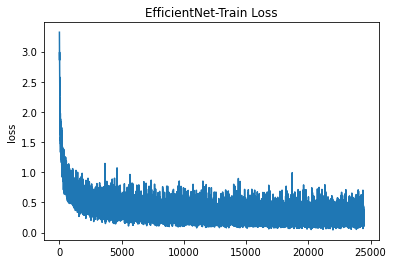

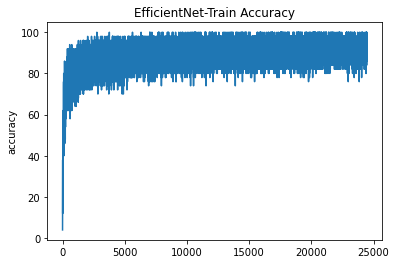

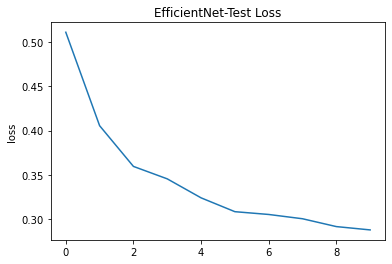

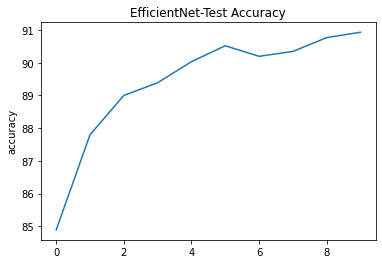

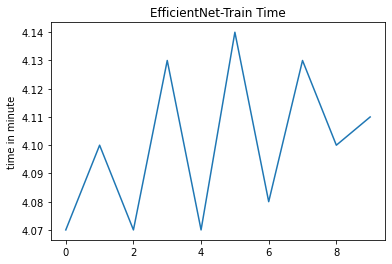

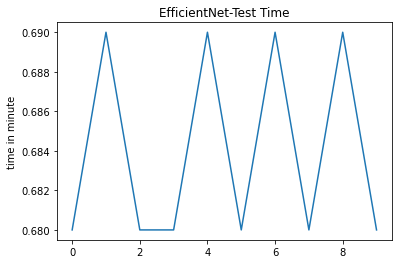

4.1000000000000005
41.00000000000001


In [13]:
# Plot train_loss and train_accuracy
plt.plot(train_loss_tracker)
plt.title('EfficientNet-Train Loss')
plt.ylabel('loss')
plt.show()
plt.plot(train_accuracy_tracker)
plt.title('EfficientNet-Train Accuracy')
plt.ylabel('accuracy')
plt.show()
# Plot test_loss and test_accuracy
plt.plot(test_loss_tracker)
plt.title('EfficientNet-Test Loss')
plt.ylabel('loss')
plt.show()
plt.plot(test_accuracy_tracker)
plt.title('EfficientNet-Test Accuracy')
plt.ylabel('accuracy')
plt.show()
# Plot train time
train_time_tracker_in_minute = []
for num in train_time_tracker:
    train_time_tracker_in_minute.append(round(num/60, 2))
plt.plot(train_time_tracker_in_minute)
plt.title('EfficientNet-Train Time')
plt.ylabel('time in minute')
plt.show()
# Plot test time
test_time_tracker_in_minute = []
for num in test_time_tracker:
    test_time_tracker_in_minute.append(round(num/60, 2))
plt.plot(test_time_tracker_in_minute)
plt.title('EfficientNet-Test Time')
plt.ylabel('time in minute')
plt.show()

print(sum(train_time_tracker_in_minute)/10)
print(sum(train_time_tracker_in_minute))

In [14]:
epochs = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(resnet18.parameters(), lr = learning_rate)

# Train and test ResNet18 baseline
model = resnet18

train_loss_tracker = []
train_accuracy_tracker = []
train_time_tracker = []
test_loss_tracker = []
test_accuracy_tracker = []
test_time_tracker = []

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    train_start_time = time.time()
    train_loss,train_accuracy = Train(model,optimizer,emnist_train_loader,device)
    train_end_time = time.time()
    train_time_tracker.append(train_end_time-train_start_time)
    test_start_time = time.time()
    test_loss , test_accuracy = Test(model,emnist_test_loader,device)
    test_end_time = time.time()
    test_time_tracker.append(test_end_time-test_start_time)
    train_loss_tracker.extend(train_loss)
    train_accuracy_tracker.extend(train_accuracy)
    test_loss_tracker.append(test_loss)
    test_accuracy_tracker.append(test_accuracy)
    print('\t training loss/accuracy: {0:.2f}/{1:.2f}'.format(sum(train_loss)/len(train_loss), sum(train_accuracy)/len((train_accuracy))))
    print('\t testing loss/accuracy: {0:.2f}/{1:.2f}'.format(test_loss, test_accuracy))

Epoch: 0
step: 2, loss = 3.3904
step: 3, loss = 3.3075
step: 4, loss = 3.2985
step: 5, loss = 3.2199
step: 6, loss = 3.2825
step: 7, loss = 3.2817
step: 8, loss = 3.1620
step: 9, loss = 3.0631
step: 10, loss = 3.0803
step: 11, loss = 3.1299
step: 12, loss = 3.0271
step: 13, loss = 3.1236
step: 14, loss = 2.9287
step: 15, loss = 3.1938
step: 16, loss = 3.0005
step: 17, loss = 2.8718
step: 18, loss = 2.8676
step: 19, loss = 3.0808
step: 20, loss = 2.9764
step: 21, loss = 2.9450
step: 22, loss = 2.8312
step: 23, loss = 2.8521
step: 24, loss = 2.8728
step: 25, loss = 2.7375
step: 26, loss = 2.8358
step: 27, loss = 2.8227
step: 28, loss = 2.7330
step: 29, loss = 2.7818
step: 30, loss = 2.6851
step: 31, loss = 2.7472
step: 32, loss = 2.6684
step: 33, loss = 2.5862
step: 34, loss = 2.6279
step: 35, loss = 2.4865
step: 36, loss = 2.5846
step: 37, loss = 2.4762
step: 38, loss = 2.6172
step: 39, loss = 2.4780
step: 40, loss = 2.6083
step: 41, loss = 2.5034
step: 42, loss = 2.5319
step: 43, loss 

step: 340, loss = 0.9565
step: 341, loss = 0.9137
step: 342, loss = 0.7740
step: 343, loss = 1.1447
step: 344, loss = 0.9183
step: 345, loss = 1.0473
step: 346, loss = 0.9319
step: 347, loss = 0.8386
step: 348, loss = 0.9736
step: 349, loss = 1.2546
step: 350, loss = 1.1786
step: 352, loss = 1.2347
step: 353, loss = 0.9863
step: 354, loss = 1.1478
step: 355, loss = 1.0262
step: 356, loss = 1.0042
step: 357, loss = 0.9774
step: 358, loss = 0.8273
step: 359, loss = 1.0220
step: 360, loss = 1.1643
step: 361, loss = 0.9298
step: 362, loss = 1.0232
step: 363, loss = 0.8172
step: 364, loss = 1.2015
step: 365, loss = 1.2032
step: 366, loss = 1.2309
step: 367, loss = 0.9104
step: 368, loss = 1.0117
step: 369, loss = 0.7529
step: 370, loss = 1.0192
step: 371, loss = 1.1155
step: 372, loss = 1.0063
step: 373, loss = 1.1499
step: 374, loss = 1.1707
step: 375, loss = 1.3742
step: 376, loss = 1.0504
step: 377, loss = 1.1833
step: 378, loss = 0.9651
step: 379, loss = 0.8561
step: 380, loss = 1.1268


step: 676, loss = 0.8924
step: 677, loss = 0.6995
step: 678, loss = 0.7851
step: 679, loss = 0.7453
step: 680, loss = 0.7779
step: 681, loss = 0.7376
step: 682, loss = 0.8563
step: 683, loss = 0.7008
step: 684, loss = 0.8250
step: 685, loss = 0.7674
step: 686, loss = 0.6741
step: 687, loss = 0.8126
step: 688, loss = 0.8302
step: 689, loss = 0.9151
step: 690, loss = 0.5906
step: 691, loss = 0.7309
step: 692, loss = 0.8306
step: 693, loss = 1.0156
step: 694, loss = 0.6660
step: 695, loss = 0.9875
step: 696, loss = 0.8243
step: 697, loss = 0.7649
step: 698, loss = 0.9417
step: 699, loss = 0.8611
step: 700, loss = 0.8042
step: 702, loss = 0.7759
step: 703, loss = 0.6807
step: 704, loss = 0.9912
step: 705, loss = 0.8089
step: 706, loss = 0.7378
step: 707, loss = 0.7666
step: 708, loss = 0.9247
step: 709, loss = 0.6926
step: 710, loss = 0.8807
step: 711, loss = 0.6935
step: 712, loss = 0.6904
step: 713, loss = 0.8317
step: 714, loss = 0.8563
step: 715, loss = 0.6779
step: 716, loss = 0.8389


step: 1013, loss = 0.6743
step: 1014, loss = 0.8026
step: 1015, loss = 0.6188
step: 1016, loss = 0.6189
step: 1017, loss = 0.6108
step: 1018, loss = 0.5373
step: 1019, loss = 0.7043
step: 1020, loss = 0.4779
step: 1021, loss = 0.4903
step: 1022, loss = 0.9007
step: 1023, loss = 0.6516
step: 1024, loss = 0.7075
step: 1025, loss = 0.9098
step: 1026, loss = 0.7387
step: 1027, loss = 0.6205
step: 1028, loss = 0.6488
step: 1029, loss = 0.6933
step: 1030, loss = 0.4929
step: 1031, loss = 0.5002
step: 1032, loss = 0.7271
step: 1033, loss = 0.6794
step: 1034, loss = 0.7692
step: 1035, loss = 0.6195
step: 1036, loss = 0.5588
step: 1037, loss = 0.3842
step: 1038, loss = 0.7475
step: 1039, loss = 0.7035
step: 1040, loss = 0.6973
step: 1041, loss = 0.7421
step: 1042, loss = 0.5695
step: 1043, loss = 0.7235
step: 1044, loss = 0.7159
step: 1045, loss = 0.5207
step: 1046, loss = 0.6585
step: 1047, loss = 0.6686
step: 1048, loss = 0.4836
step: 1049, loss = 0.7003
step: 1050, loss = 0.7398
step: 1052, 

step: 1337, loss = 0.8221
step: 1338, loss = 0.7174
step: 1339, loss = 0.5386
step: 1340, loss = 0.6501
step: 1341, loss = 0.7232
step: 1342, loss = 0.4697
step: 1343, loss = 0.5157
step: 1344, loss = 0.9183
step: 1345, loss = 0.6970
step: 1346, loss = 0.9204
step: 1347, loss = 0.5861
step: 1348, loss = 0.7424
step: 1349, loss = 0.7183
step: 1350, loss = 0.6573
step: 1352, loss = 0.5933
step: 1353, loss = 0.7760
step: 1354, loss = 0.5249
step: 1355, loss = 0.6122
step: 1356, loss = 0.4803
step: 1357, loss = 0.5198
step: 1358, loss = 0.4150
step: 1359, loss = 0.4078
step: 1360, loss = 0.6156
step: 1361, loss = 0.7659
step: 1362, loss = 0.7238
step: 1363, loss = 0.7052
step: 1364, loss = 0.3872
step: 1365, loss = 0.5216
step: 1366, loss = 0.4305
step: 1367, loss = 0.6537
step: 1368, loss = 0.6695
step: 1369, loss = 0.9100
step: 1370, loss = 0.5086
step: 1371, loss = 0.5756
step: 1372, loss = 0.7828
step: 1373, loss = 0.4435
step: 1374, loss = 0.6251
step: 1375, loss = 0.5340
step: 1376, 

step: 1662, loss = 0.7147
step: 1663, loss = 0.7244
step: 1664, loss = 0.6623
step: 1665, loss = 0.6124
step: 1666, loss = 0.8562
step: 1667, loss = 0.5552
step: 1668, loss = 0.6089
step: 1669, loss = 0.4670
step: 1670, loss = 0.6792
step: 1671, loss = 0.4421
step: 1672, loss = 0.6165
step: 1673, loss = 0.5696
step: 1674, loss = 0.5852
step: 1675, loss = 0.5250
step: 1676, loss = 0.5514
step: 1677, loss = 0.6629
step: 1678, loss = 0.6160
step: 1679, loss = 0.6487
step: 1680, loss = 0.5683
step: 1681, loss = 0.6133
step: 1682, loss = 0.5414
step: 1683, loss = 0.3998
step: 1684, loss = 0.6059
step: 1685, loss = 0.4072
step: 1686, loss = 0.5266
step: 1687, loss = 0.4776
step: 1688, loss = 0.4826
step: 1689, loss = 0.7164
step: 1690, loss = 0.5435
step: 1691, loss = 0.5006
step: 1692, loss = 0.6389
step: 1693, loss = 0.6789
step: 1694, loss = 0.5264
step: 1695, loss = 0.5457
step: 1696, loss = 0.5501
step: 1697, loss = 0.3939
step: 1698, loss = 0.4845
step: 1699, loss = 0.6345
step: 1700, 

step: 1985, loss = 0.6364
step: 1986, loss = 0.5858
step: 1987, loss = 0.4396
step: 1988, loss = 0.5623
step: 1989, loss = 0.5147
step: 1990, loss = 0.6154
step: 1991, loss = 0.3942
step: 1992, loss = 0.5753
step: 1993, loss = 0.5031
step: 1994, loss = 0.5412
step: 1995, loss = 0.4986
step: 1996, loss = 0.5648
step: 1997, loss = 0.5365
step: 1998, loss = 0.6468
step: 1999, loss = 0.3948
step: 2000, loss = 0.3328
step: 2002, loss = 0.5382
step: 2003, loss = 0.4362
step: 2004, loss = 0.8623
step: 2005, loss = 0.5735
step: 2006, loss = 0.6214
step: 2007, loss = 0.7238
step: 2008, loss = 0.5929
step: 2009, loss = 0.5732
step: 2010, loss = 0.5536
step: 2011, loss = 0.3432
step: 2012, loss = 0.5334
step: 2013, loss = 0.6096
step: 2014, loss = 0.6377
step: 2015, loss = 0.6135
step: 2016, loss = 0.4329
step: 2017, loss = 0.5053
step: 2018, loss = 0.4846
step: 2019, loss = 0.6456
step: 2020, loss = 0.7679
step: 2021, loss = 0.4851
step: 2022, loss = 0.4651
step: 2023, loss = 0.5724
step: 2024, 

step: 2309, loss = 0.4917
step: 2310, loss = 0.3963
step: 2311, loss = 0.6009
step: 2312, loss = 0.4403
step: 2313, loss = 0.5833
step: 2314, loss = 0.3584
step: 2315, loss = 0.4951
step: 2316, loss = 0.4408
step: 2317, loss = 0.5066
step: 2318, loss = 0.6748
step: 2319, loss = 0.4780
step: 2320, loss = 0.3218
step: 2321, loss = 0.3744
step: 2322, loss = 0.8375
step: 2323, loss = 0.3077
step: 2324, loss = 0.4037
step: 2325, loss = 0.5105
step: 2326, loss = 0.5829
step: 2327, loss = 0.4840
step: 2328, loss = 0.5072
step: 2329, loss = 0.5584
step: 2330, loss = 0.6015
step: 2331, loss = 0.4379
step: 2332, loss = 0.7435
step: 2333, loss = 0.4196
step: 2334, loss = 0.3121
step: 2335, loss = 0.4644
step: 2336, loss = 0.4523
step: 2337, loss = 0.4805
step: 2338, loss = 0.3152
step: 2339, loss = 0.5228
step: 2340, loss = 0.4581
step: 2341, loss = 0.3675
step: 2342, loss = 0.4369
step: 2343, loss = 0.6257
step: 2344, loss = 0.3964
step: 2345, loss = 0.4926
step: 2346, loss = 0.3659
step: 2347, 

step: 142, loss = 0.4076
step: 143, loss = 0.5475
step: 144, loss = 0.6165
step: 145, loss = 0.4646
step: 146, loss = 0.7348
step: 147, loss = 0.4757
step: 148, loss = 0.4562
step: 149, loss = 0.3073
step: 150, loss = 0.4545
step: 152, loss = 0.7572
step: 153, loss = 0.4496
step: 154, loss = 0.4877
step: 155, loss = 0.4446
step: 156, loss = 0.4022
step: 157, loss = 0.4120
step: 158, loss = 0.4603
step: 159, loss = 0.4438
step: 160, loss = 0.5780
step: 161, loss = 0.4552
step: 162, loss = 0.5651
step: 163, loss = 0.5450
step: 164, loss = 0.4317
step: 165, loss = 0.4216
step: 166, loss = 0.4406
step: 167, loss = 0.7816
step: 168, loss = 0.5326
step: 169, loss = 0.3198
step: 170, loss = 0.5840
step: 171, loss = 0.5645
step: 172, loss = 0.6283
step: 173, loss = 0.4402
step: 174, loss = 0.5303
step: 175, loss = 0.3322
step: 176, loss = 0.3160
step: 177, loss = 0.8027
step: 178, loss = 0.4148
step: 179, loss = 0.3921
step: 180, loss = 0.6359
step: 181, loss = 0.8348
step: 182, loss = 0.4725


step: 479, loss = 0.3169
step: 480, loss = 0.4221
step: 481, loss = 0.7256
step: 482, loss = 0.2972
step: 483, loss = 0.6573
step: 484, loss = 0.2988
step: 485, loss = 0.3922
step: 486, loss = 0.4607
step: 487, loss = 0.4437
step: 488, loss = 0.6465
step: 489, loss = 0.4827
step: 490, loss = 0.5571
step: 491, loss = 0.5151
step: 492, loss = 0.4664
step: 493, loss = 0.6062
step: 494, loss = 0.4899
step: 495, loss = 0.3388
step: 496, loss = 0.4660
step: 497, loss = 0.4845
step: 498, loss = 0.4096
step: 499, loss = 0.4041
step: 500, loss = 0.3883
step: 502, loss = 0.7554
step: 503, loss = 0.4507
step: 504, loss = 0.4386
step: 505, loss = 0.6879
step: 506, loss = 0.3484
step: 507, loss = 0.4672
step: 508, loss = 0.3853
step: 509, loss = 0.4908
step: 510, loss = 0.3602
step: 511, loss = 0.2853
step: 512, loss = 0.4140
step: 513, loss = 0.7489
step: 514, loss = 0.3795
step: 515, loss = 0.6406
step: 516, loss = 0.3877
step: 517, loss = 0.3663
step: 518, loss = 0.3736
step: 519, loss = 0.6689


step: 815, loss = 0.5199
step: 816, loss = 0.2747
step: 817, loss = 0.5028
step: 818, loss = 0.4572
step: 819, loss = 0.4246
step: 820, loss = 0.4851
step: 821, loss = 0.4865
step: 822, loss = 0.7993
step: 823, loss = 0.3950
step: 824, loss = 0.4263
step: 825, loss = 0.4613
step: 826, loss = 0.6647
step: 827, loss = 0.2673
step: 828, loss = 0.3703
step: 829, loss = 0.3302
step: 830, loss = 0.4455
step: 831, loss = 0.5586
step: 832, loss = 0.4455
step: 833, loss = 0.5979
step: 834, loss = 0.3582
step: 835, loss = 0.4273
step: 836, loss = 0.4914
step: 837, loss = 0.4492
step: 838, loss = 0.2705
step: 839, loss = 0.3489
step: 840, loss = 0.4215
step: 841, loss = 0.2455
step: 842, loss = 0.5384
step: 843, loss = 0.4448
step: 844, loss = 0.3123
step: 845, loss = 0.6488
step: 846, loss = 0.3606
step: 847, loss = 0.2973
step: 848, loss = 0.3844
step: 849, loss = 0.5939
step: 850, loss = 0.2650
step: 852, loss = 0.5516
step: 853, loss = 0.3600
step: 854, loss = 0.5096
step: 855, loss = 0.4429


step: 1144, loss = 0.3821
step: 1145, loss = 0.5099
step: 1146, loss = 0.3899
step: 1147, loss = 0.4809
step: 1148, loss = 0.4743
step: 1149, loss = 0.3861
step: 1150, loss = 0.5018
step: 1152, loss = 0.4238
step: 1153, loss = 0.3540
step: 1154, loss = 0.5444
step: 1155, loss = 0.6146
step: 1156, loss = 0.5247
step: 1157, loss = 0.4505
step: 1158, loss = 0.4899
step: 1159, loss = 0.2414
step: 1160, loss = 0.5455
step: 1161, loss = 0.6000
step: 1162, loss = 0.4666
step: 1163, loss = 0.6339
step: 1164, loss = 0.4445
step: 1165, loss = 0.2900
step: 1166, loss = 0.4286
step: 1167, loss = 0.6030
step: 1168, loss = 0.7417
step: 1169, loss = 0.4240
step: 1170, loss = 0.1772
step: 1171, loss = 0.4782
step: 1172, loss = 0.5908
step: 1173, loss = 0.4280
step: 1174, loss = 0.4732
step: 1175, loss = 0.3098
step: 1176, loss = 0.5382
step: 1177, loss = 0.4812
step: 1178, loss = 0.3545
step: 1179, loss = 0.4121
step: 1180, loss = 0.3487
step: 1181, loss = 0.5529
step: 1182, loss = 0.5784
step: 1183, 

step: 1468, loss = 0.5309
step: 1469, loss = 0.4678
step: 1470, loss = 0.3724
step: 1471, loss = 0.3276
step: 1472, loss = 0.4641
step: 1473, loss = 0.4165
step: 1474, loss = 0.4287
step: 1475, loss = 0.5384
step: 1476, loss = 0.8331
step: 1477, loss = 0.3733
step: 1478, loss = 0.4271
step: 1479, loss = 0.5247
step: 1480, loss = 0.4913
step: 1481, loss = 0.4564
step: 1482, loss = 0.5079
step: 1483, loss = 0.4394
step: 1484, loss = 0.3909
step: 1485, loss = 0.4437
step: 1486, loss = 0.5587
step: 1487, loss = 0.5406
step: 1488, loss = 0.4197
step: 1489, loss = 0.4971
step: 1490, loss = 0.5910
step: 1491, loss = 0.4624
step: 1492, loss = 0.4688
step: 1493, loss = 0.7157
step: 1494, loss = 0.3862
step: 1495, loss = 0.2937
step: 1496, loss = 0.2773
step: 1497, loss = 0.4192
step: 1498, loss = 0.2691
step: 1499, loss = 0.5240
step: 1500, loss = 0.5448
step: 1502, loss = 0.4087
step: 1503, loss = 0.3915
step: 1504, loss = 0.3445
step: 1505, loss = 0.3214
step: 1506, loss = 0.2560
step: 1507, 

step: 1792, loss = 0.3410
step: 1793, loss = 0.5769
step: 1794, loss = 0.7497
step: 1795, loss = 0.3667
step: 1796, loss = 0.3358
step: 1797, loss = 0.4000
step: 1798, loss = 0.4739
step: 1799, loss = 0.5289
step: 1800, loss = 0.3650
step: 1802, loss = 0.4111
step: 1803, loss = 0.5857
step: 1804, loss = 0.3416
step: 1805, loss = 0.4305
step: 1806, loss = 0.1875
step: 1807, loss = 0.3504
step: 1808, loss = 0.3246
step: 1809, loss = 0.3562
step: 1810, loss = 0.2609
step: 1811, loss = 0.5315
step: 1812, loss = 0.2312
step: 1813, loss = 0.3686
step: 1814, loss = 0.2829
step: 1815, loss = 0.5414
step: 1816, loss = 0.3323
step: 1817, loss = 0.3831
step: 1818, loss = 0.4055
step: 1819, loss = 0.3263
step: 1820, loss = 0.4468
step: 1821, loss = 0.4819
step: 1822, loss = 0.3754
step: 1823, loss = 0.4151
step: 1824, loss = 0.5755
step: 1825, loss = 0.2567
step: 1826, loss = 0.3725
step: 1827, loss = 0.3990
step: 1828, loss = 0.3456
step: 1829, loss = 0.2261
step: 1830, loss = 0.3373
step: 1831, 

step: 2117, loss = 0.4238
step: 2118, loss = 0.4398
step: 2119, loss = 0.5479
step: 2120, loss = 0.2418
step: 2121, loss = 0.3316
step: 2122, loss = 0.2920
step: 2123, loss = 0.4438
step: 2124, loss = 0.5236
step: 2125, loss = 0.4087
step: 2126, loss = 0.4417
step: 2127, loss = 0.2680
step: 2128, loss = 0.4013
step: 2129, loss = 0.3708
step: 2130, loss = 0.4970
step: 2131, loss = 0.3569
step: 2132, loss = 0.2487
step: 2133, loss = 0.4788
step: 2134, loss = 0.1857
step: 2135, loss = 0.4161
step: 2136, loss = 0.3620
step: 2137, loss = 0.3371
step: 2138, loss = 0.5017
step: 2139, loss = 0.1728
step: 2140, loss = 0.5855
step: 2141, loss = 0.4737
step: 2142, loss = 0.4412
step: 2143, loss = 0.3414
step: 2144, loss = 0.3861
step: 2145, loss = 0.4968
step: 2146, loss = 0.4533
step: 2147, loss = 0.3809
step: 2148, loss = 0.6295
step: 2149, loss = 0.5051
step: 2150, loss = 0.5201
step: 2152, loss = 0.3110
step: 2153, loss = 0.4375
step: 2154, loss = 0.3621
step: 2155, loss = 0.4934
step: 2156, 

step: 2439, loss = 0.5549
step: 2440, loss = 0.1922
step: 2441, loss = 0.3725
step: 2442, loss = 0.5667
step: 2443, loss = 0.5005
step: 2444, loss = 0.6801
step: 2445, loss = 0.4223
step: 2446, loss = 0.6269
step: 2447, loss = 0.3904
step: 2448, loss = 0.3951
step: 2449, loss = 0.2866
step: 2450, loss = 0.3459
step: 2452, loss = 0.3402
step: 2453, loss = 0.4036
step: 2454, loss = 0.6216
step: 2455, loss = 0.2948
step: 2456, loss = 0.5810
step: 2457, loss = 0.4720
step: 2458, loss = 0.4101
step: 2459, loss = 0.1328
step: 2460, loss = 0.4108
step: 2461, loss = 0.2217
step: 2462, loss = 0.5696
step: 2463, loss = 0.2577
step: 2464, loss = 0.3159
step: 2465, loss = 0.4712
step: 2466, loss = 0.4408
step: 2467, loss = 0.2838
step: 2468, loss = 0.6052
step: 2469, loss = 0.3614
step: 2470, loss = 0.2969
step: 2471, loss = 0.4590
step: 2472, loss = 0.3081
step: 2473, loss = 0.5028
step: 2474, loss = 0.3517
step: 2475, loss = 0.3753
step: 2476, loss = 0.2558
step: 2477, loss = 0.3897
step: 2478, 

step: 279, loss = 0.2197
step: 280, loss = 0.3905
step: 281, loss = 0.4667
step: 282, loss = 0.2537
step: 283, loss = 0.4985
step: 284, loss = 0.2565
step: 285, loss = 0.3847
step: 286, loss = 0.4504
step: 287, loss = 0.5657
step: 288, loss = 0.5168
step: 289, loss = 0.4420
step: 290, loss = 0.8497
step: 291, loss = 0.2793
step: 292, loss = 0.3689
step: 293, loss = 0.2213
step: 294, loss = 0.3465
step: 295, loss = 0.4855
step: 296, loss = 0.4861
step: 297, loss = 0.2639
step: 298, loss = 0.1732
step: 299, loss = 0.4056
step: 300, loss = 0.2401
step: 302, loss = 0.4592
step: 303, loss = 0.3802
step: 304, loss = 0.2736
step: 305, loss = 0.4950
step: 306, loss = 0.7758
step: 307, loss = 0.4581
step: 308, loss = 0.3429
step: 309, loss = 0.3486
step: 310, loss = 0.5909
step: 311, loss = 0.5811
step: 312, loss = 0.3484
step: 313, loss = 0.4384
step: 314, loss = 0.7285
step: 315, loss = 0.6207
step: 316, loss = 0.5857
step: 317, loss = 0.3028
step: 318, loss = 0.4024
step: 319, loss = 0.3880


step: 616, loss = 0.2837
step: 617, loss = 0.3531
step: 618, loss = 0.4316
step: 619, loss = 0.6532
step: 620, loss = 0.4645
step: 621, loss = 0.3353
step: 622, loss = 0.3250
step: 623, loss = 0.5258
step: 624, loss = 0.4490
step: 625, loss = 0.3450
step: 626, loss = 0.3305
step: 627, loss = 0.5181
step: 628, loss = 0.5465
step: 629, loss = 0.3492
step: 630, loss = 0.2131
step: 631, loss = 0.2645
step: 632, loss = 0.2289
step: 633, loss = 0.4243
step: 634, loss = 0.7235
step: 635, loss = 0.3327
step: 636, loss = 0.4523
step: 637, loss = 0.3707
step: 638, loss = 0.2602
step: 639, loss = 0.5894
step: 640, loss = 0.2554
step: 641, loss = 0.2731
step: 642, loss = 0.4894
step: 643, loss = 0.5433
step: 644, loss = 0.3324
step: 645, loss = 0.2601
step: 646, loss = 0.2875
step: 647, loss = 0.3406
step: 648, loss = 0.5079
step: 649, loss = 0.6044
step: 650, loss = 0.4873
step: 652, loss = 0.4324
step: 653, loss = 0.5250
step: 654, loss = 0.5037
step: 655, loss = 0.6564
step: 656, loss = 0.3367


step: 952, loss = 0.4771
step: 953, loss = 0.8101
step: 954, loss = 0.3578
step: 955, loss = 0.3325
step: 956, loss = 0.4665
step: 957, loss = 0.3967
step: 958, loss = 0.3868
step: 959, loss = 0.2629
step: 960, loss = 0.3225
step: 961, loss = 0.6225
step: 962, loss = 0.1524
step: 963, loss = 0.3368
step: 964, loss = 0.2499
step: 965, loss = 0.5374
step: 966, loss = 0.3325
step: 967, loss = 0.4883
step: 968, loss = 0.3773
step: 969, loss = 0.3032
step: 970, loss = 0.2412
step: 971, loss = 0.2919
step: 972, loss = 0.3874
step: 973, loss = 0.3485
step: 974, loss = 0.2985
step: 975, loss = 0.6585
step: 976, loss = 0.5538
step: 977, loss = 0.2871
step: 978, loss = 0.3310
step: 979, loss = 0.4462
step: 980, loss = 0.5337
step: 981, loss = 0.4770
step: 982, loss = 0.5466
step: 983, loss = 0.5296
step: 984, loss = 0.3353
step: 985, loss = 0.4314
step: 986, loss = 0.3732
step: 987, loss = 0.4653
step: 988, loss = 0.3081
step: 989, loss = 0.3871
step: 990, loss = 0.3233
step: 991, loss = 0.4361


step: 1276, loss = 0.3341
step: 1277, loss = 0.5682
step: 1278, loss = 0.4880
step: 1279, loss = 0.3244
step: 1280, loss = 0.4647
step: 1281, loss = 0.4581
step: 1282, loss = 0.3657
step: 1283, loss = 0.3430
step: 1284, loss = 0.3644
step: 1285, loss = 0.4287
step: 1286, loss = 0.4849
step: 1287, loss = 0.3328
step: 1288, loss = 0.3428
step: 1289, loss = 0.4377
step: 1290, loss = 0.4267
step: 1291, loss = 0.3108
step: 1292, loss = 0.4120
step: 1293, loss = 0.4327
step: 1294, loss = 0.3630
step: 1295, loss = 0.5862
step: 1296, loss = 0.4010
step: 1297, loss = 0.3331
step: 1298, loss = 0.4137
step: 1299, loss = 0.3742
step: 1300, loss = 0.4680
step: 1302, loss = 0.4636
step: 1303, loss = 0.4415
step: 1304, loss = 0.5311
step: 1305, loss = 0.3325
step: 1306, loss = 0.4315
step: 1307, loss = 0.4570
step: 1308, loss = 0.3179
step: 1309, loss = 0.3092
step: 1310, loss = 0.3065
step: 1311, loss = 0.4067
step: 1312, loss = 0.3393
step: 1313, loss = 0.3746
step: 1314, loss = 0.4599
step: 1315, 

step: 1600, loss = 0.4324
step: 1602, loss = 0.2834
step: 1603, loss = 0.3875
step: 1604, loss = 0.2728
step: 1605, loss = 0.5984
step: 1606, loss = 0.5091
step: 1607, loss = 0.4425
step: 1608, loss = 0.2692
step: 1609, loss = 0.5660
step: 1610, loss = 0.4267
step: 1611, loss = 0.4118
step: 1612, loss = 0.3588
step: 1613, loss = 0.2717
step: 1614, loss = 0.4436
step: 1615, loss = 0.3476
step: 1616, loss = 0.2460
step: 1617, loss = 0.4505
step: 1618, loss = 0.4302
step: 1619, loss = 0.3279
step: 1620, loss = 0.3641
step: 1621, loss = 0.4092
step: 1622, loss = 0.3663
step: 1623, loss = 0.3983
step: 1624, loss = 0.1938
step: 1625, loss = 0.2422
step: 1626, loss = 0.4696
step: 1627, loss = 0.3443
step: 1628, loss = 0.4783
step: 1629, loss = 0.4555
step: 1630, loss = 0.3944
step: 1631, loss = 0.3206
step: 1632, loss = 0.4136
step: 1633, loss = 0.3826
step: 1634, loss = 0.2941
step: 1635, loss = 0.2015
step: 1636, loss = 0.4713
step: 1637, loss = 0.2712
step: 1638, loss = 0.5700
step: 1639, 

step: 1924, loss = 0.4354
step: 1925, loss = 0.4561
step: 1926, loss = 0.4077
step: 1927, loss = 0.3889
step: 1928, loss = 0.2058
step: 1929, loss = 0.3567
step: 1930, loss = 0.2575
step: 1931, loss = 0.2562
step: 1932, loss = 0.2248
step: 1933, loss = 0.2276
step: 1934, loss = 0.2712
step: 1935, loss = 0.4053
step: 1936, loss = 0.3188
step: 1937, loss = 0.2577
step: 1938, loss = 0.2379
step: 1939, loss = 0.2256
step: 1940, loss = 0.3532
step: 1941, loss = 0.4077
step: 1942, loss = 0.3254
step: 1943, loss = 0.3013
step: 1944, loss = 0.6452
step: 1945, loss = 0.2157
step: 1946, loss = 0.2675
step: 1947, loss = 0.3080
step: 1948, loss = 0.4214
step: 1949, loss = 0.4269
step: 1950, loss = 0.4130
step: 1952, loss = 0.4819
step: 1953, loss = 0.3973
step: 1954, loss = 0.3828
step: 1955, loss = 0.3237
step: 1956, loss = 0.5744
step: 1957, loss = 0.3750
step: 1958, loss = 0.2289
step: 1959, loss = 0.4229
step: 1960, loss = 0.3709
step: 1961, loss = 0.3801
step: 1962, loss = 0.3634
step: 1963, 

step: 2248, loss = 0.2322
step: 2249, loss = 0.2407
step: 2250, loss = 0.6650
step: 2252, loss = 0.4652
step: 2253, loss = 0.2704
step: 2254, loss = 0.4557
step: 2255, loss = 0.3398
step: 2256, loss = 0.3520
step: 2257, loss = 0.2084
step: 2258, loss = 0.5107
step: 2259, loss = 0.3248
step: 2260, loss = 0.3499
step: 2261, loss = 0.3431
step: 2262, loss = 0.2814
step: 2263, loss = 0.2602
step: 2264, loss = 0.5090
step: 2265, loss = 0.3117
step: 2266, loss = 0.2216
step: 2267, loss = 0.3357
step: 2268, loss = 0.2374
step: 2269, loss = 0.4190
step: 2270, loss = 0.3148
step: 2271, loss = 0.4165
step: 2272, loss = 0.2538
step: 2273, loss = 0.3133
step: 2274, loss = 0.2701
step: 2275, loss = 0.2825
step: 2276, loss = 0.3838
step: 2277, loss = 0.6443
step: 2278, loss = 0.3539
step: 2279, loss = 0.1613
step: 2280, loss = 0.4402
step: 2281, loss = 0.4340
step: 2282, loss = 0.2136
step: 2283, loss = 0.5451
step: 2284, loss = 0.3925
step: 2285, loss = 0.3134
step: 2286, loss = 0.4320
step: 2287, 

step: 79, loss = 0.3486
step: 80, loss = 0.3437
step: 81, loss = 0.3726
step: 82, loss = 0.3696
step: 83, loss = 0.2664
step: 84, loss = 0.4536
step: 85, loss = 0.3011
step: 86, loss = 0.4752
step: 87, loss = 0.2545
step: 88, loss = 0.2631
step: 89, loss = 0.4291
step: 90, loss = 0.1838
step: 91, loss = 0.3290
step: 92, loss = 0.3452
step: 93, loss = 0.2817
step: 94, loss = 0.3716
step: 95, loss = 0.4136
step: 96, loss = 0.4062
step: 97, loss = 0.3677
step: 98, loss = 0.2444
step: 99, loss = 0.3593
step: 100, loss = 0.3498
step: 102, loss = 0.1961
step: 103, loss = 0.2093
step: 104, loss = 0.4313
step: 105, loss = 0.3126
step: 106, loss = 0.3777
step: 107, loss = 0.3748
step: 108, loss = 0.4285
step: 109, loss = 0.2981
step: 110, loss = 0.4921
step: 111, loss = 0.5079
step: 112, loss = 0.4241
step: 113, loss = 0.3916
step: 114, loss = 0.3102
step: 115, loss = 0.3302
step: 116, loss = 0.1862
step: 117, loss = 0.3373
step: 118, loss = 0.4036
step: 119, loss = 0.3027
step: 120, loss = 0.6

step: 416, loss = 0.4035
step: 417, loss = 0.2636
step: 418, loss = 0.4217
step: 419, loss = 0.3209
step: 420, loss = 0.2407
step: 421, loss = 0.3581
step: 422, loss = 0.4616
step: 423, loss = 0.1900
step: 424, loss = 0.2570
step: 425, loss = 0.2560
step: 426, loss = 0.3209
step: 427, loss = 0.1795
step: 428, loss = 0.5859
step: 429, loss = 0.2317
step: 430, loss = 0.2882
step: 431, loss = 0.3657
step: 432, loss = 0.4486
step: 433, loss = 0.4646
step: 434, loss = 0.4324
step: 435, loss = 0.3767
step: 436, loss = 0.2707
step: 437, loss = 0.4349
step: 438, loss = 0.2401
step: 439, loss = 0.3028
step: 440, loss = 0.3412
step: 441, loss = 0.2660
step: 442, loss = 0.3650
step: 443, loss = 0.2422
step: 444, loss = 0.3567
step: 445, loss = 0.2843
step: 446, loss = 0.3604
step: 447, loss = 0.2492
step: 448, loss = 0.3101
step: 449, loss = 0.2735
step: 450, loss = 0.4278
step: 452, loss = 0.2845
step: 453, loss = 0.3204
step: 454, loss = 0.3570
step: 455, loss = 0.5913
step: 456, loss = 0.4993


step: 752, loss = 0.3179
step: 753, loss = 0.5052
step: 754, loss = 0.4813
step: 755, loss = 0.2645
step: 756, loss = 0.3466
step: 757, loss = 0.3336
step: 758, loss = 0.2561
step: 759, loss = 0.2291
step: 760, loss = 0.2402
step: 761, loss = 0.5808
step: 762, loss = 0.3496
step: 763, loss = 0.2408
step: 764, loss = 0.6206
step: 765, loss = 0.3704
step: 766, loss = 0.3258
step: 767, loss = 0.2279
step: 768, loss = 0.4086
step: 769, loss = 0.5409
step: 770, loss = 0.3149
step: 771, loss = 0.3276
step: 772, loss = 0.3329
step: 773, loss = 0.3462
step: 774, loss = 0.2565
step: 775, loss = 0.3459
step: 776, loss = 0.2170
step: 777, loss = 0.3483
step: 778, loss = 0.6174
step: 779, loss = 0.2154
step: 780, loss = 0.3228
step: 781, loss = 0.3784
step: 782, loss = 0.3204
step: 783, loss = 0.3687
step: 784, loss = 0.3138
step: 785, loss = 0.2095
step: 786, loss = 0.4363
step: 787, loss = 0.3302
step: 788, loss = 0.3839
step: 789, loss = 0.3640
step: 790, loss = 0.4507
step: 791, loss = 0.3601


step: 1085, loss = 0.3625
step: 1086, loss = 0.2753
step: 1087, loss = 0.4001
step: 1088, loss = 0.2914
step: 1089, loss = 0.3497
step: 1090, loss = 0.2494
step: 1091, loss = 0.1984
step: 1092, loss = 0.2553
step: 1093, loss = 0.4237
step: 1094, loss = 0.3875
step: 1095, loss = 0.3585
step: 1096, loss = 0.1614
step: 1097, loss = 0.2856
step: 1098, loss = 0.3021
step: 1099, loss = 0.3610
step: 1100, loss = 0.3706
step: 1102, loss = 0.2246
step: 1103, loss = 0.3026
step: 1104, loss = 0.3566
step: 1105, loss = 0.3043
step: 1106, loss = 0.5264
step: 1107, loss = 0.3514
step: 1108, loss = 0.3313
step: 1109, loss = 0.2906
step: 1110, loss = 0.4404
step: 1111, loss = 0.5834
step: 1112, loss = 0.6542
step: 1113, loss = 0.3962
step: 1114, loss = 0.4031
step: 1115, loss = 0.3866
step: 1116, loss = 0.3746
step: 1117, loss = 0.3855
step: 1118, loss = 0.3318
step: 1119, loss = 0.2371
step: 1120, loss = 0.3331
step: 1121, loss = 0.3919
step: 1122, loss = 0.3078
step: 1123, loss = 0.1681
step: 1124, 

step: 1409, loss = 0.5902
step: 1410, loss = 0.2151
step: 1411, loss = 0.1604
step: 1412, loss = 0.2739
step: 1413, loss = 0.2433
step: 1414, loss = 0.4531
step: 1415, loss = 0.4719
step: 1416, loss = 0.2494
step: 1417, loss = 0.5139
step: 1418, loss = 0.4028
step: 1419, loss = 0.3656
step: 1420, loss = 0.2749
step: 1421, loss = 0.3312
step: 1422, loss = 0.3676
step: 1423, loss = 0.3252
step: 1424, loss = 0.3163
step: 1425, loss = 0.4955
step: 1426, loss = 0.3710
step: 1427, loss = 0.4947
step: 1428, loss = 0.2473
step: 1429, loss = 0.3066
step: 1430, loss = 0.1994
step: 1431, loss = 0.2274
step: 1432, loss = 0.2684
step: 1433, loss = 0.4507
step: 1434, loss = 0.2353
step: 1435, loss = 0.3303
step: 1436, loss = 0.4981
step: 1437, loss = 0.3178
step: 1438, loss = 0.3424
step: 1439, loss = 0.3278
step: 1440, loss = 0.2728
step: 1441, loss = 0.6893
step: 1442, loss = 0.3656
step: 1443, loss = 0.5421
step: 1444, loss = 0.2652
step: 1445, loss = 0.4309
step: 1446, loss = 0.2714
step: 1447, 

step: 1733, loss = 0.2968
step: 1734, loss = 0.5445
step: 1735, loss = 0.3718
step: 1736, loss = 0.6382
step: 1737, loss = 0.3101
step: 1738, loss = 0.4722
step: 1739, loss = 0.5257
step: 1740, loss = 0.4070
step: 1741, loss = 0.2976
step: 1742, loss = 0.4072
step: 1743, loss = 0.3189
step: 1744, loss = 0.3026
step: 1745, loss = 0.2255
step: 1746, loss = 0.2075
step: 1747, loss = 0.2701
step: 1748, loss = 0.1814
step: 1749, loss = 0.4962
step: 1750, loss = 0.2473
step: 1752, loss = 0.4931
step: 1753, loss = 0.4010
step: 1754, loss = 0.3784
step: 1755, loss = 0.3641
step: 1756, loss = 0.2489
step: 1757, loss = 0.4569
step: 1758, loss = 0.3299
step: 1759, loss = 0.3485
step: 1760, loss = 0.5632
step: 1761, loss = 0.4482
step: 1762, loss = 0.3287
step: 1763, loss = 0.3987
step: 1764, loss = 0.2705
step: 1765, loss = 0.2506
step: 1766, loss = 0.3806
step: 1767, loss = 0.3242
step: 1768, loss = 0.2827
step: 1769, loss = 0.1878
step: 1770, loss = 0.2989
step: 1771, loss = 0.2924
step: 1772, 

step: 2058, loss = 0.3688
step: 2059, loss = 0.2199
step: 2060, loss = 0.4894
step: 2061, loss = 0.3135
step: 2062, loss = 0.3681
step: 2063, loss = 0.4826
step: 2064, loss = 0.2457
step: 2065, loss = 0.2263
step: 2066, loss = 0.4434
step: 2067, loss = 0.2254
step: 2068, loss = 0.5992
step: 2069, loss = 0.3527
step: 2070, loss = 0.5027
step: 2071, loss = 0.3781
step: 2072, loss = 0.2407
step: 2073, loss = 0.4339
step: 2074, loss = 0.5401
step: 2075, loss = 0.1234
step: 2076, loss = 0.3738
step: 2077, loss = 0.4396
step: 2078, loss = 0.4138
step: 2079, loss = 0.3563
step: 2080, loss = 0.2385
step: 2081, loss = 0.3617
step: 2082, loss = 0.3689
step: 2083, loss = 0.2216
step: 2084, loss = 0.2985
step: 2085, loss = 0.3101
step: 2086, loss = 0.3934
step: 2087, loss = 0.1309
step: 2088, loss = 0.4225
step: 2089, loss = 0.3925
step: 2090, loss = 0.2749
step: 2091, loss = 0.3562
step: 2092, loss = 0.3043
step: 2093, loss = 0.5313
step: 2094, loss = 0.4116
step: 2095, loss = 0.2705
step: 2096, 

step: 2382, loss = 0.4186
step: 2383, loss = 0.3629
step: 2384, loss = 0.3573
step: 2385, loss = 0.4808
step: 2386, loss = 0.3807
step: 2387, loss = 0.2735
step: 2388, loss = 0.4266
step: 2389, loss = 0.2630
step: 2390, loss = 0.2974
step: 2391, loss = 0.3535
step: 2392, loss = 0.3989
step: 2393, loss = 0.1261
step: 2394, loss = 0.2417
step: 2395, loss = 0.2558
step: 2396, loss = 0.2654
step: 2397, loss = 0.2222
step: 2398, loss = 0.5211
step: 2399, loss = 0.2457
step: 2400, loss = 0.2349
step: 2402, loss = 0.6110
step: 2403, loss = 0.2760
step: 2404, loss = 0.2823
step: 2405, loss = 0.2372
step: 2406, loss = 0.3351
step: 2407, loss = 0.8070
step: 2408, loss = 0.2790
step: 2409, loss = 0.2875
step: 2410, loss = 0.4106
step: 2411, loss = 0.4373
step: 2412, loss = 0.4010
step: 2413, loss = 0.4196
step: 2414, loss = 0.2067
step: 2415, loss = 0.3539
step: 2416, loss = 0.1939
step: 2417, loss = 0.5408
step: 2418, loss = 0.2081
step: 2419, loss = 0.6619
step: 2420, loss = 0.2196
step: 2421, 

step: 218, loss = 0.4269
step: 219, loss = 0.3034
step: 220, loss = 0.3028
step: 221, loss = 0.1397
step: 222, loss = 0.3803
step: 223, loss = 0.3151
step: 224, loss = 0.1745
step: 225, loss = 0.3069
step: 226, loss = 0.2580
step: 227, loss = 0.2160
step: 228, loss = 0.3358
step: 229, loss = 0.3277
step: 230, loss = 0.2064
step: 231, loss = 0.2418
step: 232, loss = 0.5129
step: 233, loss = 0.4294
step: 234, loss = 0.1999
step: 235, loss = 0.4966
step: 236, loss = 0.2088
step: 237, loss = 0.2951
step: 238, loss = 0.4010
step: 239, loss = 0.5662
step: 240, loss = 0.1952
step: 241, loss = 0.2056
step: 242, loss = 0.3184
step: 243, loss = 0.2192
step: 244, loss = 0.3526
step: 245, loss = 0.1870
step: 246, loss = 0.1882
step: 247, loss = 0.3481
step: 248, loss = 0.3573
step: 249, loss = 0.3172
step: 250, loss = 0.3833
step: 252, loss = 0.1538
step: 253, loss = 0.4442
step: 254, loss = 0.3090
step: 255, loss = 0.3378
step: 256, loss = 0.4056
step: 257, loss = 0.3959
step: 258, loss = 0.3155


step: 555, loss = 0.3559
step: 556, loss = 0.4310
step: 557, loss = 0.4184
step: 558, loss = 0.3725
step: 559, loss = 0.2174
step: 560, loss = 0.4627
step: 561, loss = 0.2898
step: 562, loss = 0.4408
step: 563, loss = 0.5080
step: 564, loss = 0.2612
step: 565, loss = 0.2877
step: 566, loss = 0.1959
step: 567, loss = 0.3163
step: 568, loss = 0.2899
step: 569, loss = 0.3506
step: 570, loss = 0.4745
step: 571, loss = 0.1779
step: 572, loss = 0.4014
step: 573, loss = 0.4103
step: 574, loss = 0.2943
step: 575, loss = 0.2595
step: 576, loss = 0.2842
step: 577, loss = 0.3323
step: 578, loss = 0.4587
step: 579, loss = 0.4428
step: 580, loss = 0.3099
step: 581, loss = 0.2863
step: 582, loss = 0.2861
step: 583, loss = 0.6465
step: 584, loss = 0.2347
step: 585, loss = 0.2879
step: 586, loss = 0.3829
step: 587, loss = 0.3807
step: 588, loss = 0.3188
step: 589, loss = 0.1865
step: 590, loss = 0.1756
step: 591, loss = 0.2125
step: 592, loss = 0.3083
step: 593, loss = 0.4658
step: 594, loss = 0.5614


step: 889, loss = 0.1973
step: 890, loss = 0.3324
step: 891, loss = 0.1779
step: 892, loss = 0.2617
step: 893, loss = 0.4321
step: 894, loss = 0.2715
step: 895, loss = 0.4583
step: 896, loss = 0.4119
step: 897, loss = 0.3379
step: 898, loss = 0.3842
step: 899, loss = 0.2123
step: 900, loss = 0.3178
step: 902, loss = 0.3269
step: 903, loss = 0.3167
step: 904, loss = 0.2907
step: 905, loss = 0.2274
step: 906, loss = 0.2044
step: 907, loss = 0.3054
step: 908, loss = 0.2894
step: 909, loss = 0.1875
step: 910, loss = 0.3206
step: 911, loss = 0.2686
step: 912, loss = 0.3405
step: 913, loss = 0.4701
step: 914, loss = 0.3247
step: 915, loss = 0.3930
step: 916, loss = 0.5292
step: 917, loss = 0.2982
step: 918, loss = 0.4443
step: 919, loss = 0.2734
step: 920, loss = 0.6961
step: 921, loss = 0.3283
step: 922, loss = 0.3379
step: 923, loss = 0.3171
step: 924, loss = 0.4864
step: 925, loss = 0.2817
step: 926, loss = 0.5060
step: 927, loss = 0.3521
step: 928, loss = 0.5507
step: 929, loss = 0.3373


step: 1217, loss = 0.3205
step: 1218, loss = 0.4530
step: 1219, loss = 0.2207
step: 1220, loss = 0.3014
step: 1221, loss = 0.2758
step: 1222, loss = 0.4209
step: 1223, loss = 0.2612
step: 1224, loss = 0.3323
step: 1225, loss = 0.2697
step: 1226, loss = 0.3247
step: 1227, loss = 0.2565
step: 1228, loss = 0.2301
step: 1229, loss = 0.4849
step: 1230, loss = 0.2445
step: 1231, loss = 0.3353
step: 1232, loss = 0.3336
step: 1233, loss = 0.3124
step: 1234, loss = 0.2978
step: 1235, loss = 0.2810
step: 1236, loss = 0.2878
step: 1237, loss = 0.3505
step: 1238, loss = 0.2553
step: 1239, loss = 0.2292
step: 1240, loss = 0.2190
step: 1241, loss = 0.3315
step: 1242, loss = 0.2376
step: 1243, loss = 0.3813
step: 1244, loss = 0.3227
step: 1245, loss = 0.3264
step: 1246, loss = 0.3562
step: 1247, loss = 0.3798
step: 1248, loss = 0.4043
step: 1249, loss = 0.3912
step: 1250, loss = 0.6097
step: 1252, loss = 0.2480
step: 1253, loss = 0.2428
step: 1254, loss = 0.3467
step: 1255, loss = 0.4218
step: 1256, 

step: 1541, loss = 0.2595
step: 1542, loss = 0.2066
step: 1543, loss = 0.3458
step: 1544, loss = 0.1767
step: 1545, loss = 0.3498
step: 1546, loss = 0.4987
step: 1547, loss = 0.3733
step: 1548, loss = 0.2985
step: 1549, loss = 0.2954
step: 1550, loss = 0.2547
step: 1552, loss = 0.3815
step: 1553, loss = 0.2506
step: 1554, loss = 0.2238
step: 1555, loss = 0.1491
step: 1556, loss = 0.3509
step: 1557, loss = 0.3494
step: 1558, loss = 0.4843
step: 1559, loss = 0.4749
step: 1560, loss = 0.3226
step: 1561, loss = 0.5550
step: 1562, loss = 0.3673
step: 1563, loss = 0.2445
step: 1564, loss = 0.2853
step: 1565, loss = 0.5037
step: 1566, loss = 0.2332
step: 1567, loss = 0.3870
step: 1568, loss = 0.5913
step: 1569, loss = 0.3379
step: 1570, loss = 0.2914
step: 1571, loss = 0.1932
step: 1572, loss = 0.2517
step: 1573, loss = 0.3544
step: 1574, loss = 0.2272
step: 1575, loss = 0.3547
step: 1576, loss = 0.1389
step: 1577, loss = 0.4622
step: 1578, loss = 0.2463
step: 1579, loss = 0.2967
step: 1580, 

step: 1865, loss = 0.3687
step: 1866, loss = 0.1993
step: 1867, loss = 0.2588
step: 1868, loss = 0.2946
step: 1869, loss = 0.8696
step: 1870, loss = 0.2966
step: 1871, loss = 0.4709
step: 1872, loss = 0.2184
step: 1873, loss = 0.3956
step: 1874, loss = 0.4445
step: 1875, loss = 0.3631
step: 1876, loss = 0.3638
step: 1877, loss = 0.4729
step: 1878, loss = 0.2878
step: 1879, loss = 0.4324
step: 1880, loss = 0.3532
step: 1881, loss = 0.3867
step: 1882, loss = 0.1674
step: 1883, loss = 0.4050
step: 1884, loss = 0.2578
step: 1885, loss = 0.2239
step: 1886, loss = 0.2676
step: 1887, loss = 0.5325
step: 1888, loss = 0.2469
step: 1889, loss = 0.3351
step: 1890, loss = 0.2369
step: 1891, loss = 0.3513
step: 1892, loss = 0.4195
step: 1893, loss = 0.2026
step: 1894, loss = 0.4056
step: 1895, loss = 0.1392
step: 1896, loss = 0.1940
step: 1897, loss = 0.2349
step: 1898, loss = 0.4330
step: 1899, loss = 0.2445
step: 1900, loss = 0.1632
step: 1902, loss = 0.7730
step: 1903, loss = 0.2990
step: 1904, 

step: 2189, loss = 0.3478
step: 2190, loss = 0.7651
step: 2191, loss = 0.2341
step: 2192, loss = 0.3314
step: 2193, loss = 0.4898
step: 2194, loss = 0.2641
step: 2195, loss = 0.5616
step: 2196, loss = 0.3244
step: 2197, loss = 0.5492
step: 2198, loss = 0.2843
step: 2199, loss = 0.3527
step: 2200, loss = 0.2252
step: 2202, loss = 0.6200
step: 2203, loss = 0.2569
step: 2204, loss = 0.4877
step: 2205, loss = 0.6229
step: 2206, loss = 0.2319
step: 2207, loss = 0.3815
step: 2208, loss = 0.2952
step: 2209, loss = 0.3400
step: 2210, loss = 0.2063
step: 2211, loss = 0.1868
step: 2212, loss = 0.3542
step: 2213, loss = 0.3989
step: 2214, loss = 0.4952
step: 2215, loss = 0.1843
step: 2216, loss = 0.3163
step: 2217, loss = 0.1559
step: 2218, loss = 0.3635
step: 2219, loss = 0.2367
step: 2220, loss = 0.2067
step: 2221, loss = 0.1952
step: 2222, loss = 0.5640
step: 2223, loss = 0.3361
step: 2224, loss = 0.2375
step: 2225, loss = 0.4050
step: 2226, loss = 0.4215
step: 2227, loss = 0.6151
step: 2228, 

step: 15, loss = 0.5913
step: 16, loss = 0.3551
step: 17, loss = 0.5282
step: 18, loss = 0.3016
step: 19, loss = 0.3584
step: 20, loss = 0.3485
step: 21, loss = 0.3298
step: 22, loss = 0.2107
step: 23, loss = 0.2675
step: 24, loss = 0.3856
step: 25, loss = 0.1357
step: 26, loss = 0.3222
step: 27, loss = 0.2544
step: 28, loss = 0.3819
step: 29, loss = 0.3786
step: 30, loss = 0.4394
step: 31, loss = 0.2521
step: 32, loss = 0.4143
step: 33, loss = 0.4286
step: 34, loss = 0.4424
step: 35, loss = 0.3488
step: 36, loss = 0.2787
step: 37, loss = 0.2115
step: 38, loss = 0.5693
step: 39, loss = 0.3605
step: 40, loss = 0.3179
step: 41, loss = 0.2794
step: 42, loss = 0.2991
step: 43, loss = 0.3670
step: 44, loss = 0.2752
step: 45, loss = 0.3125
step: 46, loss = 0.6885
step: 47, loss = 0.2474
step: 48, loss = 0.2625
step: 49, loss = 0.7312
step: 50, loss = 0.5845
step: 52, loss = 0.3270
step: 53, loss = 0.1513
step: 54, loss = 0.2481
step: 55, loss = 0.4217
step: 56, loss = 0.4207
step: 57, loss =

step: 355, loss = 0.1971
step: 356, loss = 0.4348
step: 357, loss = 0.4899
step: 358, loss = 0.4075
step: 359, loss = 0.2761
step: 360, loss = 0.1626
step: 361, loss = 0.3287
step: 362, loss = 0.3565
step: 363, loss = 0.1950
step: 364, loss = 0.1365
step: 365, loss = 0.4927
step: 366, loss = 0.3752
step: 367, loss = 0.3091
step: 368, loss = 0.4164
step: 369, loss = 0.3400
step: 370, loss = 0.1286
step: 371, loss = 0.3410
step: 372, loss = 0.2597
step: 373, loss = 0.2573
step: 374, loss = 0.3024
step: 375, loss = 0.4848
step: 376, loss = 0.2841
step: 377, loss = 0.2081
step: 378, loss = 0.2483
step: 379, loss = 0.3542
step: 380, loss = 0.1952
step: 381, loss = 0.3641
step: 382, loss = 0.4684
step: 383, loss = 0.3487
step: 384, loss = 0.3653
step: 385, loss = 0.2390
step: 386, loss = 0.1773
step: 387, loss = 0.6248
step: 388, loss = 0.2843
step: 389, loss = 0.3375
step: 390, loss = 0.3388
step: 391, loss = 0.3240
step: 392, loss = 0.1777
step: 393, loss = 0.2864
step: 394, loss = 0.3304


step: 691, loss = 0.3514
step: 692, loss = 0.3300
step: 693, loss = 0.1616
step: 694, loss = 0.2901
step: 695, loss = 0.4268
step: 696, loss = 0.4871
step: 697, loss = 0.4260
step: 698, loss = 0.3351
step: 699, loss = 0.3738
step: 700, loss = 0.4056
step: 702, loss = 0.4751
step: 703, loss = 0.3222
step: 704, loss = 0.2725
step: 705, loss = 0.2901
step: 706, loss = 0.3374
step: 707, loss = 0.3594
step: 708, loss = 0.3117
step: 709, loss = 0.4474
step: 710, loss = 0.5245
step: 711, loss = 0.3136
step: 712, loss = 0.3506
step: 713, loss = 0.3814
step: 714, loss = 0.3338
step: 715, loss = 0.3042
step: 716, loss = 0.3299
step: 717, loss = 0.2258
step: 718, loss = 0.2924
step: 719, loss = 0.4116
step: 720, loss = 0.2344
step: 721, loss = 0.5602
step: 722, loss = 0.2930
step: 723, loss = 0.2561
step: 724, loss = 0.3717
step: 725, loss = 0.3356
step: 726, loss = 0.3310
step: 727, loss = 0.2154
step: 728, loss = 0.3288
step: 729, loss = 0.2235
step: 730, loss = 0.3103
step: 731, loss = 0.1375


step: 1027, loss = 0.1335
step: 1028, loss = 0.2346
step: 1029, loss = 0.2351
step: 1030, loss = 0.4862
step: 1031, loss = 0.1931
step: 1032, loss = 0.3969
step: 1033, loss = 0.3221
step: 1034, loss = 0.3264
step: 1035, loss = 0.2945
step: 1036, loss = 0.4518
step: 1037, loss = 0.7367
step: 1038, loss = 0.3897
step: 1039, loss = 0.2323
step: 1040, loss = 0.4045
step: 1041, loss = 0.4255
step: 1042, loss = 0.5586
step: 1043, loss = 0.4261
step: 1044, loss = 0.4374
step: 1045, loss = 0.2632
step: 1046, loss = 0.2344
step: 1047, loss = 0.3483
step: 1048, loss = 0.3999
step: 1049, loss = 0.5234
step: 1050, loss = 0.3544
step: 1052, loss = 0.4239
step: 1053, loss = 0.1491
step: 1054, loss = 0.1070
step: 1055, loss = 0.1940
step: 1056, loss = 0.4482
step: 1057, loss = 0.4101
step: 1058, loss = 0.2254
step: 1059, loss = 0.0938
step: 1060, loss = 0.3013
step: 1061, loss = 0.3919
step: 1062, loss = 0.2295
step: 1063, loss = 0.3763
step: 1064, loss = 0.3508
step: 1065, loss = 0.3596
step: 1066, 

step: 1352, loss = 0.2309
step: 1353, loss = 0.3046
step: 1354, loss = 0.2646
step: 1355, loss = 0.2351
step: 1356, loss = 0.2525
step: 1357, loss = 0.2622
step: 1358, loss = 0.2058
step: 1359, loss = 0.2695
step: 1360, loss = 0.4689
step: 1361, loss = 0.2728
step: 1362, loss = 0.4792
step: 1363, loss = 0.3015
step: 1364, loss = 0.1958
step: 1365, loss = 0.3281
step: 1366, loss = 0.3692
step: 1367, loss = 0.3274
step: 1368, loss = 0.2391
step: 1369, loss = 0.2979
step: 1370, loss = 0.6731
step: 1371, loss = 0.3337
step: 1372, loss = 0.2828
step: 1373, loss = 0.3825
step: 1374, loss = 0.4156
step: 1375, loss = 0.4317
step: 1376, loss = 0.1680
step: 1377, loss = 0.2595
step: 1378, loss = 0.5008
step: 1379, loss = 0.2651
step: 1380, loss = 0.2500
step: 1381, loss = 0.1506
step: 1382, loss = 0.1877
step: 1383, loss = 0.2735
step: 1384, loss = 0.5636
step: 1385, loss = 0.2839
step: 1386, loss = 0.3295
step: 1387, loss = 0.4430
step: 1388, loss = 0.2549
step: 1389, loss = 0.2679
step: 1390, 

step: 1676, loss = 0.3892
step: 1677, loss = 0.3428
step: 1678, loss = 0.2212
step: 1679, loss = 0.2587
step: 1680, loss = 0.2541
step: 1681, loss = 0.1957
step: 1682, loss = 0.2631
step: 1683, loss = 0.2844
step: 1684, loss = 0.2914
step: 1685, loss = 0.4085
step: 1686, loss = 0.4006
step: 1687, loss = 0.2443
step: 1688, loss = 0.3557
step: 1689, loss = 0.3268
step: 1690, loss = 0.2905
step: 1691, loss = 0.2720
step: 1692, loss = 0.2499
step: 1693, loss = 0.2725
step: 1694, loss = 0.4063
step: 1695, loss = 0.3336
step: 1696, loss = 0.3595
step: 1697, loss = 0.2610
step: 1698, loss = 0.4267
step: 1699, loss = 0.4882
step: 1700, loss = 0.1534
step: 1702, loss = 0.2703
step: 1703, loss = 0.1672
step: 1704, loss = 0.3917
step: 1705, loss = 0.3497
step: 1706, loss = 0.5003
step: 1707, loss = 0.5560
step: 1708, loss = 0.2943
step: 1709, loss = 0.3866
step: 1710, loss = 0.2070
step: 1711, loss = 0.2265
step: 1712, loss = 0.2788
step: 1713, loss = 0.3401
step: 1714, loss = 0.3003
step: 1715, 

step: 2000, loss = 0.1767
step: 2002, loss = 0.3847
step: 2003, loss = 0.2041
step: 2004, loss = 0.9239
step: 2005, loss = 0.3620
step: 2006, loss = 0.4662
step: 2007, loss = 0.5899
step: 2008, loss = 0.2898
step: 2009, loss = 0.2666
step: 2010, loss = 0.1735
step: 2011, loss = 0.2990
step: 2012, loss = 0.3948
step: 2013, loss = 0.2187
step: 2014, loss = 0.2881
step: 2015, loss = 0.2739
step: 2016, loss = 0.3164
step: 2017, loss = 0.2938
step: 2018, loss = 0.1808
step: 2019, loss = 0.3389
step: 2020, loss = 0.2687
step: 2021, loss = 0.5666
step: 2022, loss = 0.3933
step: 2023, loss = 0.3767
step: 2024, loss = 0.3063
step: 2025, loss = 0.1715
step: 2026, loss = 0.4816
step: 2027, loss = 0.1732
step: 2028, loss = 0.4358
step: 2029, loss = 0.2573
step: 2030, loss = 0.1617
step: 2031, loss = 0.2549
step: 2032, loss = 0.5795
step: 2033, loss = 0.3608
step: 2034, loss = 0.3082
step: 2035, loss = 0.2022
step: 2036, loss = 0.1909
step: 2037, loss = 0.3228
step: 2038, loss = 0.4229
step: 2039, 

step: 2324, loss = 0.3094
step: 2325, loss = 0.2925
step: 2326, loss = 0.3252
step: 2327, loss = 0.2059
step: 2328, loss = 0.2142
step: 2329, loss = 0.2273
step: 2330, loss = 0.3738
step: 2331, loss = 0.4082
step: 2332, loss = 0.3554
step: 2333, loss = 0.3698
step: 2334, loss = 0.3600
step: 2335, loss = 0.1928
step: 2336, loss = 0.5270
step: 2337, loss = 0.2503
step: 2338, loss = 0.2707
step: 2339, loss = 0.2231
step: 2340, loss = 0.3559
step: 2341, loss = 0.1903
step: 2342, loss = 0.3559
step: 2343, loss = 0.5518
step: 2344, loss = 0.2457
step: 2345, loss = 0.1767
step: 2346, loss = 0.2132
step: 2347, loss = 0.2129
step: 2348, loss = 0.3061
step: 2349, loss = 0.3307
step: 2350, loss = 0.0826
step: 2352, loss = 0.4408
step: 2353, loss = 0.3369
step: 2354, loss = 0.2331
step: 2355, loss = 0.1327
step: 2356, loss = 0.3032
step: 2357, loss = 0.2562
step: 2358, loss = 0.2912
step: 2359, loss = 0.3268
step: 2360, loss = 0.3529
step: 2361, loss = 0.3600
step: 2362, loss = 0.4017
step: 2363, 

step: 158, loss = 0.3357
step: 159, loss = 0.3027
step: 160, loss = 0.3555
step: 161, loss = 0.1791
step: 162, loss = 0.3915
step: 163, loss = 0.3345
step: 164, loss = 0.2475
step: 165, loss = 0.3502
step: 166, loss = 0.2471
step: 167, loss = 0.1562
step: 168, loss = 0.4611
step: 169, loss = 0.1795
step: 170, loss = 0.5284
step: 171, loss = 0.1567
step: 172, loss = 0.4304
step: 173, loss = 0.3085
step: 174, loss = 0.2805
step: 175, loss = 0.3458
step: 176, loss = 0.2387
step: 177, loss = 0.2438
step: 178, loss = 0.2595
step: 179, loss = 0.4400
step: 180, loss = 0.2515
step: 181, loss = 0.6318
step: 182, loss = 0.3228
step: 183, loss = 0.2634
step: 184, loss = 0.4375
step: 185, loss = 0.2224
step: 186, loss = 0.3424
step: 187, loss = 0.2388
step: 188, loss = 0.3663
step: 189, loss = 0.2513
step: 190, loss = 0.2853
step: 191, loss = 0.3033
step: 192, loss = 0.1991
step: 193, loss = 0.3422
step: 194, loss = 0.1945
step: 195, loss = 0.3039
step: 196, loss = 0.3223
step: 197, loss = 0.3075


step: 494, loss = 0.2928
step: 495, loss = 0.2526
step: 496, loss = 0.3165
step: 497, loss = 0.3263
step: 498, loss = 0.4229
step: 499, loss = 0.5591
step: 500, loss = 0.4004
step: 502, loss = 0.3709
step: 503, loss = 0.2244
step: 504, loss = 0.2735
step: 505, loss = 0.3563
step: 506, loss = 0.3348
step: 507, loss = 0.1690
step: 508, loss = 0.4498
step: 509, loss = 0.4164
step: 510, loss = 0.3792
step: 511, loss = 0.3279
step: 512, loss = 0.3337
step: 513, loss = 0.3350
step: 514, loss = 0.3158
step: 515, loss = 0.3506
step: 516, loss = 0.3695
step: 517, loss = 0.2456
step: 518, loss = 0.1930
step: 519, loss = 0.1999
step: 520, loss = 0.2499
step: 521, loss = 0.4116
step: 522, loss = 0.3244
step: 523, loss = 0.2117
step: 524, loss = 0.4786
step: 525, loss = 0.2445
step: 526, loss = 0.2875
step: 527, loss = 0.3741
step: 528, loss = 0.3027
step: 529, loss = 0.3562
step: 530, loss = 0.2227
step: 531, loss = 0.1484
step: 532, loss = 0.1297
step: 533, loss = 0.1710
step: 534, loss = 0.2246


step: 831, loss = 0.2111
step: 832, loss = 0.4127
step: 833, loss = 0.3559
step: 834, loss = 0.2349
step: 835, loss = 0.3023
step: 836, loss = 0.3896
step: 837, loss = 0.2278
step: 838, loss = 0.3128
step: 839, loss = 0.2140
step: 840, loss = 0.2352
step: 841, loss = 0.3784
step: 842, loss = 0.6282
step: 843, loss = 0.2258
step: 844, loss = 0.4483
step: 845, loss = 0.2661
step: 846, loss = 0.2972
step: 847, loss = 0.2484
step: 848, loss = 0.3707
step: 849, loss = 0.3036
step: 850, loss = 0.3210
step: 852, loss = 0.4048
step: 853, loss = 0.2066
step: 854, loss = 0.4392
step: 855, loss = 0.4667
step: 856, loss = 0.4716
step: 857, loss = 0.3285
step: 858, loss = 0.3748
step: 859, loss = 0.2508
step: 860, loss = 0.4282
step: 861, loss = 0.2346
step: 862, loss = 0.3625
step: 863, loss = 0.4094
step: 864, loss = 0.1630
step: 865, loss = 0.4524
step: 866, loss = 0.2109
step: 867, loss = 0.2709
step: 868, loss = 0.2593
step: 869, loss = 0.4038
step: 870, loss = 0.2335
step: 871, loss = 0.2086


step: 1161, loss = 0.3693
step: 1162, loss = 0.3506
step: 1163, loss = 0.2977
step: 1164, loss = 0.6540
step: 1165, loss = 0.3426
step: 1166, loss = 0.5043
step: 1167, loss = 0.3267
step: 1168, loss = 0.2108
step: 1169, loss = 0.3508
step: 1170, loss = 0.4517
step: 1171, loss = 0.2323
step: 1172, loss = 0.2569
step: 1173, loss = 0.4239
step: 1174, loss = 0.3702
step: 1175, loss = 0.4471
step: 1176, loss = 0.2158
step: 1177, loss = 0.3337
step: 1178, loss = 0.2366
step: 1179, loss = 0.2300
step: 1180, loss = 0.5756
step: 1181, loss = 0.2210
step: 1182, loss = 0.3080
step: 1183, loss = 0.2534
step: 1184, loss = 0.5297
step: 1185, loss = 0.2178
step: 1186, loss = 0.1986
step: 1187, loss = 0.2514
step: 1188, loss = 0.3775
step: 1189, loss = 0.2368
step: 1190, loss = 0.4137
step: 1191, loss = 0.1882
step: 1192, loss = 0.2257
step: 1193, loss = 0.4617
step: 1194, loss = 0.4055
step: 1195, loss = 0.2029
step: 1196, loss = 0.3178
step: 1197, loss = 0.1079
step: 1198, loss = 0.2742
step: 1199, 

step: 1485, loss = 0.2737
step: 1486, loss = 0.3287
step: 1487, loss = 0.5504
step: 1488, loss = 0.3944
step: 1489, loss = 0.3391
step: 1490, loss = 0.3243
step: 1491, loss = 0.3938
step: 1492, loss = 0.2766
step: 1493, loss = 0.2832
step: 1494, loss = 0.3286
step: 1495, loss = 0.3822
step: 1496, loss = 0.2163
step: 1497, loss = 0.1573
step: 1498, loss = 0.1847
step: 1499, loss = 0.5018
step: 1500, loss = 0.5520
step: 1502, loss = 0.3402
step: 1503, loss = 0.1431
step: 1504, loss = 0.2048
step: 1505, loss = 0.3871
step: 1506, loss = 0.3206
step: 1507, loss = 0.2538
step: 1508, loss = 0.2390
step: 1509, loss = 0.3522
step: 1510, loss = 0.3780
step: 1511, loss = 0.4627
step: 1512, loss = 0.3248
step: 1513, loss = 0.2171
step: 1514, loss = 0.3870
step: 1515, loss = 0.2726
step: 1516, loss = 0.2599
step: 1517, loss = 0.2180
step: 1518, loss = 0.2764
step: 1519, loss = 0.2303
step: 1520, loss = 0.1482
step: 1521, loss = 0.2846
step: 1522, loss = 0.2486
step: 1523, loss = 0.4762
step: 1524, 

step: 1809, loss = 0.2220
step: 1810, loss = 0.2385
step: 1811, loss = 0.3516
step: 1812, loss = 0.3548
step: 1813, loss = 0.2483
step: 1814, loss = 0.4474
step: 1815, loss = 0.3648
step: 1816, loss = 0.4577
step: 1817, loss = 0.3287
step: 1818, loss = 0.3223
step: 1819, loss = 0.2552
step: 1820, loss = 0.5492
step: 1821, loss = 0.3461
step: 1822, loss = 0.4339
step: 1823, loss = 0.2195
step: 1824, loss = 0.2617
step: 1825, loss = 0.2223
step: 1826, loss = 0.3103
step: 1827, loss = 0.1848
step: 1828, loss = 0.2307
step: 1829, loss = 0.1327
step: 1830, loss = 0.2154
step: 1831, loss = 0.4578
step: 1832, loss = 0.2607
step: 1833, loss = 0.5212
step: 1834, loss = 0.1315
step: 1835, loss = 0.3564
step: 1836, loss = 0.2579
step: 1837, loss = 0.2532
step: 1838, loss = 0.3964
step: 1839, loss = 0.1793
step: 1840, loss = 0.1416
step: 1841, loss = 0.1907
step: 1842, loss = 0.1971
step: 1843, loss = 0.3418
step: 1844, loss = 0.3680
step: 1845, loss = 0.2670
step: 1846, loss = 0.1489
step: 1847, 

step: 2133, loss = 0.3709
step: 2134, loss = 0.3851
step: 2135, loss = 0.3661
step: 2136, loss = 0.2154
step: 2137, loss = 0.3034
step: 2138, loss = 0.3541
step: 2139, loss = 0.4411
step: 2140, loss = 0.3423
step: 2141, loss = 0.2179
step: 2142, loss = 0.2415
step: 2143, loss = 0.3973
step: 2144, loss = 0.1376
step: 2145, loss = 0.3805
step: 2146, loss = 0.1759
step: 2147, loss = 0.3217
step: 2148, loss = 0.5362
step: 2149, loss = 0.3707
step: 2150, loss = 0.5632
step: 2152, loss = 0.4394
step: 2153, loss = 0.2072
step: 2154, loss = 0.2579
step: 2155, loss = 0.1796
step: 2156, loss = 0.2319
step: 2157, loss = 0.7023
step: 2158, loss = 0.3864
step: 2159, loss = 0.2794
step: 2160, loss = 0.1745
step: 2161, loss = 0.3455
step: 2162, loss = 0.3983
step: 2163, loss = 0.3933
step: 2164, loss = 0.4263
step: 2165, loss = 0.2444
step: 2166, loss = 0.2658
step: 2167, loss = 0.2990
step: 2168, loss = 0.2261
step: 2169, loss = 0.3100
step: 2170, loss = 0.1946
step: 2171, loss = 0.2632
step: 2172, 

step: 2458, loss = 0.1702
step: 2459, loss = 0.3021
step: 2460, loss = 0.3721
step: 2461, loss = 0.5458
step: 2462, loss = 0.3664
step: 2463, loss = 0.1422
step: 2464, loss = 0.1567
step: 2465, loss = 0.1540
step: 2466, loss = 0.2084
step: 2467, loss = 0.2220
step: 2468, loss = 0.4666
step: 2469, loss = 0.5511
step: 2470, loss = 0.1900
step: 2471, loss = 0.2391
step: 2472, loss = 0.3955
step: 2473, loss = 0.1325
step: 2474, loss = 0.1594
step: 2475, loss = 0.2607
step: 2476, loss = 0.3033
step: 2477, loss = 0.2978
step: 2478, loss = 0.2728
step: 2479, loss = 0.2494
step: 2480, loss = 0.2365
step: 2481, loss = 0.3396
step: 2482, loss = 0.2991
step: 2483, loss = 0.2336
step: 2484, loss = 0.2420
step: 2485, loss = 0.2691
step: 2486, loss = 0.6120
step: 2487, loss = 0.2776
step: 2488, loss = 0.1812
step: 2489, loss = 0.1194
step: 2490, loss = 0.2894
step: 2491, loss = 0.4976
step: 2492, loss = 0.2575
step: 2493, loss = 0.2503
step: 2494, loss = 0.2616
step: 2495, loss = 0.5255
step: 2496, 

step: 297, loss = 0.1453
step: 298, loss = 0.3104
step: 299, loss = 0.0764
step: 300, loss = 0.2680
step: 302, loss = 0.5208
step: 303, loss = 0.2714
step: 304, loss = 0.3080
step: 305, loss = 0.3783
step: 306, loss = 0.2670
step: 307, loss = 0.2923
step: 308, loss = 0.2525
step: 309, loss = 0.3877
step: 310, loss = 0.1884
step: 311, loss = 0.1595
step: 312, loss = 0.2816
step: 313, loss = 0.1846
step: 314, loss = 0.2785
step: 315, loss = 0.3374
step: 316, loss = 0.2449
step: 317, loss = 0.2526
step: 318, loss = 0.1871
step: 319, loss = 0.5195
step: 320, loss = 0.2791
step: 321, loss = 0.2618
step: 322, loss = 0.2019
step: 323, loss = 0.3411
step: 324, loss = 0.2993
step: 325, loss = 0.2782
step: 326, loss = 0.4798
step: 327, loss = 0.4622
step: 328, loss = 0.2098
step: 329, loss = 0.2357
step: 330, loss = 0.4363
step: 331, loss = 0.2430
step: 332, loss = 0.2259
step: 333, loss = 0.2818
step: 334, loss = 0.1739
step: 335, loss = 0.3343
step: 336, loss = 0.6646
step: 337, loss = 0.2571


step: 633, loss = 0.4362
step: 634, loss = 0.4229
step: 635, loss = 0.3376
step: 636, loss = 0.3937
step: 637, loss = 0.4502
step: 638, loss = 0.6140
step: 639, loss = 0.2331
step: 640, loss = 0.2337
step: 641, loss = 0.2453
step: 642, loss = 0.2809
step: 643, loss = 0.2976
step: 644, loss = 0.2090
step: 645, loss = 0.3135
step: 646, loss = 0.7130
step: 647, loss = 0.3770
step: 648, loss = 0.5925
step: 649, loss = 0.2670
step: 650, loss = 0.2964
step: 652, loss = 0.2977
step: 653, loss = 0.2917
step: 654, loss = 0.5209
step: 655, loss = 0.1663
step: 656, loss = 0.2404
step: 657, loss = 0.1347
step: 658, loss = 0.2410
step: 659, loss = 0.1854
step: 660, loss = 0.2695
step: 661, loss = 0.0960
step: 662, loss = 0.2689
step: 663, loss = 0.5207
step: 664, loss = 0.2031
step: 665, loss = 0.1616
step: 666, loss = 0.1884
step: 667, loss = 0.2175
step: 668, loss = 0.3806
step: 669, loss = 0.3418
step: 670, loss = 0.2331
step: 671, loss = 0.2429
step: 672, loss = 0.2921
step: 673, loss = 0.2763


step: 970, loss = 0.2650
step: 971, loss = 0.3020
step: 972, loss = 0.1794
step: 973, loss = 0.3209
step: 974, loss = 0.3860
step: 975, loss = 0.2365
step: 976, loss = 0.2296
step: 977, loss = 0.2342
step: 978, loss = 0.3236
step: 979, loss = 0.3171
step: 980, loss = 0.3072
step: 981, loss = 0.2548
step: 982, loss = 0.5235
step: 983, loss = 0.1770
step: 984, loss = 0.4421
step: 985, loss = 0.4111
step: 986, loss = 0.3295
step: 987, loss = 0.3072
step: 988, loss = 0.5459
step: 989, loss = 0.1318
step: 990, loss = 0.3747
step: 991, loss = 0.3525
step: 992, loss = 0.3370
step: 993, loss = 0.1966
step: 994, loss = 0.2293
step: 995, loss = 0.2679
step: 996, loss = 0.2882
step: 997, loss = 0.3307
step: 998, loss = 0.2057
step: 999, loss = 0.2315
step: 1000, loss = 0.4516
step: 1002, loss = 0.3562
step: 1003, loss = 0.3359
step: 1004, loss = 0.5599
step: 1005, loss = 0.3982
step: 1006, loss = 0.2580
step: 1007, loss = 0.2025
step: 1008, loss = 0.3469
step: 1009, loss = 0.2405
step: 1010, loss

step: 1294, loss = 0.1402
step: 1295, loss = 0.4710
step: 1296, loss = 0.5957
step: 1297, loss = 0.3219
step: 1298, loss = 0.2825
step: 1299, loss = 0.3048
step: 1300, loss = 0.2430
step: 1302, loss = 0.2382
step: 1303, loss = 0.2454
step: 1304, loss = 0.2502
step: 1305, loss = 0.2952
step: 1306, loss = 0.3435
step: 1307, loss = 0.3997
step: 1308, loss = 0.2227
step: 1309, loss = 0.4091
step: 1310, loss = 0.3331
step: 1311, loss = 0.2115
step: 1312, loss = 0.3213
step: 1313, loss = 0.4533
step: 1314, loss = 0.2077
step: 1315, loss = 0.1794
step: 1316, loss = 0.2083
step: 1317, loss = 0.2325
step: 1318, loss = 0.4624
step: 1319, loss = 0.2695
step: 1320, loss = 0.2618
step: 1321, loss = 0.5231
step: 1322, loss = 0.3636
step: 1323, loss = 0.2738
step: 1324, loss = 0.2490
step: 1325, loss = 0.1967
step: 1326, loss = 0.4887
step: 1327, loss = 0.1357
step: 1328, loss = 0.2123
step: 1329, loss = 0.2692
step: 1330, loss = 0.3569
step: 1331, loss = 0.2647
step: 1332, loss = 0.3042
step: 1333, 

step: 1619, loss = 0.2461
step: 1620, loss = 0.2754
step: 1621, loss = 0.2968
step: 1622, loss = 0.3030
step: 1623, loss = 0.2248
step: 1624, loss = 0.2298
step: 1625, loss = 0.4067
step: 1626, loss = 0.3946
step: 1627, loss = 0.2776
step: 1628, loss = 0.3066
step: 1629, loss = 0.4638
step: 1630, loss = 0.2099
step: 1631, loss = 0.1762
step: 1632, loss = 0.1215
step: 1633, loss = 0.3102
step: 1634, loss = 0.2035
step: 1635, loss = 0.3085
step: 1636, loss = 0.5059
step: 1637, loss = 0.4773
step: 1638, loss = 0.2387
step: 1639, loss = 0.5089
step: 1640, loss = 0.3123
step: 1641, loss = 0.4344
step: 1642, loss = 0.1266
step: 1643, loss = 0.2177
step: 1644, loss = 0.4872
step: 1645, loss = 0.2053
step: 1646, loss = 0.3377
step: 1647, loss = 0.6325
step: 1648, loss = 0.1948
step: 1649, loss = 0.1824
step: 1650, loss = 0.3099
step: 1652, loss = 0.2423
step: 1653, loss = 0.1683
step: 1654, loss = 0.4852
step: 1655, loss = 0.2510
step: 1656, loss = 0.1982
step: 1657, loss = 0.3860
step: 1658, 

step: 1942, loss = 0.2695
step: 1943, loss = 0.2438
step: 1944, loss = 0.4263
step: 1945, loss = 0.1747
step: 1946, loss = 0.1252
step: 1947, loss = 0.3526
step: 1948, loss = 0.2175
step: 1949, loss = 0.3570
step: 1950, loss = 0.1795
step: 1952, loss = 0.1180
step: 1953, loss = 0.1862
step: 1954, loss = 0.2413
step: 1955, loss = 0.4094
step: 1956, loss = 0.3603
step: 1957, loss = 0.2289
step: 1958, loss = 0.1877
step: 1959, loss = 0.1654
step: 1960, loss = 0.1724
step: 1961, loss = 0.3709
step: 1962, loss = 0.1261
step: 1963, loss = 0.2810
step: 1964, loss = 0.2185
step: 1965, loss = 0.4549
step: 1966, loss = 0.3081
step: 1967, loss = 0.1996
step: 1968, loss = 0.6986
step: 1969, loss = 0.5903
step: 1970, loss = 0.1762
step: 1971, loss = 0.7477
step: 1972, loss = 0.2546
step: 1973, loss = 0.3401
step: 1974, loss = 0.3161
step: 1975, loss = 0.2799
step: 1976, loss = 0.1705
step: 1977, loss = 0.2606
step: 1978, loss = 0.2967
step: 1979, loss = 0.3004
step: 1980, loss = 0.3870
step: 1981, 

step: 2267, loss = 0.3499
step: 2268, loss = 0.2909
step: 2269, loss = 0.2313
step: 2270, loss = 0.2043
step: 2271, loss = 0.2735
step: 2272, loss = 0.2514
step: 2273, loss = 0.2256
step: 2274, loss = 0.2771
step: 2275, loss = 0.3715
step: 2276, loss = 0.1612
step: 2277, loss = 0.2570
step: 2278, loss = 0.2358
step: 2279, loss = 0.2604
step: 2280, loss = 0.2922
step: 2281, loss = 0.2219
step: 2282, loss = 0.3385
step: 2283, loss = 0.3266
step: 2284, loss = 0.2930
step: 2285, loss = 0.3405
step: 2286, loss = 0.3645
step: 2287, loss = 0.2902
step: 2288, loss = 0.2003
step: 2289, loss = 0.1953
step: 2290, loss = 0.2992
step: 2291, loss = 0.4654
step: 2292, loss = 0.2455
step: 2293, loss = 0.2317
step: 2294, loss = 0.2192
step: 2295, loss = 0.3917
step: 2296, loss = 0.1469
step: 2297, loss = 0.2504
step: 2298, loss = 0.2938
step: 2299, loss = 0.3491
step: 2300, loss = 0.2160
step: 2302, loss = 0.2185
step: 2303, loss = 0.2251
step: 2304, loss = 0.1478
step: 2305, loss = 0.1626
step: 2306, 

step: 97, loss = 0.1632
step: 98, loss = 0.1826
step: 99, loss = 0.2488
step: 100, loss = 0.1501
step: 102, loss = 0.1683
step: 103, loss = 0.1738
step: 104, loss = 0.4052
step: 105, loss = 0.5204
step: 106, loss = 0.3631
step: 107, loss = 0.3894
step: 108, loss = 0.2160
step: 109, loss = 0.4941
step: 110, loss = 0.2331
step: 111, loss = 0.2242
step: 112, loss = 0.2963
step: 113, loss = 0.3395
step: 114, loss = 0.2269
step: 115, loss = 0.2665
step: 116, loss = 0.2625
step: 117, loss = 0.2456
step: 118, loss = 0.1512
step: 119, loss = 0.3731
step: 120, loss = 0.2226
step: 121, loss = 0.4129
step: 122, loss = 0.2887
step: 123, loss = 0.1089
step: 124, loss = 0.3262
step: 125, loss = 0.2619
step: 126, loss = 0.3683
step: 127, loss = 0.2814
step: 128, loss = 0.3722
step: 129, loss = 0.4499
step: 130, loss = 0.3298
step: 131, loss = 0.2014
step: 132, loss = 0.1684
step: 133, loss = 0.1980
step: 134, loss = 0.3954
step: 135, loss = 0.2698
step: 136, loss = 0.1998
step: 137, loss = 0.3338
ste

step: 433, loss = 0.2486
step: 434, loss = 0.2894
step: 435, loss = 0.0842
step: 436, loss = 0.2484
step: 437, loss = 0.3403
step: 438, loss = 0.2728
step: 439, loss = 0.3577
step: 440, loss = 0.1735
step: 441, loss = 0.0884
step: 442, loss = 0.3955
step: 443, loss = 0.4658
step: 444, loss = 0.1866
step: 445, loss = 0.5344
step: 446, loss = 0.2993
step: 447, loss = 0.2874
step: 448, loss = 0.1802
step: 449, loss = 0.2142
step: 450, loss = 0.2755
step: 452, loss = 0.1667
step: 453, loss = 0.2159
step: 454, loss = 0.1773
step: 455, loss = 0.1722
step: 456, loss = 0.4593
step: 457, loss = 0.1948
step: 458, loss = 0.4136
step: 459, loss = 0.1375
step: 460, loss = 0.5302
step: 461, loss = 0.1439
step: 462, loss = 0.1589
step: 463, loss = 0.1696
step: 464, loss = 0.2440
step: 465, loss = 0.7464
step: 466, loss = 0.6850
step: 467, loss = 0.2200
step: 468, loss = 0.2195
step: 469, loss = 0.2417
step: 470, loss = 0.2005
step: 471, loss = 0.3358
step: 472, loss = 0.5420
step: 473, loss = 0.1614


step: 768, loss = 0.1028
step: 769, loss = 0.2275
step: 770, loss = 0.2952
step: 771, loss = 0.3294
step: 772, loss = 0.3569
step: 773, loss = 0.2157
step: 774, loss = 0.3314
step: 775, loss = 0.2679
step: 776, loss = 0.1241
step: 777, loss = 0.3611
step: 778, loss = 0.1938
step: 779, loss = 0.4323
step: 780, loss = 0.3852
step: 781, loss = 0.3106
step: 782, loss = 0.2343
step: 783, loss = 0.2567
step: 784, loss = 0.1941
step: 785, loss = 0.2747
step: 786, loss = 0.3381
step: 787, loss = 0.2561
step: 788, loss = 0.2887
step: 789, loss = 0.0643
step: 790, loss = 0.1846
step: 791, loss = 0.5387
step: 792, loss = 0.2154
step: 793, loss = 0.1610
step: 794, loss = 0.3370
step: 795, loss = 0.2337
step: 796, loss = 0.2944
step: 797, loss = 0.1833
step: 798, loss = 0.2867
step: 799, loss = 0.2252
step: 800, loss = 0.6830
step: 802, loss = 0.2894
step: 803, loss = 0.1332
step: 804, loss = 0.1838
step: 805, loss = 0.4208
step: 806, loss = 0.3109
step: 807, loss = 0.4319
step: 808, loss = 0.2864


step: 1099, loss = 0.4379
step: 1100, loss = 0.2820
step: 1102, loss = 0.1948
step: 1103, loss = 0.2187
step: 1104, loss = 0.3245
step: 1105, loss = 0.2888
step: 1106, loss = 0.2689
step: 1107, loss = 0.2398
step: 1108, loss = 0.3808
step: 1109, loss = 0.2005
step: 1110, loss = 0.2937
step: 1111, loss = 0.3843
step: 1112, loss = 0.1058
step: 1113, loss = 0.2110
step: 1114, loss = 0.3160
step: 1115, loss = 0.4459
step: 1116, loss = 0.5009
step: 1117, loss = 0.4937
step: 1118, loss = 0.2806
step: 1119, loss = 0.1470
step: 1120, loss = 0.2958
step: 1121, loss = 0.2836
step: 1122, loss = 0.3102
step: 1123, loss = 0.4326
step: 1124, loss = 0.1712
step: 1125, loss = 0.1826
step: 1126, loss = 0.2067
step: 1127, loss = 0.2064
step: 1128, loss = 0.6313
step: 1129, loss = 0.4417
step: 1130, loss = 0.3153
step: 1131, loss = 0.2055
step: 1132, loss = 0.3155
step: 1133, loss = 0.2584
step: 1134, loss = 0.6484
step: 1135, loss = 0.4760
step: 1136, loss = 0.3985
step: 1137, loss = 0.1538
step: 1138, 

step: 1423, loss = 0.1941
step: 1424, loss = 0.2416
step: 1425, loss = 0.3012
step: 1426, loss = 0.4392
step: 1427, loss = 0.2297
step: 1428, loss = 0.2413
step: 1429, loss = 0.4779
step: 1430, loss = 0.1751
step: 1431, loss = 0.1732
step: 1432, loss = 0.1516
step: 1433, loss = 0.2813
step: 1434, loss = 0.3829
step: 1435, loss = 0.3706
step: 1436, loss = 0.3086
step: 1437, loss = 0.2480
step: 1438, loss = 0.3656
step: 1439, loss = 0.4880
step: 1440, loss = 0.2392
step: 1441, loss = 0.1318
step: 1442, loss = 0.3925
step: 1443, loss = 0.2484
step: 1444, loss = 0.3851
step: 1445, loss = 0.2210
step: 1446, loss = 0.1868
step: 1447, loss = 0.2651
step: 1448, loss = 0.2374
step: 1449, loss = 0.3571
step: 1450, loss = 0.3804
step: 1452, loss = 0.2026
step: 1453, loss = 0.2606
step: 1454, loss = 0.3283
step: 1455, loss = 0.3245
step: 1456, loss = 0.2754
step: 1457, loss = 0.3848
step: 1458, loss = 0.1905
step: 1459, loss = 0.3192
step: 1460, loss = 0.1054
step: 1461, loss = 0.1868
step: 1462, 

step: 1745, loss = 0.2862
step: 1746, loss = 0.3017
step: 1747, loss = 0.2066
step: 1748, loss = 0.2531
step: 1749, loss = 0.2123
step: 1750, loss = 0.1079
step: 1752, loss = 0.1530
step: 1753, loss = 0.3339
step: 1754, loss = 0.1305
step: 1755, loss = 0.1214
step: 1756, loss = 0.1468
step: 1757, loss = 0.1718
step: 1758, loss = 0.2954
step: 1759, loss = 0.5886
step: 1760, loss = 0.4335
step: 1761, loss = 0.2181
step: 1762, loss = 0.2488
step: 1763, loss = 0.3861
step: 1764, loss = 0.2713
step: 1765, loss = 0.4071
step: 1766, loss = 0.1888
step: 1767, loss = 0.5317
step: 1768, loss = 0.2980
step: 1769, loss = 0.3774
step: 1770, loss = 0.3666
step: 1771, loss = 0.5052
step: 1772, loss = 0.1565
step: 1773, loss = 0.1283
step: 1774, loss = 0.2671
step: 1775, loss = 0.3832
step: 1776, loss = 0.1654
step: 1777, loss = 0.2515
step: 1778, loss = 0.2135
step: 1779, loss = 0.3057
step: 1780, loss = 0.2516
step: 1781, loss = 0.2080
step: 1782, loss = 0.2192
step: 1783, loss = 0.2375
step: 1784, 

step: 2070, loss = 0.2661
step: 2071, loss = 0.4216
step: 2072, loss = 0.3239
step: 2073, loss = 0.2414
step: 2074, loss = 0.4930
step: 2075, loss = 0.3285
step: 2076, loss = 0.2275
step: 2077, loss = 0.3942
step: 2078, loss = 0.2207
step: 2079, loss = 0.2815
step: 2080, loss = 0.2378
step: 2081, loss = 0.1502
step: 2082, loss = 0.2961
step: 2083, loss = 0.1633
step: 2084, loss = 0.2083
step: 2085, loss = 0.2503
step: 2086, loss = 0.3651
step: 2087, loss = 0.4328
step: 2088, loss = 0.2613
step: 2089, loss = 0.1457
step: 2090, loss = 0.3378
step: 2091, loss = 0.3369
step: 2092, loss = 0.1786
step: 2093, loss = 0.1906
step: 2094, loss = 0.1200
step: 2095, loss = 0.2318
step: 2096, loss = 0.5949
step: 2097, loss = 0.2207
step: 2098, loss = 0.3120
step: 2099, loss = 0.2526
step: 2100, loss = 0.2399
step: 2102, loss = 0.2762
step: 2103, loss = 0.2716
step: 2104, loss = 0.3294
step: 2105, loss = 0.4406
step: 2106, loss = 0.3131
step: 2107, loss = 0.2680
step: 2108, loss = 0.2763
step: 2109, 

step: 2394, loss = 0.3496
step: 2395, loss = 0.2432
step: 2396, loss = 0.2950
step: 2397, loss = 0.3890
step: 2398, loss = 0.2769
step: 2399, loss = 0.2438
step: 2400, loss = 0.1687
step: 2402, loss = 0.5431
step: 2403, loss = 0.2566
step: 2404, loss = 0.3134
step: 2405, loss = 0.2199
step: 2406, loss = 0.3794
step: 2407, loss = 0.3302
step: 2408, loss = 0.2744
step: 2409, loss = 0.1313
step: 2410, loss = 0.1973
step: 2411, loss = 0.2750
step: 2412, loss = 0.2155
step: 2413, loss = 0.4358
step: 2414, loss = 0.3957
step: 2415, loss = 0.2475
step: 2416, loss = 0.2720
step: 2417, loss = 0.2427
step: 2418, loss = 0.1235
step: 2419, loss = 0.2738
step: 2420, loss = 0.4020
step: 2421, loss = 0.0731
step: 2422, loss = 0.3046
step: 2423, loss = 0.1902
step: 2424, loss = 0.3798
step: 2425, loss = 0.2854
step: 2426, loss = 0.3026
step: 2427, loss = 0.3195
step: 2428, loss = 0.3988
step: 2429, loss = 0.3209
step: 2430, loss = 0.2021
step: 2431, loss = 0.3559
step: 2432, loss = 0.2544
step: 2433, 

step: 230, loss = 0.2559
step: 231, loss = 0.3078
step: 232, loss = 0.1976
step: 233, loss = 0.2799
step: 234, loss = 0.4533
step: 235, loss = 0.4149
step: 236, loss = 0.2107
step: 237, loss = 0.1151
step: 238, loss = 0.2728
step: 239, loss = 0.1696
step: 240, loss = 0.3193
step: 241, loss = 0.2060
step: 242, loss = 0.2687
step: 243, loss = 0.3187
step: 244, loss = 0.1929
step: 245, loss = 0.1701
step: 246, loss = 0.1721
step: 247, loss = 0.3339
step: 248, loss = 0.4748
step: 249, loss = 0.2409
step: 250, loss = 0.2806
step: 252, loss = 0.1922
step: 253, loss = 0.0922
step: 254, loss = 0.2292
step: 255, loss = 0.1732
step: 256, loss = 0.2418
step: 257, loss = 0.1332
step: 258, loss = 0.2632
step: 259, loss = 0.4150
step: 260, loss = 0.2845
step: 261, loss = 0.4985
step: 262, loss = 0.2428
step: 263, loss = 0.2278
step: 264, loss = 0.4292
step: 265, loss = 0.2446
step: 266, loss = 0.1726
step: 267, loss = 0.1873
step: 268, loss = 0.1810
step: 269, loss = 0.2085
step: 270, loss = 0.2011


step: 567, loss = 0.3142
step: 568, loss = 0.3270
step: 569, loss = 0.3664
step: 570, loss = 0.3579
step: 571, loss = 0.3478
step: 572, loss = 0.1374
step: 573, loss = 0.1803
step: 574, loss = 0.2189
step: 575, loss = 0.3081
step: 576, loss = 0.1112
step: 577, loss = 0.2817
step: 578, loss = 0.1655
step: 579, loss = 0.2830
step: 580, loss = 0.1888
step: 581, loss = 0.2853
step: 582, loss = 0.2116
step: 583, loss = 0.1503
step: 584, loss = 0.1733
step: 585, loss = 0.1541
step: 586, loss = 0.1815
step: 587, loss = 0.2878
step: 588, loss = 0.5328
step: 589, loss = 0.2232
step: 590, loss = 0.3438
step: 591, loss = 0.5849
step: 592, loss = 0.1836
step: 593, loss = 0.1373
step: 594, loss = 0.3053
step: 595, loss = 0.1611
step: 596, loss = 0.3717
step: 597, loss = 0.1965
step: 598, loss = 0.1360
step: 599, loss = 0.3438
step: 600, loss = 0.1074
step: 602, loss = 0.1619
step: 603, loss = 0.3576
step: 604, loss = 0.2873
step: 605, loss = 0.1514
step: 606, loss = 0.1499
step: 607, loss = 0.1887


step: 903, loss = 0.1825
step: 904, loss = 0.2303
step: 905, loss = 0.1840
step: 906, loss = 0.1347
step: 907, loss = 0.2822
step: 908, loss = 0.2430
step: 909, loss = 0.3563
step: 910, loss = 0.3756
step: 911, loss = 0.3378
step: 912, loss = 0.2858
step: 913, loss = 0.2819
step: 914, loss = 0.2637
step: 915, loss = 0.4727
step: 916, loss = 0.4855
step: 917, loss = 0.2541
step: 918, loss = 0.2021
step: 919, loss = 0.2525
step: 920, loss = 0.2298
step: 921, loss = 0.1628
step: 922, loss = 0.2330
step: 923, loss = 0.4422
step: 924, loss = 0.4578
step: 925, loss = 0.2396
step: 926, loss = 0.3028
step: 927, loss = 0.2561
step: 928, loss = 0.4128
step: 929, loss = 0.1794
step: 930, loss = 0.4930
step: 931, loss = 0.2427
step: 932, loss = 0.2467
step: 933, loss = 0.1746
step: 934, loss = 0.2843
step: 935, loss = 0.1419
step: 936, loss = 0.1505
step: 937, loss = 0.2617
step: 938, loss = 0.1506
step: 939, loss = 0.2896
step: 940, loss = 0.3391
step: 941, loss = 0.3334
step: 942, loss = 0.2127


step: 1230, loss = 0.4519
step: 1231, loss = 0.3762
step: 1232, loss = 0.3917
step: 1233, loss = 0.2036
step: 1234, loss = 0.2371
step: 1235, loss = 0.3046
step: 1236, loss = 0.2308
step: 1237, loss = 0.2588
step: 1238, loss = 0.2319
step: 1239, loss = 0.2590
step: 1240, loss = 0.2428
step: 1241, loss = 0.4062
step: 1242, loss = 0.5381
step: 1243, loss = 0.2988
step: 1244, loss = 0.2681
step: 1245, loss = 0.3602
step: 1246, loss = 0.2814
step: 1247, loss = 0.3125
step: 1248, loss = 0.2867
step: 1249, loss = 0.3300
step: 1250, loss = 0.2500
step: 1252, loss = 0.3962
step: 1253, loss = 0.5236
step: 1254, loss = 0.3368
step: 1255, loss = 0.2791
step: 1256, loss = 0.3373
step: 1257, loss = 0.1957
step: 1258, loss = 0.2351
step: 1259, loss = 0.1652
step: 1260, loss = 0.5651
step: 1261, loss = 0.3236
step: 1262, loss = 0.5076
step: 1263, loss = 0.1806
step: 1264, loss = 0.3120
step: 1265, loss = 0.2930
step: 1266, loss = 0.1677
step: 1267, loss = 0.1571
step: 1268, loss = 0.4572
step: 1269, 

step: 1555, loss = 0.2093
step: 1556, loss = 0.3278
step: 1557, loss = 0.2312
step: 1558, loss = 0.2629
step: 1559, loss = 0.2392
step: 1560, loss = 0.2040
step: 1561, loss = 0.2403
step: 1562, loss = 0.3609
step: 1563, loss = 0.2216
step: 1564, loss = 0.3212
step: 1565, loss = 0.2151
step: 1566, loss = 0.2432
step: 1567, loss = 0.2275
step: 1568, loss = 0.3357
step: 1569, loss = 0.2557
step: 1570, loss = 0.2226
step: 1571, loss = 0.2953
step: 1572, loss = 0.1628
step: 1573, loss = 0.1515
step: 1574, loss = 0.2699
step: 1575, loss = 0.3667
step: 1576, loss = 0.2395
step: 1577, loss = 0.3733
step: 1578, loss = 0.2186
step: 1579, loss = 0.2090
step: 1580, loss = 0.2468
step: 1581, loss = 0.2409
step: 1582, loss = 0.1188
step: 1583, loss = 0.1558
step: 1584, loss = 0.2609
step: 1585, loss = 0.2548
step: 1586, loss = 0.1163
step: 1587, loss = 0.2341
step: 1588, loss = 0.2628
step: 1589, loss = 0.3320
step: 1590, loss = 0.0831
step: 1591, loss = 0.1625
step: 1592, loss = 0.1807
step: 1593, 

step: 1877, loss = 0.2283
step: 1878, loss = 0.3066
step: 1879, loss = 0.1343
step: 1880, loss = 0.1483
step: 1881, loss = 0.3843
step: 1882, loss = 0.1711
step: 1883, loss = 0.2480
step: 1884, loss = 0.3636
step: 1885, loss = 0.4197
step: 1886, loss = 0.2124
step: 1887, loss = 0.2067
step: 1888, loss = 0.2128
step: 1889, loss = 0.1589
step: 1890, loss = 0.2502
step: 1891, loss = 0.2687
step: 1892, loss = 0.2775
step: 1893, loss = 0.1981
step: 1894, loss = 0.3304
step: 1895, loss = 0.3406
step: 1896, loss = 0.3385
step: 1897, loss = 0.2667
step: 1898, loss = 0.2092
step: 1899, loss = 0.2219
step: 1900, loss = 0.1068
step: 1902, loss = 0.4345
step: 1903, loss = 0.3717
step: 1904, loss = 0.2023
step: 1905, loss = 0.2080
step: 1906, loss = 0.1823
step: 1907, loss = 0.2979
step: 1908, loss = 0.4075
step: 1909, loss = 0.3770
step: 1910, loss = 0.2460
step: 1911, loss = 0.3030
step: 1912, loss = 0.3441
step: 1913, loss = 0.2716
step: 1914, loss = 0.2906
step: 1915, loss = 0.3561
step: 1916, 

step: 2200, loss = 0.3354
step: 2202, loss = 0.4483
step: 2203, loss = 0.2169
step: 2204, loss = 0.3029
step: 2205, loss = 0.2257
step: 2206, loss = 0.2034
step: 2207, loss = 0.2038
step: 2208, loss = 0.4233
step: 2209, loss = 0.1076
step: 2210, loss = 0.4474
step: 2211, loss = 0.2752
step: 2212, loss = 0.3479
step: 2213, loss = 0.3435
step: 2214, loss = 0.3367
step: 2215, loss = 0.2115
step: 2216, loss = 0.3104
step: 2217, loss = 0.2056
step: 2218, loss = 0.5476
step: 2219, loss = 0.5629
step: 2220, loss = 0.4245
step: 2221, loss = 0.3298
step: 2222, loss = 0.1744
step: 2223, loss = 0.2046
step: 2224, loss = 0.2167
step: 2225, loss = 0.3134
step: 2226, loss = 0.2267
step: 2227, loss = 0.2494
step: 2228, loss = 0.7099
step: 2229, loss = 0.5168
step: 2230, loss = 0.4770
step: 2231, loss = 0.3012
step: 2232, loss = 0.2564
step: 2233, loss = 0.3249
step: 2234, loss = 0.2187
step: 2235, loss = 0.2262
step: 2236, loss = 0.5098
step: 2237, loss = 0.1429
step: 2238, loss = 0.2264
step: 2239, 

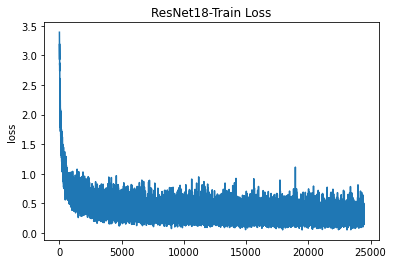

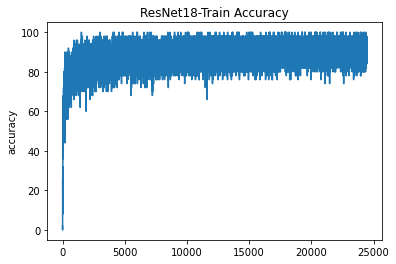

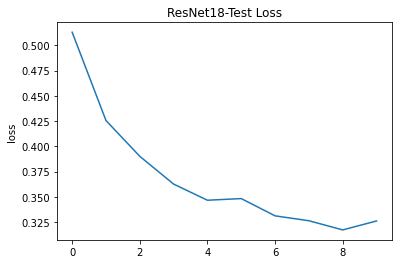

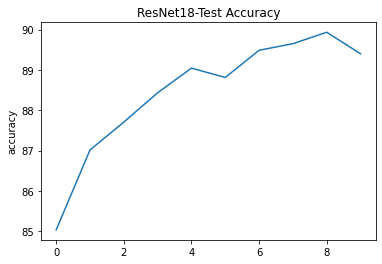

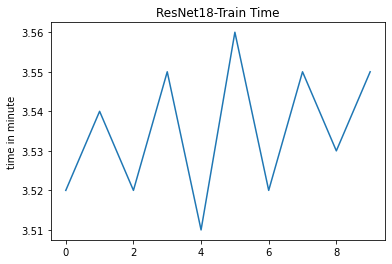

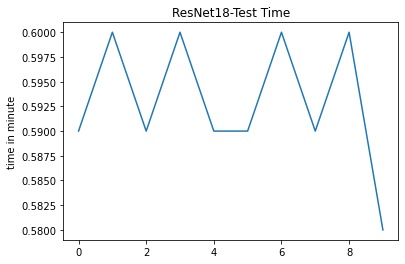

3.535
35.35


In [15]:
# Plot train_loss and train_accuracy
plt.plot(train_loss_tracker)
plt.title('ResNet18-Train Loss')
plt.ylabel('loss')
plt.show()
plt.plot(train_accuracy_tracker)
plt.title('ResNet18-Train Accuracy')
plt.ylabel('accuracy')
plt.show()
# Plot test_loss and test_accuracy
plt.plot(test_loss_tracker)
plt.title('ResNet18-Test Loss')
plt.ylabel('loss')
plt.show()
plt.plot(test_accuracy_tracker)
plt.title('ResNet18-Test Accuracy')
plt.ylabel('accuracy')
plt.show()
# Plot train time
train_time_tracker_in_minute = []
for num in train_time_tracker:
    train_time_tracker_in_minute.append(round(num/60, 2))
plt.plot(train_time_tracker_in_minute)
plt.title('ResNet18-Train Time')
plt.ylabel('time in minute')
plt.show()
# Plot test time
test_time_tracker_in_minute = []
for num in test_time_tracker:
    test_time_tracker_in_minute.append(round(num/60, 2))
plt.plot(test_time_tracker_in_minute)
plt.title('ResNet18-Test Time')
plt.ylabel('time in minute')
plt.show()

print(sum(train_time_tracker_in_minute)/10)
print(sum(train_time_tracker_in_minute))